In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as wg
from scipy.interpolate import interp1d
import scipy
from scipy.signal import savgol_filter,boxcar

## STATIC SPECTRUM FIT

In [26]:
#Load a static spectrum/spectra

h = 6.62e-34
c = 3e8
e = 1.6e-19

S_1 = np.loadtxt('CsPbBr3/dn_from_OEpaper.txt',delimiter =',')

energy_S1 = (h*c)/(e*1e-9*S_1[:,0])

S_2 = np.loadtxt('CsPbBr3/dk_from_OEpaper.txt',delimiter =',')

energy_S2 = (h*c)/(e*1e-9*S_2[:,0])

S_3 = np.loadtxt('CsPbBr3/T_from_paper.txt',delimiter =',')

energy_S3 = (h*c)/(e*1e-9*S_3[:,0])

#energy_SX = (h*c)/(e*1e-9*TA_timeslice[:,0]) #converts to eV from nm 



In [27]:
#Define spectral functions S(DF)


def f_S1(energy,eps1,eps2):
    return np.real(np.sqrt(eps1+ 1j*eps2))

def f_S2(energy,eps1,eps2):
    return np.imag(np.sqrt(eps1+ 1j*eps2))

def f_S3(energy_TA,eps_re,eps_im,d):
    c = 137.036
    energy_TA = energy_TA/27.211 #Conv to Hartree
    t = np.exp(1j*energy_TA*d/c*np.sqrt(eps_re +1j*eps_im))
    r = (1 - np.sqrt(eps_re +1j*eps_im) )/(1 + np.sqrt(eps_re +1j*eps_im) )
    return (np.abs(((1-r**2)*t)))**2







In [28]:
#initialise guess as 0s before we start fitting
N_osc = 3
c_guess = [0] * (N_osc*3)
eps_inf_fin =[0.601]
d_guess = [400*18.9] #(400nm in Hartree atomic units)

# c_guess = np.asarray([2967.6**2/8065.6,17158,898.95,79589**2/8065.6,58020,2527.7,4443.5**2/8065.6,18567,2678.4,2468.5**2/8065.6,15885,679.38,2631.2**2/8065.6,14812,399.81,2927.5**2/8065.6,15163,617.49]) #From Reffit
# c_guess = c_guess/8065.6

#print(c_guess.shape)


#X-axis will be kept in eV since all things are dimensionless and the y-axis shall be calculated in Hartree
#As r is insensitive to energy scaling it too shall be in eV
#As T is sensitive to energy scaling (omega is an i/p param) it will be calculated in the Hartree basis
#As the DF is insensetive to the energy scaling used it will be calculated in eV for brevity
#Essentially all homogenous functions are calculated using eV and inhomogenous use Hartree

In [29]:
#Load a previous guess

c_guess = np.load('CsPbBr3_static_bestguess.npy')
print(c_guess)

[3.54840000e-01 2.37518000e+00 1.00200000e-01 1.36038500e+01
 4.32578000e+00 1.26578000e+00 8.24294500e+01 6.17574600e+00
 5.26597757e-74]


In [30]:
c_guess = xf[2:]

In [7]:
#Change shape of prev guess because I was too lazy (last two elements aren't needed)

c_guess[:-5].shape
#c_guess = c_guess[:-2]
print(c_guess.shape)

(9,)


<IPython.core.display.Javascript object>


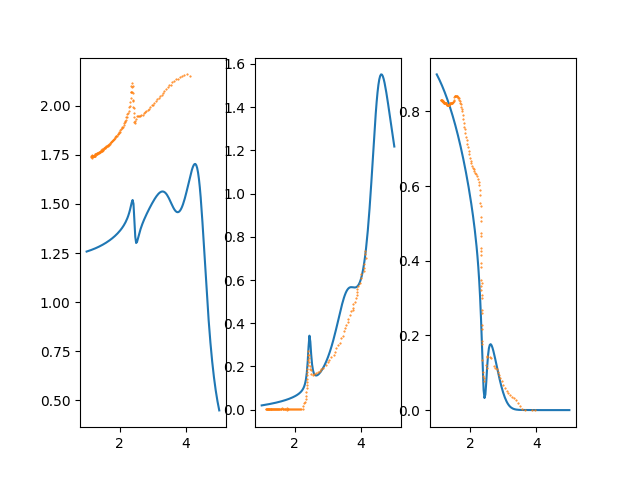

Controlling Oscillator number  2


interactive(children=(FloatSlider(value=0.601, description='eps_inf', max=10.0, step=1e-05), FloatSlider(value…

<function __main__.update(eps_inf=FloatSlider(value=0.601, description='eps_inf', max=10.0, step=1e-05), wp=FloatSlider(value=4.177994166557793, description='wp', step=1e-05), w0=FloatSlider(value=3.5550580447716373, description='w0', max=10.0, min=1.0, step=1e-05), g=FloatSlider(value=0.9640475071204847, description='g', max=2.0, step=1e-05), d=FloatSlider(value=7559.999999999999, description='d', max=9468.9, min=5670.0, step=1e-05))>

In [31]:
#Fit initial fit guess by hand

%matplotlib notebook

e_grid = energy_S1.shape[0]   #Set this to the number of data point you measured

e_min=1
e_max=5

#Set max and min for sliders #NOTE: Will be incorporated into bounds for fitting later
wp_min=0
wp_max=100
w0_min =1
w0_max =10
g_min = 0
g_max = 20e-1
eps_inf_max = 10
eps_inf_min= 0
d_min = 300*18.9
d_max =501*18.9

#Initialise parameters

i=0
params_init=[]
while i<N_osc:
    params_init_temp = [wp_min,np.linspace(w0_min,w0_max,N_osc)[i],g_min]
    params_init = np.append(params_init,params_init_temp)
    i=i+1
    
prams_init = c_guess

#c_guess is a list of parameters of size 3*N_osc (three params per oscillator)
#c_guess is indexed such that [wp_0,w0_0,g_0,wp_1,w0_1,g_1 ... ,wp_n,w0_n,g_n] for n+1 oscillators
#Note that before fitting routine, eps_inf appended to this array so c_guess[0] is eps_inf and c_guess[1:] is the old list


#Initialise slider

i=0
wp_slide=[]

while i<N_osc:
    wp_slide_temp = [wg.FloatSlider(min=wp_min,max=wp_max,step= .00001,value =c_guess[0+3*(i)]),wg.FloatSlider(min=w0_min,max=w0_max,step= .00001,value =c_guess[1+3*(i)]),wg.FloatSlider(min=g_min,max=g_max,step= .00001,value =c_guess[2+3*(i)])]
    wp_slide = np.append(wp_slide,wp_slide_temp)
   
    i=i+1
    
    
    
eps_slide = wg.FloatSlider(min=eps_inf_min,max=eps_inf_max,step= .00001,value = eps_inf_fin[0])
d_slide = wg.FloatSlider(min=d_min,max=d_max,step= .00001,value =d_guess[0])

w=np.linspace(e_min,e_max,e_grid)

#Define the Lorentz Oscillation and Dielectic function as sum of oscillations etc

#IMPORTANT PLEASE NOTE
#Set wp^2 to wp so that we are allowed to have negative oscillators
def LorentzOsc(w,wp,w0,g):
    return wp/(w0**2 - w**2 - 1j*w*g)


#Dielectric function is eps_inf + a sum of oscillators 
def DF(w,eps_inf,params,N_osc):
    i=0
    x = np.zeros(w.shape[0])
    wp=params[0::3]
    w0=params[1::3]
    g=params[2::3]
    while i<N_osc:
        x = x+LorentzOsc(w,wp[i],w0[i],g[i])
        i=i+1
    return x + eps_inf    

    
#This is where you select the oscillator to control in the slider. Change this to a value <= N_osc and run this bit of code to select a differnt oscillator 
osc_num = 2


i_wp=int(0+3*(osc_num-1))
i_w0=int(1+3*(osc_num-1))
i_g=int(2+3*(osc_num-1))


#Sets up plot for each SX 

fig1, ax =  plt.subplots(1,3)
line_S1, = ax[0].plot(w,f_S1(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc))))                                                                                                                                
line_S1_data = ax[0].plot(energy_S1,S_1[:,1],'.',markersize = 1)
line_S2, = ax[1].plot(w,f_S2(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc))))                                                                                                                                
line_S2_data = ax[1].plot(energy_S2,S_2[:,1],'.',markersize = 1)
line_S3, = ax[2].plot(w,f_S3(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc)),d_guess[0]))                                                                                                                                
line_S3_data = ax[2].plot(energy_S3,S_3[:,1],'.',markersize = 1)


#Updates plot when sliders moved
def update(eps_inf = eps_slide, wp=wp_slide[i_wp],w0=wp_slide[i_w0],g=wp_slide[i_g], d = d_slide):
    line_S1.set_ydata(f_S1(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc))))
    line_S2.set_ydata(f_S2(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc))))
    line_S3.set_ydata(f_S3(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc)),d_guess[0]))
    c_guess[i_wp] = wp
    c_guess[i_w0] = w0
    c_guess[i_g] =  g
    d_guess[0] = d
    eps_inf_fin[0] = eps_inf
    fig1.canvas.draw_idle()



print('Controlling Oscillator number ', osc_num)   
wg.interact(update)




In [33]:
#Print out and manually save the guess if needed before closing!

#If you change a parameter with slider make sure to run the previous cell again!!

print(c_guess)

np.save('CsPbBr3_static_bestguess.npy',c_guess)




[ 0.19950467  2.43687064  0.11776951  4.17799417  3.55505804  0.96404751
 11.06612476  4.46531513  0.62805236]


In [34]:
#LM Fitting Scheme (To fit the data coarsely)

#Define residues to be square of diff between Data and Fits for whichever ones work
def residues(c_guess,energy_S1,energy_S2,energy_S3,S_1,S_2,S_3):
    f1 = f_S1(energy_S1, np.real(DF(energy_S1,c_guess[1] ,c_guess[2:],N_osc)), np.imag(DF(energy_S1,c_guess[1] ,c_guess[2:],N_osc)))
    f2 = f_S2(energy_S2, np.real(DF(energy_S2,c_guess[1] ,c_guess[2:],N_osc)), np.imag(DF(energy_S2,c_guess[1] ,c_guess[2:],N_osc)))
    f3 = f_S3(energy_S3, np.real(DF(energy_S3,c_guess[1] ,c_guess[2:],N_osc)), np.imag(DF(energy_S3,c_guess[1] ,c_guess[2:],N_osc)),c_guess[0])
    res = np.append((f1 - S_1),(f2 - S_2))
    res = np.append(res,(f3 - S_3)/10)
    #res = (f3 - S_3)
    #res = np.nan_to_num(res)
    return res


#Definifing bounds on variables to be optimised based on bounds of sliders. Change those to change this!
upper_bounds = np.tile([wp_max,w0_max,g_max],N_osc)
upper_bounds = np.append([d_max,eps_inf_max],upper_bounds)

lower_bounds = np.tile([wp_min,w0_min,g_min],N_osc)
lower_bounds = np.append([d_min,eps_inf_min],lower_bounds)

#Defining tighter bounds based on some closeness to guess
# delta_d = 100
# delta_epsinf = 2
# delta_wp = .1
# delta_w0 = 0.1
# delta_g = .02
# upper_bounds = c_guess + np.tile(0.5*np.array([delta_wp,delta_w0,delta_g]),N_osc)
# upper_bounds = np.append([d_guess[0]+.5*delta_d,eps_inf_fin[0]+.5*delta_epsinf],upper_bounds)
# lower_bounds = c_guess - np.tile(0.5*np.array([delta_wp,delta_w0,delta_g]),N_osc)
# lower_bounds = np.append([d_guess[0]-.5*delta_d,eps_inf_fin[0]-.5*delta_epsinf],lower_bounds)


bounds = np.asarray((lower_bounds,upper_bounds))

#Note that before fitting routine, eps_inf appended to this array so c_guess[0] is eps_inf and c_guess[1:] is the old list
x0 = np.append(eps_inf_fin[0],c_guess)
x0 = np.append(d_guess[0],x0)

#Actual fitting routine, can play with the tolerence parameters etc
xf = optimize.least_squares(residues,x0,args=(energy_S1,energy_S2,energy_S3,S_1[:,1],S_2[:,1],S_3[:,1]),bounds = bounds, xtol =3e-16,ftol=3e-16,gtol=3e-16,max_nfev=100000,verbose=2)

xf=xf.x  
    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0507e+01                                    7.77e+02    
       1              2         1.0438e+00      1.95e+01       1.61e+03       6.79e+01    
       2              3         2.3546e-01      8.08e-01       2.11e+02       2.98e+00    
       3              6         2.2080e-01      1.47e-02       2.86e+00       2.72e+00    
       4              7         2.1661e-01      4.20e-03       2.99e+00       1.18e+00    
       5             10         2.1622e-01      3.84e-04       2.81e-01       8.54e-02    
       6             12         2.1608e-01      1.45e-04       8.49e-02       1.22e-01    
       7             13         2.1606e-01      1.66e-05       3.66e-01       2.57e-02    
       8             14         2.1605e-01      7.61e-06       3.71e-01       2.67e-02    
       9             15         2.1604e-01      1.20e-05       6.70e-02       1.07e-02    

      115            154        2.1604e-01      3.12e-08       2.27e-02       1.67e-04    
      116            155        2.1604e-01      5.66e-08       4.50e-02       1.08e-03    
      117            158        2.1604e-01      8.03e-09       5.09e-03       2.64e-04    
      118            159        2.1604e-01      7.50e-09       5.30e-03       1.62e-03    
      119            160        2.1604e-01      9.04e-09       5.01e-03       2.55e-04    
      120            161        2.1604e-01      1.62e-08       1.14e-02       9.58e-04    
      121            162        2.1604e-01      3.12e-08       2.26e-02       1.67e-04    
      122            163        2.1604e-01      5.66e-08       4.49e-02       1.08e-03    
      123            166        2.1604e-01      8.02e-09       5.09e-03       2.64e-04    
      124            167        2.1604e-01      7.49e-09       5.29e-03       1.62e-03    
      125            168        2.1604e-01      9.04e-09       5.01e-03       2.55e-04    

      233            312        2.1604e-01      8.94e-09       4.91e-03       2.57e-04    
      234            313        2.1604e-01      1.60e-08       1.12e-02       9.68e-04    
      235            314        2.1604e-01      3.07e-08       2.23e-02       1.69e-04    
      236            315        2.1603e-01      5.52e-08       4.43e-02       1.10e-03    
      237            318        2.1603e-01      8.17e-09       5.05e-03       2.68e-04    
      238            319        2.1603e-01      7.38e-09       5.23e-03       1.64e-03    
      239            320        2.1603e-01      8.93e-09       4.91e-03       2.57e-04    
      240            321        2.1603e-01      1.60e-08       1.12e-02       9.68e-04    
      241            322        2.1603e-01      3.07e-08       2.23e-02       1.69e-04    
      242            323        2.1603e-01      5.51e-08       4.43e-02       1.10e-03    
      243            326        2.1603e-01      8.21e-09       5.05e-03       2.68e-04    

      342            457        2.1603e-01      1.58e-08       1.11e-02       9.78e-04    
      343            458        2.1603e-01      3.02e-08       2.21e-02       1.70e-04    
      344            459        2.1603e-01      5.38e-08       4.37e-02       1.11e-03    
      345            462        2.1603e-01      8.36e-09       5.01e-03       2.72e-04    
      346            463        2.1603e-01      7.26e-09       5.17e-03       1.65e-03    
      347            464        2.1603e-01      8.83e-09       4.82e-03       2.59e-04    
      348            465        2.1603e-01      1.58e-08       1.11e-02       9.77e-04    
      349            466        2.1603e-01      3.02e-08       2.20e-02       1.70e-04    
      350            467        2.1603e-01      5.38e-08       4.37e-02       1.11e-03    
      351            470        2.1603e-01      8.36e-09       5.01e-03       2.72e-04    
      352            471        2.1603e-01      7.26e-09       5.17e-03       1.65e-03    

      456            609        2.1603e-01      1.56e-08       1.09e-02       9.86e-04    
      457            610        2.1603e-01      2.97e-08       2.18e-02       1.72e-04    
      458            611        2.1603e-01      5.24e-08       4.31e-02       1.13e-03    
      459            614        2.1603e-01      8.56e-09       4.98e-03       2.75e-04    
      460            615        2.1603e-01      7.15e-09       5.11e-03       1.67e-03    
      461            616        2.1603e-01      8.72e-09       4.72e-03       2.61e-04    
      462            617        2.1603e-01      1.55e-08       1.09e-02       9.86e-04    
      463            618        2.1603e-01      2.97e-08       2.17e-02       1.72e-04    
      464            619        2.1603e-01      5.23e-08       4.31e-02       1.13e-03    
      465            622        2.1603e-01      8.58e-09       4.98e-03       2.76e-04    
      466            623        2.1603e-01      7.14e-09       5.11e-03       1.67e-03    

      576            757        2.1603e-01      7.10e-09       5.40e-03       8.89e-04    
      577            758        2.1603e-01      1.49e-08       1.05e-02       1.57e-04    
      578            759        2.1603e-01      2.87e-08       2.14e-02       7.48e-04    
      579            760        2.1603e-01      2.71e-08       4.32e-02       4.87e-04    
      580            762        2.1603e-01      2.09e-08       7.49e-03       2.61e-03    
      581            763        2.1603e-01      2.44e-08       9.97e-03       7.02e-04    
      582            764        2.1603e-01      1.09e-08       1.05e-02       2.83e-03    
      583            765        2.1603e-01      1.61e-08       8.33e-03       4.71e-04    
      584            766        2.1603e-01      1.32e-08       1.04e-02       2.06e-03    
      585            767        2.1603e-01      4.07e-09       1.05e-02       4.20e-04    
      586            768        2.1603e-01      9.43e-09       1.83e-03       2.19e-03    

      699            890        2.1603e-01      2.16e-08       4.27e-02       5.20e-04    
      700            892        2.1603e-01      2.31e-08       7.38e-03       2.76e-03    
      701            893        2.1603e-01      2.57e-08       1.01e-02       7.49e-04    
      702            894        2.1603e-01      1.14e-08       1.04e-02       2.95e-03    
      703            895        2.1603e-01      1.59e-08       8.28e-03       4.90e-04    
      704            896        2.1603e-01      1.28e-08       1.03e-02       2.14e-03    
      705            897        2.1603e-01      3.22e-09       1.04e-02       4.36e-04    
      706            898        2.1603e-01      9.95e-09       1.80e-03       2.24e-03    
      707            899        2.1603e-01      5.67e-09       2.70e-03       2.64e-04    
      708            900        2.1603e-01      6.94e-09       5.34e-03       9.09e-04    
      709            901        2.1603e-01      1.47e-08       1.04e-02       1.61e-04    

      806           1014        2.1602e-01      7.85e-09       4.22e-02       6.06e-04    
      807           1015        2.1602e-01      2.89e-08       7.23e-03       3.18e-03    
      808           1016        2.1602e-01      2.91e-08       1.04e-02       8.37e-04    
      809           1017        2.1602e-01      1.27e-08       1.03e-02       3.24e-03    
      810           1018        2.1602e-01      1.56e-08       8.29e-03       5.33e-04    
      811           1019        2.1602e-01      1.22e-08       1.01e-02       2.33e-03    
      812           1020        2.1602e-01      1.88e-09       1.03e-02       4.68e-04    
      813           1021        2.1602e-01      1.09e-08       1.76e-03       2.33e-03    
      814           1022        2.1602e-01      5.68e-09       2.69e-03       2.69e-04    
      815           1023        2.1602e-01      7.78e-09       5.06e-03       7.60e-04    
      816           1024        2.1602e-01      1.48e-08       1.05e-02       1.04e-04    

      912           1138        2.1602e-01      7.66e-09       4.96e-03       7.68e-04    
      913           1139        2.1602e-01      1.45e-08       1.03e-02       1.05e-04    
      914           1140        2.1602e-01      2.87e-08       2.06e-02       3.61e-04    
      915           1141        2.1602e-01      5.72e-08       4.13e-02       7.51e-05    
      916           1142        2.1602e-01      1.14e-07       8.25e-02       2.82e-04    
      917           1143        2.1602e-01      2.02e-07       1.65e-01       4.31e-04    
      918           1147        2.1602e-01      2.18e-08       5.21e-03       1.22e-03    
      919           1148        2.1602e-01      1.11e-08       5.34e-03       4.75e-04    
      920           1149        2.1602e-01      1.46e-08       1.00e-02       1.02e-03    
      921           1150        2.1602e-01      2.83e-08       2.05e-02       1.66e-04    
      922           1151        2.1602e-01      5.16e-08       4.08e-02       8.89e-04    

     1020           1265        2.1602e-01      6.01e-09       1.01e-02       2.48e-03    
     1021           1266        2.1602e-01      9.40e-09       1.43e-03       5.81e-04    
     1022           1267        2.1602e-01      4.78e-09       2.35e-03       3.74e-04    
     1023           1268        2.1602e-01      7.44e-09       4.92e-03       7.69e-05    
     1024           1269        2.1602e-01      1.41e-08       1.00e-02       1.59e-04    
     1025           1270        2.1602e-01      2.80e-08       2.02e-02       7.18e-05    
     1026           1271        2.1602e-01      5.58e-08       4.04e-02       7.17e-05    
     1027           1272        2.1602e-01      1.10e-07       8.06e-02       1.81e-04    
     1028           1273        2.1602e-01      1.16e-07       1.62e-01       8.73e-04    
     1029           1276        2.1602e-01      8.30e-08       1.05e-02       2.26e-03    
     1030           1277        2.1602e-01      3.01e-08       1.08e-02       1.06e-03    

     1127           1392        2.1602e-01      9.62e-09       1.78e-03       2.00e-03    
     1128           1393        2.1602e-01      5.62e-09       2.65e-03       2.48e-04    
     1129           1394        2.1602e-01      7.32e-09       4.77e-03       6.98e-04    
     1130           1395        2.1602e-01      1.38e-08       9.90e-03       1.00e-04    
     1131           1396        2.1602e-01      2.74e-08       1.98e-02       3.44e-04    
     1132           1397        2.1602e-01      5.46e-08       3.96e-02       6.88e-05    
     1133           1398        2.1602e-01      1.08e-07       7.91e-02       3.19e-04    
     1134           1399        2.1601e-01      1.33e-07       1.58e-01       7.72e-04    
     1135           1402        2.1601e-01      6.68e-08       1.06e-02       2.19e-03    
     1136           1403        2.1601e-01      2.65e-08       1.03e-02       9.88e-04    
     1137           1404        2.1601e-01      1.25e-08       9.75e-03       2.54e-03    

     1250           1535        2.1601e-01      7.51e-09       4.81e-03       2.96e-04    
     1251           1536        2.1601e-01      6.17e-09       4.51e-03       1.82e-03    
     1252           1537        2.1601e-01      4.07e-09       4.68e-03       3.43e-04    
     1253           1538        2.1601e-01      5.45e-09       4.31e-03       2.09e-03    
     1254           1539        2.1601e-01      8.31e-09       4.05e-03       3.36e-04    
     1255           1540        2.1601e-01      6.82e-09       4.78e-03       1.29e-03    
     1256           1541        2.1601e-01      1.06e-08       9.73e-03       2.25e-04    
     1257           1542        2.1601e-01      9.54e-09       8.83e-03       1.51e-03    
     1258           1544        2.1601e-01      4.97e-09       2.00e-03       2.77e-04    
     1259           1545        2.1601e-01      3.44e-09       2.27e-03       1.12e-03    
     1260           1546        2.1601e-01      3.67e-09       2.27e-03       1.61e-04    

     1358           1661        2.1601e-01      1.28e-08       4.56e-03       3.45e-04    
     1359           1662        2.1601e-01      6.76e-09       4.54e-03       1.87e-03    
     1360           1663        2.1601e-01      3.64e-09       4.86e-03       3.43e-04    
     1361           1664        2.1601e-01      4.58e-09       8.28e-04       1.44e-03    
     1362           1665        2.1601e-01      1.87e-09       1.21e-03       1.21e-04    
     1363           1666        2.1601e-01      3.35e-09       2.37e-03       3.43e-04    
     1364           1667        2.1601e-01      6.57e-09       4.76e-03       6.35e-05    
     1365           1668        2.1601e-01      1.31e-08       9.53e-03       1.27e-04    
     1366           1669        2.1601e-01      2.62e-08       1.91e-02       6.35e-05    
     1367           1670        2.1601e-01      5.24e-08       3.81e-02       6.97e-05    
     1368           1671        2.1601e-01      1.05e-07       7.62e-02       6.33e-05    

     1468           1786        2.1601e-01      4.33e-08       7.03e-02       8.56e-04    
     1469           1788        2.1601e-01      5.30e-08       1.44e-02       1.16e-03    
     1470           1789        2.1601e-01      1.64e-08       1.74e-02       1.21e-03    
     1471           1791        2.1601e-01      1.13e-08       4.62e-03       3.30e-04    
     1472           1792        2.1601e-01      6.39e-09       4.43e-03       1.86e-03    
     1473           1793        2.1601e-01      3.33e-09       4.80e-03       3.44e-04    
     1474           1794        2.1601e-01      4.65e-09       8.15e-04       1.45e-03    
     1475           1795        2.1601e-01      1.84e-09       1.19e-03       1.21e-04    
     1476           1796        2.1601e-01      3.26e-09       2.31e-03       3.47e-04    
     1477           1797        2.1601e-01      6.39e-09       4.64e-03       6.02e-05    
     1478           1798        2.1601e-01      1.27e-08       9.29e-03       1.29e-04    

     1576           1912        2.1600e-01      3.48e-09       2.12e-03       1.64e-04    
     1577           1913        2.1600e-01      6.35e-09       4.57e-03       5.10e-04    
     1578           1914        2.1600e-01      1.25e-08       9.12e-03       6.85e-05    
     1579           1915        2.1600e-01      2.49e-08       1.82e-02       2.81e-04    
     1580           1916        2.1600e-01      4.76e-08       3.65e-02       1.33e-04    
     1581           1917        2.1600e-01      6.34e-08       7.05e-02       6.71e-04    
     1582           1919        2.1600e-01      3.19e-08       1.45e-02       8.91e-04    
     1583           1920        2.1600e-01      5.56e-09       1.58e-02       1.44e-03    
     1584           1921        2.1600e-01      1.79e-08       4.32e-03       3.84e-04    
     1585           1922        2.1600e-01      7.01e-09       4.34e-03       1.88e-03    
     1586           1923        2.1600e-01      5.35e-09       4.10e-03       3.64e-04    

     1683           2029        2.1600e-01      1.21e-08       8.99e-03       5.51e-04    
     1684           2030        2.1600e-01      2.11e-08       1.81e-02       1.66e-04    
     1685           2031        2.1600e-01      1.03e-08       3.39e-02       1.22e-03    
     1686           2032        2.1600e-01      2.50e-08       9.96e-03       4.50e-04    
     1687           2033        2.1600e-01      3.34e-09       8.11e-03       3.30e-03    
     1688           2034        2.1600e-01      1.70e-08       1.54e-03       3.82e-04    
     1689           2035        2.1600e-01      4.12e-09       2.10e-03       4.54e-04    
     1690           2036        2.1600e-01      6.52e-09       4.36e-03       9.35e-05    
     1691           2037        2.1600e-01      1.25e-08       8.97e-03       3.71e-04    
     1692           2038        2.1600e-01      2.44e-08       1.80e-02       6.51e-05    
     1693           2039        2.1600e-01      4.68e-08       3.59e-02       4.51e-04    

     1793           2153        2.1600e-01      6.14e-09       4.43e-03       5.09e-04    
     1794           2154        2.1600e-01      1.21e-08       8.84e-03       7.05e-05    
     1795           2155        2.1600e-01      2.40e-08       1.77e-02       3.06e-04    
     1796           2156        2.1600e-01      4.32e-08       3.54e-02       1.93e-04    
     1797           2157        2.1600e-01      2.07e-08       6.58e-02       9.20e-04    
     1798           2158        2.1600e-01      6.74e-08       1.43e-02       1.33e-03    
     1799           2159        2.1600e-01      2.34e-08       1.73e-02       1.00e-03    
     1800           2161        2.1600e-01      6.37e-09       4.81e-03       2.88e-04    
     1801           2162        2.1600e-01      5.31e-09       4.13e-03       1.78e-03    
     1802           2163        2.1600e-01      3.09e-09       4.49e-03       3.44e-04    
     1803           2164        2.1600e-01      4.55e-09       7.94e-04       1.47e-03    

     1904           2279        2.1600e-01      1.18e-08       8.65e-03       2.14e-04    
     1905           2280        2.1600e-01      2.32e-08       1.73e-02       5.19e-05    
     1906           2281        2.1600e-01      4.47e-08       3.43e-02       3.22e-04    
     1907           2282        2.1600e-01      3.86e-08       6.81e-02       6.07e-04    
     1908           2285        2.1600e-01      3.83e-08       5.00e-03       1.41e-03    
     1909           2286        2.1600e-01      1.46e-08       5.35e-03       5.41e-04    
     1910           2287        2.1600e-01      1.20e-08       7.95e-03       9.83e-04    
     1911           2288        2.1600e-01      1.16e-08       8.42e-03       1.59e-04    
     1912           2289        2.1600e-01      1.80e-08       1.68e-02       8.97e-04    
     1913           2291        2.1600e-01      4.24e-09       4.81e-03       2.55e-04    
     1914           2292        2.1600e-01      4.56e-09       3.99e-03       1.71e-03    

     2012           2405        2.1600e-01      7.45e-09       7.89e-03       1.38e-03    
     2013           2407        2.1600e-01      4.67e-09       1.94e-03       2.64e-04    
     2014           2408        2.1600e-01      2.96e-09       2.02e-03       1.13e-03    
     2015           2409        2.1600e-01      3.26e-09       1.95e-03       1.61e-04    
     2016           2410        2.1600e-01      5.90e-09       4.27e-03       4.95e-04    
     2017           2411        2.1600e-01      1.16e-08       8.50e-03       6.83e-05    
     2018           2412        2.1600e-01      2.31e-08       1.70e-02       2.83e-04    
     2019           2413        2.1600e-01      4.37e-08       3.41e-02       1.38e-04    
     2020           2414        2.1600e-01      4.99e-08       6.56e-02       6.98e-04    
     2021           2416        2.1600e-01      3.69e-08       1.43e-02       9.73e-04    
     2022           2417        2.1600e-01      4.48e-09       1.52e-02       1.36e-03    

     2113           2522        2.1600e-01      5.64e-09       4.14e-03       1.02e-03    
     2114           2523        2.1600e-01      8.54e-09       8.54e-03       1.93e-04    
     2115           2524        2.1600e-01      6.99e-09       7.74e-03       1.41e-03    
     2116           2526        2.1600e-01      4.83e-09       1.92e-03       2.70e-04    
     2117           2527        2.1600e-01      2.89e-09       1.98e-03       1.14e-03    
     2118           2528        2.1600e-01      3.21e-09       1.90e-03       1.63e-04    
     2119           2529        2.1600e-01      5.78e-09       4.19e-03       5.02e-04    
     2120           2530        2.1600e-01      1.14e-08       8.34e-03       6.93e-05    
     2121           2531        2.1600e-01      2.26e-08       1.67e-02       2.83e-04    
     2122           2532        2.1600e-01      4.31e-08       3.34e-02       1.27e-04    
     2123           2533        2.1600e-01      5.34e-08       6.46e-02       6.58e-04    

     2220           2644        2.1599e-01      6.03e-09       3.68e-03       2.54e-04    
     2221           2645        2.1599e-01      5.51e-09       4.09e-03       9.74e-04    
     2222           2646        2.1599e-01      8.90e-09       8.37e-03       1.82e-04    
     2223           2647        2.1599e-01      7.27e-09       7.73e-03       1.28e-03    
     2224           2649        2.1599e-01      4.25e-09       1.97e-03       2.54e-04    
     2225           2650        2.1599e-01      2.81e-09       1.96e-03       1.12e-03    
     2226           2651        2.1599e-01      3.17e-09       1.87e-03       1.61e-04    
     2227           2652        2.1599e-01      5.69e-09       4.13e-03       5.03e-04    
     2228           2653        2.1599e-01      1.12e-08       8.21e-03       7.04e-05    
     2229           2654        2.1599e-01      2.22e-08       1.64e-02       2.97e-04    
     2230           2655        2.1599e-01      4.09e-08       3.29e-02       1.64e-04    

     2326           2766        2.1599e-01      2.23e-08       1.61e-02       6.59e-05    
     2327           2767        2.1599e-01      3.65e-08       3.25e-02       2.74e-04    
     2328           2769        2.1599e-01      2.36e-09       1.44e-02       9.71e-04    
     2329           2770        2.1599e-01      1.53e-08       4.41e-03       3.23e-04    
     2330           2771        2.1599e-01      5.13e-09       3.89e-03       1.84e-03    
     2331           2772        2.1599e-01      1.89e-09       4.67e-03       3.62e-04    
     2332           2773        2.1599e-01      5.02e-09       7.76e-04       1.46e-03    
     2333           2774        2.1599e-01      1.63e-09       1.09e-03       1.25e-04    
     2334           2775        2.1599e-01      2.82e-09       2.00e-03       3.70e-04    
     2335           2776        2.1599e-01      5.49e-09       4.03e-03       4.48e-05    
     2336           2777        2.1599e-01      1.09e-08       8.06e-03       1.39e-04    

     2437           2895        2.1599e-01      3.16e-09       1.87e-03       2.02e-04    
     2438           2896        2.1599e-01      5.40e-09       3.92e-03       6.50e-04    
     2439           2897        2.1599e-01      1.02e-08       7.89e-03       1.11e-04    
     2440           2898        2.1599e-01      1.83e-08       1.56e-02       6.79e-04    
     2441           2901        2.1599e-01      3.25e-09       2.23e-03       1.59e-04    
     2442           2902        2.1599e-01      2.69e-09       1.92e-03       8.23e-04    
     2443           2903        2.1599e-01      2.89e-09       1.82e-03       1.25e-04    
     2444           2904        2.1599e-01      5.39e-09       3.92e-03       3.77e-04    
     2445           2905        2.1599e-01      1.06e-08       7.85e-03       5.74e-05    
     2446           2906        2.1599e-01      2.09e-08       1.57e-02       3.39e-04    
     2447           2907        2.1599e-01      3.14e-08       3.17e-02       2.84e-04    

     2540           3021        2.1599e-01      2.74e-08       3.13e-02       3.21e-04    
     2541           3023        2.1599e-01      9.28e-09       6.89e-03       1.66e-03    
     2542           3025        2.1599e-01      8.22e-09       1.57e-03       3.23e-04    
     2543           3026        2.1599e-01      2.37e-09       2.07e-03       1.15e-03    
     2544           3027        2.1599e-01      3.13e-09       1.71e-03       1.93e-04    
     2545           3028        2.1599e-01      5.33e-09       3.86e-03       5.95e-04    
     2546           3029        2.1599e-01      1.04e-08       7.70e-03       9.68e-05    
     2547           3030        2.1599e-01      2.03e-08       1.54e-02       4.70e-04    
     2548           3031        2.1599e-01      2.76e-08       3.13e-02       3.17e-04    
     2549           3033        2.1599e-01      9.01e-09       6.89e-03       1.71e-03    
     2550           3035        2.1599e-01      8.31e-09       1.57e-03       3.26e-04    

     2649           3155        2.1599e-01      5.29e-09       3.79e-03       5.02e-04    
     2650           3156        2.1599e-01      1.02e-08       7.60e-03       7.48e-05    
     2651           3157        2.1599e-01      2.00e-08       1.52e-02       4.11e-04    
     2652           3158        2.1599e-01      2.56e-08       3.09e-02       3.36e-04    
     2653           3160        2.1599e-01      9.70e-09       6.86e-03       1.73e-03    
     2654           3162        2.1599e-01      8.64e-09       1.55e-03       3.29e-04    
     2655           3163        2.1599e-01      2.35e-09       2.09e-03       1.15e-03    
     2656           3164        2.1599e-01      3.10e-09       1.70e-03       1.95e-04    
     2657           3165        2.1599e-01      5.24e-09       3.80e-03       5.99e-04    
     2658           3166        2.1599e-01      1.02e-08       7.60e-03       9.94e-05    
     2659           3167        2.1599e-01      1.99e-08       1.52e-02       4.93e-04    

     2756           3285        2.1599e-01      5.11e-09       3.71e-03       1.28e-04    
     2757           3286        2.1599e-01      1.01e-08       7.50e-03       4.87e-04    
     2758           3287        2.1599e-01      1.89e-08       1.51e-02       1.05e-04    
     2759           3288        2.1599e-01      2.91e-08       2.90e-02       6.68e-04    
     2760           3290        2.1599e-01      1.26e-08       6.92e-03       4.90e-04    
     2761           3291        2.1599e-01      8.15e-09       7.32e-03       8.03e-04    
     2762           3293        2.1599e-01      3.09e-09       2.11e-03       1.90e-04    
     2763           3294        2.1599e-01      2.57e-09       1.82e-03       9.53e-04    
     2764           3295        2.1599e-01      2.81e-09       1.71e-03       1.35e-04    
     2765           3296        2.1599e-01      5.16e-09       3.74e-03       4.47e-04    
     2766           3297        2.1599e-01      1.00e-08       7.49e-03       6.77e-05    

     2861           3414        2.1599e-01      3.77e-09       1.89e-03       2.14e-03    
     2862           3415        2.1599e-01      3.71e-09       1.60e-03       2.94e-04    
     2863           3416        2.1599e-01      2.71e-09       1.83e-03       9.18e-04    
     2864           3417        2.1599e-01      5.04e-09       3.65e-03       1.31e-04    
     2865           3418        2.1599e-01      9.91e-09       7.39e-03       5.03e-04    
     2866           3419        2.1599e-01      1.84e-08       1.49e-02       1.12e-04    
     2867           3420        2.1599e-01      2.67e-08       2.84e-02       7.07e-04    
     2868           3422        2.1599e-01      1.38e-08       6.88e-03       5.31e-04    
     2869           3423        2.1599e-01      8.44e-09       7.26e-03       7.85e-04    
     2870           3425        2.1599e-01      2.88e-09       2.13e-03       1.84e-04    
     2871           3426        2.1599e-01      2.52e-09       1.80e-03       9.43e-04    

     2982           3561        2.1598e-01      9.71e-09       7.27e-03       6.89e-05    
     2983           3562        2.1598e-01      1.89e-08       1.45e-02       4.15e-04    
     2984           3563        2.1598e-01      1.87e-08       2.99e-02       3.85e-04    
     2985           3565        2.1598e-01      1.19e-08       6.79e-03       1.93e-03    
     2986           3566        2.1598e-01      1.38e-08       5.99e-03       6.14e-04    
     2987           3568        2.1598e-01      3.87e-09       1.85e-03       2.24e-03    
     2988           3569        2.1598e-01      3.74e-09       1.55e-03       3.06e-04    
     2989           3570        2.1598e-01      2.67e-09       1.80e-03       9.55e-04    
     2990           3571        2.1598e-01      4.95e-09       3.59e-03       1.37e-04    
     2991           3572        2.1598e-01      9.73e-09       7.27e-03       5.26e-04    
     2992           3573        2.1598e-01      1.78e-08       1.46e-02       1.19e-04    

     3105           3712        2.1598e-01      3.10e-09       8.13e-04       1.08e-03    
     3106           3713        2.1598e-01      1.56e-09       1.07e-03       1.14e-04    
     3107           3714        2.1598e-01      2.37e-09       1.90e-03       3.84e-04    
     3108           3715        2.1598e-01      4.82e-09       3.55e-03       6.27e-05    
     3109           3716        2.1598e-01      9.53e-09       7.15e-03       2.68e-04    
     3110           3717        2.1598e-01      1.78e-08       1.44e-02       1.00e-04    
     3111           3718        2.1598e-01      2.59e-08       2.76e-02       5.67e-04    
     3112           3720        2.1598e-01      1.31e-08       6.89e-03       5.16e-04    
     3113           3721        2.1598e-01      7.83e-09       7.04e-03       7.31e-04    
     3114           3723        2.1598e-01      2.91e-09       2.13e-03       1.80e-04    
     3115           3724        2.1598e-01      2.43e-09       1.75e-03       9.35e-04    

     3234           3868        2.1598e-01      1.45e-08       6.02e-03       6.72e-04    
     3235           3870        2.1598e-01      3.97e-09       1.80e-03       2.36e-03    
     3236           3871        2.1598e-01      3.75e-09       1.48e-03       3.20e-04    
     3237           3872        2.1598e-01      2.60e-09       1.74e-03       1.01e-03    
     3238           3873        2.1598e-01      4.79e-09       3.46e-03       1.45e-04    
     3239           3874        2.1598e-01      9.37e-09       7.03e-03       5.63e-04    
     3240           3875        2.1598e-01      1.67e-08       1.42e-02       1.33e-04    
     3241           3876        2.1598e-01      1.86e-08       2.67e-02       8.24e-04    
     3242           3878        2.1598e-01      1.82e-08       6.80e-03       6.54e-04    
     3243           3879        2.1598e-01      9.63e-09       7.00e-03       7.07e-04    
     3244           3881        2.1598e-01      1.95e-09       4.39e-03       2.15e-04    

     3355           3998        2.1598e-01      4.41e-09       3.47e-03       1.04e-03    
     3356           3999        2.1598e-01      3.02e-09       3.81e-03       2.01e-04    
     3357           4000        2.1598e-01      3.44e-09       3.45e-03       1.28e-03    
     3358           4001        2.1598e-01      5.28e-09       2.99e-03       2.36e-04    
     3359           4002        2.1598e-01      4.41e-09       3.47e-03       1.04e-03    
     3360           4003        2.1598e-01      3.02e-09       3.80e-03       2.01e-04    
     3361           4004        2.1598e-01      3.44e-09       3.45e-03       1.28e-03    
     3362           4005        2.1598e-01      5.28e-09       2.99e-03       2.36e-04    
     3363           4006        2.1598e-01      4.41e-09       3.47e-03       1.04e-03    
     3364           4007        2.1598e-01      3.02e-09       3.81e-03       2.02e-04    
     3365           4008        2.1598e-01      3.44e-09       3.45e-03       1.29e-03    

     3485           4128        2.1598e-01      3.37e-09       3.43e-03       1.31e-03    
     3486           4129        2.1598e-01      5.28e-09       2.95e-03       2.41e-04    
     3487           4130        2.1598e-01      4.36e-09       3.44e-03       1.07e-03    
     3488           4131        2.1598e-01      2.90e-09       3.80e-03       2.06e-04    
     3489           4132        2.1598e-01      3.36e-09       3.43e-03       1.32e-03    
     3490           4133        2.1598e-01      5.28e-09       2.95e-03       2.42e-04    
     3491           4134        2.1598e-01      4.36e-09       3.44e-03       1.07e-03    
     3492           4135        2.1598e-01      2.89e-09       3.80e-03       2.06e-04    
     3493           4136        2.1598e-01      3.35e-09       3.43e-03       1.32e-03    
     3494           4137        2.1598e-01      5.28e-09       2.95e-03       2.42e-04    
     3495           4138        2.1598e-01      4.35e-09       3.44e-03       1.07e-03    

     3616           4259        2.1598e-01      2.77e-09       3.80e-03       2.11e-04    
     3617           4260        2.1598e-01      3.28e-09       3.42e-03       1.35e-03    
     3618           4261        2.1598e-01      5.28e-09       2.90e-03       2.47e-04    
     3619           4262        2.1598e-01      4.31e-09       3.41e-03       1.10e-03    
     3620           4263        2.1598e-01      2.77e-09       3.80e-03       2.11e-04    
     3621           4264        2.1598e-01      3.28e-09       3.42e-03       1.35e-03    
     3622           4265        2.1598e-01      5.28e-09       2.90e-03       2.47e-04    
     3623           4266        2.1598e-01      4.30e-09       3.41e-03       1.09e-03    
     3624           4267        2.1598e-01      2.76e-09       3.80e-03       2.11e-04    
     3625           4268        2.1598e-01      3.28e-09       3.41e-03       1.35e-03    
     3626           4269        2.1598e-01      5.28e-09       2.90e-03       2.47e-04    

     3737           4380        2.1598e-01      3.22e-09       3.40e-03       1.37e-03    
     3738           4381        2.1598e-01      5.28e-09       2.87e-03       2.51e-04    
     3739           4382        2.1598e-01      4.27e-09       3.39e-03       1.11e-03    
     3740           4383        2.1598e-01      2.70e-09       3.79e-03       2.14e-04    
     3741           4384        2.1598e-01      3.22e-09       3.40e-03       1.37e-03    
     3742           4385        2.1598e-01      5.26e-09       2.87e-03       2.50e-04    
     3743           4386        2.1598e-01      4.25e-09       3.39e-03       1.11e-03    
     3744           4387        2.1598e-01      2.66e-09       3.80e-03       2.14e-04    
     3745           4388        2.1598e-01      3.22e-09       3.40e-03       1.37e-03    
     3746           4389        2.1598e-01      5.27e-09       2.87e-03       2.51e-04    
     3747           4390        2.1598e-01      4.26e-09       3.39e-03       1.11e-03    

     3864           4507        2.1598e-01      2.61e-09       3.78e-03       2.18e-04    
     3865           4508        2.1598e-01      3.15e-09       3.39e-03       1.39e-03    
     3866           4509        2.1598e-01      5.25e-09       2.83e-03       2.54e-04    
     3867           4510        2.1598e-01      4.21e-09       3.36e-03       1.13e-03    
     3868           4511        2.1598e-01      2.55e-09       3.80e-03       2.18e-04    
     3869           4512        2.1598e-01      3.15e-09       3.39e-03       1.39e-03    
     3870           4513        2.1598e-01      5.27e-09       2.83e-03       2.56e-04    
     3871           4514        2.1598e-01      4.22e-09       3.36e-03       1.13e-03    
     3872           4515        2.1598e-01      2.59e-09       3.79e-03       2.18e-04    
     3873           4516        2.1598e-01      3.15e-09       3.39e-03       1.39e-03    
     3874           4517        2.1598e-01      5.26e-09       2.83e-03       2.55e-04    

     3995           4638        2.1598e-01      4.18e-09       3.34e-03       1.14e-03    
     3996           4639        2.1598e-01      2.51e-09       3.78e-03       2.21e-04    
     3997           4640        2.1598e-01      3.09e-09       3.37e-03       1.41e-03    
     3998           4641        2.1598e-01      5.24e-09       2.80e-03       2.58e-04    
     3999           4642        2.1598e-01      4.17e-09       3.34e-03       1.14e-03    
     4000           4643        2.1598e-01      2.49e-09       3.78e-03       2.21e-04    
     4001           4644        2.1598e-01      3.09e-09       3.37e-03       1.41e-03    
     4002           4645        2.1598e-01      5.24e-09       2.80e-03       2.59e-04    
     4003           4646        2.1598e-01      4.17e-09       3.34e-03       1.15e-03    
     4004           4647        2.1598e-01      2.49e-09       3.78e-03       2.21e-04    
     4005           4648        2.1598e-01      3.08e-09       3.37e-03       1.41e-03    

     4117           4760        2.1598e-01      3.03e-09       3.36e-03       1.44e-03    
     4118           4761        2.1598e-01      5.25e-09       2.76e-03       2.63e-04    
     4119           4762        2.1598e-01      4.12e-09       3.31e-03       1.17e-03    
     4120           4763        2.1598e-01      2.38e-09       3.78e-03       2.25e-04    
     4121           4764        2.1598e-01      3.02e-09       3.36e-03       1.44e-03    
     4122           4765        2.1598e-01      5.25e-09       2.76e-03       2.64e-04    
     4123           4766        2.1598e-01      4.12e-09       3.31e-03       1.17e-03    
     4124           4767        2.1598e-01      2.37e-09       3.79e-03       2.25e-04    
     4125           4768        2.1598e-01      3.02e-09       3.36e-03       1.44e-03    
     4126           4769        2.1598e-01      5.25e-09       2.76e-03       2.64e-04    
     4127           4770        2.1598e-01      4.12e-09       3.31e-03       1.17e-03    

     4240           4883        2.1598e-01      2.26e-09       3.79e-03       2.29e-04    
     4241           4884        2.1598e-01      2.96e-09       3.35e-03       1.46e-03    
     4242           4885        2.1598e-01      5.25e-09       2.72e-03       2.68e-04    
     4243           4886        2.1598e-01      4.08e-09       3.29e-03       1.19e-03    
     4244           4887        2.1598e-01      2.26e-09       3.79e-03       2.29e-04    
     4245           4888        2.1598e-01      2.96e-09       3.35e-03       1.46e-03    
     4246           4889        2.1598e-01      5.25e-09       2.72e-03       2.68e-04    
     4247           4890        2.1598e-01      4.07e-09       3.29e-03       1.19e-03    
     4248           4891        2.1598e-01      2.26e-09       3.79e-03       2.29e-04    
     4249           4892        2.1598e-01      2.96e-09       3.35e-03       1.46e-03    
     4250           4893        2.1598e-01      5.25e-09       2.72e-03       2.68e-04    

     4351           4994        2.1598e-01      4.03e-09       3.27e-03       1.21e-03    
     4352           4995        2.1598e-01      2.16e-09       3.79e-03       2.33e-04    
     4353           4996        2.1598e-01      2.91e-09       3.34e-03       1.49e-03    
     4354           4997        2.1598e-01      5.25e-09       2.69e-03       2.72e-04    
     4355           4998        2.1598e-01      4.04e-09       3.27e-03       1.21e-03    
     4356           4999        2.1598e-01      2.17e-09       3.79e-03       2.33e-04    
     4357           5000        2.1598e-01      2.91e-09       3.34e-03       1.48e-03    
     4358           5001        2.1598e-01      5.25e-09       2.69e-03       2.72e-04    
     4359           5002        2.1598e-01      4.03e-09       3.27e-03       1.21e-03    
     4360           5003        2.1598e-01      2.16e-09       3.79e-03       2.33e-04    
     4361           5004        2.1598e-01      2.91e-09       3.34e-03       1.48e-03    

     4461           5104        2.1598e-01      2.85e-09       3.33e-03       1.51e-03    
     4462           5105        2.1598e-01      5.26e-09       2.66e-03       2.77e-04    
     4463           5106        2.1598e-01      3.99e-09       3.25e-03       1.22e-03    
     4464           5107        2.1598e-01      2.06e-09       3.79e-03       2.36e-04    
     4465           5108        2.1598e-01      2.85e-09       3.33e-03       1.51e-03    
     4466           5109        2.1598e-01      5.25e-09       2.66e-03       2.76e-04    
     4467           5110        2.1598e-01      3.99e-09       3.25e-03       1.22e-03    
     4468           5111        2.1598e-01      2.06e-09       3.79e-03       2.36e-04    
     4469           5112        2.1598e-01      2.85e-09       3.33e-03       1.51e-03    
     4470           5113        2.1598e-01      5.25e-09       2.66e-03       2.77e-04    
     4471           5114        2.1598e-01      3.99e-09       3.25e-03       1.23e-03    

     4565           5208        2.1598e-01      2.81e-09       3.32e-03       1.53e-03    
     4566           5209        2.1598e-01      5.25e-09       2.63e-03       2.80e-04    
     4567           5210        2.1598e-01      3.95e-09       3.23e-03       1.24e-03    
     4568           5211        2.1598e-01      1.96e-09       3.80e-03       2.39e-04    
     4569           5212        2.1598e-01      2.81e-09       3.32e-03       1.53e-03    
     4570           5213        2.1598e-01      5.25e-09       2.63e-03       2.80e-04    
     4571           5214        2.1598e-01      3.95e-09       3.23e-03       1.24e-03    
     4572           5215        2.1598e-01      1.96e-09       3.80e-03       2.39e-04    
     4573           5216        2.1598e-01      2.80e-09       3.32e-03       1.53e-03    
     4574           5217        2.1598e-01      5.25e-09       2.63e-03       2.80e-04    
     4575           5218        2.1598e-01      3.95e-09       3.23e-03       1.24e-03    

     4675           5318        2.1598e-01      3.91e-09       3.21e-03       1.26e-03    
     4676           5319        2.1598e-01      1.87e-09       3.80e-03       2.43e-04    
     4677           5320        2.1598e-01      2.76e-09       3.32e-03       1.55e-03    
     4678           5321        2.1598e-01      5.25e-09       2.60e-03       2.84e-04    
     4679           5322        2.1598e-01      3.91e-09       3.21e-03       1.26e-03    
     4680           5323        2.1598e-01      1.87e-09       3.80e-03       2.42e-04    
     4681           5324        2.1598e-01      2.76e-09       3.32e-03       1.55e-03    
     4682           5325        2.1598e-01      5.25e-09       2.60e-03       2.84e-04    
     4683           5326        2.1598e-01      3.91e-09       3.21e-03       1.26e-03    
     4684           5327        2.1598e-01      1.86e-09       3.80e-03       2.43e-04    
     4685           5328        2.1598e-01      2.76e-09       3.32e-03       1.55e-03    

     4780           5440        2.1598e-01      2.35e-09       1.48e-03       1.16e-04    
     4781           5441        2.1598e-01      4.29e-09       3.18e-03       4.39e-04    
     4782           5442        2.1598e-01      8.38e-09       6.36e-03       7.63e-05    
     4783           5443        2.1598e-01      1.59e-08       1.27e-02       4.62e-04    
     4784           5446        2.1598e-01      1.75e-09       2.15e-03       1.11e-04    
     4785           5447        2.1598e-01      1.99e-09       1.62e-03       7.34e-04    
     4786           5448        2.1598e-01      2.35e-09       1.48e-03       1.19e-04    
     4787           5449        2.1598e-01      4.29e-09       3.18e-03       4.44e-04    
     4788           5450        2.1598e-01      8.37e-09       6.36e-03       7.75e-05    
     4789           5451        2.1598e-01      1.59e-08       1.27e-02       4.66e-04    
     4790           5454        2.1598e-01      1.75e-09       2.16e-03       1.13e-04    

     4886           5582        2.1597e-01      1.75e-09       2.17e-03       1.15e-04    
     4887           5583        2.1597e-01      1.97e-09       1.60e-03       7.32e-04    
     4888           5584        2.1597e-01      2.33e-09       1.45e-03       1.18e-04    
     4889           5585        2.1597e-01      4.24e-09       3.14e-03       4.46e-04    
     4890           5586        2.1597e-01      8.27e-09       6.29e-03       7.75e-05    
     4891           5587        2.1597e-01      1.57e-08       1.26e-02       4.70e-04    
     4892           5590        2.1597e-01      1.74e-09       2.16e-03       1.14e-04    
     4893           5591        2.1597e-01      1.97e-09       1.60e-03       7.28e-04    
     4894           5592        2.1597e-01      2.32e-09       1.45e-03       1.17e-04    
     4895           5593        2.1597e-01      4.24e-09       3.14e-03       4.45e-04    
     4896           5594        2.1597e-01      8.26e-09       6.29e-03       7.73e-05    

     4987           5715        2.1597e-01      1.54e-08       1.25e-02       4.80e-04    
     4988           5718        2.1597e-01      1.73e-09       2.18e-03       1.16e-04    
     4989           5719        2.1597e-01      1.94e-09       1.59e-03       7.40e-04    
     4990           5720        2.1597e-01      2.31e-09       1.43e-03       1.19e-04    
     4991           5721        2.1597e-01      4.19e-09       3.11e-03       4.54e-04    
     4992           5722        2.1597e-01      8.17e-09       6.22e-03       7.90e-05    
     4993           5723        2.1597e-01      1.54e-08       1.25e-02       4.82e-04    
     4994           5726        2.1597e-01      1.75e-09       2.18e-03       1.17e-04    
     4995           5727        2.1597e-01      1.94e-09       1.59e-03       7.44e-04    
     4996           5728        2.1597e-01      2.31e-09       1.43e-03       1.20e-04    
     4997           5729        2.1597e-01      4.19e-09       3.11e-03       4.56e-04    

     5088           5850        2.1597e-01      8.02e-09       6.16e-03       8.19e-05    
     5089           5851        2.1597e-01      1.47e-08       1.23e-02       5.25e-04    
     5090           5854        2.1597e-01      1.95e-09       2.23e-03       1.28e-04    
     5091           5855        2.1597e-01      1.93e-09       1.57e-03       7.92e-04    
     5092           5856        2.1597e-01      2.30e-09       1.40e-03       1.25e-04    
     5093           5857        2.1597e-01      4.15e-09       3.07e-03       4.68e-04    
     5094           5858        2.1597e-01      8.01e-09       6.16e-03       8.20e-05    
     5095           5859        2.1597e-01      1.47e-08       1.23e-02       5.26e-04    
     5096           5862        2.1597e-01      1.96e-09       2.23e-03       1.29e-04    
     5097           5863        2.1597e-01      1.92e-09       1.57e-03       7.95e-04    
     5098           5864        2.1597e-01      2.30e-09       1.39e-03       1.25e-04    

     5198           5998        2.1597e-01      1.98e-09       2.24e-03       1.30e-04    
     5199           5999        2.1597e-01      1.90e-09       1.56e-03       8.02e-04    
     5200           6000        2.1597e-01      2.28e-09       1.37e-03       1.26e-04    
     5201           6001        2.1597e-01      4.10e-09       3.04e-03       4.74e-04    
     5202           6002        2.1597e-01      7.91e-09       6.09e-03       8.28e-05    
     5203           6003        2.1597e-01      1.44e-08       1.22e-02       5.32e-04    
     5204           6006        2.1597e-01      1.96e-09       2.23e-03       1.30e-04    
     5205           6007        2.1597e-01      1.90e-09       1.56e-03       8.01e-04    
     5206           6008        2.1597e-01      2.28e-09       1.37e-03       1.26e-04    
     5207           6009        2.1597e-01      4.10e-09       3.04e-03       4.75e-04    
     5208           6010        2.1597e-01      7.90e-09       6.08e-03       8.32e-05    

     5317           6155        2.1597e-01      1.41e-08       1.21e-02       5.42e-04    
     5318           6158        2.1597e-01      2.01e-09       2.24e-03       1.32e-04    
     5319           6159        2.1597e-01      1.87e-09       1.54e-03       8.11e-04    
     5320           6160        2.1597e-01      2.26e-09       1.35e-03       1.27e-04    
     5321           6161        2.1597e-01      4.05e-09       3.00e-03       4.79e-04    
     5322           6162        2.1597e-01      7.79e-09       6.01e-03       8.39e-05    
     5323           6163        2.1597e-01      1.41e-08       1.20e-02       5.43e-04    
     5324           6166        2.1597e-01      2.02e-09       2.24e-03       1.33e-04    
     5325           6167        2.1597e-01      1.87e-09       1.54e-03       8.13e-04    
     5326           6168        2.1597e-01      2.26e-09       1.35e-03       1.28e-04    
     5327           6169        2.1597e-01      4.05e-09       3.00e-03       4.80e-04    

     5441           6321        2.1597e-01      4.00e-09       2.96e-03       4.84e-04    
     5442           6322        2.1597e-01      7.67e-09       5.93e-03       8.46e-05    
     5443           6323        2.1597e-01      1.38e-08       1.19e-02       5.49e-04    
     5444           6326        2.1597e-01      2.05e-09       2.25e-03       1.34e-04    
     5445           6327        2.1597e-01      1.84e-09       1.52e-03       8.19e-04    
     5446           6328        2.1597e-01      2.23e-09       1.33e-03       1.28e-04    
     5447           6329        2.1597e-01      4.00e-09       2.96e-03       4.84e-04    
     5448           6330        2.1597e-01      7.67e-09       5.93e-03       8.45e-05    
     5449           6331        2.1597e-01      1.38e-08       1.19e-02       5.48e-04    
     5450           6334        2.1597e-01      2.05e-09       2.25e-03       1.34e-04    
     5451           6335        2.1597e-01      1.84e-09       1.52e-03       8.20e-04    

     5552           6470        2.1597e-01      2.08e-09       2.26e-03       1.36e-04    
     5553           6471        2.1597e-01      1.82e-09       1.51e-03       8.26e-04    
     5554           6472        2.1597e-01      2.21e-09       1.31e-03       1.29e-04    
     5555           6473        2.1597e-01      3.95e-09       2.92e-03       4.88e-04    
     5556           6474        2.1597e-01      7.56e-09       5.86e-03       8.53e-05    
     5557           6475        2.1597e-01      1.35e-08       1.18e-02       5.56e-04    
     5558           6478        2.1597e-01      2.10e-09       2.26e-03       1.36e-04    
     5559           6479        2.1597e-01      1.82e-09       1.51e-03       8.27e-04    
     5560           6480        2.1597e-01      2.21e-09       1.31e-03       1.30e-04    
     5561           6481        2.1597e-01      3.95e-09       2.92e-03       4.88e-04    
     5562           6482        2.1597e-01      7.56e-09       5.86e-03       8.52e-05    

     5660           6614        2.1597e-01      2.13e-09       2.26e-03       1.37e-04    
     5661           6615        2.1597e-01      1.79e-09       1.50e-03       8.33e-04    
     5662           6616        2.1597e-01      2.19e-09       1.29e-03       1.30e-04    
     5663           6617        2.1597e-01      3.90e-09       2.89e-03       4.92e-04    
     5664           6618        2.1597e-01      7.46e-09       5.79e-03       8.59e-05    
     5665           6619        2.1597e-01      1.32e-08       1.16e-02       5.61e-04    
     5666           6622        2.1597e-01      2.12e-09       2.26e-03       1.37e-04    
     5667           6623        2.1597e-01      1.79e-09       1.50e-03       8.33e-04    
     5668           6624        2.1597e-01      2.19e-09       1.29e-03       1.30e-04    
     5669           6625        2.1597e-01      3.90e-09       2.88e-03       4.92e-04    
     5670           6626        2.1597e-01      7.45e-09       5.79e-03       8.58e-05    

     5773           6758        2.1597e-01      1.09e-08       1.16e-02       7.83e-04    
     5774           6760        2.1597e-01      1.66e-09       4.87e-03       2.12e-04    
     5775           6761        2.1597e-01      3.56e-09       7.93e-04       1.11e-03    
     5776           6762        2.1597e-01      1.21e-09       9.32e-04       1.18e-04    
     5777           6763        2.1597e-01      1.82e-09       1.56e-03       4.42e-04    
     5778           6764        2.1597e-01      3.76e-09       2.83e-03       6.96e-05    
     5779           6765        2.1597e-01      7.32e-09       5.72e-03       3.36e-04    
     5780           6766        2.1597e-01      9.40e-09       1.21e-02       2.03e-04    
     5781           6767        2.1597e-01      5.69e-09       1.05e-02       8.77e-04    
     5782           6768        2.1597e-01      9.36e-09       2.89e-03       4.77e-04    
     5783           6769        2.1597e-01      4.39e-09       2.86e-03       5.04e-04    

     5885           6885        2.1597e-01      6.69e-09       7.01e-03       3.22e-04    
     5886           6886        2.1597e-01      4.17e-09       6.48e-03       1.83e-04    
     5887           6887        2.1597e-01      2.53e-09       6.29e-03       8.45e-04    
     5888           6888        2.1597e-01      4.74e-09       1.95e-03       2.23e-04    
     5889           6889        2.1597e-01      1.77e-09       1.44e-03       1.05e-03    
     5890           6890        2.1597e-01      2.27e-09       1.21e-03       1.67e-04    
     5891           6891        2.1597e-01      1.97e-09       1.40e-03       5.69e-04    
     5892           6892        2.1597e-01      3.61e-09       2.83e-03       9.61e-05    
     5893           6893        2.1597e-01      6.91e-09       5.66e-03       5.52e-04    
     5894           6894        2.1597e-01      1.42e-09       1.28e-02       3.15e-04    
     5895           6895        2.1597e-01      7.65e-09       3.38e-03       1.65e-03    

     6004           7012        2.1597e-01      5.33e-08       4.43e-02       1.89e-04    
     6005           7015        2.1597e-01      5.48e-09       6.92e-03       3.08e-04    
     6006           7016        2.1597e-01      3.92e-09       6.53e-03       2.03e-04    
     6007           7017        2.1597e-01      2.30e-09       6.26e-03       8.43e-04    
     6008           7018        2.1597e-01      4.82e-09       1.95e-03       2.22e-04    
     6009           7019        2.1597e-01      1.75e-09       1.42e-03       1.04e-03    
     6010           7020        2.1597e-01      2.21e-09       1.18e-03       1.66e-04    
     6011           7021        2.1597e-01      1.94e-09       1.37e-03       5.67e-04    
     6012           7022        2.1597e-01      3.53e-09       2.78e-03       9.55e-05    
     6013           7023        2.1597e-01      6.73e-09       5.55e-03       5.52e-04    
     6014           7024        2.1597e-01      3.79e-10       1.27e-02       3.23e-04    

     6112           7131        2.1597e-01      4.96e-08       4.36e-02       2.33e-04    
     6113           7134        2.1597e-01      7.86e-09       7.07e-03       3.39e-04    
     6114           7135        2.1597e-01      3.82e-09       6.33e-03       1.60e-04    
     6115           7136        2.1597e-01      2.15e-09       6.26e-03       8.68e-04    
     6116           7137        2.1597e-01      4.87e-09       1.94e-03       2.27e-04    
     6117           7138        2.1597e-01      1.68e-09       1.41e-03       1.06e-03    
     6118           7139        2.1597e-01      2.20e-09       1.16e-03       1.71e-04    
     6119           7140        2.1597e-01      1.90e-09       1.35e-03       5.85e-04    
     6120           7141        2.1597e-01      3.44e-09       2.73e-03       9.99e-05    
     6121           7142        2.1597e-01      6.51e-09       5.46e-03       5.77e-04    
     6122           7144        2.1597e-01      6.95e-10       3.97e-03       1.54e-04    

     6235           7268        2.1597e-01      3.44e-09       2.64e-03       7.91e-05    
     6236           7269        2.1597e-01      6.51e-09       5.36e-03       3.93e-04    
     6237           7270        2.1597e-01      1.85e-09       1.22e-02       2.96e-04    
     6238           7271        2.1597e-01      6.98e-09       3.37e-03       1.50e-03    
     6239           7272        2.1597e-01      6.98e-09       3.84e-03       4.15e-04    
     6240           7273        2.1597e-01      3.00e-09       2.82e-03       1.59e-03    
     6241           7274        2.1597e-01      3.71e-09       2.41e-03       2.63e-04    
     6242           7275        2.1597e-01      2.82e-09       2.76e-03       1.16e-03    
     6243           7276        2.1597e-01      6.37e-11       3.91e-03       2.37e-04    
     6244           7277        2.1597e-01      2.89e-09       8.06e-04       1.18e-03    
     6245           7278        2.1597e-01      1.41e-09       1.12e-03       1.34e-04    

     6353           7400        2.1597e-01      3.49e-09       2.60e-03       1.74e-04    
     6354           7401        2.1597e-01      6.84e-09       5.20e-03       2.91e-05    
     6355           7402        2.1597e-01      1.34e-08       1.04e-02       1.94e-04    
     6356           7403        2.1597e-01      1.43e-08       2.18e-02       3.09e-04    
     6357           7405        2.1597e-01      1.29e-08       7.18e-03       4.48e-04    
     6358           7406        2.1597e-01      4.96e-09       5.72e-03       1.03e-04    
     6359           7407        2.1597e-01      1.82e-09       6.15e-03       8.53e-04    
     6360           7408        2.1597e-01      4.54e-09       1.99e-03       2.22e-04    
     6361           7409        2.1597e-01      1.57e-09       1.38e-03       1.06e-03    
     6362           7410        2.1597e-01      2.14e-09       1.11e-03       1.72e-04    
     6363           7411        2.1597e-01      1.81e-09       1.29e-03       5.99e-04    

     6453           7518        2.1597e-01      1.81e-09       1.30e-03       9.48e-04    
     6454           7519        2.1597e-01      1.48e-09       1.44e-03       1.82e-04    
     6455           7520        2.1597e-01      1.51e-09       1.36e-03       1.01e-03    
     6456           7521        2.1597e-01      1.96e-09       1.13e-03       1.48e-04    
     6457           7522        2.1597e-01      1.75e-09       1.27e-03       5.59e-04    
     6458           7523        2.1597e-01      3.22e-09       2.58e-03       9.45e-05    
     6459           7524        2.1597e-01      5.99e-09       5.18e-03       5.66e-04    
     6460           7526        2.1597e-01      1.56e-10       4.06e-03       1.62e-04    
     6461           7527        2.1597e-01      2.26e-09       8.25e-04       9.02e-04    
     6462           7528        2.1597e-01      1.38e-09       1.12e-03       1.16e-04    
     6463           7529        2.1597e-01      1.79e-09       1.35e-03       3.30e-04    

     6570           7652        2.1597e-01      5.80e-09       5.10e-03       5.79e-04    
     6571           7655        2.1597e-01      1.06e-09       9.68e-04       1.07e-04    
     6572           7656        2.1597e-01      8.60e-10       6.41e-04       4.66e-04    
     6573           7657        2.1597e-01      8.84e-10       5.99e-04       6.31e-05    
     6574           7658        2.1597e-01      1.68e-09       1.25e-03       1.91e-04    
     6575           7659        2.1597e-01      3.30e-09       2.50e-03       2.53e-05    
     6576           7660        2.1597e-01      6.57e-09       5.00e-03       1.40e-04    
     6577           7661        2.1597e-01      1.23e-08       1.01e-02       8.32e-05    
     6578           7662        2.1597e-01      1.34e-08       2.01e-02       4.08e-04    
     6579           7664        2.1597e-01      1.18e-08       6.88e-03       5.33e-04    
     6580           7665        2.1597e-01      3.60e-09       5.49e-03       6.43e-04    

     6682           7788        2.1596e-01      8.34e-10       6.35e-04       5.63e-04    
     6683           7789        2.1596e-01      8.86e-10       5.82e-04       8.11e-05    
     6684           7790        2.1596e-01      1.63e-09       1.25e-03       2.48e-04    
     6685           7791        2.1596e-01      3.22e-09       2.44e-03       3.31e-05    
     6686           7792        2.1596e-01      6.41e-09       4.87e-03       1.33e-04    
     6687           7793        2.1596e-01      1.24e-08       9.80e-03       5.63e-05    
     6688           7794        2.1596e-01      1.93e-08       1.96e-02       2.89e-04    
     6689           7796        2.1596e-01      5.54e-09       6.71e-03       3.58e-04    
     6690           7797        2.1596e-01      1.14e-09       5.95e-03       7.76e-04    
     6691           7798        2.1596e-01      4.86e-09       2.05e-03       2.04e-04    
     6692           7799        2.1596e-01      1.75e-09       1.25e-03       9.66e-04    

     6807           7935        2.1596e-01      8.67e-10       5.67e-04       8.08e-05    
     6808           7936        2.1596e-01      1.59e-09       1.22e-03       2.51e-04    
     6809           7937        2.1596e-01      3.14e-09       2.37e-03       3.35e-05    
     6810           7938        2.1596e-01      6.25e-09       4.75e-03       1.36e-04    
     6811           7939        2.1596e-01      1.20e-08       9.58e-03       6.26e-05    
     6812           7940        2.1596e-01      1.69e-08       1.91e-02       3.16e-04    
     6813           7942        2.1596e-01      7.01e-09       6.79e-03       4.09e-04    
     6814           7943        2.1596e-01      1.15e-09       5.82e-03       7.41e-04    
     6815           7944        2.1596e-01      4.68e-09       2.09e-03       1.97e-04    
     6816           7945        2.1596e-01      1.76e-09       1.22e-03       9.47e-04    
     6817           7946        2.1596e-01      1.34e-09       1.41e-03       1.83e-04    

     6931           8077        2.1596e-01      2.35e-09       6.38e-03       2.09e-04    
     6932           8078        2.1596e-01      2.73e-09       1.59e-03       6.24e-04    
     6933           8079        2.1596e-01      2.43e-09       1.84e-03       1.57e-04    
     6934           8080        2.1596e-01      1.52e-09       1.24e-03       6.19e-04    
     6935           8081        2.1596e-01      1.61e-09       1.12e-03       9.75e-05    
     6936           8082        2.1596e-01      3.06e-09       2.34e-03       3.79e-04    
     6937           8083        2.1596e-01      5.30e-09       4.92e-03       8.46e-05    
     6938           8084        2.1596e-01      7.35e-09       9.51e-03       5.37e-04    
     6939           8086        2.1596e-01      5.10e-09       3.13e-03       3.29e-04    
     6940           8087        2.1596e-01      3.21e-09       2.35e-03       4.18e-04    
     6941           8088        2.1596e-01      2.50e-09       5.78e-03       1.93e-04    

     7057           8219        2.1596e-01      1.44e-09       1.38e-03       1.23e-03    
     7058           8220        2.1596e-01      1.79e-09       1.03e-03       1.85e-04    
     7059           8221        2.1596e-01      1.53e-09       1.15e-03       6.41e-04    
     7060           8222        2.1596e-01      2.27e-09       2.68e-03       1.14e-04    
     7061           8223        2.1596e-01      1.94e-09       2.74e-03       7.63e-04    
     7062           8225        2.1596e-01      1.28e-09       8.63e-04       1.41e-04    
     7063           8226        2.1596e-01      7.77e-10       6.10e-04       5.65e-04    
     7064           8227        2.1596e-01      8.40e-10       5.44e-04       8.25e-05    
     7065           8228        2.1596e-01      1.54e-09       1.18e-03       2.58e-04    
     7066           8229        2.1596e-01      3.02e-09       2.29e-03       3.49e-05    
     7067           8230        2.1596e-01      6.01e-09       4.58e-03       1.43e-04    

     7178           8354        2.1596e-01      1.12e-08       9.01e-03       1.63e-04    
     7179           8355        2.1596e-01      9.43e-09       1.89e-02       3.07e-04    
     7180           8358        2.1596e-01      9.73e-09       2.49e-03       7.09e-04    
     7181           8359        2.1596e-01      3.71e-09       2.55e-03       2.67e-04    
     7182           8360        2.1596e-01      3.03e-09       2.71e-03       4.87e-04    
     7183           8361        2.1596e-01      2.92e-09       2.34e-03       7.88e-05    
     7184           8362        2.1596e-01      4.54e-09       4.80e-03       4.44e-04    
     7185           8364        2.1596e-01      1.06e-09       2.23e-03       1.27e-04    
     7186           8365        2.1596e-01      1.15e-09       1.40e-03       8.51e-04    
     7187           8366        2.1596e-01      1.83e-09       9.78e-04       1.52e-04    
     7188           8367        2.1596e-01      1.49e-09       1.13e-03       6.02e-04    

     7296           8490        2.1596e-01      4.78e-09       1.81e-03       2.38e-03    
     7297           8491        2.1596e-01      2.78e-09       1.23e-03       3.39e-04    
     7298           8492        2.1596e-01      1.29e-09       1.29e-03       1.28e-03    
     7299           8493        2.1596e-01      1.75e-09       9.96e-04       1.90e-04    
     7300           8494        2.1596e-01      1.46e-09       1.11e-03       6.70e-04    
     7301           8495        2.1596e-01      1.99e-09       2.69e-03       1.19e-04    
     7302           8496        2.1596e-01      1.66e-09       2.77e-03       8.17e-04    
     7303           8498        2.1596e-01      1.43e-09       8.54e-04       1.48e-04    
     7304           8499        2.1596e-01      7.49e-10       5.91e-04       5.78e-04    
     7305           8500        2.1596e-01      8.13e-10       5.16e-04       8.30e-05    
     7306           8501        2.1596e-01      1.48e-09       1.10e-03       2.44e-04    

     7422           8629        2.1596e-01      1.42e-09       1.08e-03       2.30e-05    
     7423           8630        2.1596e-01      2.84e-09       2.16e-03       1.00e-04    
     7424           8631        2.1596e-01      5.61e-09       4.34e-03       2.27e-05    
     7425           8632        2.1596e-01      1.08e-08       8.67e-03       1.48e-04    
     7426           8633        2.1596e-01      9.20e-09       1.83e-02       3.00e-04    
     7427           8636        2.1596e-01      9.34e-09       2.50e-03       6.95e-04    
     7428           8637        2.1596e-01      3.55e-09       2.54e-03       2.69e-04    
     7429           8638        2.1596e-01      2.87e-09       2.61e-03       4.99e-04    
     7430           8639        2.1596e-01      2.75e-09       2.28e-03       8.13e-05    
     7431           8640        2.1596e-01      4.09e-09       4.71e-03       4.66e-04    
     7432           8642        2.1596e-01      1.14e-09       2.27e-03       1.33e-04    

     7540           8763        2.1596e-01      2.19e-09       1.69e-03       1.62e-04    
     7541           8764        2.1596e-01      1.32e-09       1.14e-03       6.87e-04    
     7542           8765        2.1596e-01      1.45e-09       1.01e-03       1.10e-04    
     7543           8766        2.1596e-01      2.68e-09       2.10e-03       4.39e-04    
     7544           8767        2.1596e-01      3.80e-09       4.74e-03       1.16e-04    
     7545           8768        2.1596e-01      3.71e-09       4.56e-03       6.35e-04    
     7546           8769        2.1596e-01      1.26e-09       5.42e-03       1.64e-04    
     7547           8770        2.1596e-01      2.51e-09       1.63e-03       1.08e-03    
     7548           8771        2.1596e-01      2.58e-09       1.93e-03       2.11e-04    
     7549           8772        2.1596e-01      1.28e-09       1.21e-03       8.59e-04    
     7550           8773        2.1596e-01      1.50e-09       9.93e-04       1.35e-04    

     7665           8911        2.1596e-01      1.28e-09       1.17e-03       7.18e-05    
     7666           8912        2.1596e-01      2.55e-09       2.08e-03       4.77e-04    
     7667           8913        2.1596e-01      1.51e-09       5.40e-03       1.77e-04    
     7668           8914        2.1596e-01      2.35e-09       1.65e-03       1.00e-03    
     7669           8915        2.1596e-01      2.46e-09       1.89e-03       1.96e-04    
     7670           8916        2.1596e-01      1.25e-09       1.20e-03       8.25e-04    
     7671           8917        2.1596e-01      1.47e-09       9.83e-04       1.31e-04    
     7672           8918        2.1596e-01      1.32e-09       1.04e-03       5.08e-04    
     7673           8919        2.1596e-01      2.01e-09       2.44e-03       9.63e-05    
     7674           8920        2.1596e-01      1.56e-09       2.64e-03       6.90e-04    
     7675           8922        2.1596e-01      1.19e-09       8.94e-04       1.34e-04    

     7786           9053        2.1596e-01      2.62e-09       2.00e-03       3.06e-05    
     7787           9054        2.1596e-01      5.18e-09       4.02e-03       1.48e-04    
     7788           9055        2.1596e-01      8.14e-09       8.51e-03       1.31e-04    
     7789           9057        2.1596e-01      3.34e-09       2.27e-03       4.20e-04    
     7790           9058        2.1596e-01      2.90e-09       2.06e-03       1.12e-04    
     7791           9059        2.1596e-01      4.41e-09       4.30e-03       4.78e-04    
     7792           9062        2.1596e-01      9.78e-10       1.06e-03       9.83e-05    
     7793           9063        2.1596e-01      6.83e-10       5.44e-04       4.45e-04    
     7794           9064        2.1596e-01      7.21e-10       4.80e-04       6.43e-05    
     7795           9065        2.1596e-01      1.34e-09       1.01e-03       2.04e-04    
     7796           9066        2.1596e-01      2.62e-09       2.01e-03       2.93e-05    

     7896           9181        2.1596e-01      2.60e-09       1.64e-03       9.81e-04    
     7897           9182        2.1596e-01      2.54e-09       2.02e-03       2.02e-04    
     7898           9183        2.1596e-01      1.20e-09       1.18e-03       8.34e-04    
     7899           9184        2.1596e-01      1.42e-09       9.56e-04       1.34e-04    
     7900           9185        2.1596e-01      1.26e-09       1.01e-03       5.22e-04    
     7901           9186        2.1596e-01      1.81e-09       2.44e-03       1.00e-04    
     7902           9187        2.1596e-01      1.35e-09       2.68e-03       7.27e-04    
     7903           9189        2.1596e-01      1.30e-09       8.89e-04       1.39e-04    
     7904           9190        2.1596e-01      6.60e-10       5.54e-04       5.73e-04    
     7905           9191        2.1596e-01      7.41e-10       4.61e-04       8.39e-05    
     7906           9192        2.1596e-01      1.32e-09       9.88e-04       2.59e-04    

     8013           9316        2.1596e-01      1.28e-09       9.67e-04       2.97e-05    
     8014           9317        2.1596e-01      2.53e-09       1.94e-03       1.22e-04    
     8015           9318        2.1596e-01      4.87e-09       3.97e-03       3.99e-05    
     8016           9319        2.1596e-01      8.29e-09       7.99e-03       2.34e-04    
     8017           9321        2.1596e-01      5.30e-10       5.99e-03       1.69e-04    
     8018           9322        2.1596e-01      2.72e-09       1.62e-03       7.53e-04    
     8019           9323        2.1596e-01      2.39e-09       2.01e-03       1.82e-04    
     8020           9324        2.1596e-01      1.22e-09       1.11e-03       7.34e-04    
     8021           9325        2.1596e-01      1.35e-09       9.49e-04       1.18e-04    
     8022           9326        2.1596e-01      1.23e-09       9.98e-04       4.74e-04    
     8023           9327        2.1596e-01      1.85e-09       2.37e-03       9.17e-05    

     8116           9440        2.1596e-01      1.63e-09       2.46e-03       1.04e-04    
     8117           9441        2.1596e-01      1.16e-09       2.73e-03       7.78e-04    
     8118           9442        2.1596e-01      1.44e-09       8.77e-04       1.44e-04    
     8119           9443        2.1596e-01      6.48e-10       5.38e-04       5.76e-04    
     8120           9444        2.1596e-01      7.21e-10       4.49e-04       8.45e-05    
     8121           9445        2.1596e-01      1.29e-09       9.63e-04       2.59e-04    
     8122           9446        2.1596e-01      2.49e-09       1.93e-03       4.07e-05    
     8123           9447        2.1596e-01      4.84e-09       3.88e-03       2.32e-04    
     8124           9448        2.1596e-01      4.21e-09       8.91e-03       2.06e-04    
     8125           9450        2.1596e-01      5.34e-09       2.27e-03       6.11e-04    
     8126           9451        2.1596e-01      3.04e-09       3.06e-03       1.76e-04    

     8230           9576        2.1596e-01      4.06e-09       4.05e-03       1.18e-04    
     8231           9577        2.1596e-01      4.53e-10       5.07e-03       7.41e-04    
     8232           9578        2.1596e-01      3.38e-09       2.22e-03       1.80e-04    
     8233           9579        2.1596e-01      1.15e-09       1.09e-03       9.87e-04    
     8234           9580        2.1596e-01      3.03e-10       2.18e-03       1.89e-04    
     8235           9581        2.1596e-01      1.32e-09       3.66e-04       7.53e-04    
     8236           9582        2.1596e-01      3.77e-10       3.94e-04       6.40e-05    
     8237           9583        2.1596e-01      6.39e-10       5.05e-04       1.97e-04    
     8238           9584        2.1596e-01      1.24e-09       9.56e-04       2.17e-05    
     8239           9585        2.1596e-01      2.46e-09       1.87e-03       7.55e-05    
     8240           9586        2.1596e-01      4.91e-09       3.75e-03       1.12e-05    

     8336           9696        2.1596e-01      6.99e-10       4.35e-04       8.48e-05    
     8337           9697        2.1596e-01      1.25e-09       9.30e-04       2.63e-04    
     8338           9698        2.1596e-01      2.40e-09       1.86e-03       4.17e-05    
     8339           9699        2.1596e-01      4.63e-09       3.75e-03       2.40e-04    
     8340           9700        2.1596e-01      2.82e-09       8.91e-03       2.23e-04    
     8341           9702        2.1596e-01      5.91e-09       2.26e-03       6.33e-04    
     8342           9703        2.1596e-01      2.99e-09       3.34e-03       1.88e-04    
     8343           9704        2.1596e-01      2.42e-09       2.42e-03       5.41e-04    
     8344           9705        2.1596e-01      3.76e-09       4.33e-03       5.99e-05    
     8345           9707        2.1596e-01      9.20e-10       2.39e-03       9.40e-05    
     8346           9708        2.1596e-01      9.55e-10       1.32e-03       4.42e-04    

     8447           9820        2.1596e-01      1.28e-09       9.12e-04       4.28e-04    
     8448           9821        2.1596e-01      2.18e-09       1.94e-03       8.44e-05    
     8449           9822        2.1596e-01      3.31e-09       4.06e-03       5.46e-04    
     8450           9824        2.1596e-01      8.97e-10       2.32e-03       1.35e-04    
     8451           9825        2.1596e-01      1.00e-09       3.74e-04       6.11e-04    
     8452           9826        2.1596e-01      3.43e-10       3.02e-04       5.80e-05    
     8453           9827        2.1596e-01      5.92e-10       4.95e-04       2.03e-04    
     8454           9828        2.1596e-01      1.19e-09       9.07e-04       2.87e-05    
     8455           9829        2.1596e-01      2.37e-09       1.82e-03       1.22e-04    
     8456           9830        2.1596e-01      4.53e-09       3.73e-03       4.08e-05    
     8457           9831        2.1596e-01      7.37e-09       7.59e-03       2.35e-04    

     8550           9937        2.1596e-01      4.59e-09       3.80e-03       5.42e-04    
     8551           9938        2.1596e-01      6.53e-09       7.87e-03       7.98e-05    
     8552           9940        2.1596e-01      1.91e-10       5.18e-03       1.85e-04    
     8553           9941        2.1596e-01      2.42e-09       8.39e-04       6.09e-04    
     8554           9942        2.1596e-01      1.05e-09       1.10e-03       9.21e-05    
     8555           9943        2.1596e-01      5.64e-10       7.96e-04       3.86e-04    
     8556           9944        2.1596e-01      6.45e-10       4.34e-04       6.06e-05    
     8557           9945        2.1596e-01      1.16e-09       8.93e-04       2.02e-04    
     8558           9946        2.1596e-01      2.30e-09       1.79e-03       3.47e-05    
     8559           9947        2.1596e-01      4.46e-09       3.62e-03       1.82e-04    
     8560           9948        2.1596e-01      3.08e-09       8.56e-03       2.12e-04    

     8671           10076       2.1596e-01      4.14e-09       2.27e-03       5.35e-04    
     8672           10077       2.1596e-01      2.75e-09       2.38e-03       1.57e-04    
     8673           10078       2.1596e-01      4.59e-09       3.62e-03       5.05e-04    
     8674           10079       2.1596e-01      8.47e-09       7.17e-03       7.41e-05    
     8675           10081       2.1596e-01      1.04e-09       5.40e-03       1.93e-04    
     8676           10082       2.1596e-01      2.28e-09       1.60e-03       3.09e-04    
     8677           10083       2.1596e-01      1.93e-09       1.86e-03       1.89e-04    
     8678           10084       2.1596e-01      1.14e-09       9.45e-04       5.21e-04    
     8679           10085       2.1596e-01      1.16e-09       8.79e-04       8.90e-05    
     8680           10086       2.1596e-01      2.15e-09       1.80e-03       3.87e-04    
     8681           10087       2.1596e-01      1.74e-09       4.63e-03       1.45e-04    

     8772           10190       2.1596e-01      6.37e-10       4.12e-04       7.01e-05    
     8773           10191       2.1596e-01      1.16e-09       8.65e-04       2.34e-04    
     8774           10192       2.1596e-01      2.23e-09       1.74e-03       3.66e-05    
     8775           10193       2.1596e-01      4.28e-09       3.51e-03       2.25e-04    
     8776           10194       2.1596e-01      1.44e-09       8.67e-03       2.34e-04    
     8777           10195       2.1596e-01      6.24e-09       2.26e-03       6.39e-04    
     8778           10196       2.1596e-01      2.87e-09       3.53e-03       1.97e-04    
     8779           10197       2.1596e-01      2.17e-09       2.49e-03       5.45e-04    
     8780           10198       2.1596e-01      2.00e-09       2.35e-03       5.50e-05    
     8781           10200       2.1596e-01      5.57e-10       9.55e-04       7.11e-05    
     8782           10201       2.1596e-01      5.46e-10       5.40e-04       1.87e-04    

     8883           10318       2.1596e-01      5.95e-09       2.26e-03       6.20e-04    
     8884           10319       2.1596e-01      2.76e-09       3.43e-03       1.95e-04    
     8885           10320       2.1596e-01      2.09e-09       2.49e-03       5.35e-04    
     8886           10321       2.1596e-01      1.93e-09       2.36e-03       5.31e-05    
     8887           10323       2.1596e-01      5.50e-10       9.73e-04       7.27e-05    
     8888           10324       2.1596e-01      5.33e-10       5.40e-04       2.00e-04    
     8889           10325       2.1596e-01      5.98e-10       4.21e-04       4.31e-05    
     8890           10326       2.1596e-01      1.11e-09       8.44e-04       1.66e-04    
     8891           10327       2.1596e-01      2.10e-09       1.78e-03       3.28e-05    
     8892           10328       2.1596e-01      4.01e-09       3.51e-03       2.11e-04    
     8893           10329       2.1596e-01      2.81e-09       8.06e-03       1.96e-04    

     8993           10446       2.1596e-01      2.41e-09       1.20e-03       2.29e-04    
     8994           10447       2.1596e-01      1.20e-09       8.40e-04       3.66e-04    
     8995           10448       2.1596e-01      2.02e-09       1.77e-03       7.15e-05    
     8996           10449       2.1596e-01      3.08e-09       3.75e-03       4.69e-04    
     8997           10451       2.1596e-01      6.69e-10       2.35e-03       1.21e-04    
     8998           10452       2.1596e-01      9.47e-10       3.80e-04       5.85e-04    
     8999           10453       2.1596e-01      3.24e-10       3.34e-04       5.83e-05    
     9000           10454       2.1596e-01      5.33e-10       4.95e-04       2.11e-04    
     9001           10455       2.1596e-01      1.08e-09       8.32e-04       3.15e-05    
     9002           10456       2.1596e-01      2.14e-09       1.67e-03       1.41e-04    
     9003           10457       2.1596e-01      3.81e-09       3.57e-03       6.15e-05    

     9088           10545       2.1596e-01      6.98e-10       1.36e-03       7.67e-04    
     9089           10546       2.1596e-01      1.31e-09       7.73e-04       1.41e-04    
     9090           10547       2.1596e-01      9.85e-10       9.15e-04       6.23e-04    
     9091           10548       2.1596e-01      4.81e-10       1.51e-03       1.20e-04    
     9092           10549       2.1596e-01      6.97e-10       1.36e-03       7.68e-04    
     9093           10550       2.1596e-01      1.31e-09       7.73e-04       1.41e-04    
     9094           10551       2.1596e-01      9.85e-10       9.15e-04       6.23e-04    
     9095           10552       2.1596e-01      4.81e-10       1.51e-03       1.20e-04    
     9096           10553       2.1596e-01      6.96e-10       1.36e-03       7.68e-04    
     9097           10554       2.1596e-01      1.31e-09       7.72e-04       1.41e-04    
     9098           10555       2.1596e-01      9.83e-10       9.15e-04       6.25e-04    

     9216           10673       2.1596e-01      6.17e-10       3.83e-04       5.90e-04    
     9217           10674       2.1596e-01      3.72e-10       4.45e-04       6.68e-05    
     9218           10675       2.1596e-01      5.19e-10       6.06e-04       2.19e-04    
     9219           10676       2.1596e-01      1.07e-09       8.23e-04       3.73e-05    
     9220           10677       2.1596e-01      2.09e-09       1.66e-03       1.64e-04    
     9221           10678       2.1596e-01      3.36e-09       3.71e-03       8.05e-05    
     9222           10679       2.1596e-01      2.30e-09       4.17e-03       3.78e-04    
     9223           10681       2.1596e-01      2.01e-09       1.38e-03       2.08e-04    
     9224           10682       2.1596e-01      1.17e-09       8.27e-04       2.37e-04    
     9225           10683       2.1596e-01      2.05e-09       1.71e-03       4.79e-05    
     9226           10684       2.1596e-01      3.55e-09       3.52e-03       3.31e-04    

     9338           10824       2.1596e-01      4.38e-10       9.93e-04       5.68e-05    
     9339           10825       2.1596e-01      4.95e-10       5.28e-04       3.64e-04    
     9340           10826       2.1596e-01      5.84e-10       3.93e-04       5.85e-05    
     9341           10827       2.1596e-01      1.06e-09       8.07e-04       2.22e-04    
     9342           10828       2.1596e-01      2.08e-09       1.62e-03       3.87e-05    
     9343           10829       2.1596e-01      3.93e-09       3.32e-03       2.34e-04    
     9344           10832       2.1596e-01      4.37e-10       9.92e-04       5.67e-05    
     9345           10833       2.1596e-01      4.94e-10       5.28e-04       3.63e-04    
     9346           10834       2.1596e-01      5.83e-10       3.92e-04       5.84e-05    
     9347           10835       2.1596e-01      1.06e-09       8.07e-04       2.22e-04    
     9348           10836       2.1596e-01      2.08e-09       1.62e-03       3.87e-05    

     9459           10985       2.1596e-01      4.89e-10       5.27e-04       3.73e-04    
     9460           10986       2.1596e-01      5.79e-10       3.87e-04       5.98e-05    
     9461           10987       2.1596e-01      1.05e-09       7.98e-04       2.26e-04    
     9462           10988       2.1596e-01      2.05e-09       1.60e-03       3.90e-05    
     9463           10989       2.1596e-01      3.89e-09       3.28e-03       2.33e-04    
     9464           10992       2.1596e-01      4.24e-10       9.88e-04       5.61e-05    
     9465           10993       2.1596e-01      4.85e-10       5.29e-04       3.70e-04    
     9466           10994       2.1596e-01      5.77e-10       3.88e-04       6.01e-05    
     9467           10995       2.1596e-01      1.05e-09       7.96e-04       2.27e-04    
     9468           10996       2.1596e-01      2.04e-09       1.61e-03       4.02e-05    
     9469           10997       2.1596e-01      3.82e-09       3.31e-03       2.47e-04    

     9578           11144       2.1595e-01      4.93e-10       1.06e-03       6.44e-05    
     9579           11145       2.1595e-01      4.84e-10       5.17e-04       3.96e-04    
     9580           11146       2.1595e-01      5.76e-10       3.81e-04       6.23e-05    
     9581           11147       2.1595e-01      1.04e-09       7.86e-04       2.34e-04    
     9582           11148       2.1595e-01      2.01e-09       1.60e-03       4.08e-05    
     9583           11149       2.1595e-01      3.69e-09       3.30e-03       2.61e-04    
     9584           11152       2.1595e-01      4.84e-10       1.05e-03       6.38e-05    
     9585           11153       2.1595e-01      4.82e-10       5.19e-04       3.95e-04    
     9586           11154       2.1595e-01      5.76e-10       3.81e-04       6.24e-05    
     9587           11155       2.1595e-01      1.04e-09       7.86e-04       2.34e-04    
     9588           11156       2.1595e-01      2.01e-09       1.60e-03       4.11e-05    

     9697           11301       2.1595e-01      3.63e-09       3.28e-03       2.65e-04    
     9698           11304       2.1595e-01      4.89e-10       1.06e-03       6.47e-05    
     9699           11305       2.1595e-01      4.75e-10       5.17e-04       4.00e-04    
     9700           11306       2.1595e-01      5.71e-10       3.77e-04       6.30e-05    
     9701           11307       2.1595e-01      1.03e-09       7.76e-04       2.36e-04    
     9702           11308       2.1595e-01      1.98e-09       1.58e-03       4.15e-05    
     9703           11309       2.1595e-01      3.61e-09       3.28e-03       2.67e-04    
     9704           11312       2.1595e-01      4.94e-10       1.06e-03       6.52e-05    
     9705           11313       2.1595e-01      4.76e-10       5.16e-04       4.01e-04    
     9706           11314       2.1595e-01      5.71e-10       3.77e-04       6.31e-05    
     9707           11315       2.1595e-01      1.03e-09       7.76e-04       2.37e-04    

     9822           11468       2.1595e-01      1.95e-09       1.57e-03       4.21e-05    
     9823           11469       2.1595e-01      3.52e-09       3.26e-03       2.72e-04    
     9824           11472       2.1595e-01      5.11e-10       1.08e-03       6.67e-05    
     9825           11473       2.1595e-01      4.71e-10       5.10e-04       4.07e-04    
     9826           11474       2.1595e-01      5.65e-10       3.74e-04       6.38e-05    
     9827           11475       2.1595e-01      1.01e-09       7.66e-04       2.39e-04    
     9828           11476       2.1595e-01      1.95e-09       1.57e-03       4.18e-05    
     9829           11477       2.1595e-01      3.53e-09       3.25e-03       2.70e-04    
     9830           11480       2.1595e-01      5.03e-10       1.07e-03       6.61e-05    
     9831           11481       2.1595e-01      4.69e-10       5.12e-04       4.05e-04    
     9832           11482       2.1595e-01      5.65e-10       3.73e-04       6.37e-05    

     9948           11636       2.1595e-01      1.92e-09       1.55e-03       4.24e-05    
     9949           11637       2.1595e-01      3.45e-09       3.23e-03       2.75e-04    
     9950           11640       2.1595e-01      5.16e-10       1.08e-03       6.73e-05    
     9951           11641       2.1595e-01      4.63e-10       5.07e-04       4.10e-04    
     9952           11642       2.1595e-01      5.59e-10       3.70e-04       6.43e-05    
     9953           11643       2.1595e-01      1.00e-09       7.56e-04       2.42e-04    
     9954           11644       2.1595e-01      1.92e-09       1.55e-03       4.23e-05    
     9955           11645       2.1595e-01      3.45e-09       3.23e-03       2.74e-04    
     9956           11648       2.1595e-01      5.13e-10       1.08e-03       6.71e-05    
     9957           11649       2.1595e-01      4.62e-10       5.07e-04       4.09e-04    
     9958           11650       2.1595e-01      5.58e-10       3.70e-04       6.42e-05    

     10066          11794       2.1595e-01      5.53e-10       3.68e-04       6.48e-05    
     10067          11795       2.1595e-01      9.90e-10       7.47e-04       2.44e-04    
     10068          11796       2.1595e-01      1.89e-09       1.53e-03       4.25e-05    
     10069          11797       2.1595e-01      3.38e-09       3.20e-03       2.76e-04    
     10070          11800       2.1595e-01      5.21e-10       1.09e-03       6.77e-05    
     10071          11801       2.1595e-01      4.55e-10       5.04e-04       4.13e-04    
     10072          11802       2.1595e-01      5.53e-10       3.67e-04       6.47e-05    
     10073          11803       2.1595e-01      9.89e-10       7.46e-04       2.44e-04    
     10074          11804       2.1595e-01      1.89e-09       1.53e-03       4.26e-05    
     10075          11805       2.1595e-01      3.38e-09       3.20e-03       2.76e-04    
     10076          11808       2.1595e-01      5.17e-10       1.09e-03       6.77e-05    

     10189          11957       2.1595e-01      3.32e-09       3.18e-03       2.78e-04    
     10190          11960       2.1595e-01      5.24e-10       1.09e-03       6.82e-05    
     10191          11961       2.1595e-01      4.48e-10       5.01e-04       4.14e-04    
     10192          11962       2.1595e-01      5.47e-10       3.65e-04       6.50e-05    
     10193          11963       2.1595e-01      9.76e-10       7.37e-04       2.46e-04    
     10194          11964       2.1595e-01      1.87e-09       1.51e-03       4.30e-05    
     10195          11965       2.1595e-01      3.30e-09       3.18e-03       2.80e-04    
     10196          11968       2.1595e-01      5.31e-10       1.10e-03       6.87e-05    
     10197          11969       2.1595e-01      4.49e-10       5.00e-04       4.16e-04    
     10198          11970       2.1595e-01      5.47e-10       3.65e-04       6.51e-05    
     10199          11971       2.1595e-01      9.75e-10       7.36e-04       2.45e-04    

     10314          12118       2.1595e-01      9.72e-10       7.70e-04       6.06e-05    
     10315          12119       2.1595e-01      1.90e-09       1.45e-03       2.32e-04    
     10316          12120       2.1595e-01      3.78e-09       2.89e-03       3.55e-05    
     10317          12121       2.1595e-01      7.40e-09       5.82e-03       1.74e-04    
     10318          12122       2.1595e-01      7.31e-09       1.28e-02       2.35e-04    
     10319          12124       2.1595e-01      5.53e-09       7.14e-03       3.68e-04    
     10320          12126       2.1595e-01      3.29e-09       1.74e-03       2.13e-04    
     10321          12127       2.1595e-01      9.97e-10       7.31e-04       1.98e-04    
     10322          12128       2.1595e-01      1.74e-09       1.57e-03       4.73e-05    
     10323          12129       2.1595e-01      3.18e-09       3.13e-03       3.05e-04    
     10324          12131       2.1595e-01      1.08e-09       2.57e-03       9.78e-05    

     10433          12255       2.1595e-01      1.45e-08       1.11e-02       1.06e-04    
     10434          12256       2.1595e-01      2.87e-08       2.22e-02       2.24e-05    
     10435          12257       2.1595e-01      4.39e-08       4.48e-02       3.11e-04    
     10436          12260       2.1595e-01      1.23e-08       7.44e-03       2.25e-04    
     10437          12262       2.1595e-01      2.26e-09       1.58e-03       9.41e-05    
     10438          12263       2.1595e-01      7.28e-10       1.25e-03       3.00e-04    
     10439          12264       2.1595e-01      9.48e-10       7.70e-04       7.84e-05    
     10440          12265       2.1595e-01      7.28e-10       9.35e-04       4.00e-04    
     10441          12266       2.1595e-01      8.81e-10       8.02e-04       7.99e-05    
     10442          12267       2.1595e-01      7.76e-10       8.57e-04       3.86e-04    
     10443          12268       2.1595e-01      2.89e-10       1.52e-03       8.58e-05    

     10559          12400       2.1595e-01      8.90e-10       2.63e-03       9.11e-05    
     10560          12401       2.1595e-01      4.29e-10       2.75e-03       4.58e-04    
     10561          12402       2.1595e-01      1.22e-09       9.79e-04       1.12e-04    
     10562          12403       2.1595e-01      4.39e-10       4.45e-04       5.18e-04    
     10563          12404       2.1595e-01      5.31e-10       3.72e-04       8.03e-05    
     10564          12405       2.1595e-01      4.71e-10       3.43e-04       2.71e-04    
     10565          12406       2.1595e-01      8.49e-10       7.37e-04       4.51e-05    
     10566          12407       2.1595e-01      1.62e-09       1.46e-03       2.68e-04    
     10567          12409       2.1595e-01      2.11e-10       1.72e-03       7.43e-05    
     10568          12410       2.1595e-01      4.85e-10       3.94e-04       4.25e-04    
     10569          12411       2.1595e-01      3.39e-10       4.82e-04       5.54e-05    

     10688          12543       2.1595e-01      3.91e-10       6.92e-04       1.99e-04    
     10689          12544       2.1595e-01      4.52e-10       3.58e-04       3.51e-05    
     10690          12545       2.1595e-01      8.59e-10       6.68e-04       1.29e-04    
     10691          12546       2.1595e-01      1.61e-09       1.46e-03       3.10e-05    
     10692          12547       2.1595e-01      2.81e-09       3.02e-03       1.98e-04    
     10693          12549       2.1595e-01      9.63e-10       1.38e-03       1.14e-04    
     10694          12550       2.1595e-01      8.03e-10       8.07e-04       2.13e-04    
     10695          12551       2.1595e-01      4.83e-10       2.46e-03       1.03e-04    
     10696          12552       2.1595e-01      7.89e-10       8.05e-04       5.58e-04    
     10697          12553       2.1595e-01      7.77e-10       9.69e-04       1.02e-04    
     10698          12554       2.1595e-01      4.10e-10       5.31e-04       4.04e-04    

     10807          12679       2.1595e-01      9.47e-10       8.45e-04       1.33e-04    
     10808          12680       2.1595e-01      8.59e-10       8.61e-04       3.61e-05    
     10809          12681       2.1595e-01      1.65e-09       1.33e-03       8.43e-05    
     10810          12682       2.1595e-01      1.76e-09       3.60e-03       1.13e-04    
     10811          12683       2.1595e-01      9.10e-10       4.50e-03       4.10e-04    
     10812          12684       2.1595e-01      2.44e-09       1.40e-03       2.49e-04    
     10813          12685       2.1595e-01      1.01e-09       7.76e-04       2.30e-04    
     10814          12686       2.1595e-01      1.68e-09       1.33e-03       3.94e-05    
     10815          12687       2.1595e-01      3.06e-09       2.74e-03       2.35e-04    
     10816          12690       2.1595e-01      3.40e-10       1.09e-03       5.65e-05    
     10817          12691       2.1595e-01      3.65e-10       5.31e-04       3.97e-04    

     10933          12823       2.1595e-01      7.17e-10       8.71e-04       2.61e-04    
     10934          12824       2.1595e-01      7.77e-10       8.59e-04       5.95e-05    
     10935          12825       2.1595e-01      6.84e-10       8.81e-04       3.15e-04    
     10936          12826       2.1595e-01      1.45e-10       1.60e-03       7.83e-05    
     10937          12827       2.1595e-01      5.11e-10       3.98e-04       4.70e-04    
     10938          12828       2.1595e-01      3.36e-10       5.16e-04       6.13e-05    
     10939          12829       2.1595e-01      3.74e-10       6.75e-04       2.15e-04    
     10940          12830       2.1595e-01      4.33e-10       3.52e-04       3.74e-05    
     10941          12831       2.1595e-01      8.19e-10       6.42e-04       1.39e-04    
     10942          12832       2.1595e-01      1.50e-09       1.45e-03       3.49e-05    
     10943          12833       2.1595e-01      2.45e-09       3.06e-03       2.18e-04    

     11058          12964       2.1595e-01      4.10e-10       3.19e-04       8.95e-05    
     11059          12965       2.1595e-01      8.07e-10       6.26e-04       1.21e-05    
     11060          12966       2.1595e-01      1.61e-09       1.24e-03       6.75e-05    
     11061          12967       2.1595e-01      3.00e-09       2.64e-03       4.16e-05    
     11062          12968       2.1595e-01      3.11e-09       6.02e-03       2.02e-04    
     11063          12970       2.1595e-01      3.03e-09       3.40e-03       2.69e-04    
     11064          12971       2.1595e-01      8.90e-10       2.04e-03       3.15e-04    
     11065          12973       2.1595e-01      8.00e-10       1.09e-03       8.61e-05    
     11066          12974       2.1595e-01      4.17e-10       4.12e-04       4.68e-04    
     11067          12975       2.1595e-01      2.19e-10       9.68e-04       8.57e-05    
     11068          12976       2.1595e-01      2.86e-10       1.76e-04       3.60e-04    

     11184          13111       2.1595e-01      3.14e-09       2.41e-03       1.65e-05    
     11185          13112       2.1595e-01      6.27e-09       4.81e-03       3.83e-06    
     11186          13113       2.1595e-01      1.25e-08       9.63e-03       2.57e-05    
     11187          13114       2.1595e-01      2.04e-08       1.97e-02       1.81e-04    
     11188          13117       2.1595e-01      1.06e-09       7.12e-03       2.28e-04    
     11189          13118       2.1595e-01      4.08e-09       1.86e-03       2.87e-04    
     11190          13119       2.1595e-01      9.22e-10       1.15e-03       5.85e-05    
     11191          13120       2.1595e-01      1.55e-09       1.23e-03       9.66e-05    
     11192          13121       2.1595e-01      6.02e-10       3.97e-03       1.45e-04    
     11193          13122       2.1595e-01      2.04e-09       1.08e-03       3.79e-04    
     11194          13123       2.1595e-01      1.05e-09       1.79e-03       9.56e-05    

     11298          13241       2.1595e-01      1.17e-09       1.77e-03       2.98e-04    
     11299          13242       2.1595e-01      6.84e-10       2.23e-03       7.31e-05    
     11300          13244       2.1595e-01      5.52e-10       7.74e-04       4.94e-04    
     11301          13245       2.1595e-01      6.22e-10       7.74e-04       9.61e-05    
     11302          13246       2.1595e-01      3.72e-10       4.05e-04       3.87e-04    
     11303          13247       2.1595e-01      4.10e-10       3.14e-04       6.03e-05    
     11304          13248       2.1595e-01      7.60e-10       5.99e-04       2.29e-04    
     11305          13249       2.1595e-01      1.23e-09       1.54e-03       5.00e-05    
     11306          13250       2.1595e-01      1.18e-09       1.76e-03       2.95e-04    
     11307          13251       2.1595e-01      6.85e-10       2.23e-03       7.28e-05    
     11308          13253       2.1595e-01      5.50e-10       7.74e-04       4.91e-04    

     11425          13384       2.1595e-01      1.19e-09       1.55e-03       5.19e-05    
     11426          13385       2.1595e-01      1.14e-09       1.79e-03       3.03e-04    
     11427          13386       2.1595e-01      6.34e-10       2.26e-03       7.44e-05    
     11428          13388       2.1595e-01      5.62e-10       7.78e-04       5.01e-04    
     11429          13389       2.1595e-01      6.27e-10       7.94e-04       9.75e-05    
     11430          13390       2.1595e-01      3.66e-10       4.08e-04       3.93e-04    
     11431          13391       2.1595e-01      4.06e-10       3.14e-04       6.13e-05    
     11432          13392       2.1595e-01      7.49e-10       5.93e-04       2.34e-04    
     11433          13393       2.1595e-01      1.19e-09       1.55e-03       5.20e-05    
     11434          13394       2.1595e-01      1.14e-09       1.79e-03       3.04e-04    
     11435          13395       2.1595e-01      6.32e-10       2.26e-03       7.45e-05    

     11554          13520       2.1595e-01      2.56e-10       1.80e-04       3.11e-04    
     11555          13521       2.1595e-01      1.05e-10       1.26e-04       2.81e-05    
     11556          13522       2.1595e-01      1.87e-10       1.87e-04       9.41e-05    
     11557          13523       2.1595e-01      3.75e-10       2.87e-04       1.37e-05    
     11558          13524       2.1595e-01      7.46e-10       5.75e-04       5.42e-05    
     11559          13525       2.1595e-01      1.47e-09       1.17e-03       1.18e-05    
     11560          13526       2.1595e-01      2.85e-09       2.40e-03       8.11e-05    
     11561          13527       2.1595e-01      2.67e-09       5.82e-03       1.48e-04    
     11562          13529       2.1595e-01      1.51e-09       3.23e-03       6.82e-04    
     11563          13530       2.1595e-01      1.96e-09       5.75e-04       2.23e-04    
     11564          13531       2.1595e-01      5.31e-10       5.58e-04       2.66e-04    

     11674          13646       2.1595e-01      1.09e-09       1.60e-03       5.65e-05    
     11675          13647       2.1595e-01      1.07e-09       1.85e-03       3.25e-04    
     11676          13648       2.1595e-01      5.27e-10       2.32e-03       7.80e-05    
     11677          13649       2.1595e-01      5.87e-10       7.88e-04       5.28e-04    
     11678          13650       2.1595e-01      6.39e-10       8.38e-04       1.02e-04    
     11679          13651       2.1595e-01      3.51e-10       4.21e-04       4.11e-04    
     11680          13652       2.1595e-01      3.98e-10       3.14e-04       6.42e-05    
     11681          13653       2.1595e-01      3.67e-10       2.99e-04       2.41e-04    
     11682          13654       2.1595e-01      6.08e-10       8.39e-04       4.40e-05    
     11683          13655       2.1595e-01      5.23e-10       1.03e-03       3.06e-04    
     11684          13657       2.1595e-01      2.52e-10       4.29e-04       6.09e-05    

     11802          13791       2.1595e-01      1.45e-09       1.54e-03       1.84e-04    
     11803          13792       2.1595e-01      8.06e-10       5.55e-04       1.94e-04    
     11804          13793       2.1595e-01      1.27e-09       1.36e-03       5.53e-05    
     11805          13794       2.1595e-01      7.90e-10       3.45e-03       3.74e-04    
     11806          13795       2.1595e-01      1.27e-09       2.46e-03       1.16e-04    
     11807          13796       2.1595e-01      1.01e-10       1.32e-03       8.49e-04    
     11808          13797       2.1595e-01      1.12e-09       3.68e-04       9.48e-05    
     11809          13798       2.1595e-01      2.50e-10       2.60e-04       9.31e-05    
     11810          13799       2.1595e-01      3.86e-10       3.83e-04       2.25e-05    
     11811          13800       2.1595e-01      7.34e-10       5.76e-04       6.52e-05    
     11812          13801       2.1595e-01      1.44e-09       1.11e-03       1.09e-05    

     11929          13935       2.1595e-01      1.94e-09       2.86e-03       8.10e-05    
     11930          13936       2.1595e-01      1.86e-11       4.28e-03       3.31e-04    
     11931          13937       2.1595e-01      2.42e-09       1.54e-03       2.57e-04    
     11932          13938       2.1595e-01      8.88e-10       8.89e-04       1.44e-04    
     11933          13939       2.1595e-01      1.45e-09       1.09e-03       1.83e-05    
     11934          13940       2.1595e-01      2.49e-09       2.51e-03       6.20e-05    
     11935          13941       2.1595e-01      1.94e-10       6.32e-03       1.61e-04    
     11936          13942       2.1595e-01      4.81e-09       3.52e-03       3.52e-04    
     11937          13943       2.1595e-01      1.71e-09       1.11e-03       1.73e-04    
     11938          13946       2.1595e-01      2.53e-10       4.99e-04       4.92e-05    
     11939          13947       2.1595e-01      2.07e-10       1.57e-04       2.07e-04    

     12045          14069       2.1595e-01      3.48e-10       6.39e-04       3.39e-05    
     12046          14070       2.1595e-01      2.22e-10       3.38e-04       2.66e-05    
     12047          14071       2.1595e-01      3.53e-10       3.18e-04       4.19e-05    
     12048          14072       2.1595e-01      6.98e-10       5.34e-04       8.64e-06    
     12049          14073       2.1595e-01      1.39e-09       1.07e-03       3.26e-05    
     12050          14074       2.1595e-01      2.74e-09       2.17e-03       1.45e-05    
     12051          14075       2.1595e-01      4.53e-09       4.71e-03       9.77e-05    
     12052          14078       2.1595e-01      3.91e-10       2.54e-03       1.01e-04    
     12053          14079       2.1595e-01      6.88e-10       4.04e-04       4.50e-04    
     12054          14080       2.1595e-01      2.49e-10       4.17e-04       5.69e-05    
     12055          14081       2.1595e-01      1.76e-10       2.29e-04       2.15e-04    

     12163          14207       2.1595e-01      1.02e-10       1.67e-04       3.16e-05    
     12164          14208       2.1595e-01      1.75e-10       1.60e-04       9.53e-05    
     12165          14209       2.1595e-01      3.41e-10       2.77e-04       1.06e-05    
     12166          14210       2.1595e-01      6.80e-10       5.21e-04       3.66e-05    
     12167          14211       2.1595e-01      1.36e-09       1.04e-03       5.28e-06    
     12168          14212       2.1595e-01      2.72e-09       2.08e-03       1.93e-05    
     12169          14213       2.1595e-01      5.42e-09       4.17e-03       3.71e-06    
     12170          14214       2.1595e-01      1.07e-08       8.35e-03       3.17e-05    
     12171          14215       2.1595e-01      1.55e-08       1.74e-02       2.09e-04    
     12172          14218       2.1595e-01      5.73e-09       3.74e-03       1.85e-04    
     12173          14219       2.1595e-01      1.90e-09       1.23e-03       4.56e-05    

     12276          14341       2.1595e-01      6.56e-10       5.26e-04       2.02e-05    
     12277          14342       2.1595e-01      1.28e-09       1.07e-03       1.15e-04    
     12278          14343       2.1595e-01      1.36e-09       3.03e-03       9.70e-05    
     12279          14345       2.1595e-01      1.26e-09       1.08e-03       2.90e-04    
     12280          14346       2.1595e-01      7.89e-10       1.21e-03       8.30e-05    
     12281          14347       2.1595e-01      1.30e-09       1.25e-03       2.58e-04    
     12282          14348       2.1595e-01      1.95e-09       2.78e-03       4.02e-05    
     12283          14350       2.1595e-01      8.34e-11       2.54e-03       9.28e-05    
     12284          14351       2.1595e-01      6.20e-10       4.06e-04       3.07e-04    
     12285          14352       2.1595e-01      2.72e-10       5.10e-04       4.46e-05    
     12286          14353       2.1595e-01      3.45e-10       3.71e-04       1.56e-04    

     12383          14469       2.1595e-01      6.74e-10       1.04e-03       1.02e-04    
     12384          14470       2.1595e-01      2.93e-10       4.84e-04       4.26e-04    
     12385          14471       2.1595e-01      3.58e-10       3.26e-04       6.80e-05    
     12386          14472       2.1595e-01      3.14e-10       2.90e-04       2.65e-04    
     12387          14473       2.1595e-01      4.41e-10       9.31e-04       5.12e-05    
     12388          14474       2.1595e-01      3.29e-10       1.20e-03       3.72e-04    
     12389          14476       2.1595e-01      3.39e-10       4.36e-04       7.02e-05    
     12390          14477       2.1595e-01      1.66e-10       1.97e-04       2.83e-04    
     12391          14478       2.1595e-01      1.84e-10       1.34e-04       4.14e-05    
     12392          14479       2.1595e-01      3.31e-10       2.56e-04       1.27e-04    
     12393          14480       2.1595e-01      6.40e-10       5.13e-04       1.99e-05    

     12481          14587       2.1595e-01      1.26e-09       1.01e-03       1.19e-05    
     12482          14588       2.1595e-01      2.29e-09       2.19e-03       9.23e-05    
     12483          14591       2.1595e-01      2.13e-10       1.16e-03       4.89e-05    
     12484          14592       2.1595e-01      2.42e-10       5.83e-04       3.29e-04    
     12485          14593       2.1595e-01      3.77e-10       2.99e-04       6.18e-05    
     12486          14594       2.1595e-01      3.13e-10       2.85e-04       2.68e-04    
     12487          14595       2.1595e-01      4.07e-10       9.73e-04       5.23e-05    
     12488          14596       2.1595e-01      3.01e-10       1.24e-03       3.91e-04    
     12489          14597       2.1595e-01      3.66e-10       4.31e-04       7.20e-05    
     12490          14598       2.1595e-01      1.65e-10       1.91e-04       2.83e-04    
     12491          14599       2.1595e-01      1.81e-10       1.33e-04       4.16e-05    

     12585          14709       2.1595e-01      2.09e-10       5.45e-04       2.89e-05    
     12586          14710       2.1595e-01      1.61e-10       1.57e-04       6.87e-05    
     12587          14711       2.1595e-01      3.14e-10       2.81e-04       1.76e-05    
     12588          14712       2.1595e-01      6.22e-10       4.96e-04       7.90e-05    
     12589          14713       2.1595e-01      1.10e-09       1.22e-03       3.52e-05    
     12590          14714       2.1595e-01      1.31e-09       2.92e-03       1.84e-04    
     12591          14716       2.1595e-01      1.17e-09       1.60e-03       1.62e-04    
     12592          14717       2.1595e-01      6.49e-10       5.50e-04       1.67e-04    
     12593          14719       2.1595e-01      1.61e-10       8.64e-04       5.12e-05    
     12594          14720       2.1595e-01      2.44e-10       5.90e-04       3.28e-04    
     12595          14721       2.1595e-01      3.66e-10       2.79e-04       6.05e-05    

     12690          14831       2.1595e-01      3.05e-10       2.71e-04       2.54e-04    
     12691          14832       2.1595e-01      4.02e-10       9.57e-04       4.78e-05    
     12692          14833       2.1595e-01      2.89e-10       1.23e-03       3.70e-04    
     12693          14835       2.1595e-01      3.48e-10       4.39e-04       6.97e-05    
     12694          14836       2.1595e-01      1.59e-10       1.92e-04       2.82e-04    
     12695          14837       2.1595e-01      1.77e-10       1.32e-04       4.14e-05    
     12696          14838       2.1595e-01      3.17e-10       2.46e-04       1.29e-04    
     12697          14839       2.1595e-01      6.12e-10       4.95e-04       2.03e-05    
     12698          14840       2.1595e-01      1.19e-09       1.02e-03       1.17e-04    
     12699          14841       2.1595e-01      9.44e-10       3.10e-03       1.05e-04    
     12700          14843       2.1595e-01      1.37e-09       1.09e-03       3.05e-04    

     12797          14956       2.1595e-01      1.73e-10       1.31e-04       4.16e-05    
     12798          14957       2.1595e-01      3.11e-10       2.42e-04       1.29e-04    
     12799          14958       2.1595e-01      6.00e-10       4.89e-04       2.07e-05    
     12800          14959       2.1595e-01      1.16e-09       1.01e-03       1.20e-04    
     12801          14960       2.1595e-01      6.93e-10       3.21e-03       1.12e-04    
     12802          14962       2.1595e-01      1.49e-09       1.10e-03       3.18e-04    
     12803          14963       2.1595e-01      7.52e-10       1.57e-03       9.32e-05    
     12804          14964       2.1595e-01      6.06e-10       9.52e-04       2.72e-04    
     12805          14965       2.1595e-01      9.43e-10       1.62e-03       3.01e-05    
     12806          14967       2.1595e-01      2.31e-10       1.18e-03       4.72e-05    
     12807          14968       2.1595e-01      2.39e-10       5.87e-04       2.21e-04    

     12897          15068       2.1595e-01      9.01e-11       1.66e-04       2.84e-05    
     12898          15069       2.1595e-01      1.53e-10       1.37e-04       8.52e-05    
     12899          15070       2.1595e-01      2.99e-10       2.40e-04       1.05e-05    
     12900          15071       2.1595e-01      5.96e-10       4.57e-04       3.67e-05    
     12901          15072       2.1595e-01      1.19e-09       9.14e-04       5.65e-06    
     12902          15073       2.1595e-01      2.38e-09       1.83e-03       2.40e-05    
     12903          15074       2.1595e-01      4.74e-09       3.66e-03       1.16e-05    
     12904          15075       2.1595e-01      8.63e-09       7.53e-03       7.37e-05    
     12905          15079       2.1595e-01      7.33e-10       1.23e-03       6.66e-05    
     12906          15080       2.1595e-01      3.18e-10       3.38e-04       3.40e-04    
     12907          15081       2.1595e-01      2.21e-10       5.81e-04       7.15e-05    

     13002          15183       2.1595e-01      7.03e-10       4.83e-04       3.00e-04    
     13003          15184       2.1595e-01      4.11e-10       8.94e-04       4.35e-05    
     13004          15185       2.1595e-01      3.27e-10       2.38e-04       1.83e-04    
     13005          15186       2.1595e-01      5.98e-10       4.85e-04       2.66e-05    
     13006          15187       2.1595e-01      1.17e-09       9.06e-04       9.95e-05    
     13007          15188       2.1595e-01      2.33e-09       1.82e-03       1.61e-05    
     13008          15189       2.1595e-01      4.40e-09       3.77e-03       4.15e-05    
     13009          15193       2.1595e-01      2.66e-10       6.35e-04       6.12e-05    
     13010          15194       2.1595e-01      1.85e-10       2.74e-04       4.57e-05    
     13011          15195       2.1595e-01      2.79e-10       3.45e-04       8.82e-05    
     13012          15196       2.1595e-01      5.53e-10       5.77e-04       1.84e-05    

     13109          15309       2.1595e-01      1.81e-10       5.99e-04       5.19e-05    
     13110          15310       2.1595e-01      2.09e-10       5.70e-04       3.30e-04    
     13111          15311       2.1595e-01      3.29e-10       2.74e-04       6.05e-05    
     13112          15312       2.1595e-01      2.71e-10       2.95e-04       2.68e-04    
     13113          15313       2.1595e-01      1.78e-10       6.09e-04       5.19e-05    
     13114          15314       2.1595e-01      2.08e-10       5.74e-04       3.31e-04    
     13115          15315       2.1595e-01      3.31e-10       2.74e-04       6.09e-05    
     13116          15316       2.1595e-01      2.72e-10       2.94e-04       2.70e-04    
     13117          15317       2.1595e-01      1.79e-10       6.07e-04       5.21e-05    
     13118          15318       2.1595e-01      2.08e-10       5.73e-04       3.32e-04    
     13119          15319       2.1595e-01      3.30e-10       2.74e-04       6.09e-05    

     13216          15433       2.1595e-01      4.44e-10       1.10e-03       2.62e-05    
     13217          15435       2.1595e-01      1.39e-10       4.94e-04       2.60e-05    
     13218          15436       2.1595e-01      1.26e-10       2.25e-04       1.12e-04    
     13219          15437       2.1595e-01      1.45e-10       1.18e-04       2.41e-05    
     13220          15438       2.1595e-01      2.64e-10       2.07e-04       9.29e-05    
     13221          15439       2.1595e-01      4.90e-10       5.37e-04       1.86e-05    
     13222          15440       2.1595e-01      9.05e-10       1.13e-03       1.23e-04    
     13223          15442       2.1595e-01      3.53e-10       1.16e-03       4.76e-05    
     13224          15443       2.1595e-01      2.44e-10       1.19e-03       2.31e-04    
     13225          15445       2.1595e-01      2.62e-10       4.83e-04       5.52e-05    
     13226          15446       2.1595e-01      1.31e-10       1.96e-04       2.60e-04    

     13312          15549       2.1595e-01      5.95e-10       6.20e-04       1.16e-04    
     13313          15550       2.1595e-01      2.92e-10       2.29e-04       1.60e-04    
     13314          15551       2.1595e-01      4.93e-10       5.10e-04       3.09e-05    
     13315          15552       2.1595e-01      7.93e-10       1.19e-03       2.01e-04    
     13316          15554       2.1595e-01      1.09e-10       1.17e-03       5.33e-05    
     13317          15555       2.1595e-01      2.23e-10       1.91e-04       2.78e-04    
     13318          15556       2.1595e-01      8.14e-11       1.79e-04       2.90e-05    
     13319          15557       2.1595e-01      1.34e-10       1.25e-04       9.11e-05    
     13320          15558       2.1595e-01      2.61e-10       2.10e-04       1.15e-05    
     13321          15559       2.1595e-01      5.20e-10       3.99e-04       4.13e-05    
     13322          15560       2.1595e-01      1.04e-09       7.98e-04       6.22e-06    

     13415          15670       2.1595e-01      2.88e-10       2.36e-04       1.25e-04    
     13416          15671       2.1595e-01      4.94e-10       4.78e-04       2.39e-05    
     13417          15672       2.1595e-01      8.59e-10       1.06e-03       1.59e-04    
     13418          15675       2.1595e-01      1.60e-10       5.40e-04       3.73e-05    
     13419          15676       2.1595e-01      1.25e-10       1.90e-04       2.13e-04    
     13420          15677       2.1595e-01      1.44e-10       1.28e-04       3.25e-05    
     13421          15678       2.1595e-01      2.61e-10       2.02e-04       1.16e-04    
     13422          15679       2.1595e-01      5.01e-10       4.24e-04       1.92e-05    
     13423          15680       2.1595e-01      9.37e-10       9.35e-04       1.21e-04    
     13424          15683       2.1595e-01      1.10e-10       5.06e-04       2.94e-05    
     13425          15684       2.1595e-01      1.19e-10       2.15e-04       1.89e-04    

     13532          15822       2.1595e-01      4.29e-10       6.07e-04       8.99e-05    
     13533          15823       2.1595e-01      2.28e-10       3.27e-04       3.54e-04    
     13534          15824       2.1595e-01      2.61e-10       3.43e-04       5.66e-05    
     13535          15825       2.1595e-01      2.32e-10       2.82e-04       2.49e-04    
     13536          15826       2.1595e-01      1.19e-10       6.76e-04       4.82e-05    
     13537          15827       2.1595e-01      1.62e-10       6.26e-04       3.30e-04    
     13538          15828       2.1595e-01      2.93e-10       2.83e-04       6.23e-05    
     13539          15829       2.1595e-01      2.21e-10       3.22e-04       2.88e-04    
     13540          15830       2.1595e-01      8.28e-11       7.42e-04       5.77e-05    
     13541          15831       2.1595e-01      1.56e-10       1.91e-04       2.88e-04    
     13542          15832       2.1595e-01      9.08e-11       2.26e-04       3.31e-05    

     13645          15967       2.1595e-01      2.52e-10       1.94e-04       1.21e-04    
     13646          15968       2.1595e-01      4.84e-10       4.25e-04       2.12e-05    
     13647          15969       2.1595e-01      8.72e-10       9.85e-04       1.37e-04    
     13648          15972       2.1595e-01      1.28e-10       5.34e-04       3.34e-05    
     13649          15973       2.1595e-01      1.17e-10       2.08e-04       2.04e-04    
     13650          15974       2.1595e-01      1.40e-10       1.19e-04       3.20e-05    
     13651          15975       2.1595e-01      2.52e-10       1.94e-04       1.21e-04    
     13652          15976       2.1595e-01      4.84e-10       4.24e-04       2.12e-05    
     13653          15977       2.1595e-01      8.70e-10       9.86e-04       1.37e-04    
     13654          15980       2.1595e-01      1.28e-10       5.34e-04       3.37e-05    
     13655          15981       2.1595e-01      1.16e-10       2.09e-04       2.06e-04    

     13747          16103       2.1595e-01      2.50e-10       1.92e-04       1.21e-04    
     13748          16104       2.1595e-01      4.78e-10       4.22e-04       2.12e-05    
     13749          16105       2.1595e-01      8.60e-10       9.81e-04       1.37e-04    
     13750          16108       2.1595e-01      1.27e-10       5.35e-04       3.35e-05    
     13751          16109       2.1595e-01      1.15e-10       2.09e-04       2.05e-04    
     13752          16110       2.1595e-01      1.39e-10       1.19e-04       3.22e-05    
     13753          16111       2.1595e-01      2.49e-10       1.92e-04       1.22e-04    
     13754          16112       2.1595e-01      4.77e-10       4.24e-04       2.15e-05    
     13755          16113       2.1595e-01      9.18e-10       8.80e-04       1.25e-04    
     13756          16114       2.1595e-01      8.26e-10       2.62e-03       8.69e-05    
     13757          16116       2.1595e-01      5.80e-10       1.61e-03       4.42e-04    

     13865          16238       2.1595e-01      4.70e-10       2.20e-03       2.80e-04    
     13866          16239       2.1595e-01      6.11e-10       6.08e-04       1.18e-04    
     13867          16240       2.1595e-01      2.74e-10       2.15e-04       1.74e-04    
     13868          16241       2.1595e-01      4.45e-10       5.12e-04       3.40e-05    
     13869          16242       2.1595e-01      6.17e-10       1.30e-03       2.24e-04    
     13870          16244       2.1595e-01      1.75e-10       1.19e-03       5.95e-05    
     13871          16245       2.1595e-01      2.33e-10       1.89e-04       2.91e-04    
     13872          16246       2.1595e-01      7.26e-11       1.42e-04       2.98e-05    
     13873          16247       2.1595e-01      1.18e-10       1.52e-04       1.10e-04    
     13874          16248       2.1595e-01      2.40e-10       2.04e-04       1.62e-05    
     13875          16249       2.1595e-01      4.72e-10       4.04e-04       7.59e-05    

     13981          16375       2.1595e-01      6.22e-10       1.33e-03       4.86e-05    
     13982          16376       2.1595e-01      3.55e-10       2.03e-03       2.08e-04    
     13983          16377       2.1595e-01      5.75e-10       6.87e-04       1.18e-04    
     13984          16378       2.1595e-01      2.74e-10       2.51e-04       1.19e-04    
     13985          16379       2.1595e-01      4.64e-10       4.36e-04       2.19e-05    
     13986          16380       2.1595e-01      8.17e-10       9.71e-04       1.41e-04    
     13987          16383       2.1595e-01      1.30e-10       5.45e-04       3.38e-05    
     13988          16384       2.1595e-01      1.11e-10       2.04e-04       2.08e-04    
     13989          16385       2.1595e-01      1.35e-10       1.23e-04       3.23e-05    
     13990          16386       2.1595e-01      2.41e-10       1.86e-04       1.22e-04    
     13991          16387       2.1595e-01      4.60e-10       4.12e-04       2.12e-05    

     14094          16506       2.1595e-01      4.57e-10       4.20e-04       2.06e-05    
     14095          16507       2.1595e-01      8.19e-10       9.19e-04       1.30e-04    
     14096          16510       2.1595e-01      1.12e-10       5.40e-04       3.16e-05    
     14097          16511       2.1595e-01      1.06e-10       2.15e-04       2.03e-04    
     14098          16512       2.1595e-01      1.32e-10       1.18e-04       3.22e-05    
     14099          16513       2.1595e-01      1.20e-10       9.42e-05       1.22e-04    
     14100          16514       2.1595e-01      2.25e-10       2.22e-04       2.06e-05    
     14101          16515       2.1595e-01      4.34e-10       4.47e-04       1.21e-04    
     14102          16516       2.1595e-01      2.16e-10       1.80e-03       7.20e-05    
     14103          16517       2.1595e-01      5.68e-10       5.10e-04       2.31e-04    
     14104          16518       2.1595e-01      3.19e-10       8.84e-04       4.29e-05    

     14211          16638       2.1595e-01      6.74e-11       1.08e-04       3.01e-05    
     14212          16639       2.1595e-01      1.13e-10       1.08e-04       1.10e-04    
     14213          16640       2.1595e-01      2.26e-10       1.85e-04       1.54e-05    
     14214          16641       2.1595e-01      4.47e-10       3.72e-04       7.09e-05    
     14215          16642       2.1595e-01      7.44e-10       1.05e-03       3.45e-05    
     14216          16643       2.1595e-01      1.60e-11       3.11e-03       1.76e-04    
     14217          16644       2.1595e-01      1.56e-09       1.70e-03       2.03e-04    
     14218          16645       2.1595e-01      5.89e-10       5.02e-04       1.07e-04    
     14219          16646       2.1595e-01      9.23e-10       7.19e-04       2.84e-05    
     14220          16647       2.1595e-01      1.68e-09       1.55e-03       1.23e-04    
     14221          16650       2.1595e-01      3.23e-11       1.17e-03       5.08e-05    

     14313          16754       2.1595e-01      7.94e-10       1.34e-03       1.80e-04    
     14314          16755       2.1595e-01      3.70e-10       4.82e-04       1.05e-04    
     14315          16756       2.1595e-01      1.37e-10       5.56e-04       2.75e-04    
     14316          16757       2.1595e-01      2.36e-10       4.88e-04       4.97e-05    
     14317          16758       2.1595e-01      1.90e-10       3.38e-04       2.22e-04    
     14318          16759       2.1595e-01      4.17e-11       7.92e-04       4.87e-05    
     14319          16760       2.1595e-01      1.47e-10       1.95e-04       2.64e-04    
     14320          16761       2.1595e-01      8.72e-11       2.46e-04       3.21e-05    
     14321          16762       2.1595e-01      1.03e-10       3.08e-04       1.11e-04    
     14322          16763       2.1595e-01      2.19e-10       2.41e-04       2.00e-05    
     14323          16764       2.1595e-01      4.15e-10       4.67e-04       9.78e-05    

     14425          16878       2.1595e-01      6.17e-10       6.40e-04       1.22e-04    
     14426          16879       2.1595e-01      2.53e-10       2.26e-04       1.57e-04    
     14427          16880       2.1595e-01      4.06e-10       4.54e-04       3.00e-05    
     14428          16881       2.1595e-01      5.71e-10       1.19e-03       1.94e-04    
     14429          16883       2.1595e-01      1.13e-10       1.21e-03       5.45e-05    
     14430          16884       2.1595e-01      2.22e-10       1.93e-04       2.79e-04    
     14431          16885       2.1595e-01      6.92e-11       1.78e-04       3.00e-05    
     14432          16886       2.1595e-01      1.04e-10       1.86e-04       1.14e-04    
     14433          16887       2.1595e-01      2.12e-10       2.11e-04       1.77e-05    
     14434          16888       2.1595e-01      4.09e-10       4.18e-04       8.81e-05    
     14435          16889       2.1595e-01      3.43e-10       1.57e-03       6.11e-05    

     14543          17011       2.1595e-01      5.34e-10       8.15e-04       8.07e-05    
     14544          17012       2.1595e-01      8.52e-10       8.01e-04       2.46e-04    
     14545          17013       2.1595e-01      1.34e-09       1.96e-03       4.52e-05    
     14546          17015       2.1595e-01      3.62e-10       1.77e-03       1.22e-04    
     14547          17016       2.1595e-01      1.94e-10       1.27e-03       3.11e-05    
     14548          17017       2.1595e-01      2.20e-10       5.36e-04       3.55e-05    
     14549          17018       2.1595e-01      1.02e-10       1.81e-04       2.03e-04    
     14550          17019       2.1595e-01      1.23e-10       1.46e-04       3.55e-05    
     14551          17020       2.1595e-01      1.11e-10       8.74e-05       1.22e-04    
     14552          17021       2.1595e-01      2.03e-10       2.25e-04       2.06e-05    
     14553          17022       2.1595e-01      3.84e-10       4.50e-04       1.27e-04    

     14650          17132       2.1595e-01      2.10e-10       1.72e-04       1.27e-05    
     14651          17133       2.1595e-01      4.14e-10       3.19e-04       4.46e-05    
     14652          17134       2.1595e-01      8.24e-10       6.43e-04       7.64e-06    
     14653          17135       2.1595e-01      1.58e-09       1.39e-03       4.87e-05    
     14654          17139       2.1595e-01      8.12e-11       2.65e-04       1.55e-05    
     14655          17140       2.1595e-01      5.62e-11       6.78e-05       7.21e-05    
     14656          17141       2.1595e-01      1.06e-10       1.08e-04       1.12e-05    
     14657          17142       2.1595e-01      2.09e-10       1.77e-04       4.33e-05    
     14658          17143       2.1595e-01      4.13e-10       3.21e-04       5.62e-06    
     14659          17144       2.1595e-01      8.21e-10       6.48e-04       3.53e-05    
     14660          17145       2.1595e-01      1.44e-09       1.58e-03       3.97e-05    

     14763          17267       2.1595e-01      8.77e-11       2.40e-04       1.67e-04    
     14764          17268       2.1595e-01      1.20e-10       1.19e-04       3.22e-05    
     14765          17269       2.1595e-01      1.04e-10       8.92e-05       1.25e-04    
     14766          17270       2.1595e-01      1.70e-10       3.64e-04       2.29e-05    
     14767          17271       2.1595e-01      1.54e-10       4.53e-04       1.59e-04    
     14768          17272       2.1595e-01      3.69e-12       8.28e-04       4.05e-05    
     14769          17273       2.1595e-01      1.49e-10       2.00e-04       2.44e-04    
     14770          17274       2.1595e-01      8.64e-11       2.67e-04       3.07e-05    
     14771          17275       2.1595e-01      1.09e-10       1.93e-04       8.69e-05    
     14772          17276       2.1595e-01      2.06e-10       1.70e-04       1.25e-05    
     14773          17277       2.1595e-01      4.07e-10       3.14e-04       4.33e-05    

     14875          17401       2.1595e-01      1.98e-10       1.66e-04       6.63e-05    
     14876          17402       2.1595e-01      3.88e-10       3.61e-04       1.28e-05    
     14877          17403       2.1595e-01      6.79e-10       9.09e-04       8.43e-05    
     14878          17406       2.1595e-01      1.06e-10       5.70e-04       2.70e-05    
     14879          17407       2.1595e-01      8.72e-11       2.21e-04       1.86e-04    
     14880          17408       2.1595e-01      1.15e-10       1.26e-04       3.14e-05    
     14881          17409       2.1595e-01      1.02e-10       8.60e-05       1.25e-04    
     14882          17410       2.1595e-01      1.66e-10       3.65e-04       2.20e-05    
     14883          17411       2.1595e-01      1.50e-10       4.55e-04       1.57e-04    
     14884          17412       2.1595e-01      1.87e-10       3.59e-04       3.17e-05    
     14885          17413       2.1595e-01      1.59e-10       3.77e-04       1.75e-04    

     14985          17527       2.1595e-01      1.21e-10       1.30e-04       4.43e-05    
     14986          17528       2.1595e-01      1.07e-10       9.73e-05       1.57e-04    
     14987          17529       2.1595e-01      1.84e-10       2.55e-04       2.63e-05    
     14988          17530       2.1595e-01      3.31e-10       5.10e-04       1.58e-04    
     14989          17532       2.1595e-01      6.14e-11       5.14e-04       3.47e-05    
     14990          17533       2.1595e-01      7.91e-11       2.77e-04       2.28e-04    
     14991          17534       2.1595e-01      1.21e-10       1.17e-04       3.85e-05    
     14992          17535       2.1595e-01      9.99e-11       9.32e-05       1.52e-04    
     14993          17536       2.1595e-01      1.53e-10       3.97e-04       2.73e-05    
     14994          17537       2.1595e-01      1.33e-10       5.05e-04       1.87e-04    
     14995          17539       2.1595e-01      7.77e-11       2.05e-04       3.44e-05    

     15097          17655       2.1595e-01      1.93e-10       1.54e-04       2.55e-05    
     15098          17656       2.1595e-01      3.74e-10       3.67e-04       9.30e-06    
     15099          17657       2.1595e-01      6.95e-10       8.38e-04       4.97e-05    
     15100          17659       2.1595e-01      1.74e-10       1.16e-03       3.52e-05    
     15101          17660       2.1595e-01      5.28e-11       1.37e-03       1.93e-04    
     15102          17661       2.1595e-01      2.95e-10       5.02e-04       5.18e-05    
     15103          17662       2.1595e-01      9.52e-11       1.78e-04       2.51e-04    
     15104          17663       2.1595e-01      1.19e-10       1.61e-04       3.98e-05    
     15105          17664       2.1595e-01      1.03e-10       8.44e-05       1.43e-04    
     15106          17665       2.1595e-01      1.82e-10       2.40e-04       2.47e-05    
     15107          17666       2.1595e-01      3.26e-10       5.08e-04       1.50e-04    

     15207          17784       2.1595e-01      9.16e-11       1.68e-04       1.96e-04    
     15208          17785       2.1595e-01      1.02e-10       1.11e-04       3.06e-05    
     15209          17786       2.1595e-01      1.89e-10       1.59e-04       1.16e-04    
     15210          17787       2.1595e-01      3.06e-10       5.85e-04       2.51e-05    
     15211          17788       2.1595e-01      2.91e-10       7.87e-04       1.48e-04    
     15212          17789       2.1595e-01      1.66e-10       1.05e-03       3.68e-05    
     15213          17791       2.1595e-01      1.39e-10       3.84e-04       2.47e-04    
     15214          17792       2.1595e-01      1.55e-10       3.77e-04       4.80e-05    
     15215          17793       2.1595e-01      9.25e-11       1.63e-04       1.94e-04    
     15216          17794       2.1595e-01      1.02e-10       1.08e-04       3.02e-05    
     15217          17795       2.1595e-01      1.89e-10       1.59e-04       1.14e-04    

     15311          17900       2.1595e-01      1.00e-10       8.26e-05       1.45e-04    
     15312          17901       2.1595e-01      1.77e-10       2.42e-04       2.52e-05    
     15313          17902       2.1595e-01      3.09e-10       5.27e-04       1.55e-04    
     15314          17904       2.1595e-01      6.04e-11       5.26e-04       3.47e-05    
     15315          17905       2.1595e-01      6.32e-11       8.92e-05       1.54e-04    
     15316          17906       2.1595e-01      2.66e-11       5.82e-05       1.41e-05    
     15317          17907       2.1595e-01      4.72e-11       7.28e-05       4.65e-05    
     15318          17908       2.1595e-01      9.46e-11       7.32e-05       6.70e-06    
     15319          17909       2.1595e-01      1.88e-10       1.51e-04       2.56e-05    
     15320          17910       2.1595e-01      3.64e-10       3.66e-04       9.63e-06    
     15321          17911       2.1595e-01      6.64e-10       8.54e-04       5.15e-05    

     15414          18015       2.1595e-01      3.65e-10       2.83e-04       3.59e-05    
     15415          18016       2.1595e-01      7.05e-10       6.42e-04       1.39e-05    
     15416          18017       2.1595e-01      1.03e-09       1.76e-03       7.30e-05    
     15417          18019       2.1595e-01      3.44e-10       1.65e-03       9.19e-05    
     15418          18020       2.1595e-01      1.50e-11       1.33e-03       1.93e-04    
     15419          18021       2.1595e-01      3.20e-10       5.12e-04       5.09e-05    
     15420          18022       2.1595e-01      1.06e-10       1.52e-04       2.37e-04    
     15421          18023       2.1595e-01      7.62e-11       2.84e-04       4.63e-05    
     15422          18024       2.1595e-01      7.65e-11       2.02e-04       2.59e-04    
     15423          18025       2.1595e-01      1.10e-10       1.41e-04       3.89e-05    
     15424          18026       2.1595e-01      9.46e-11       8.36e-05       1.52e-04    

     15531          18151       2.1595e-01      4.55e-11       9.32e-05       1.36e-04    
     15532          18152       2.1595e-01      5.03e-11       4.74e-05       1.96e-05    
     15533          18153       2.1595e-01      9.13e-11       9.54e-05       6.11e-05    
     15534          18154       2.1595e-01      1.79e-10       1.39e-04       8.91e-06    
     15535          18155       2.1595e-01      3.58e-10       2.77e-04       3.81e-05    
     15536          18156       2.1595e-01      7.09e-10       5.76e-04       7.45e-06    
     15537          18157       2.1595e-01      1.24e-09       1.42e-03       5.80e-05    
     15538          18160       2.1595e-01      3.59e-11       1.25e-03       4.92e-05    
     15539          18161       2.1595e-01      1.76e-10       2.02e-04       2.21e-04    
     15540          18162       2.1595e-01      6.83e-11       2.37e-04       2.80e-05    
     15541          18163       2.1595e-01      4.56e-11       1.40e-04       1.05e-04    

     15651          18288       2.1595e-01      1.06e-10       5.34e-04       1.72e-04    
     15652          18290       2.1595e-01      7.49e-11       2.15e-04       3.33e-05    
     15653          18291       2.1595e-01      4.46e-11       8.95e-05       1.39e-04    
     15654          18292       2.1595e-01      4.90e-11       4.67e-05       2.01e-05    
     15655          18293       2.1595e-01      8.88e-11       1.04e-04       6.17e-05    
     15656          18294       2.1595e-01      1.74e-10       1.36e-04       8.34e-06    
     15657          18295       2.1595e-01      3.48e-10       2.68e-04       3.29e-05    
     15658          18296       2.1595e-01      6.80e-10       5.85e-04       1.08e-05    
     15659          18297       2.1595e-01      1.12e-09       1.51e-03       6.02e-05    
     15660          18300       2.1595e-01      2.89e-10       8.16e-04       7.74e-05    
     15661          18301       2.1595e-01      1.83e-10       1.73e-04       5.88e-05    

     15764          18419       2.1595e-01      4.94e-10       1.02e-03       3.73e-05    
     15765          18421       2.1595e-01      2.39e-10       5.09e-04       1.16e-04    
     15766          18422       2.1595e-01      1.94e-10       2.91e-04       3.22e-05    
     15767          18423       2.1595e-01      3.44e-10       2.71e-04       1.15e-04    
     15768          18424       2.1595e-01      6.53e-10       6.08e-04       2.07e-05    
     15769          18425       2.1595e-01      5.02e-10       2.14e-03       1.50e-04    
     15770          18428       2.1595e-01      6.02e-10       5.55e-04       4.09e-05    
     15771          18429       2.1595e-01      1.77e-10       3.33e-04       1.21e-04    
     15772          18430       2.1595e-01      1.83e-10       6.27e-04       3.33e-05    
     15773          18431       2.1595e-01      1.52e-10       2.55e-04       1.76e-04    
     15774          18433       2.1595e-01      5.79e-11       2.35e-04       2.90e-05    

     15878          18556       2.1595e-01      5.25e-10       2.12e-03       9.37e-05    
     15879          18559       2.1595e-01      5.66e-10       5.66e-04       6.39e-05    
     15880          18560       2.1595e-01      1.72e-10       3.30e-04       1.41e-04    
     15881          18561       2.1595e-01      1.72e-10       6.25e-04       3.36e-05    
     15882          18562       2.1595e-01      1.41e-10       2.85e-04       1.89e-04    
     15883          18564       2.1595e-01      6.35e-11       2.36e-04       3.04e-05    
     15884          18565       2.1595e-01      4.48e-11       7.83e-05       1.41e-04    
     15885          18566       2.1595e-01      4.69e-11       4.78e-05       1.82e-05    
     15886          18567       2.1595e-01      8.64e-11       8.31e-05       5.82e-05    
     15887          18568       2.1595e-01      1.67e-10       1.43e-04       7.80e-06    
     15888          18569       2.1595e-01      3.31e-10       2.81e-04       4.40e-05    

     16004          18701       2.1595e-01      4.29e-10       1.01e-03       8.67e-05    
     16005          18702       2.1595e-01      4.15e-10       1.41e-03       2.23e-04    
     16006          18704       2.1595e-01      2.62e-10       7.61e-04       3.56e-05    
     16007          18705       2.1595e-01      2.17e-10       2.58e-04       5.79e-05    
     16008          18706       2.1595e-01      1.76e-10       7.74e-04       1.23e-04    
     16009          18708       2.1595e-01      1.22e-10       5.84e-04       3.60e-05    
     16010          18709       2.1595e-01      6.37e-11       2.29e-04       2.19e-04    
     16011          18710       2.1595e-01      1.02e-10       1.62e-04       3.69e-05    
     16012          18711       2.1595e-01      8.39e-11       8.11e-05       1.47e-04    
     16013          18712       2.1595e-01      9.59e-11       4.90e-04       2.69e-05    
     16014          18713       2.1595e-01      7.64e-11       6.19e-04       2.04e-04    

     16128          18849       2.1595e-01      5.45e-11       1.63e-04       2.66e-05    
     16129          18850       2.1595e-01      4.03e-11       6.97e-05       1.05e-04    
     16130          18851       2.1595e-01      8.06e-11       7.08e-05       1.55e-05    
     16131          18852       2.1595e-01      1.58e-10       1.36e-04       6.41e-05    
     16132          18853       2.1595e-01      2.76e-10       4.58e-04       1.80e-05    
     16133          18854       2.1595e-01      3.17e-10       1.29e-03       1.07e-04    
     16134          18856       2.1595e-01      3.07e-10       7.92e-04       8.37e-05    
     16135          18857       2.1595e-01      1.68e-10       1.62e-04       8.89e-05    
     16136          18858       2.1595e-01      4.04e-11       1.08e-03       5.28e-05    
     16137          18859       2.1595e-01      2.14e-10       2.38e-04       1.59e-04    
     16138          18860       2.1595e-01      1.18e-10       4.68e-04       2.23e-05    

     16246          18985       2.1595e-01      5.50e-10       7.06e-04       2.21e-05    
     16247          18988       2.1595e-01      7.32e-11       3.49e-04       1.71e-04    
     16248          18989       2.1595e-01      1.03e-10       1.70e-04       3.53e-05    
     16249          18990       2.1595e-01      6.90e-11       1.74e-04       1.52e-04    
     16250          18991       2.1595e-01      8.17e-11       1.44e-04       2.47e-05    
     16251          18992       2.1595e-01      7.70e-11       8.99e-05       1.00e-04    
     16252          18993       2.1595e-01      1.20e-10       3.60e-04       1.97e-05    
     16253          18994       2.1595e-01      9.07e-11       5.28e-04       1.51e-04    
     16254          18996       2.1595e-01      6.63e-11       2.27e-04       3.08e-05    
     16255          18997       2.1595e-01      3.94e-11       9.37e-05       1.37e-04    
     16256          18998       2.1595e-01      4.49e-11       4.74e-05       2.02e-05    

     16363          19127       2.1595e-01      3.91e-11       7.14e-05       1.06e-04    
     16364          19128       2.1595e-01      7.77e-11       7.02e-05       1.56e-05    
     16365          19129       2.1595e-01      1.51e-10       1.36e-04       6.48e-05    
     16366          19130       2.1595e-01      2.92e-10       3.37e-04       1.18e-05    
     16367          19131       2.1595e-01      3.82e-10       1.08e-03       9.02e-05    
     16368          19133       2.1595e-01      3.16e-11       1.27e-03       5.18e-05    
     16369          19134       2.1595e-01      1.91e-10       2.02e-04       2.38e-04    
     16370          19135       2.1595e-01      6.10e-11       2.46e-04       2.99e-05    
     16371          19136       2.1595e-01      4.34e-11       5.21e-05       1.00e-04    
     16372          19137       2.1595e-01      7.82e-11       1.04e-04       1.29e-05    
     16373          19138       2.1595e-01      1.54e-10       1.21e-04       4.74e-05    

     16486          19267       2.1595e-01      5.70e-11       2.59e-04       1.56e-04    
     16487          19268       2.1595e-01      8.33e-11       1.09e-04       2.85e-05    
     16488          19269       2.1595e-01      7.10e-11       1.09e-04       1.26e-04    
     16489          19270       2.1595e-01      5.13e-11       2.68e-04       2.42e-05    
     16490          19271       2.1595e-01      5.69e-11       2.58e-04       1.54e-04    
     16491          19272       2.1595e-01      8.30e-11       1.08e-04       2.82e-05    
     16492          19273       2.1595e-01      7.11e-11       1.08e-04       1.25e-04    
     16493          19274       2.1595e-01      1.41e-10       2.10e-04       2.20e-05    
     16494          19275       2.1595e-01      2.28e-10       5.37e-04       1.23e-04    
     16495          19277       2.1595e-01      3.99e-11       5.66e-04       3.09e-05    
     16496          19278       2.1595e-01      6.01e-11       9.30e-05       1.47e-04    

     16604          19401       2.1595e-01      3.03e-10       1.19e-03       4.24e-05    
     16605          19403       2.1595e-01      1.61e-10       7.88e-04       2.18e-04    
     16606          19404       2.1595e-01      1.89e-10       2.45e-04       7.02e-05    
     16607          19405       2.1595e-01      4.70e-11       5.37e-04       3.16e-04    
     16608          19406       2.1595e-01      1.32e-10       2.03e-04       4.75e-05    
     16609          19407       2.1595e-01      4.17e-11       6.40e-05       1.44e-04    
     16610          19408       2.1595e-01      4.12e-11       4.85e-05       2.17e-05    
     16611          19409       2.1595e-01      7.61e-11       8.32e-05       6.15e-05    
     16612          19410       2.1595e-01      1.47e-10       1.18e-04       8.14e-06    
     16613          19411       2.1595e-01      2.93e-10       2.29e-04       3.43e-05    
     16614          19412       2.1595e-01      5.54e-10       5.76e-04       1.61e-05    

     16720          19533       2.1595e-01      5.05e-11       2.84e-04       1.69e-04    
     16721          19534       2.1595e-01      8.22e-11       1.13e-04       3.11e-05    
     16722          19535       2.1595e-01      6.69e-11       1.14e-04       1.38e-04    
     16723          19536       2.1595e-01      4.23e-11       2.96e-04       2.67e-05    
     16724          19537       2.1595e-01      5.02e-11       2.83e-04       1.70e-04    
     16725          19538       2.1595e-01      8.21e-11       1.15e-04       3.13e-05    
     16726          19539       2.1595e-01      6.66e-11       1.17e-04       1.39e-04    
     16727          19540       2.1595e-01      4.14e-11       3.03e-04       2.68e-05    
     16728          19541       2.1595e-01      5.02e-11       2.85e-04       1.71e-04    
     16729          19542       2.1595e-01      8.22e-11       1.14e-04       3.16e-05    
     16730          19543       2.1595e-01      6.70e-11       1.15e-04       1.40e-04    

     16839          19668       2.1595e-01      3.42e-11       1.25e-04       4.33e-05    
     16840          19669       2.1595e-01      7.03e-11       6.64e-05       7.90e-06    
     16841          19670       2.1595e-01      1.38e-10       1.30e-04       3.46e-05    
     16842          19671       2.1595e-01      2.39e-10       4.47e-04       1.71e-05    
     16843          19672       2.1595e-01      1.96e-10       1.36e-03       8.89e-05    
     16844          19674       2.1595e-01      3.32e-10       8.23e-04       8.98e-05    
     16845          19675       2.1595e-01      1.60e-10       1.12e-04       6.95e-05    
     16846          19676       2.1595e-01      1.07e-10       8.76e-04       4.44e-05    
     16847          19678       2.1595e-01      1.11e-10       3.96e-04       2.04e-04    
     16848          19679       2.1595e-01      1.20e-10       3.47e-04       4.32e-05    
     16849          19680       2.1595e-01      6.25e-11       1.69e-04       1.90e-04    

     16944          19786       2.1595e-01      4.68e-11       1.24e-03       5.83e-05    
     16945          19787       2.1595e-01      1.48e-10       3.94e-04       7.15e-05    
     16946          19788       2.1595e-01      1.21e-10       4.54e-04       4.77e-05    
     16947          19789       2.1595e-01      7.02e-11       1.11e-04       1.29e-04    
     16948          19790       2.1595e-01      7.06e-11       1.01e-04       2.21e-05    
     16949          19791       2.1595e-01      1.30e-10       1.74e-04       9.70e-05    
     16950          19792       2.1595e-01      9.05e-11       8.56e-04       3.72e-05    
     16951          19793       2.1595e-01      1.81e-10       1.07e-03       1.78e-04    
     16952          19795       2.1595e-01      1.55e-10       2.57e-04       5.58e-05    
     16953          19796       2.1595e-01      7.43e-11       6.53e-05       1.15e-04    
     16954          19797       2.1595e-01      1.22e-10       2.44e-04       2.30e-05    

     17048          19908       2.1595e-01      2.65e-10       4.26e-04       1.22e-04    
     17049          19909       2.1595e-01      3.30e-10       1.16e-03       2.17e-05    
     17050          19911       2.1595e-01      4.50e-11       1.30e-03       4.84e-05    
     17051          19912       2.1595e-01      1.55e-10       2.04e-04       1.63e-04    
     17052          19913       2.1595e-01      5.76e-11       2.50e-04       2.38e-05    
     17053          19914       2.1595e-01      3.23e-11       1.51e-04       1.03e-04    
     17054          19915       2.1595e-01      3.76e-11       3.83e-05       1.55e-05    
     17055          19916       2.1595e-01      6.81e-11       5.62e-05       5.32e-05    
     17056          19917       2.1595e-01      1.35e-10       1.24e-04       8.87e-06    
     17057          19918       2.1595e-01      2.60e-10       2.89e-04       4.59e-05    
     17058          19919       2.1595e-01      1.43e-10       1.35e-03       5.37e-05    

     17163          20045       2.1595e-01      2.73e-11       2.36e-04       1.49e-05    
     17164          20046       2.1595e-01      3.16e-11       1.00e-04       9.31e-05    
     17165          20047       2.1595e-01      3.72e-11       4.28e-05       1.48e-05    
     17166          20048       2.1595e-01      6.77e-11       5.45e-05       5.55e-05    
     17167          20049       2.1595e-01      1.32e-10       1.25e-04       9.69e-06    
     17168          20050       2.1595e-01      2.49e-10       3.22e-04       5.92e-05    
     17169          20053       2.1595e-01      2.84e-11       2.42e-04       1.45e-05    
     17170          20054       2.1595e-01      3.17e-11       9.83e-05       9.18e-05    
     17171          20055       2.1595e-01      3.71e-11       4.24e-05       1.46e-05    
     17172          20056       2.1595e-01      6.79e-11       5.64e-05       5.44e-05    
     17173          20057       2.1595e-01      1.33e-10       1.16e-04       9.23e-06    

     17283          20187       2.1595e-01      2.50e-11       3.52e-04       2.91e-05    
     17284          20188       2.1595e-01      3.83e-11       9.44e-05       1.44e-04    
     17285          20189       2.1595e-01      2.29e-11       1.07e-04       1.65e-05    
     17286          20190       2.1595e-01      3.14e-11       1.25e-04       5.49e-05    
     17287          20191       2.1595e-01      6.49e-11       7.08e-05       9.46e-06    
     17288          20192       2.1595e-01      1.27e-10       1.36e-04       4.24e-05    
     17289          20193       2.1595e-01      1.95e-10       5.34e-04       2.16e-05    
     17290          20194       2.1595e-01      1.27e-10       9.12e-04       1.00e-04    
     17291          20196       2.1595e-01      1.32e-10       3.35e-04       5.43e-05    
     17292          20197       2.1595e-01      7.26e-11       7.67e-05       6.12e-05    
     17293          20198       2.1595e-01      1.25e-10       1.73e-04       1.20e-05    

     17407          20334       2.1595e-01      2.02e-11       9.05e-05       1.45e-05    
     17408          20335       2.1595e-01      3.30e-11       4.80e-05       4.55e-05    
     17409          20336       2.1595e-01      6.41e-11       6.04e-05       5.69e-06    
     17410          20337       2.1595e-01      1.28e-10       9.83e-05       1.98e-05    
     17411          20338       2.1595e-01      2.55e-10       1.96e-04       3.04e-06    
     17412          20339       2.1595e-01      5.08e-10       3.97e-04       1.44e-05    
     17413          20340       2.1595e-01      9.81e-10       8.76e-04       1.58e-05    
     17414          20341       2.1595e-01      4.09e-10       3.07e-03       8.41e-05    
     17415          20343       2.1595e-01      1.24e-09       1.22e-03       8.85e-05    
     17416          20344       2.1595e-01      3.40e-10       6.60e-04       3.33e-04    
     17417          20345       2.1595e-01      6.44e-11       6.51e-04       5.85e-05    

     17520          20464       2.1595e-01      3.54e-11       4.76e-05       1.60e-05    
     17521          20465       2.1595e-01      6.37e-11       5.15e-05       5.98e-05    
     17522          20466       2.1595e-01      1.22e-10       1.35e-04       1.04e-05    
     17523          20467       2.1595e-01      2.22e-10       3.64e-04       6.71e-05    
     17524          20470       2.1595e-01      3.10e-11       2.64e-04       1.64e-05    
     17525          20471       2.1595e-01      2.94e-11       9.83e-05       1.01e-04    
     17526          20472       2.1595e-01      3.53e-11       4.65e-05       1.59e-05    
     17527          20473       2.1595e-01      6.37e-11       5.14e-05       5.94e-05    
     17528          20474       2.1595e-01      1.25e-10       1.09e-04       9.31e-06    
     17529          20475       2.1595e-01      2.44e-10       2.38e-04       4.74e-05    
     17530          20476       2.1595e-01      2.46e-10       1.09e-03       4.32e-05    

     17640          20605       2.1595e-01      3.58e-11       5.83e-05       2.05e-05    
     17641          20606       2.1595e-01      3.15e-11       3.06e-05       6.96e-05    
     17642          20607       2.1595e-01      5.77e-11       9.32e-05       1.18e-05    
     17643          20608       2.1595e-01      1.11e-10       1.71e-04       6.94e-05    
     17644          20609       2.1595e-01      3.91e-11       9.00e-04       3.84e-05    
     17645          20610       2.1595e-01      1.55e-10       2.51e-04       1.25e-04    
     17646          20611       2.1595e-01      8.62e-11       4.56e-04       2.24e-05    
     17647          20612       2.1595e-01      6.79e-11       6.12e-05       8.54e-05    
     17648          20613       2.1595e-01      1.22e-10       1.45e-04       1.29e-05    
     17649          20614       2.1595e-01      2.38e-10       2.28e-04       4.72e-05    
     17650          20615       2.1595e-01      4.40e-10       5.74e-04       8.93e-06    

     17754          20732       2.1595e-01      7.97e-11       4.33e-04       2.27e-05    
     17755          20733       2.1595e-01      6.56e-11       7.22e-05       8.24e-05    
     17756          20734       2.1595e-01      1.19e-10       1.17e-04       1.20e-05    
     17757          20735       2.1595e-01      2.35e-10       1.81e-04       4.31e-05    
     17758          20736       2.1595e-01      4.67e-10       3.64e-04       7.48e-06    
     17759          20737       2.1595e-01      8.87e-10       8.41e-04       4.20e-05    
     17760          20741       2.1595e-01      4.61e-11       2.90e-04       1.39e-05    
     17761          20742       2.1595e-01      3.01e-11       6.98e-05       8.56e-05    
     17762          20743       2.1595e-01      3.20e-11       5.06e-05       1.38e-05    
     17763          20744       2.1595e-01      6.00e-11       6.48e-05       5.19e-05    
     17764          20745       2.1595e-01      1.15e-10       1.15e-04       8.03e-06    

     17862          20855       2.1595e-01      1.17e-10       1.21e-04       1.18e-05    
     17863          20856       2.1595e-01      2.30e-10       1.79e-04       4.09e-05    
     17864          20857       2.1595e-01      4.59e-10       3.55e-04       6.78e-06    
     17865          20858       2.1595e-01      9.17e-10       7.07e-04       2.57e-05    
     17866          20859       2.1595e-01      1.83e-09       1.42e-03       4.01e-06    
     17867          20860       2.1595e-01      3.25e-09       3.11e-03       5.32e-05    
     17868          20864       2.1595e-01      3.80e-10       9.28e-04       3.25e-05    
     17869          20865       2.1595e-01      1.48e-10       2.27e-04       1.14e-05    
     17870          20866       2.1595e-01      2.33e-10       1.85e-04       1.75e-05    
     17871          20867       2.1595e-01      4.33e-10       4.97e-04       7.69e-06    
     17872          20868       2.1595e-01      1.02e-10       2.03e-03       7.18e-05    

     17979          20989       2.1595e-01      5.60e-11       4.77e-05       7.65e-05    
     17980          20990       2.1595e-01      9.70e-11       2.34e-04       1.26e-05    
     17981          20991       2.1595e-01      8.19e-11       7.68e-04       9.60e-05    
     17982          20993       2.1595e-01      8.79e-11       6.06e-04       2.97e-05    
     17983          20994       2.1595e-01      2.31e-11       2.93e-04       2.12e-04    
     17984          20995       2.1595e-01      5.50e-11       3.83e-05       5.16e-05    
     17985          20996       2.1595e-01      2.53e-11       1.29e-04       1.79e-05    
     17986          20997       2.1595e-01      3.07e-11       3.94e-05       6.31e-06    
     17987          20998       2.1595e-01      5.56e-11       7.86e-05       5.92e-06    
     17988          20999       2.1595e-01      1.10e-10       9.95e-05       1.69e-05    
     17989          21000       2.1595e-01      1.86e-10       4.16e-04       1.69e-05    

     18101          21128       2.1595e-01      1.03e-10       1.73e-04       1.47e-05    
     18102          21129       2.1595e-01      1.51e-10       5.06e-04       9.39e-05    
     18103          21131       2.1595e-01      2.31e-11       6.03e-04       2.70e-05    
     18104          21132       2.1595e-01      5.50e-11       9.69e-05       1.38e-04    
     18105          21133       2.1595e-01      1.77e-11       9.38e-05       1.49e-05    
     18106          21134       2.1595e-01      2.81e-11       4.18e-05       5.00e-05    
     18107          21135       2.1595e-01      5.47e-11       4.92e-05       6.59e-06    
     18108          21136       2.1595e-01      1.09e-10       8.43e-05       2.55e-05    
     18109          21137       2.1595e-01      2.17e-10       1.73e-04       4.07e-06    
     18110          21138       2.1595e-01      4.18e-10       4.21e-04       2.55e-05    
     18111          21139       2.1595e-01      4.70e-11       1.99e-03       7.64e-05    

     18226          21275       2.1595e-01      7.71e-11       2.39e-04       2.88e-05    
     18227          21276       2.1595e-01      2.46e-11       9.87e-05       1.34e-04    
     18228          21277       2.1595e-01      3.31e-11       6.44e-05       2.18e-05    
     18229          21278       2.1595e-01      2.83e-11       2.98e-05       7.59e-05    
     18230          21279       2.1595e-01      5.05e-11       9.90e-05       1.31e-05    
     18231          21280       2.1595e-01      9.34e-11       2.04e-04       7.66e-05    
     18232          21283       2.1595e-01      1.73e-11       1.12e-04       1.39e-05    
     18233          21284       2.1595e-01      1.39e-11       3.43e-05       5.93e-05    
     18234          21285       2.1595e-01      1.42e-11       1.72e-05       8.00e-06    
     18235          21286       2.1595e-01      2.70e-11       2.97e-05       2.36e-05    
     18236          21287       2.1595e-01      5.30e-11       4.94e-05       3.12e-06    

     18349          21422       2.1595e-01      2.69e-11       5.13e-05       5.82e-06    
     18350          21423       2.1595e-01      5.29e-11       6.97e-05       2.22e-05    
     18351          21424       2.1595e-01      1.05e-10       8.22e-05       2.49e-06    
     18352          21425       2.1595e-01      2.08e-10       1.64e-04       1.40e-05    
     18353          21426       2.1595e-01      4.00e-10       4.19e-04       1.16e-05    
     18354          21427       2.1595e-01      3.51e-10       1.59e-03       5.48e-05    
     18355          21429       2.1595e-01      3.21e-10       1.75e-03       9.95e-05    
     18356          21430       2.1595e-01      1.27e-10       3.88e-04       1.55e-04    
     18357          21431       2.1595e-01      2.72e-11       2.72e-04       4.87e-05    
     18358          21432       2.1595e-01      7.34e-11       8.94e-05       1.89e-04    
     18359          21433       2.1595e-01      2.07e-11       1.29e-04       1.78e-05    

     18469          21562       2.1595e-01      4.44e-11       2.74e-04       2.08e-05    
     18470          21563       2.1595e-01      2.59e-11       8.14e-05       1.16e-04    
     18471          21564       2.1595e-01      1.52e-11       2.19e-04       2.15e-05    
     18472          21565       2.1595e-01      2.08e-11       1.36e-04       1.30e-04    
     18473          21566       2.1595e-01      3.19e-11       5.46e-05       2.09e-05    
     18474          21567       2.1595e-01      2.65e-11       3.27e-05       8.05e-05    
     18475          21568       2.1595e-01      5.07e-11       7.38e-05       1.23e-05    
     18476          21569       2.1595e-01      9.76e-11       1.42e-04       5.72e-05    
     18477          21570       2.1595e-01      6.63e-11       7.53e-04       3.23e-05    
     18478          21571       2.1595e-01      6.99e-11       1.12e-03       1.34e-04    
     18479          21572       2.1595e-01      1.58e-10       3.20e-04       6.27e-05    

     18595          21709       2.1595e-01      2.55e-11       2.64e-05       2.23e-05    
     18596          21710       2.1595e-01      5.01e-11       4.53e-05       3.17e-06    
     18597          21711       2.1595e-01      1.00e-10       8.05e-05       1.64e-05    
     18598          21712       2.1595e-01      1.98e-10       1.86e-04       4.44e-06    
     18599          21713       2.1595e-01      3.38e-10       6.00e-04       3.17e-05    
     18600          21716       2.1595e-01      2.72e-11       6.24e-04       2.53e-05    
     18601          21717       2.1595e-01      4.42e-11       9.92e-05       1.15e-04    
     18602          21718       2.1595e-01      1.70e-11       9.46e-05       1.39e-05    
     18603          21719       2.1595e-01      1.29e-11       4.68e-05       5.05e-05    
     18604          21720       2.1595e-01      2.55e-11       2.35e-05       7.28e-06    
     18605          21721       2.1595e-01      4.97e-11       5.08e-05       2.86e-05    

     18721          21857       2.1595e-01      4.97e-11       2.77e-04       1.49e-05    
     18722          21858       2.1595e-01      4.54e-11       1.06e-04       8.68e-05    
     18723          21860       2.1595e-01      1.46e-11       1.09e-04       1.40e-05    
     18724          21861       2.1595e-01      1.28e-11       3.75e-05       6.65e-05    
     18725          21862       2.1595e-01      1.33e-11       1.82e-05       8.79e-06    
     18726          21863       2.1595e-01      2.51e-11       2.68e-05       2.67e-05    
     18727          21864       2.1595e-01      4.90e-11       4.52e-05       3.51e-06    
     18728          21865       2.1595e-01      9.80e-11       7.95e-05       1.80e-05    
     18729          21866       2.1595e-01      1.93e-10       1.89e-04       4.85e-06    
     18730          21867       2.1595e-01      3.18e-10       6.38e-04       3.31e-05    
     18731          21870       2.1595e-01      3.79e-11       6.29e-04       2.58e-05    

     18843          22000       2.1595e-01      5.57e-10       8.14e-04       9.97e-05    
     18844          22001       2.1595e-01      3.27e-10       6.69e-04       4.23e-04    
     18845          22003       2.1595e-01      1.04e-10       1.81e-04       5.76e-05    
     18846          22004       2.1595e-01      4.29e-11       1.30e-04       2.26e-04    
     18847          22005       2.1595e-01      3.68e-11       8.73e-05       2.84e-05    
     18848          22006       2.1595e-01      3.14e-11       9.83e-05       9.30e-05    
     18849          22007       2.1595e-01      4.66e-11       1.44e-04       1.19e-05    
     18850          22008       2.1595e-01      8.56e-11       1.79e-04       7.50e-05    
     18851          22011       2.1595e-01      1.50e-11       1.17e-04       1.28e-05    
     18852          22012       2.1595e-01      1.25e-11       3.50e-05       6.02e-05    
     18853          22013       2.1595e-01      1.30e-11       1.77e-05       8.32e-06    

     18974          22155       2.1595e-01      9.27e-11       8.64e-05       2.63e-05    
     18975          22156       2.1595e-01      1.51e-10       4.10e-04       1.71e-05    
     18976          22158       2.1595e-01      7.28e-11       4.75e-04       6.40e-05    
     18977          22159       2.1595e-01      3.76e-11       5.22e-04       1.92e-05    
     18978          22160       2.1595e-01      3.61e-11       1.94e-04       1.26e-04    
     18979          22161       2.1595e-01      3.97e-11       1.97e-04       2.46e-05    
     18980          22162       2.1595e-01      2.21e-11       8.91e-05       9.92e-05    
     18981          22163       2.1595e-01      2.54e-11       5.10e-05       1.56e-05    
     18982          22164       2.1595e-01      4.64e-11       4.94e-05       5.88e-05    
     18983          22165       2.1595e-01      7.24e-11       2.80e-04       1.33e-05    
     18984          22166       2.1595e-01      6.96e-11       3.99e-04       7.66e-05    

     19104          22295       2.1595e-01      1.90e-11       1.05e-04       1.69e-05    
     19105          22296       2.1595e-01      1.19e-11       4.20e-05       6.98e-05    
     19106          22297       2.1595e-01      1.28e-11       1.93e-05       1.02e-05    
     19107          22298       2.1595e-01      2.35e-11       4.51e-05       3.22e-05    
     19108          22299       2.1595e-01      4.62e-11       3.82e-05       4.19e-06    
     19109          22300       2.1595e-01      9.21e-11       7.10e-05       1.54e-05    
     19110          22301       2.1595e-01      1.84e-10       1.43e-04       2.20e-06    
     19111          22302       2.1595e-01      3.65e-10       3.03e-04       1.32e-05    
     19112          22303       2.1595e-01      5.76e-10       1.00e-03       3.38e-05    
     19113          22306       2.1595e-01      1.48e-10       8.82e-04       4.22e-05    
     19114          22307       2.1595e-01      3.29e-11       6.21e-04       1.79e-05    

     19207          22414       2.1595e-01      2.31e-11       3.19e-05       3.02e-05    
     19208          22415       2.1595e-01      4.49e-11       4.73e-05       4.01e-06    
     19209          22416       2.1595e-01      8.90e-11       8.48e-05       2.18e-05    
     19210          22417       2.1595e-01      1.50e-10       3.69e-04       1.49e-05    
     19211          22419       2.1595e-01      6.62e-11       4.60e-04       5.71e-05    
     19212          22420       2.1595e-01      2.99e-11       5.50e-04       1.96e-05    
     19213          22421       2.1595e-01      3.71e-11       1.96e-04       1.22e-04    
     19214          22422       2.1595e-01      3.94e-11       2.09e-04       2.46e-05    
     19215          22423       2.1595e-01      2.13e-11       8.75e-05       1.00e-04    
     19216          22424       2.1595e-01      2.42e-11       5.40e-05       1.59e-05    
     19217          22425       2.1595e-01      2.23e-11       3.38e-05       6.03e-05    

     19335          22561       2.1595e-01      2.65e-11       5.44e-05       1.72e-05    
     19336          22562       2.1595e-01      2.21e-11       3.59e-05       7.05e-05    
     19337          22563       2.1595e-01      3.09e-11       2.03e-04       1.33e-05    
     19338          22564       2.1595e-01      4.27e-11       1.72e-04       7.50e-05    
     19339          22565       2.1595e-01      4.28e-11       8.40e-05       1.30e-05    
     19340          22566       2.1595e-01      6.87e-11       2.59e-04       7.40e-05    
     19341          22568       2.1595e-01      1.40e-11       2.70e-04       1.75e-05    
     19342          22569       2.1595e-01      1.58e-11       4.53e-05       7.63e-05    
     19343          22570       2.1595e-01      6.24e-12       2.98e-05       7.16e-06    
     19344          22571       2.1595e-01      1.12e-11       1.62e-05       2.07e-05    
     19345          22572       2.1595e-01      2.20e-11       2.54e-05       2.48e-06    

     19465          22713       2.1595e-01      1.02e-10       3.25e-04       1.64e-04    
     19466          22714       2.1595e-01      3.56e-11       3.23e-04       2.78e-05    
     19467          22715       2.1595e-01      1.80e-11       2.28e-04       1.87e-04    
     19468          22716       2.1595e-01      4.12e-11       1.03e-04       2.31e-05    
     19469          22717       2.1595e-01      1.36e-11       3.69e-05       6.20e-05    
     19470          22718       2.1595e-01      2.06e-11       8.66e-05       1.05e-05    
     19471          22719       2.1595e-01      4.13e-11       5.58e-05       5.64e-05    
     19472          22720       2.1595e-01      4.04e-11       4.14e-04       1.90e-05    
     19473          22721       2.1595e-01      6.16e-11       4.97e-04       9.15e-05    
     19474          22722       2.1595e-01      1.93e-11       5.62e-04       2.12e-05    
     19475          22723       2.1595e-01      3.98e-11       2.01e-04       1.48e-04    

     19588          22852       2.1595e-01      1.70e-11       1.38e-04       7.05e-05    
     19589          22853       2.1595e-01      2.38e-11       4.78e-05       1.38e-05    
     19590          22854       2.1595e-01      2.03e-11       4.12e-05       6.12e-05    
     19591          22855       2.1595e-01      3.01e-11       1.90e-04       1.21e-05    
     19592          22856       2.1595e-01      2.35e-11       2.72e-04       8.95e-05    
     19593          22857       2.1595e-01      3.74e-11       2.19e-04       1.87e-05    
     19594          22858       2.1595e-01      2.45e-11       2.37e-04       1.05e-04    
     19595          22860       2.1595e-01      2.02e-11       1.09e-04       1.86e-05    
     19596          22861       2.1595e-01      1.09e-11       3.85e-05       7.24e-05    
     19597          22862       2.1595e-01      1.17e-11       2.11e-05       1.02e-05    
     19598          22863       2.1595e-01      2.13e-11       2.52e-05       3.08e-05    

     19713          22996       2.1595e-01      2.30e-11       3.91e-05       6.30e-05    
     19714          22997       2.1595e-01      4.15e-11       4.92e-05       1.06e-05    
     19715          22998       2.1595e-01      8.08e-11       6.97e-05       4.12e-05    
     19716          22999       2.1595e-01      1.54e-10       2.06e-04       7.73e-06    
     19717          23000       2.1595e-01      1.13e-10       9.70e-04       6.23e-05    
     19718          23003       2.1595e-01      1.46e-10       2.80e-04       1.91e-05    
     19719          23004       2.1595e-01      4.32e-11       1.67e-04       5.93e-05    
     19720          23005       2.1595e-01      4.26e-11       3.15e-04       1.68e-05    
     19721          23006       2.1595e-01      3.41e-11       1.30e-04       8.82e-05    
     19722          23008       2.1595e-01      1.48e-11       1.19e-04       1.47e-05    
     19723          23009       2.1595e-01      1.08e-11       3.80e-05       6.98e-05    

     19841          23142       2.1595e-01      2.04e-11       2.33e-05       3.10e-05    
     19842          23143       2.1595e-01      3.97e-11       3.44e-05       4.34e-06    
     19843          23144       2.1595e-01      7.91e-11       6.40e-05       1.86e-05    
     19844          23145       2.1595e-01      1.50e-10       2.18e-04       8.13e-06    
     19845          23146       2.1595e-01      1.59e-10       8.72e-04       4.15e-05    
     19846          23148       2.1595e-01      1.31e-10       8.55e-04       5.78e-05    
     19847          23150       2.1595e-01      3.23e-11       1.70e-04       7.80e-05    
     19848          23151       2.1595e-01      1.13e-11       1.61e-04       2.06e-05    
     19849          23152       2.1595e-01      1.75e-11       4.28e-05       8.99e-05    
     19850          23153       2.1595e-01      6.40e-12       5.11e-05       8.25e-06    
     19851          23154       2.1595e-01      1.04e-11       3.63e-05       2.33e-05    

     19963          23290       2.1595e-01      2.05e-11       1.21e-04       1.34e-05    
     19964          23291       2.1595e-01      1.10e-11       3.14e-05       5.86e-05    
     19965          23292       2.1595e-01      1.06e-11       2.27e-05       8.73e-06    
     19966          23293       2.1595e-01      2.00e-11       4.11e-05       2.61e-05    
     19967          23294       2.1595e-01      3.85e-11       4.39e-05       3.20e-06    
     19968          23295       2.1595e-01      7.60e-11       7.78e-05       1.87e-05    
     19969          23296       2.1595e-01      1.21e-10       3.81e-04       1.56e-05    
     19970          23298       2.1595e-01      5.05e-11       5.00e-04       5.67e-05    
     19971          23299       2.1595e-01      3.12e-12       6.24e-04       2.19e-05    
     19972          23300       2.1595e-01      4.23e-11       2.03e-04       1.29e-04    
     19973          23301       2.1595e-01      4.02e-11       2.50e-04       2.63e-05    

     20091          23437       2.1595e-01      1.05e-11       1.91e-05       7.98e-06    
     20092          23438       2.1595e-01      1.93e-11       2.06e-05       2.71e-05    
     20093          23439       2.1595e-01      3.75e-11       4.22e-05       4.07e-06    
     20094          23440       2.1595e-01      7.33e-11       9.96e-05       2.39e-05    
     20095          23441       2.1595e-01      8.02e-11       5.49e-04       2.27e-05    
     20096          23443       2.1595e-01      7.00e-11       2.69e-04       6.71e-05    
     20097          23444       2.1595e-01      4.53e-11       2.44e-04       2.16e-05    
     20098          23445       2.1595e-01      7.53e-11       1.66e-04       6.17e-05    
     20099          23446       2.1595e-01      1.21e-10       4.34e-04       8.17e-06    
     20100          23449       2.1595e-01      2.49e-11       1.48e-04       9.77e-06    
     20101          23450       2.1595e-01      1.14e-11       4.39e-05       1.73e-05    

     20217          23583       2.1595e-01      3.67e-11       4.41e-05       3.90e-06    
     20218          23584       2.1595e-01      7.14e-11       1.08e-04       2.45e-05    
     20219          23585       2.1595e-01      5.93e-11       6.14e-04       2.54e-05    
     20220          23587       2.1595e-01      8.07e-11       2.73e-04       7.15e-05    
     20221          23588       2.1595e-01      4.48e-11       3.22e-04       2.25e-05    
     20222          23589       2.1595e-01      3.72e-11       1.89e-04       6.39e-05    
     20223          23590       2.1595e-01      6.09e-11       3.10e-04       7.40e-06    
     20224          23592       2.1595e-01      1.17e-11       2.88e-04       1.12e-05    
     20225          23593       2.1595e-01      1.48e-11       1.45e-04       5.07e-05    
     20226          23594       2.1595e-01      2.09e-11       5.46e-05       1.19e-05    
     20227          23595       2.1595e-01      1.74e-11       5.16e-05       5.69e-05    

     20349          23736       2.1595e-01      2.08e-11       5.22e-05       1.54e-05    
     20350          23737       2.1595e-01      1.72e-11       5.17e-05       6.81e-05    
     20351          23738       2.1595e-01      1.11e-11       1.45e-04       1.31e-05    
     20352          23739       2.1595e-01      1.34e-11       1.37e-04       8.34e-05    
     20353          23740       2.1595e-01      2.08e-11       5.17e-05       1.53e-05    
     20354          23741       2.1595e-01      1.72e-11       5.11e-05       6.76e-05    
     20355          23742       2.1595e-01      1.86e-11       4.47e-05       1.12e-05    
     20356          23743       2.1595e-01      3.51e-11       5.96e-05       4.85e-05    
     20357          23744       2.1595e-01      3.95e-11       3.55e-04       1.63e-05    
     20358          23745       2.1595e-01      4.24e-11       5.01e-04       8.04e-05    
     20359          23747       2.1595e-01      3.77e-11       1.39e-04       2.83e-05    

     20474          23880       2.1595e-01      6.51e-11       5.82e-04       2.27e-05    
     20475          23882       2.1595e-01      4.15e-11       3.97e-04       1.14e-04    
     20476          23883       2.1595e-01      4.66e-11       1.19e-04       3.61e-05    
     20477          23885       2.1595e-01      1.54e-11       1.10e-04       1.36e-04    
     20478          23886       2.1595e-01      1.37e-11       4.89e-05       1.89e-05    
     20479          23887       2.1595e-01      9.70e-12       1.71e-05       6.10e-05    
     20480          23888       2.1595e-01      1.69e-11       4.09e-05       9.85e-06    
     20481          23889       2.1595e-01      3.23e-11       9.03e-05       5.04e-05    
     20482          23890       2.1595e-01      6.79e-12       4.92e-04       2.15e-05    
     20483          23891       2.1595e-01      4.73e-11       1.20e-04       7.58e-05    
     20484          23892       2.1595e-01      2.69e-11       2.38e-04       1.12e-05    

     20593          24022       2.1595e-01      5.66e-11       2.07e-04       4.58e-05    
     20594          24025       2.1595e-01      1.19e-11       1.33e-04       1.03e-05    
     20595          24026       2.1595e-01      8.79e-12       3.86e-05       5.54e-05    
     20596          24027       2.1595e-01      9.61e-12       2.61e-05       8.45e-06    
     20597          24028       2.1595e-01      1.76e-11       2.07e-05       2.79e-05    
     20598          24029       2.1595e-01      3.40e-11       4.50e-05       4.43e-06    
     20599          24030       2.1595e-01      6.56e-11       1.15e-04       2.68e-05    
     20600          24031       2.1595e-01      2.62e-11       6.86e-04       2.84e-05    
     20601          24032       2.1595e-01      9.30e-11       2.76e-04       7.76e-05    
     20602          24033       2.1595e-01      4.33e-11       4.02e-04       2.47e-05    
     20603          24034       2.1595e-01      3.27e-11       2.47e-04       6.69e-05    

     20706          24151       2.1595e-01      1.62e-11       4.72e-05       4.95e-05    
     20707          24152       2.1595e-01      3.00e-11       1.37e-04       8.50e-06    
     20708          24153       2.1595e-01      2.33e-11       1.96e-04       5.73e-05    
     20709          24155       2.1595e-01      1.02e-11       1.22e-04       1.24e-05    
     20710          24156       2.1595e-01      8.09e-12       5.12e-05       6.51e-05    
     20711          24157       2.1595e-01      9.93e-12       2.23e-05       9.88e-06    
     20712          24158       2.1595e-01      8.89e-12       1.11e-05       3.41e-05    
     20713          24159       2.1595e-01      1.65e-11       3.79e-05       5.61e-06    
     20714          24160       2.1595e-01      3.26e-11       6.41e-05       3.17e-05    
     20715          24161       2.1595e-01      3.58e-11       3.53e-04       1.54e-05    
     20716          24162       2.1595e-01      3.65e-11       5.12e-04       6.93e-05    

     20817          24278       2.1595e-01      6.16e-11       1.16e-04       2.95e-05    
     20818          24279       2.1595e-01      7.70e-11       4.80e-04       1.86e-05    
     20819          24281       2.1595e-01      2.71e-11       3.90e-04       9.87e-05    
     20820          24282       2.1595e-01      3.31e-11       7.29e-05       2.94e-05    
     20821          24283       2.1595e-01      1.10e-11       5.42e-05       3.16e-05    
     20822          24284       2.1595e-01      1.65e-11       2.65e-05       4.77e-06    
     20823          24285       2.1595e-01      3.23e-11       3.27e-05       1.12e-05    
     20824          24286       2.1595e-01      6.29e-11       1.05e-04       1.68e-06    
     20825          24287       2.1595e-01      6.22e-11       5.54e-04       2.20e-05    
     20826          24289       2.1595e-01      6.45e-11       2.81e-04       4.57e-05    
     20827          24290       2.1595e-01      3.91e-11       2.36e-04       2.02e-05    

     20934          24411       2.1595e-01      4.66e-12       3.08e-05       7.36e-06    
     20935          24412       2.1595e-01      7.86e-12       2.85e-05       2.70e-05    
     20936          24413       2.1595e-01      1.58e-11       2.13e-05       3.94e-06    
     20937          24414       2.1595e-01      3.13e-11       4.04e-05       1.78e-05    
     20938          24415       2.1595e-01      6.02e-11       1.24e-04       4.56e-06    
     20939          24416       2.1595e-01      7.04e-11       4.99e-04       3.27e-05    
     20940          24418       2.1595e-01      4.33e-12       6.43e-04       2.58e-05    
     20941          24419       2.1595e-01      4.58e-11       1.02e-04       1.15e-04    
     20942          24420       2.1595e-01      1.40e-11       1.33e-04       1.51e-05    
     20943          24421       2.1595e-01      9.27e-12       2.37e-05       5.38e-05    
     20944          24422       2.1595e-01      1.63e-11       4.16e-05       7.04e-06    

     21058          24551       2.1595e-01      4.57e-11       1.03e-04       1.15e-04    
     21059          24552       2.1595e-01      1.39e-11       1.33e-04       1.51e-05    
     21060          24553       2.1595e-01      9.10e-12       2.33e-05       5.38e-05    
     21061          24554       2.1595e-01      1.60e-11       4.10e-05       7.07e-06    
     21062          24555       2.1595e-01      3.13e-11       2.78e-05       2.61e-05    
     21063          24556       2.1595e-01      6.23e-11       5.01e-05       3.98e-06    
     21064          24557       2.1595e-01      1.24e-10       9.60e-05       1.59e-05    
     21065          24558       2.1595e-01      2.48e-10       1.96e-04       2.71e-06    
     21066          24559       2.1595e-01      4.69e-10       5.10e-04       2.01e-05    
     21067          24563       2.1595e-01      2.09e-11       3.12e-04       1.38e-05    
     21068          24564       2.1595e-01      1.01e-11       1.29e-04       8.62e-05    

     21177          24685       2.1595e-01      1.63e-11       6.69e-05       1.46e-05    
     21178          24686       2.1595e-01      1.34e-11       6.71e-05       6.48e-05    
     21179          24687       2.1595e-01      5.45e-12       1.77e-04       1.33e-05    
     21180          24688       2.1595e-01      8.86e-12       4.75e-05       6.84e-05    
     21181          24689       2.1595e-01      5.55e-12       5.56e-05       8.13e-06    
     21182          24690       2.1595e-01      7.38e-12       6.31e-05       2.69e-05    
     21183          24691       2.1595e-01      1.52e-11       3.31e-05       4.70e-06    
     21184          24692       2.1595e-01      2.95e-11       6.21e-05       2.18e-05    
     21185          24693       2.1595e-01      3.72e-11       3.08e-04       1.31e-05    
     21186          24694       2.1595e-01      2.51e-11       5.05e-04       5.69e-05    
     21187          24695       2.1595e-01      3.66e-11       1.64e-04       2.95e-05    

     21300          24826       2.1595e-01      8.45e-12       2.01e-05       7.02e-06    
     21301          24827       2.1595e-01      1.51e-11       1.57e-05       2.81e-05    
     21302          24828       2.1595e-01      2.65e-11       1.09e-04       5.57e-06    
     21303          24829       2.1595e-01      3.00e-11       3.53e-04       4.39e-05    
     21304          24831       2.1595e-01      1.79e-11       3.01e-04       1.44e-05    
     21305          24832       2.1595e-01      1.39e-11       4.59e-05       6.96e-05    
     21306          24833       2.1595e-01      4.33e-12       1.93e-05       7.07e-06    
     21307          24834       2.1595e-01      7.58e-12       1.03e-05       2.51e-05    
     21308          24835       2.1595e-01      1.50e-11       1.53e-05       3.41e-06    
     21309          24836       2.1595e-01      2.98e-11       3.10e-05       1.50e-05    
     21310          24837       2.1595e-01      5.47e-11       1.47e-04       6.18e-06    

     21410          24952       2.1595e-01      1.19e-11       2.97e-04       5.32e-05    
     21411          24953       2.1595e-01      1.52e-11       1.25e-04       1.30e-05    
     21412          24954       2.1595e-01      7.06e-12       4.69e-05       6.42e-05    
     21413          24955       2.1595e-01      8.81e-12       2.77e-05       1.00e-05    
     21414          24956       2.1595e-01      7.84e-12       1.13e-05       3.48e-05    
     21415          24957       2.1595e-01      1.43e-11       4.12e-05       5.72e-06    
     21416          24958       2.1595e-01      2.77e-11       7.46e-05       3.27e-05    
     21417          24959       2.1595e-01      4.20e-11       2.71e-04       1.08e-05    
     21418          24961       2.1595e-01      1.33e-11       1.80e-04       6.71e-05    
     21419          24962       2.1595e-01      1.87e-11       5.57e-05       1.50e-05    
     21420          24963       2.1595e-01      8.57e-12       1.37e-04       7.16e-05    

     21528          25082       2.1595e-01      6.94e-12       4.71e-05       6.61e-05    
     21529          25083       2.1595e-01      8.79e-12       2.96e-05       1.04e-05    
     21530          25084       2.1595e-01      7.71e-12       1.16e-05       3.59e-05    
     21531          25085       2.1595e-01      1.39e-11       4.37e-05       6.12e-06    
     21532          25086       2.1595e-01      2.83e-11       5.34e-05       3.20e-05    
     21533          25087       2.1595e-01      5.01e-11       1.82e-04       7.18e-06    
     21534          25089       2.1595e-01      1.10e-11       2.89e-04       5.47e-05    
     21535          25090       2.1595e-01      1.51e-11       1.26e-04       1.31e-05    
     21536          25091       2.1595e-01      6.97e-12       4.66e-05       6.47e-05    
     21537          25092       2.1595e-01      8.72e-12       2.95e-05       1.00e-05    
     21538          25093       2.1595e-01      7.72e-12       1.12e-05       3.38e-05    

     21638          25208       2.1595e-01      1.46e-11       3.10e-04       1.33e-05    
     21639          25209       2.1595e-01      1.15e-11       4.80e-05       6.17e-05    
     21640          25210       2.1595e-01      4.32e-12       2.68e-05       6.87e-06    
     21641          25211       2.1595e-01      7.18e-12       1.51e-05       2.49e-05    
     21642          25212       2.1595e-01      1.43e-11       2.06e-05       3.59e-06    
     21643          25213       2.1595e-01      2.83e-11       3.81e-05       1.61e-05    
     21644          25214       2.1595e-01      5.40e-11       1.24e-04       4.68e-06    
     21645          25215       2.1595e-01      5.34e-11       5.19e-04       3.17e-05    
     21646          25217       2.1595e-01      8.38e-12       6.47e-04       2.61e-05    
     21647          25218       2.1595e-01      4.58e-11       1.03e-04       1.17e-04    
     21648          25219       2.1595e-01      1.27e-11       1.31e-04       1.54e-05    

     21763          25352       2.1595e-01      7.44e-12       1.10e-05       3.35e-05    
     21764          25353       2.1595e-01      1.34e-11       4.20e-05       5.67e-06    
     21765          25354       2.1595e-01      2.72e-11       5.13e-05       3.09e-05    
     21766          25355       2.1595e-01      4.81e-11       1.77e-04       7.10e-06    
     21767          25357       2.1595e-01      9.56e-12       2.90e-04       5.35e-05    
     21768          25358       2.1595e-01      1.50e-11       1.27e-04       1.29e-05    
     21769          25359       2.1595e-01      6.69e-12       4.59e-05       6.45e-05    
     21770          25360       2.1595e-01      8.34e-12       3.13e-05       1.01e-05    
     21771          25361       2.1595e-01      7.43e-12       1.18e-05       3.55e-05    
     21772          25362       2.1595e-01      1.33e-11       4.43e-05       6.03e-06    
     21773          25363       2.1595e-01      2.71e-11       5.51e-05       3.19e-05    

     21888          25493       2.1595e-01      4.71e-11       1.94e-04       1.30e-05    
     21889          25494       2.1595e-01      9.42e-12       6.55e-04       6.12e-05    
     21890          25495       2.1595e-01      8.84e-11       4.14e-04       4.90e-05    
     21891          25496       2.1595e-01      3.58e-11       6.37e-05       3.77e-05    
     21892          25497       2.1595e-01      5.11e-11       1.48e-04       1.15e-05    
     21893          25498       2.1595e-01      8.43e-12       6.35e-04       6.32e-05    
     21894          25499       2.1595e-01      5.06e-11       6.37e-04       2.80e-05    
     21895          25500       2.1595e-01      4.65e-11       9.94e-05       1.33e-04    
     21896          25501       2.1595e-01      9.77e-12       6.30e-05       1.63e-05    
     21897          25502       2.1595e-01      6.97e-12       2.67e-05       6.79e-05    
     21898          25503       2.1595e-01      7.42e-12       1.80e-05       9.02e-06    

     22007          25627       2.1595e-01      8.17e-12       3.13e-05       1.01e-05    
     22008          25628       2.1595e-01      7.16e-12       1.17e-05       3.59e-05    
     22009          25629       2.1595e-01      1.29e-11       4.59e-05       6.14e-06    
     22010          25630       2.1595e-01      2.43e-11       8.96e-05       3.61e-05    
     22011          25631       2.1595e-01      2.75e-11       3.37e-04       1.33e-05    
     22012          25633       2.1595e-01      1.59e-11       1.94e-04       7.86e-05    
     22013          25634       2.1595e-01      2.01e-11       9.06e-05       1.82e-05    
     22014          25635       2.1595e-01      6.78e-12       1.37e-04       8.53e-05    
     22015          25636       2.1595e-01      1.54e-11       1.22e-04       1.47e-05    
     22016          25637       2.1595e-01      1.20e-11       6.62e-05       6.17e-05    
     22017          25638       2.1595e-01      1.98e-12       1.99e-04       1.27e-05    

     22123          25761       2.1595e-01      6.07e-12       5.70e-05       7.39e-05    
     22124          25762       2.1595e-01      8.53e-12       2.69e-05       1.24e-05    
     22125          25763       2.1595e-01      7.07e-12       1.30e-05       4.28e-05    
     22126          25764       2.1595e-01      1.24e-11       4.84e-05       7.52e-06    
     22127          25765       2.1595e-01      2.28e-11       1.05e-04       4.30e-05    
     22128          25768       2.1595e-01      4.76e-12       5.63e-05       7.61e-06    
     22129          25769       2.1595e-01      3.53e-12       1.64e-05       3.06e-05    
     22130          25770       2.1595e-01      3.54e-12       7.89e-06       4.15e-06    
     22131          25771       2.1595e-01      6.77e-12       1.40e-05       1.24e-05    
     22132          25772       2.1595e-01      1.32e-11       1.84e-05       1.70e-06    
     22133          25773       2.1595e-01      2.65e-11       2.35e-05       9.05e-06    

     22242          25904       2.1595e-01      1.29e-11       1.43e-04       1.60e-05    
     22243          25905       2.1595e-01      1.33e-11       8.99e-05       3.10e-05    
     22244          25906       2.1595e-01      2.48e-11       7.11e-05       5.07e-06    
     22245          25907       2.1595e-01      3.43e-11       2.70e-04       3.20e-05    
     22246          25909       2.1595e-01      5.97e-12       3.06e-04       1.32e-05    
     22247          25910       2.1595e-01      1.29e-11       4.94e-05       6.32e-05    
     22248          25911       2.1595e-01      4.29e-12       4.78e-05       7.27e-06    
     22249          25912       2.1595e-01      6.13e-12       5.08e-05       2.76e-05    
     22250          25913       2.1595e-01      1.26e-11       4.50e-05       4.54e-06    
     22251          25914       2.1595e-01      2.38e-11       8.68e-05       2.33e-05    
     22252          25915       2.1595e-01      9.43e-14       4.56e-04       1.92e-05    

     22357          26036       2.1595e-01      2.44e-11       6.98e-05       6.95e-06    
     22358          26037       2.1595e-01      3.66e-11       2.24e-04       4.28e-05    
     22359          26039       2.1595e-01      2.83e-12       3.03e-04       1.32e-05    
     22360          26040       2.1595e-01      1.34e-11       4.91e-05       6.69e-05    
     22361          26041       2.1595e-01      4.39e-12       5.33e-05       7.48e-06    
     22362          26042       2.1595e-01      3.49e-12       1.21e-05       2.34e-05    
     22363          26043       2.1595e-01      6.43e-12       1.96e-05       2.76e-06    
     22364          26044       2.1595e-01      1.27e-11       1.22e-05       9.51e-06    
     22365          26045       2.1595e-01      2.53e-11       2.05e-05       1.40e-06    
     22366          26046       2.1595e-01      5.00e-11       6.30e-05       6.44e-06    
     22367          26047       2.1595e-01      8.60e-11       2.71e-04       1.01e-05    

     22459          26157       2.1595e-01      7.28e-12       2.98e-05       9.35e-06    
     22460          26158       2.1595e-01      6.48e-12       1.13e-05       3.57e-05    
     22461          26159       2.1595e-01      1.17e-11       4.48e-05       6.13e-06    
     22462          26160       2.1595e-01      2.36e-11       6.66e-05       3.34e-05    
     22463          26161       2.1595e-01      3.61e-11       2.36e-04       9.33e-06    
     22464          26163       2.1595e-01      9.93e-12       1.82e-04       6.21e-05    
     22465          26164       2.1595e-01      1.49e-11       5.47e-05       1.41e-05    
     22466          26165       2.1595e-01      8.76e-12       9.64e-05       7.23e-05    
     22467          26167       2.1595e-01      6.00e-12       4.90e-05       1.14e-05    
     22468          26168       2.1595e-01      3.34e-12       1.84e-05       3.90e-05    
     22469          26169       2.1595e-01      3.44e-12       8.28e-06       5.46e-06    

     22578          26294       2.1595e-01      4.86e-12       5.44e-05       7.17e-05    
     22579          26295       2.1595e-01      3.06e-12       1.07e-04       1.30e-05    
     22580          26296       2.1595e-01      4.94e-12       2.19e-05       4.96e-05    
     22581          26297       2.1595e-01      1.75e-12       1.70e-05       4.17e-06    
     22582          26298       2.1595e-01      3.13e-12       1.22e-05       1.18e-05    
     22583          26299       2.1595e-01      6.09e-12       1.40e-05       1.32e-06    
     22584          26300       2.1595e-01      1.21e-11       1.01e-05       4.65e-06    
     22585          26301       2.1595e-01      2.42e-11       1.88e-05       8.49e-07    
     22586          26302       2.1595e-01      4.81e-11       5.20e-05       4.32e-06    
     22587          26303       2.1595e-01      8.80e-11       2.12e-04       7.66e-06    
     22588          26306       2.1595e-01      9.54e-12       1.71e-04       3.51e-05    

     22700          26438       2.1595e-01      1.74e-12       1.90e-05       3.78e-06    
     22701          26439       2.1595e-01      3.07e-12       1.35e-05       1.04e-05    
     22702          26440       2.1595e-01      5.97e-12       1.48e-05       1.29e-06    
     22703          26441       2.1595e-01      1.19e-11       9.39e-06       4.45e-06    
     22704          26442       2.1595e-01      2.38e-11       1.86e-05       6.53e-07    
     22705          26443       2.1595e-01      4.75e-11       3.66e-05       2.41e-06    
     22706          26444       2.1595e-01      9.49e-11       7.36e-05       5.06e-07    
     22707          26445       2.1595e-01      1.88e-10       1.66e-04       3.71e-06    
     22708          26446       2.1595e-01      3.16e-10       5.99e-04       2.10e-05    
     22709          26449       2.1595e-01      4.44e-11       5.99e-04       5.61e-05    
     22710          26450       2.1595e-01      3.32e-11       1.40e-04       2.54e-05    

     22811          26566       2.1595e-01      3.08e-12       1.82e-05       3.95e-05    
     22812          26567       2.1595e-01      2.59e-12       3.81e-05       6.77e-06    
     22813          26568       2.1595e-01      2.87e-12       2.06e-05       3.07e-05    
     22814          26569       2.1595e-01      3.12e-12       1.01e-05       4.29e-06    
     22815          26570       2.1595e-01      5.86e-12       8.79e-06       1.40e-05    
     22816          26571       2.1595e-01      1.15e-11       1.19e-05       2.22e-06    
     22817          26572       2.1595e-01      2.29e-11       2.97e-05       1.14e-05    
     22818          26573       2.1595e-01      4.35e-11       1.11e-04       4.30e-06    
     22819          26574       2.1595e-01      2.79e-11       5.30e-04       2.84e-05    
     22820          26576       2.1595e-01      1.19e-11       6.52e-04       2.61e-05    
     22821          26577       2.1595e-01      4.44e-11       1.03e-04       1.17e-04    

     22921          26693       2.1595e-01      5.66e-12       6.55e-06       3.63e-06    
     22922          26694       2.1595e-01      1.12e-11       1.03e-05       1.39e-05    
     22923          26695       2.1595e-01      2.22e-11       3.49e-05       1.99e-06    
     22924          26696       2.1595e-01      4.23e-11       1.10e-04       1.26e-05    
     22925          26699       2.1595e-01      3.35e-12       1.30e-04       5.44e-06    
     22926          26700       2.1595e-01      4.72e-12       6.49e-05       3.73e-05    
     22927          26701       2.1595e-01      6.39e-12       2.21e-05       7.11e-06    
     22928          26702       2.1595e-01      5.60e-12       1.65e-05       3.06e-05    
     22929          26703       2.1595e-01      1.09e-11       3.43e-05       5.15e-06    
     22930          26704       2.1595e-01      2.05e-11       8.00e-05       2.66e-05    
     22931          26707       2.1595e-01      2.94e-12       5.76e-05       5.35e-06    

     23044          26835       2.1595e-01      5.53e-12       5.53e-06       1.22e-05    
     23045          26836       2.1595e-01      1.07e-11       2.67e-05       2.14e-06    
     23046          26837       2.1595e-01      2.13e-11       5.54e-05       1.28e-05    
     23047          26838       2.1595e-01      3.58e-11       1.87e-04       7.11e-06    
     23048          26840       2.1595e-01      1.54e-12       3.23e-04       4.23e-05    
     23049          26841       2.1595e-01      1.62e-11       1.31e-04       1.19e-05    
     23050          26842       2.1595e-01      5.34e-12       4.30e-05       6.11e-05    
     23051          26843       2.1595e-01      6.92e-12       4.12e-05       9.76e-06    
     23052          26844       2.1595e-01      5.87e-12       1.11e-05       3.60e-05    
     23053          26845       2.1595e-01      1.00e-11       5.40e-05       6.32e-06    
     23054          26846       2.1595e-01      1.65e-11       1.29e-04       4.00e-05    

     23169          26981       2.1595e-01      1.07e-11       1.37e-05       1.48e-05    
     23170          26982       2.1595e-01      2.11e-11       4.44e-05       2.42e-06    
     23171          26983       2.1595e-01      3.72e-11       1.59e-04       1.68e-05    
     23172          26986       2.1595e-01      4.91e-12       1.46e-04       6.57e-06    
     23173          26987       2.1595e-01      4.22e-12       6.25e-05       4.44e-05    
     23174          26988       2.1595e-01      6.36e-12       3.04e-05       7.90e-06    
     23175          26989       2.1595e-01      5.50e-12       1.45e-05       3.28e-05    
     23176          26990       2.1595e-01      1.05e-11       3.65e-05       5.24e-06    
     23177          26991       2.1595e-01      1.97e-11       7.81e-05       2.67e-05    
     23178          26994       2.1595e-01      2.75e-12       5.84e-05       5.40e-06    
     23179          26995       2.1595e-01      2.73e-12       1.97e-05       2.74e-05    

     23294          27130       2.1595e-01      5.66e-12       6.98e-05       3.84e-06    
     23295          27131       2.1595e-01      3.11e-12       1.89e-05       1.78e-05    
     23296          27132       2.1595e-01      5.47e-12       2.70e-05       2.84e-06    
     23297          27133       2.1595e-01      1.07e-11       2.65e-05       1.10e-05    
     23298          27134       2.1595e-01      2.11e-11       1.76e-05       1.54e-06    
     23299          27135       2.1595e-01      4.21e-11       3.71e-05       7.33e-06    
     23300          27136       2.1595e-01      7.86e-11       1.68e-04       6.56e-06    
     23301          27138       2.1595e-01      9.49e-12       4.14e-04       2.40e-05    
     23302          27139       2.1595e-01      2.85e-11       2.03e-04       2.70e-05    
     23303          27140       2.1595e-01      1.27e-11       5.34e-05       1.30e-05    
     23304          27141       2.1595e-01      2.14e-11       2.83e-05       3.48e-06    

     23403          27254       2.1595e-01      7.89e-12       8.77e-05       4.18e-05    
     23404          27256       2.1595e-01      3.08e-12       5.46e-05       7.89e-06    
     23405          27257       2.1595e-01      2.65e-12       2.45e-05       3.53e-05    
     23406          27258       2.1595e-01      2.97e-12       9.64e-06       5.06e-06    
     23407          27259       2.1595e-01      5.31e-12       1.77e-05       1.61e-05    
     23408          27260       2.1595e-01      1.04e-11       9.46e-06       2.21e-06    
     23409          27261       2.1595e-01      2.07e-11       1.96e-05       8.75e-06    
     23410          27262       2.1595e-01      4.06e-11       6.84e-05       2.49e-06    
     23411          27263       2.1595e-01      5.90e-11       3.26e-04       1.66e-05    
     23412          27266       2.1595e-01      1.86e-11       1.49e-04       1.24e-05    
     23413          27267       2.1595e-01      7.25e-12       4.91e-05       4.41e-05    

     23516          27386       2.1595e-01      8.76e-11       3.27e-04       6.87e-05    
     23517          27387       2.1595e-01      2.82e-11       2.99e-04       3.32e-05    
     23518          27388       2.1595e-01      1.30e-11       4.17e-05       7.49e-05    
     23519          27389       2.1595e-01      1.12e-11       5.17e-05       1.20e-05    
     23520          27390       2.1595e-01      1.99e-11       3.87e-05       5.00e-05    
     23521          27391       2.1595e-01      7.29e-12       3.50e-04       1.51e-05    
     23522          27392       2.1595e-01      2.74e-11       1.29e-04       6.24e-05    
     23523          27393       2.1595e-01      1.36e-11       2.14e-04       1.34e-05    
     23524          27394       2.1595e-01      1.09e-11       9.81e-05       4.42e-05    
     23525          27395       2.1595e-01      1.75e-11       1.58e-04       5.43e-06    
     23526          27397       2.1595e-01      3.53e-12       1.39e-04       5.22e-06    

     23629          27511       2.1595e-01      8.78e-12       5.95e-05       6.72e-06    
     23630          27512       2.1595e-01      7.14e-12       9.35e-05       4.22e-05    
     23631          27514       2.1595e-01      3.32e-12       5.72e-05       7.75e-06    
     23632          27515       2.1595e-01      2.50e-12       2.35e-05       3.59e-05    
     23633          27516       2.1595e-01      2.86e-12       9.93e-06       5.12e-06    
     23634          27517       2.1595e-01      5.13e-12       8.62e-06       1.67e-05    
     23635          27518       2.1595e-01      9.99e-12       1.29e-05       2.38e-06    
     23636          27519       2.1595e-01      1.99e-11       1.99e-05       1.03e-05    
     23637          27520       2.1595e-01      3.69e-11       1.14e-04       4.89e-06    
     23638          27521       2.1595e-01      2.37e-11       5.06e-04       2.45e-05    
     23639          27522       2.1595e-01      4.93e-11       4.33e-04       3.50e-05    

     23738          27635       2.1595e-01      3.91e-11       3.53e-05       1.08e-06    
     23739          27636       2.1595e-01      7.47e-11       1.41e-04       7.02e-06    
     23740          27637       2.1595e-01      3.42e-11       7.47e-04       2.93e-05    
     23741          27638       2.1595e-01      9.48e-12       8.18e-04       1.32e-04    
     23742          27639       2.1595e-01      9.65e-11       2.22e-04       3.24e-05    
     23743          27641       2.1595e-01      1.98e-11       3.76e-05       8.21e-05    
     23744          27642       2.1595e-01      3.01e-12       7.31e-06       7.87e-06    
     23745          27643       2.1595e-01      5.05e-12       1.23e-05       2.83e-05    
     23746          27644       2.1595e-01      9.55e-12       2.52e-05       3.65e-06    
     23747          27645       2.1595e-01      1.90e-11       4.69e-05       1.96e-05    
     23748          27646       2.1595e-01      3.03e-11       1.93e-04       7.52e-06    

     23859          27771       2.1595e-01      1.16e-11       1.91e-04       1.43e-05    
     23860          27772       2.1595e-01      7.17e-12       9.84e-05       2.40e-05    
     23861          27774       2.1595e-01      3.20e-12       6.06e-05       5.94e-06    
     23862          27775       2.1595e-01      2.44e-12       2.02e-05       2.97e-05    
     23863          27776       2.1595e-01      2.66e-12       1.04e-05       4.40e-06    
     23864          27777       2.1595e-01      4.90e-12       8.39e-06       1.36e-05    
     23865          27778       2.1595e-01      9.55e-12       1.17e-05       1.93e-06    
     23866          27779       2.1595e-01      1.90e-11       2.12e-05       9.06e-06    
     23867          27780       2.1595e-01      3.43e-11       1.28e-04       5.49e-06    
     23868          27781       2.1595e-01      3.13e-12       5.78e-04       2.62e-05    
     23869          27782       2.1595e-01      6.46e-11       4.37e-04       4.04e-05    

     23979          27909       2.1595e-01      4.70e-12       1.09e-05       1.27e-06    
     23980          27910       2.1595e-01      9.38e-12       7.54e-06       3.94e-06    
     23981          27911       2.1595e-01      1.87e-11       1.51e-05       5.23e-07    
     23982          27912       2.1595e-01      3.74e-11       2.97e-05       1.39e-06    
     23983          27913       2.1595e-01      7.44e-11       7.42e-05       9.20e-07    
     23984          27914       2.1595e-01      1.30e-10       3.21e-04       1.18e-05    
     23985          27917       2.1595e-01      2.09e-11       2.87e-04       2.85e-05    
     23986          27918       2.1595e-01      4.16e-12       2.38e-04       9.81e-06    
     23987          27919       2.1595e-01      9.03e-12       1.02e-04       6.93e-05    
     23988          27920       2.1595e-01      9.54e-12       1.15e-04       1.39e-05    
     23989          27921       2.1595e-01      4.14e-12       5.34e-05       5.74e-05    

     24087          28037       2.1595e-01      2.48e-12       9.00e-06       3.47e-06    
     24088          28038       2.1595e-01      4.67e-12       6.31e-06       1.25e-05    
     24089          28039       2.1595e-01      9.08e-12       1.91e-05       2.14e-06    
     24090          28040       2.1595e-01      1.81e-11       3.71e-05       1.23e-05    
     24091          28041       2.1595e-01      3.12e-11       1.54e-04       6.08e-06    
     24092          28044       2.1595e-01      4.93e-12       8.92e-05       3.35e-05    
     24093          28045       2.1595e-01      6.06e-12       4.41e-05       7.99e-06    
     24094          28046       2.1595e-01      3.90e-12       4.45e-05       3.50e-05    
     24095          28047       2.1595e-01      4.73e-12       3.79e-05       5.90e-06    
     24096          28048       2.1595e-01      4.40e-12       2.23e-05       2.51e-05    
     24097          28049       2.1595e-01      8.75e-12       4.26e-05       4.47e-06    

     24184          28152       2.1595e-01      2.24e-12       2.61e-05       1.11e-05    
     24185          28153       2.1595e-01      4.51e-12       9.35e-06       1.95e-06    
     24186          28154       2.1595e-01      8.92e-12       1.92e-05       9.35e-06    
     24187          28155       2.1595e-01      1.56e-11       9.73e-05       4.24e-06    
     24188          28156       2.1595e-01      1.46e-11       3.18e-04       2.29e-05    
     24189          28158       2.1595e-01      1.99e-11       2.04e-04       2.15e-05    
     24190          28159       2.1595e-01      9.93e-12       1.83e-05       1.90e-05    
     24191          28160       2.1595e-01      3.11e-12       2.48e-04       1.26e-05    
     24192          28161       2.1595e-01      9.17e-12       1.01e-04       5.73e-05    
     24193          28162       2.1595e-01      8.58e-12       1.13e-04       1.18e-05    
     24194          28163       2.1595e-01      4.07e-12       4.41e-05       5.16e-05    

     24297          28279       2.1595e-01      3.42e-12       1.45e-04       7.97e-06    
     24298          28280       2.1595e-01      3.86e-12       2.33e-05       3.64e-05    
     24299          28281       2.1595e-01      1.27e-12       1.37e-05       3.61e-06    
     24300          28282       2.1595e-01      2.21e-12       1.51e-05       1.28e-05    
     24301          28283       2.1595e-01      4.43e-12       8.12e-06       1.92e-06    
     24302          28284       2.1595e-01      8.83e-12       1.37e-05       8.30e-06    
     24303          28285       2.1595e-01      1.74e-11       3.80e-05       1.59e-06    
     24304          28286       2.1595e-01      3.02e-11       1.50e-04       1.25e-05    
     24305          28289       2.1595e-01      3.69e-12       1.50e-04       6.51e-06    
     24306          28290       2.1595e-01      2.99e-12       2.35e-05       3.07e-05    
     24307          28291       2.1595e-01      1.28e-12       1.32e-05       3.26e-06    

     24408          28406       2.1595e-01      6.08e-12       2.06e-05       1.26e-05    
     24409          28407       2.1595e-01      2.67e-12       3.34e-05       1.35e-05    
     24410          28408       2.1595e-01      4.46e-12       7.67e-06       1.98e-06    
     24411          28409       2.1595e-01      8.75e-12       1.24e-05       5.33e-06    
     24412          28410       2.1595e-01      1.74e-11       2.37e-05       5.12e-07    
     24413          28411       2.1595e-01      3.40e-11       7.31e-05       2.54e-06    
     24414          28412       2.1595e-01      2.55e-11       4.46e-04       9.09e-06    
     24415          28415       2.1595e-01      3.15e-11       1.48e-04       1.32e-05    
     24416          28416       2.1595e-01      9.85e-12       8.55e-05       3.12e-05    
     24417          28417       2.1595e-01      8.56e-12       1.57e-04       8.27e-06    
     24418          28418       2.1595e-01      5.77e-12       8.91e-05       4.41e-05    

     24535          28551       2.1595e-01      7.84e-12       1.01e-04       5.27e-05    
     24536          28552       2.1595e-01      7.92e-12       1.02e-04       1.19e-05    
     24537          28553       2.1595e-01      3.76e-12       4.47e-05       4.93e-05    
     24538          28554       2.1595e-01      4.57e-12       3.83e-05       7.95e-06    
     24539          28555       2.1595e-01      4.09e-12       2.46e-05       3.25e-05    
     24540          28556       2.1595e-01      4.29e-12       2.37e-05       5.28e-06    
     24541          28557       2.1595e-01      8.04e-12       3.31e-05       2.34e-05    
     24542          28558       2.1595e-01      6.22e-12       2.03e-04       9.20e-06    
     24543          28559       2.1595e-01      1.05e-11       2.66e-04       4.27e-05    
     24544          28561       2.1595e-01      9.63e-12       6.62e-05       1.42e-05    
     24545          28562       2.1595e-01      4.69e-12       1.13e-05       2.68e-05    

     24652          28689       2.1595e-01      1.38e-11       1.03e-04       1.84e-05    
     24653          28692       2.1595e-01      2.67e-12       6.71e-05       4.61e-06    
     24654          28693       2.1595e-01      2.09e-12       2.02e-05       2.63e-05    
     24655          28694       2.1595e-01      2.32e-12       1.25e-05       4.14e-06    
     24656          28695       2.1595e-01      4.25e-12       6.19e-06       1.38e-05    
     24657          28696       2.1595e-01      8.30e-12       1.30e-05       2.05e-06    
     24658          28697       2.1595e-01      1.65e-11       2.35e-05       1.01e-05    
     24659          28698       2.1595e-01      2.80e-11       1.47e-04       6.32e-06    
     24660          28701       2.1595e-01      4.53e-12       9.14e-05       3.24e-05    
     24661          28702       2.1595e-01      5.57e-12       4.00e-05       8.21e-06    
     24662          28703       2.1595e-01      3.35e-12       5.08e-05       3.45e-05    

     24747          28797       2.1595e-01      4.26e-12       1.33e-04       2.49e-05    
     24748          28799       2.1595e-01      3.88e-12       6.21e-05       6.33e-06    
     24749          28800       2.1595e-01      2.11e-12       1.96e-05       3.12e-05    
     24750          28801       2.1595e-01      2.37e-12       1.28e-05       4.73e-06    
     24751          28802       2.1595e-01      4.26e-12       1.17e-05       1.56e-05    
     24752          28803       2.1595e-01      8.13e-12       1.88e-05       2.38e-06    
     24753          28804       2.1595e-01      1.58e-11       4.71e-05       1.35e-05    
     24754          28805       2.1595e-01      2.16e-11       2.21e-04       8.83e-06    
     24755          28807       2.1595e-01      6.17e-12       1.92e-04       4.63e-05    
     24756          28808       2.1595e-01      7.55e-12       3.09e-05       1.41e-05    
     24757          28809       2.1595e-01      2.72e-12       2.95e-05       1.59e-05    

     24850          28914       2.1595e-01      1.43e-11       8.85e-05       3.63e-06    
     24851          28915       2.1595e-01      2.75e-12       3.56e-04       2.73e-05    
     24852          28916       2.1595e-01      1.71e-11       3.17e-04       1.40e-05    
     24853          28917       2.1595e-01      1.13e-11       4.93e-05       6.53e-05    
     24854          28918       2.1595e-01      2.70e-12       1.93e-05       7.81e-06    
     24855          28919       2.1595e-01      2.16e-12       8.82e-06       3.00e-05    
     24856          28920       2.1595e-01      4.04e-12       1.29e-05       4.06e-06    
     24857          28921       2.1595e-01      7.92e-12       2.24e-05       1.79e-05    
     24858          28922       2.1595e-01      1.05e-11       1.46e-04       6.55e-06    
     24859          28923       2.1595e-01      7.53e-12       2.43e-04       3.14e-05    
     24860          28925       2.1595e-01      8.97e-12       7.98e-05       1.43e-05    

     24959          29039       2.1595e-01      2.10e-12       1.60e-05       1.26e-05    
     24960          29040       2.1595e-01      4.01e-12       1.35e-05       1.30e-06    
     24961          29041       2.1595e-01      7.94e-12       9.43e-06       3.76e-06    
     24962          29042       2.1595e-01      1.56e-11       3.66e-05       6.93e-07    
     24963          29043       2.1595e-01      2.72e-11       1.48e-04       5.29e-06    
     24964          29046       2.1595e-01      4.36e-12       8.88e-05       1.97e-05    
     24965          29047       2.1595e-01      5.01e-12       3.34e-05       8.64e-06    
     24966          29048       2.1595e-01      6.10e-12       7.63e-05       2.83e-05    
     24967          29050       2.1595e-01      2.13e-12       6.50e-05       5.89e-06    
     24968          29051       2.1595e-01      1.89e-12       2.49e-05       3.04e-05    
     24969          29052       2.1595e-01      2.30e-12       1.11e-05       4.64e-06    

     25070          29170       2.1595e-01      7.93e-12       8.55e-05       1.33e-05    
     25071          29171       2.1595e-01      4.37e-12       1.50e-05       1.42e-05    
     25072          29172       2.1595e-01      7.50e-12       3.56e-05       2.89e-06    
     25073          29173       2.1595e-01      1.43e-11       6.88e-05       1.83e-05    
     25074          29174       2.1595e-01      7.90e-12       3.16e-04       1.26e-05    
     25075          29175       2.1595e-01      1.21e-11       2.03e-04       6.41e-05    
     25076          29176       2.1595e-01      1.18e-11       6.71e-05       2.12e-05    
     25077          29178       2.1595e-01      4.16e-12       5.41e-05       7.51e-05    
     25078          29179       2.1595e-01      3.26e-12       2.50e-05       1.04e-05    
     25079          29180       2.1595e-01      2.16e-12       9.86e-06       3.47e-05    
     25080          29181       2.1595e-01      2.09e-12       7.21e-06       4.70e-06    

     25193          29307       2.1595e-01      5.36e-11       1.90e-04       5.93e-06    
     25194          29310       2.1595e-01      8.31e-12       2.02e-04       1.26e-05    
     25195          29311       2.1595e-01      4.18e-12       1.29e-04       1.92e-05    
     25196          29313       2.1595e-01      3.49e-12       6.45e-05       5.57e-06    
     25197          29314       2.1595e-01      1.92e-12       2.00e-05       2.93e-05    
     25198          29315       2.1595e-01      1.31e-12       5.22e-05       5.40e-06    
     25199          29316       2.1595e-01      1.69e-12       3.05e-05       3.17e-05    
     25200          29317       2.1595e-01      2.27e-12       1.25e-05       4.97e-06    
     25201          29318       2.1595e-01      2.00e-12       5.15e-06       1.81e-05    
     25202          29319       2.1595e-01      3.71e-12       1.67e-05       3.04e-06    
     25203          29320       2.1595e-01      7.49e-12       2.35e-05       1.52e-05    

     25286          29414       2.1595e-01      9.10e-12       2.01e-04       1.20e-05    
     25287          29415       2.1595e-01      6.02e-12       1.49e-04       3.17e-05    
     25288          29416       2.1595e-01      5.37e-12       1.50e-04       3.64e-06    
     25289          29417       2.1595e-01      4.60e-12       1.38e-04       5.59e-06    
     25290          29418       2.1595e-01      2.57e-12       1.59e-04       2.25e-05    
     25291          29419       2.1595e-01      4.38e-12       6.05e-05       6.63e-06    
     25292          29420       2.1595e-01      1.83e-12       2.21e-05       3.17e-05    
     25293          29421       2.1595e-01      1.13e-12       5.37e-05       6.06e-06    
     25294          29422       2.1595e-01      1.65e-12       3.29e-05       3.28e-05    
     25295          29423       2.1595e-01      2.25e-12       1.34e-05       5.20e-06    
     25296          29424       2.1595e-01      1.94e-12       5.55e-06       1.91e-05    

     25388          29532       2.1595e-01      2.50e-11       4.30e-05       2.80e-05    
     25389          29533       2.1595e-01      4.65e-12       1.26e-04       2.73e-05    
     25390          29534       2.1595e-01      3.85e-12       6.55e-05       2.31e-06    
     25391          29535       2.1595e-01      2.06e-12       7.49e-05       4.96e-06    
     25392          29536       2.1595e-01      2.62e-12       7.43e-05       2.36e-05    
     25393          29537       2.1595e-01      3.96e-12       2.99e-05       5.52e-06    
     25394          29538       2.1595e-01      3.26e-12       3.32e-05       2.80e-05    
     25395          29539       2.1595e-01      3.51e-12       3.21e-05       5.03e-06    
     25396          29540       2.1595e-01      3.25e-12       3.14e-05       2.46e-05    
     25397          29541       2.1595e-01      3.59e-12       2.88e-05       4.29e-06    
     25398          29542       2.1595e-01      6.60e-12       4.34e-05       2.08e-05    

     25516          29678       2.1595e-01      5.03e-12       3.04e-04       2.95e-05    
     25517          29679       2.1595e-01      1.04e-11       3.19e-04       1.39e-05    
     25518          29680       2.1595e-01      1.19e-11       4.99e-05       6.51e-05    
     25519          29681       2.1595e-01      2.53e-12       3.81e-05       8.00e-06    
     25520          29682       2.1595e-01      1.86e-12       1.41e-05       3.29e-05    
     25521          29683       2.1595e-01      1.90e-12       8.04e-06       4.32e-06    
     25522          29684       2.1595e-01      3.59e-12       4.96e-06       1.52e-05    
     25523          29685       2.1595e-01      7.00e-12       1.41e-05       2.26e-06    
     25524          29686       2.1595e-01      1.34e-11       4.96e-05       1.16e-05    
     25525          29689       2.1595e-01      1.21e-12       6.02e-05       2.87e-06    
     25526          29690       2.1595e-01      1.62e-12       2.74e-05       2.07e-05    

     25644          29829       2.1595e-01      1.53e-12       3.15e-05       2.90e-05    
     25645          29830       2.1595e-01      2.06e-12       1.26e-05       4.76e-06    
     25646          29831       2.1595e-01      1.81e-12       5.78e-06       1.78e-05    
     25647          29832       2.1595e-01      3.46e-12       1.04e-05       2.68e-06    
     25648          29833       2.1595e-01      6.83e-12       1.95e-05       1.18e-05    
     25649          29834       2.1595e-01      1.25e-11       7.69e-05       3.14e-06    
     25650          29835       2.1595e-01      5.46e-13       3.42e-04       2.13e-05    
     25651          29836       2.1595e-01      1.48e-11       3.20e-04       1.38e-05    
     25652          29837       2.1595e-01      1.09e-11       4.89e-05       6.39e-05    
     25653          29838       2.1595e-01      2.38e-12       2.60e-05       7.88e-06    
     25654          29839       2.1595e-01      1.80e-12       1.13e-05       3.29e-05    

     25774          29975       2.1595e-01      4.06e-12       2.91e-05       1.14e-05    
     25775          29976       2.1595e-01      6.86e-12       2.15e-05       2.23e-06    
     25776          29977       2.1595e-01      1.29e-11       5.15e-05       1.18e-05    
     25777          29980       2.1595e-01      1.21e-12       6.21e-05       2.89e-06    
     25778          29981       2.1595e-01      1.53e-12       2.82e-05       2.12e-05    
     25779          29982       2.1595e-01      1.18e-12       3.76e-05       4.44e-06    
     25780          29983       2.1595e-01      1.43e-12       3.18e-05       2.77e-05    
     25781          29984       2.1595e-01      2.02e-12       1.29e-05       4.64e-06    
     25782          29985       2.1595e-01      1.74e-12       6.86e-06       1.80e-05    
     25783          29986       2.1595e-01      2.91e-12       3.83e-05       3.25e-06    
     25784          29987       2.1595e-01      4.75e-12       8.74e-05       2.15e-05    

     25898          30116       2.1595e-01      2.69e-11       2.33e-05       4.32e-06    
     25899          30117       2.1595e-01      5.21e-11       9.31e-05       3.47e-06    
     25900          30118       2.1595e-01      3.08e-11       5.83e-04       1.84e-05    
     25901          30121       2.1595e-01      5.95e-11       3.12e-04       1.85e-05    
     25902          30122       2.1595e-01      1.55e-11       1.30e-04       8.65e-05    
     25903          30124       2.1595e-01      4.36e-12       4.60e-05       1.31e-05    
     25904          30125       2.1595e-01      2.28e-12       2.55e-05       5.69e-05    
     25905          30126       2.1595e-01      2.43e-12       1.71e-05       7.30e-06    
     25906          30127       2.1595e-01      2.05e-12       1.60e-05       2.39e-05    
     25907          30128       2.1595e-01      3.20e-12       3.02e-05       3.34e-06    
     25908          30129       2.1595e-01      6.54e-12       2.32e-05       1.84e-05    

     26029          30272       2.1595e-01      3.27e-12       5.45e-06       9.77e-07    
     26030          30273       2.1595e-01      6.53e-12       5.12e-06       3.32e-06    
     26031          30274       2.1595e-01      1.30e-11       1.23e-05       1.59e-06    
     26032          30275       2.1595e-01      2.52e-11       6.33e-05       3.39e-06    
     26033          30276       2.1595e-01      1.99e-11       3.82e-04       1.50e-05    
     26034          30278       2.1595e-01      6.24e-12       4.06e-04       6.48e-05    
     26035          30279       2.1595e-01      2.31e-11       1.10e-04       1.63e-05    
     26036          30280       2.1595e-01      1.01e-12       7.40e-05       7.60e-05    
     26037          30281       2.1595e-01      4.83e-12       1.12e-05       1.55e-05    
     26038          30282       2.1595e-01      1.93e-12       3.28e-05       3.31e-06    
     26039          30283       2.1595e-01      1.89e-12       9.90e-06       1.86e-06    

     26160          30417       2.1595e-01      1.76e-12       1.69e-05       2.90e-05    
     26161          30418       2.1595e-01      1.31e-12       3.33e-05       5.70e-06    
     26162          30419       2.1595e-01      1.49e-12       2.24e-05       3.18e-05    
     26163          30420       2.1595e-01      1.86e-12       1.38e-05       4.64e-06    
     26164          30421       2.1595e-01      1.68e-12       4.94e-06       1.75e-05    
     26165          30422       2.1595e-01      3.19e-12       1.03e-05       2.58e-06    
     26166          30423       2.1595e-01      6.28e-12       1.56e-05       1.15e-05    
     26167          30424       2.1595e-01      8.84e-12       1.24e-04       5.52e-06    
     26168          30425       2.1595e-01      2.93e-12       2.46e-04       2.38e-05    
     26169          30426       2.1595e-01      8.96e-12       9.15e-05       1.53e-05    
     26170          30427       2.1595e-01      3.84e-12       3.39e-05       1.15e-05    

     26278          30553       2.1595e-01      9.84e-13       2.21e-04       2.36e-05    
     26279          30554       2.1595e-01      7.82e-12       1.51e-04       7.68e-06    
     26280          30555       2.1595e-01      1.35e-12       6.33e-05       5.32e-05    
     26281          30556       2.1595e-01      4.01e-12       2.35e-05       6.09e-06    
     26282          30557       2.1595e-01      1.07e-12       1.33e-05       7.81e-06    
     26283          30558       2.1595e-01      1.64e-12       2.09e-05       1.68e-06    
     26284          30559       2.1595e-01      3.20e-12       1.06e-05       7.55e-06    
     26285          30560       2.1595e-01      6.12e-12       2.27e-05       2.07e-06    
     26286          30561       2.1595e-01      1.12e-11       6.99e-05       1.06e-05    
     26287          30564       2.1595e-01      1.26e-12       6.91e-05       3.18e-06    
     26288          30565       2.1595e-01      1.36e-12       2.90e-05       2.29e-05    

     26395          30685       2.1595e-01      1.96e-12       1.38e-05       6.32e-06    
     26396          30686       2.1595e-01      1.62e-12       7.08e-06       2.24e-05    
     26397          30687       2.1595e-01      2.77e-12       2.73e-05       4.06e-06    
     26398          30688       2.1595e-01      4.65e-12       6.59e-05       2.34e-05    
     26399          30689       2.1595e-01      2.68e-12       1.36e-04       5.00e-06    
     26400          30690       2.1595e-01      1.63e-13       1.70e-04       3.71e-05    
     26401          30691       2.1595e-01      5.53e-12       6.01e-05       7.78e-06    
     26402          30692       2.1595e-01      1.70e-12       1.77e-05       3.29e-05    
     26403          30693       2.1595e-01      1.81e-12       1.49e-05       5.23e-06    
     26404          30694       2.1595e-01      1.67e-12       8.17e-06       1.84e-05    
     26405          30695       2.1595e-01      3.05e-12       1.36e-05       2.58e-06    

     26522          30830       2.1595e-01      5.91e-12       6.64e-06       2.01e-06    
     26523          30831       2.1595e-01      1.18e-11       1.93e-05       1.18e-06    
     26524          30832       2.1595e-01      2.21e-11       8.52e-05       3.20e-06    
     26525          30836       2.1595e-01      1.39e-12       3.82e-05       6.79e-06    
     26526          30837       2.1595e-01      9.25e-13       2.04e-05       1.65e-06    
     26527          30838       2.1595e-01      1.50e-12       8.69e-06       5.27e-06    
     26528          30839       2.1595e-01      2.96e-12       3.35e-06       1.25e-06    
     26529          30840       2.1595e-01      5.82e-12       1.92e-05       3.47e-06    
     26530          30841       2.1595e-01      8.88e-12       1.12e-04       4.50e-06    
     26531          30842       2.1595e-01      2.01e-12       2.39e-04       1.69e-05    
     26532          30843       2.1595e-01      8.58e-12       9.65e-05       1.50e-05    

     26641          30969       2.1595e-01      2.93e-12       2.30e-05       1.51e-06    
     26642          30970       2.1595e-01      5.72e-12       1.62e-05       3.32e-06    
     26643          30971       2.1595e-01      7.95e-12       1.23e-04       5.37e-06    
     26644          30972       2.1595e-01      9.78e-13       2.54e-04       1.94e-05    
     26645          30973       2.1595e-01      9.27e-12       9.48e-05       1.56e-05    
     26646          30974       2.1595e-01      3.60e-12       4.21e-05       9.53e-06    
     26647          30975       2.1595e-01      5.95e-12       6.69e-06       1.66e-06    
     26648          30976       2.1595e-01      1.16e-11       1.10e-05       5.29e-06    
     26649          30977       2.1595e-01      2.32e-11       1.80e-05       6.45e-07    
     26650          30978       2.1595e-01      4.63e-11       3.70e-05       4.37e-06    
     26651          30979       2.1595e-01      8.96e-11       1.29e-04       4.58e-06    

     26770          31121       2.1595e-01      5.60e-12       1.02e-05       5.68e-06    
     26771          31122       2.1595e-01      1.09e-11       3.96e-05       1.59e-06    
     26772          31123       2.1595e-01      1.38e-11       1.95e-04       1.09e-05    
     26773          31126       2.1595e-01      6.48e-12       7.23e-05       4.11e-06    
     26774          31127       2.1595e-01      2.28e-12       3.38e-05       1.81e-05    
     26775          31128       2.1595e-01      2.97e-12       4.44e-05       2.56e-06    
     26776          31129       2.1595e-01      5.65e-12       8.70e-06       1.47e-05    
     26777          31130       2.1595e-01      8.87e-12       9.32e-05       4.77e-06    
     26778          31131       2.1595e-01      1.24e-12       2.20e-04       2.61e-05    
     26779          31132       2.1595e-01      8.60e-12       9.41e-05       1.58e-05    
     26780          31133       2.1595e-01      3.51e-12       4.47e-05       1.14e-05    

     26892          31266       2.1595e-01      5.64e-13       1.92e-05       3.14e-06    
     26893          31267       2.1595e-01      6.88e-13       1.10e-05       1.53e-05    
     26894          31268       2.1595e-01      7.40e-13       5.23e-06       2.17e-06    
     26895          31269       2.1595e-01      1.38e-12       4.19e-06       6.94e-06    
     26896          31270       2.1595e-01      2.70e-12       5.71e-06       1.07e-06    
     26897          31271       2.1595e-01      5.40e-12       1.32e-05       5.42e-06    
     26898          31272       2.1595e-01      1.04e-11       4.22e-05       1.64e-06    
     26899          31273       2.1595e-01      1.18e-11       2.07e-04       1.18e-05    
     26900          31276       2.1595e-01      7.21e-12       7.16e-05       8.77e-06    
     26901          31277       2.1595e-01      2.39e-12       3.66e-05       2.05e-05    
     26902          31278       2.1595e-01      2.38e-12       6.91e-05       3.92e-06    

     27023          31412       2.1595e-01      8.15e-13       7.49e-06       2.02e-05    
     27024          31413       2.1595e-01      7.29e-13       4.45e-06       2.85e-06    
     27025          31414       2.1595e-01      1.39e-12       8.72e-06       8.25e-06    
     27026          31415       2.1595e-01      2.65e-12       9.31e-06       1.12e-06    
     27027          31416       2.1595e-01      5.31e-12       1.08e-05       5.48e-06    
     27028          31417       2.1595e-01      1.02e-11       4.41e-05       1.81e-06    
     27029          31418       2.1595e-01      1.03e-11       2.18e-04       1.23e-05    
     27030          31421       2.1595e-01      7.85e-12       7.10e-05       7.64e-06    
     27031          31422       2.1595e-01      2.51e-12       3.89e-05       1.96e-05    
     27032          31423       2.1595e-01      2.43e-12       7.24e-05       4.07e-06    
     27033          31424       2.1595e-01      1.97e-12       4.07e-05       2.61e-05    

     27138          31548       2.1595e-01      5.16e-12       1.78e-05       3.61e-06    
     27139          31549       2.1595e-01      8.84e-12       8.55e-05       3.47e-06    
     27140          31551       2.1595e-01      3.68e-13       1.56e-04       1.85e-05    
     27141          31552       2.1595e-01      3.74e-12       6.72e-05       5.51e-06    
     27142          31553       2.1595e-01      1.30e-12       2.10e-05       2.99e-05    
     27143          31554       2.1595e-01      1.61e-12       2.18e-05       5.06e-06    
     27144          31555       2.1595e-01      1.45e-12       4.80e-06       1.77e-05    
     27145          31556       2.1595e-01      2.59e-12       1.29e-05       2.65e-06    
     27146          31557       2.1595e-01      5.09e-12       2.02e-05       1.28e-05    
     27147          31558       2.1595e-01      4.38e-12       1.54e-04       6.83e-06    
     27148          31560       2.1595e-01      5.55e-12       6.57e-05       2.32e-05    

     27266          31696       2.1595e-01      1.61e-12       2.14e-05       4.80e-06    
     27267          31697       2.1595e-01      1.36e-12       5.79e-06       1.81e-05    
     27268          31698       2.1595e-01      1.38e-12       6.34e-05       3.52e-06    
     27269          31699       2.1595e-01      2.58e-12       4.97e-05       2.01e-05    
     27270          31700       2.1595e-01      2.48e-12       2.02e-05       3.52e-06    
     27271          31701       2.1595e-01      1.93e-12       4.38e-05       2.04e-05    
     27272          31703       2.1595e-01      7.46e-13       2.80e-05       3.86e-06    
     27273          31704       2.1595e-01      6.42e-13       1.28e-05       1.76e-05    
     27274          31705       2.1595e-01      7.37e-13       4.89e-06       2.51e-06    
     27275          31706       2.1595e-01      1.31e-12       8.43e-06       8.04e-06    
     27276          31707       2.1595e-01      2.55e-12       3.84e-06       1.29e-06    

     27384          31833       2.1595e-01      2.39e-12       1.96e-05       1.30e-06    
     27385          31834       2.1595e-01      4.32e-12       5.37e-05       9.40e-06    
     27386          31837       2.1595e-01      7.69e-13       3.18e-05       2.34e-06    
     27387          31838       2.1595e-01      6.56e-13       9.04e-06       1.25e-05    
     27388          31839       2.1595e-01      6.74e-13       4.58e-06       2.09e-06    
     27389          31840       2.1595e-01      1.29e-12       4.77e-06       5.65e-06    
     27390          31841       2.1595e-01      2.51e-12       3.76e-06       7.52e-07    
     27391          31842       2.1595e-01      5.01e-12       7.97e-06       3.71e-06    
     27392          31843       2.1595e-01      9.48e-12       4.85e-05       2.13e-06    
     27393          31844       2.1595e-01      9.89e-12       2.15e-04       1.06e-05    
     27394          31846       2.1595e-01      8.63e-12       2.13e-04       1.46e-05    

     27497          31963       2.1595e-01      2.56e-12       5.85e-05       6.91e-06    
     27498          31964       2.1595e-01      1.20e-12       2.55e-05       2.75e-05    
     27499          31965       2.1595e-01      1.35e-12       1.64e-05       4.26e-06    
     27500          31966       2.1595e-01      1.19e-12       1.07e-05       1.60e-05    
     27501          31967       2.1595e-01      1.68e-12       5.06e-05       3.10e-06    
     27502          31968       2.1595e-01      1.35e-12       7.07e-05       2.23e-05    
     27503          31969       2.1595e-01      2.22e-12       5.61e-05       4.70e-06    
     27504          31970       2.1595e-01      1.41e-12       6.11e-05       2.60e-05    
     27505          31971       2.1595e-01      2.17e-12       5.86e-05       5.06e-06    
     27506          31972       2.1595e-01      1.40e-12       5.99e-05       2.74e-05    
     27507          31974       2.1595e-01      1.24e-12       2.75e-05       4.75e-06    

     27616          32096       2.1595e-01      2.39e-12       1.13e-05       1.31e-06    
     27617          32097       2.1595e-01      4.68e-12       2.59e-05       7.63e-06    
     27618          32098       2.1595e-01      6.90e-12       1.11e-04       4.40e-06    
     27619          32100       2.1595e-01      1.95e-12       9.28e-05       2.32e-05    
     27620          32101       2.1595e-01      2.53e-12       3.68e-05       6.63e-06    
     27621          32102       2.1595e-01      1.12e-12       6.53e-05       3.33e-05    
     27622          32103       2.1595e-01      1.67e-12       2.62e-05       5.41e-06    
     27623          32104       2.1595e-01      6.79e-13       8.27e-06       1.84e-05    
     27624          32105       2.1595e-01      6.71e-13       5.12e-06       2.73e-06    
     27625          32106       2.1595e-01      1.26e-12       7.50e-06       7.92e-06    
     27626          32107       2.1595e-01      2.43e-12       6.15e-06       1.18e-06    

     27740          32237       2.1595e-01      1.73e-12       1.30e-05       6.86e-06    
     27741          32238       2.1595e-01      7.60e-13       1.67e-05       7.28e-06    
     27742          32239       2.1595e-01      1.22e-12       2.93e-06       1.01e-06    
     27743          32240       2.1595e-01      2.39e-12       1.86e-06       2.68e-06    
     27744          32241       2.1595e-01      4.77e-12       6.13e-06       6.14e-07    
     27745          32242       2.1595e-01      9.47e-12       1.89e-05       2.64e-06    
     27746          32243       2.1595e-01      1.54e-11       1.24e-04       5.13e-06    
     27747          32246       2.1595e-01      3.93e-12       6.68e-05       1.34e-05    
     27748          32247       2.1595e-01      2.80e-12       4.94e-05       5.22e-06    
     27749          32248       2.1595e-01      4.83e-12       2.70e-05       1.40e-05    
     27750          32249       2.1595e-01      7.84e-12       9.93e-05       2.04e-06    

     27870          32382       2.1595e-01      2.22e-12       4.82e-05       1.72e-05    
     27871          32383       2.1595e-01      2.10e-12       2.96e-05       3.15e-06    
     27872          32384       2.1595e-01      1.55e-12       5.33e-05       1.90e-05    
     27873          32386       2.1595e-01      7.90e-13       2.87e-05       3.86e-06    
     27874          32387       2.1595e-01      6.05e-13       1.22e-05       1.78e-05    
     27875          32388       2.1595e-01      4.14e-13       2.09e-05       3.13e-06    
     27876          32389       2.1595e-01      5.58e-13       1.44e-05       1.63e-05    
     27877          32390       2.1595e-01      6.65e-13       6.36e-06       2.46e-06    
     27878          32391       2.1595e-01      1.19e-12       2.95e-06       8.86e-06    
     27879          32392       2.1595e-01      2.20e-12       1.87e-05       1.50e-06    
     27880          32393       2.1595e-01      4.28e-12       4.21e-05       8.35e-06    

     27986          32521       2.1595e-01      2.23e-12       1.69e-05       2.15e-06    
     27987          32522       2.1595e-01      3.99e-12       4.57e-05       1.15e-05    
     27988          32525       2.1595e-01      6.48e-13       3.23e-05       2.54e-06    
     27989          32526       2.1595e-01      6.08e-13       9.71e-06       1.33e-05    
     27990          32527       2.1595e-01      6.13e-13       5.06e-06       2.00e-06    
     27991          32528       2.1595e-01      1.18e-12       2.61e-06       6.55e-06    
     27992          32529       2.1595e-01      2.29e-12       4.44e-06       9.90e-07    
     27993          32530       2.1595e-01      4.58e-12       4.86e-06       4.10e-06    
     27994          32531       2.1595e-01      8.98e-12       2.66e-05       1.16e-06    
     27995          32532       2.1595e-01      1.33e-11       1.47e-04       7.87e-06    
     27996          32535       2.1595e-01      3.91e-12       7.54e-05       5.18e-06    

     28111          32670       2.1595e-01      1.47e-12       2.27e-05       4.09e-06    
     28112          32671       2.1595e-01      1.05e-12       1.70e-05       1.55e-05    
     28113          32672       2.1595e-01      1.12e-12       1.52e-05       2.60e-06    
     28114          32673       2.1595e-01      2.10e-12       1.83e-05       1.20e-05    
     28115          32674       2.1595e-01      1.06e-12       1.13e-04       5.13e-06    
     28116          32675       2.1595e-01      2.72e-12       2.97e-05       1.82e-05    
     28117          32676       2.1595e-01      1.58e-12       5.56e-05       2.82e-06    
     28118          32677       2.1595e-01      2.39e-12       1.10e-05       1.16e-05    
     28119          32678       2.1595e-01      4.45e-12       1.10e-05       1.87e-06    
     28120          32679       2.1595e-01      7.76e-12       7.09e-05       1.03e-05    
     28121          32682       2.1595e-01      1.67e-12       4.33e-05       5.74e-06    

     28236          32817       2.1595e-01      2.46e-12       4.87e-05       2.26e-05    
     28237          32818       2.1595e-01      1.92e-12       4.78e-05       5.63e-06    
     28238          32819       2.1595e-01      1.07e-12       1.50e-05       2.39e-05    
     28239          32820       2.1595e-01      1.14e-12       1.58e-05       3.76e-06    
     28240          32821       2.1595e-01      1.03e-12       1.24e-05       1.57e-05    
     28241          32822       2.1595e-01      6.04e-13       3.93e-05       3.03e-06    
     28242          32823       2.1595e-01      8.02e-13       3.57e-05       2.02e-05    
     28243          32824       2.1595e-01      1.24e-12       1.37e-05       3.73e-06    
     28244          32825       2.1595e-01      1.03e-12       1.39e-05       1.65e-05    
     28245          32826       2.1595e-01      1.13e-12       1.19e-05       2.70e-06    
     28246          32827       2.1595e-01      2.17e-12       1.13e-05       1.13e-05    

     28338          32933       2.1595e-01      8.58e-12       1.81e-05       5.78e-07    
     28339          32934       2.1595e-01      1.44e-11       1.15e-04       2.61e-06    
     28340          32937       2.1595e-01      2.35e-13       1.62e-04       6.10e-06    
     28341          32938       2.1595e-01      2.63e-12       2.53e-05       2.54e-05    
     28342          32939       2.1595e-01      8.93e-13       3.27e-05       3.43e-06    
     28343          32940       2.1595e-01      6.16e-13       5.71e-06       1.22e-05    
     28344          32941       2.1595e-01      1.10e-12       9.97e-06       1.65e-06    
     28345          32942       2.1595e-01      2.17e-12       2.64e-06       5.77e-06    
     28346          32943       2.1595e-01      4.29e-12       5.71e-06       1.14e-06    
     28347          32944       2.1595e-01      8.40e-12       2.82e-05       5.28e-06    
     28348          32945       2.1595e-01      6.45e-12       2.11e-04       8.75e-06    

     28464          33080       2.1595e-01      4.23e-12       4.87e-06       7.41e-07    
     28465          33081       2.1595e-01      8.36e-12       2.14e-05       3.60e-06    
     28466          33082       2.1595e-01      1.19e-11       1.45e-04       5.93e-06    
     28467          33084       2.1595e-01      4.76e-12       1.44e-04       1.78e-05    
     28468          33086       2.1595e-01      2.09e-12       2.43e-05       5.19e-06    
     28469          33087       2.1595e-01      9.99e-13       1.65e-05       1.71e-05    
     28470          33088       2.1595e-01      1.11e-12       1.22e-05       3.05e-06    
     28471          33089       2.1595e-01      1.94e-12       1.93e-05       1.30e-05    
     28472          33090       2.1595e-01      1.92e-13       1.23e-04       5.57e-06    
     28473          33091       2.1595e-01      2.97e-12       2.99e-05       2.00e-05    
     28474          33092       2.1595e-01      1.63e-12       6.04e-05       2.99e-06    

     28592          33228       2.1595e-01      4.12e-12       4.16e-06       1.17e-06    
     28593          33229       2.1595e-01      8.20e-12       1.67e-05       5.72e-06    
     28594          33230       2.1595e-01      1.42e-11       9.81e-05       3.89e-06    
     28595          33233       2.1595e-01      1.33e-12       9.43e-05       2.06e-05    
     28596          33234       2.1595e-01      1.77e-12       1.28e-05       6.71e-06    
     28597          33235       2.1595e-01      6.67e-13       1.65e-05       7.39e-06    
     28598          33236       2.1595e-01      1.05e-12       4.93e-06       1.08e-06    
     28599          33237       2.1595e-01      2.06e-12       7.00e-06       2.53e-06    
     28600          33238       2.1595e-01      4.08e-12       1.62e-05       3.12e-07    
     28601          33239       2.1595e-01      6.49e-12       8.69e-05       3.54e-06    
     28602          33241       2.1595e-01      2.24e-12       1.29e-04       9.86e-06    

     28717          33370       2.1595e-01      2.36e-12       7.95e-05       1.46e-05    
     28718          33372       2.1595e-01      9.69e-13       7.34e-05       4.15e-06    
     28719          33373       2.1595e-01      9.80e-13       1.16e-05       1.86e-05    
     28720          33374       2.1595e-01      2.79e-13       5.83e-06       1.86e-06    
     28721          33375       2.1595e-01      5.13e-13       5.29e-06       6.84e-06    
     28722          33376       2.1595e-01      1.02e-12       1.73e-06       1.45e-06    
     28723          33377       2.1595e-01      2.01e-12       6.59e-06       3.46e-06    
     28724          33378       2.1595e-01      3.66e-12       3.89e-05       1.65e-06    
     28725          33379       2.1595e-01      3.88e-12       1.38e-04       8.51e-06    
     28726          33381       2.1595e-01      3.93e-12       1.03e-04       9.62e-06    
     28727          33382       2.1595e-01      1.95e-12       2.84e-05       9.56e-06    

     28830          33500       2.1595e-01      2.80e-13       4.98e-06       5.50e-06    
     28831          33501       2.1595e-01      5.00e-13       8.03e-06       7.60e-07    
     28832          33502       2.1595e-01      9.91e-13       3.14e-06       2.53e-06    
     28833          33503       2.1595e-01      1.97e-12       1.63e-06       3.58e-07    
     28834          33504       2.1595e-01      3.92e-12       5.43e-06       1.82e-06    
     28835          33505       2.1595e-01      7.54e-12       3.49e-05       1.46e-06    
     28836          33506       2.1595e-01      8.12e-12       1.84e-04       7.58e-06    
     28837          33508       2.1595e-01      5.29e-12       2.15e-04       1.25e-05    
     28838          33510       2.1595e-01      2.09e-12       4.74e-05       2.01e-05    
     28839          33511       2.1595e-01      1.53e-12       2.78e-05       4.76e-06    
     28840          33512       2.1595e-01      8.92e-13       1.83e-05       2.18e-05    

     28960          33645       2.1595e-01      1.91e-12       6.16e-06       5.77e-06    
     28961          33646       2.1595e-01      2.97e-12       5.58e-05       2.57e-06    
     28962          33647       2.1595e-01      1.81e-12       1.09e-04       1.19e-05    
     28963          33649       2.1595e-01      1.99e-12       4.28e-05       6.82e-06    
     28964          33650       2.1595e-01      1.09e-12       8.23e-06       6.86e-06    
     28965          33651       2.1595e-01      1.91e-12       9.05e-06       1.18e-06    
     28966          33652       2.1595e-01      3.72e-12       1.85e-05       6.13e-06    
     28967          33653       2.1595e-01      2.15e-12       1.51e-04       6.42e-06    
     28968          33654       2.1595e-01      4.83e-12       7.04e-05       1.68e-05    
     28969          33655       2.1595e-01      2.27e-12       8.61e-05       5.52e-06    
     28970          33656       2.1595e-01      1.74e-12       6.42e-05       1.56e-05    

     29082          33786       2.1595e-01      1.50e-11       1.58e-05       4.19e-07    
     29083          33787       2.1595e-01      2.95e-11       5.43e-05       1.81e-06    
     29084          33788       2.1595e-01      2.91e-11       3.72e-04       7.47e-06    
     29085          33791       2.1595e-01      1.77e-11       2.03e-04       1.77e-05    
     29086          33792       2.1595e-01      7.48e-12       8.68e-05       9.29e-05    
     29087          33794       2.1595e-01      7.17e-12       4.57e-05       1.33e-05    
     29088          33795       2.1595e-01      1.65e-12       2.94e-05       5.03e-05    
     29089          33796       2.1595e-01      6.11e-13       4.51e-05       8.77e-06    
     29090          33797       2.1595e-01      1.43e-12       1.07e-05       3.05e-05    
     29091          33798       2.1595e-01      2.90e-13       2.26e-06       2.31e-06    
     29092          33799       2.1595e-01      4.90e-13       3.93e-06       7.98e-06    

     29188          33912       2.1595e-01      1.08e-12       1.26e-05       3.90e-06    
     29189          33913       2.1595e-01      5.09e-13       3.54e-05       1.74e-05    
     29190          33914       2.1595e-01      9.84e-13       3.12e-05       3.62e-06    
     29191          33915       2.1595e-01      8.66e-13       1.35e-05       1.33e-05    
     29192          33916       2.1595e-01      2.78e-13       4.50e-05       2.77e-06    
     29193          33917       2.1595e-01      5.44e-13       4.68e-06       1.18e-05    
     29194          33918       2.1595e-01      5.24e-13       1.94e-05       1.23e-06    
     29195          33919       2.1595e-01      9.44e-13       8.32e-06       5.51e-06    
     29196          33920       2.1595e-01      1.83e-12       4.24e-06       7.72e-07    
     29197          33921       2.1595e-01      3.52e-12       2.57e-05       3.53e-06    
     29198          33922       2.1595e-01      5.35e-12       9.27e-05       3.48e-06    

     29317          34060       2.1595e-01      3.89e-12       6.23e-05       4.77e-05    
     29318          34062       2.1595e-01      1.48e-12       2.25e-05       6.81e-06    
     29319          34063       2.1595e-01      5.92e-13       1.31e-05       2.71e-05    
     29320          34064       2.1595e-01      4.05e-13       2.00e-05       4.48e-06    
     29321          34065       2.1595e-01      4.84e-13       1.18e-05       2.23e-05    
     29322          34066       2.1595e-01      5.48e-13       7.04e-06       3.01e-06    
     29323          34067       2.1595e-01      4.98e-13       4.62e-06       1.08e-05    
     29324          34068       2.1595e-01      8.99e-13       6.60e-06       1.71e-06    
     29325          34069       2.1595e-01      1.80e-12       2.09e-06       5.24e-06    
     29326          34070       2.1595e-01      3.57e-12       7.81e-06       6.93e-07    
     29327          34071       2.1595e-01      7.04e-12       2.23e-05       3.72e-06    

     29436          34201       2.1595e-01      6.09e-12       6.12e-05       2.49e-06    
     29437          34204       2.1595e-01      2.68e-13       8.21e-05       1.10e-05    
     29438          34205       2.1595e-01      7.82e-13       5.04e-06       5.53e-06    
     29439          34206       2.1595e-01      5.15e-13       1.58e-05       1.27e-06    
     29440          34207       2.1595e-01      9.08e-13       3.99e-06       2.55e-06    
     29441          34208       2.1595e-01      1.60e-12       2.30e-05       1.62e-06    
     29442          34209       2.1595e-01      2.29e-12       6.82e-05       8.74e-06    
     29443          34211       2.1595e-01      4.91e-13       7.57e-05       3.42e-06    
     29444          34212       2.1595e-01      8.66e-13       1.22e-05       1.64e-05    
     29445          34213       2.1595e-01      2.64e-13       1.00e-05       1.77e-06    
     29446          34214       2.1595e-01      4.41e-13       8.79e-06       6.42e-06    

     29550          34331       2.1595e-01      4.38e-13       4.97e-06       1.05e-06    
     29551          34332       2.1595e-01      8.59e-13       8.44e-06       2.10e-06    
     29552          34333       2.1595e-01      1.71e-12       3.38e-06       1.10e-07    
     29553          34334       2.1595e-01      3.39e-12       1.09e-05       4.46e-07    
     29554          34335       2.1595e-01      6.23e-12       4.94e-05       2.77e-06    
     29555          34338       2.1595e-01      1.74e-13       7.47e-05       2.89e-06    
     29556          34339       2.1595e-01      6.46e-13       1.23e-05       1.29e-05    
     29557          34340       2.1595e-01      3.08e-13       1.34e-05       1.62e-06    
     29558          34341       2.1595e-01      4.05e-13       1.71e-05       5.96e-06    
     29559          34342       2.1595e-01      8.44e-13       9.47e-06       1.03e-06    
     29560          34343       2.1595e-01      1.64e-12       1.57e-05       5.08e-06    

     29675          34473       2.1595e-01      7.95e-13       1.13e-05       1.53e-06    
     29676          34474       2.1595e-01      1.54e-12       2.14e-05       8.49e-06    
     29677          34476       2.1595e-01      3.13e-14       5.52e-05       2.52e-06    
     29678          34477       2.1595e-01      5.59e-13       5.14e-06       9.64e-06    
     29679          34478       2.1595e-01      5.11e-13       2.14e-05       1.09e-06    
     29680          34479       2.1595e-01      8.75e-13       1.12e-05       4.14e-06    
     29681          34480       2.1595e-01      1.69e-12       3.38e-06       5.23e-07    
     29682          34481       2.1595e-01      3.14e-12       3.02e-05       2.62e-06    
     29683          34484       2.1595e-01      3.10e-13       3.30e-05       1.84e-06    
     29684          34485       2.1595e-01      3.91e-13       1.34e-05       9.66e-06    
     29685          34486       2.1595e-01      2.41e-13       1.90e-05       2.20e-06    

     29789          34609       2.1595e-01      1.89e-12       7.83e-05       8.53e-06    
     29790          34611       2.1595e-01      1.48e-12       4.56e-05       5.87e-06    
     29791          34612       2.1595e-01      9.28e-13       3.23e-06       6.00e-06    
     29792          34613       2.1595e-01      1.51e-12       2.37e-05       1.65e-06    
     29793          34614       2.1595e-01      1.98e-12       6.93e-05       1.11e-05    
     29794          34616       2.1595e-01      5.58e-13       7.60e-05       3.50e-06    
     29795          34617       2.1595e-01      9.02e-13       1.17e-05       1.74e-05    
     29796          34618       2.1595e-01      2.51e-13       8.50e-06       1.81e-06    
     29797          34619       2.1595e-01      4.02e-13       9.11e-06       6.81e-06    
     29798          34620       2.1595e-01      6.54e-13       2.23e-05       1.24e-06    
     29799          34621       2.1595e-01      7.98e-13       1.81e-05       7.46e-06    

     29920          34759       2.1595e-01      3.21e-12       1.11e-05       1.16e-06    
     29921          34760       2.1595e-01      5.97e-12       4.62e-05       2.26e-06    
     29922          34763       2.1595e-01      9.12e-14       7.35e-05       2.79e-06    
     29923          34764       2.1595e-01      6.07e-13       1.26e-05       1.20e-05    
     29924          34765       2.1595e-01      3.00e-13       1.54e-05       1.65e-06    
     29925          34766       2.1595e-01      2.20e-13       9.18e-06       5.83e-06    
     29926          34767       2.1595e-01      4.04e-13       3.65e-06       1.11e-06    
     29927          34768       2.1595e-01      8.17e-13       1.85e-06       4.01e-06    
     29928          34769       2.1595e-01      1.61e-12       1.86e-06       6.03e-07    
     29929          34770       2.1595e-01      3.22e-12       6.31e-06       2.07e-06    
     29930          34771       2.1595e-01      6.33e-12       2.34e-05       8.95e-07    

     30044          34906       2.1595e-01      2.37e-12       2.36e-05       5.19e-06    
     30045          34907       2.1595e-01      3.71e-13       3.33e-05       1.71e-05    
     30046          34908       2.1595e-01      5.33e-13       6.78e-06       4.29e-06    
     30047          34909       2.1595e-01      4.34e-13       2.25e-06       9.53e-06    
     30048          34910       2.1595e-01      7.75e-13       4.44e-06       1.42e-06    
     30049          34911       2.1595e-01      1.54e-12       7.04e-06       6.05e-06    
     30050          34912       2.1595e-01      1.91e-12       6.63e-05       2.99e-06    
     30051          34913       2.1595e-01      4.87e-13       1.30e-04       1.33e-05    
     30052          34914       2.1595e-01      2.40e-12       4.46e-05       7.91e-06    
     30053          34915       2.1595e-01      9.66e-13       1.80e-05       6.80e-06    
     30054          34916       2.1595e-01      1.57e-12       9.89e-06       1.18e-06    

     30175          35055       2.1595e-01      5.50e-13       6.70e-05       9.26e-06    
     30176          35056       2.1595e-01      7.44e-13       3.40e-05       2.60e-06    
     30177          35057       2.1595e-01      3.71e-13       1.13e-05       1.45e-05    
     30178          35058       2.1595e-01      1.10e-13       2.99e-05       2.87e-06    
     30179          35059       2.1595e-01      3.36e-13       5.55e-06       1.15e-05    
     30180          35060       2.1595e-01      1.04e-13       4.35e-06       9.55e-07    
     30181          35061       2.1595e-01      1.98e-13       2.09e-06       3.22e-06    
     30182          35062       2.1595e-01      3.83e-13       5.50e-06       8.06e-07    
     30183          35063       2.1595e-01      7.65e-13       1.08e-06       1.36e-06    
     30184          35064       2.1595e-01      1.52e-12       1.78e-06       1.93e-07    
     30185          35065       2.1595e-01      3.02e-12       9.50e-06       1.32e-06    

     30307          35205       2.1595e-01      7.16e-13       4.77e-05       1.83e-05    
     30308          35206       2.1595e-01      9.92e-13       1.45e-05       4.38e-06    
     30309          35207       2.1595e-01      3.48e-14       4.78e-05       2.02e-05    
     30310          35208       2.1595e-01      6.40e-13       6.06e-06       5.56e-06    
     30311          35209       2.1595e-01      3.07e-13       1.04e-05       1.25e-06    
     30312          35210       2.1595e-01      4.27e-13       9.41e-06       6.64e-07    
     30313          35211       2.1595e-01      7.05e-13       1.69e-05       1.12e-06    
     30314          35212       2.1595e-01      1.39e-12       2.03e-05       4.37e-06    
     30315          35213       2.1595e-01      1.69e-12       7.72e-05       2.97e-06    
     30316          35215       2.1595e-01      8.83e-13       4.78e-05       1.47e-05    
     30317          35216       2.1595e-01      1.04e-12       1.51e-05       5.20e-06    

     30430          35345       2.1595e-01      7.35e-13       2.01e-06       1.19e-06    
     30431          35346       2.1595e-01      1.46e-12       4.83e-06       2.14e-07    
     30432          35347       2.1595e-01      2.87e-12       1.71e-05       1.75e-06    
     30433          35348       2.1595e-01      2.89e-12       1.12e-04       4.61e-06    
     30434          35350       2.1595e-01      2.87e-12       7.17e-05       1.20e-05    
     30435          35351       2.1595e-01      1.78e-12       2.20e-05       2.79e-06    
     30436          35352       2.1595e-01      2.48e-12       3.90e-05       1.59e-05    
     30437          35354       2.1595e-01      8.14e-13       3.67e-05       3.34e-06    
     30438          35355       2.1595e-01      5.10e-13       2.41e-05       1.43e-05    
     30439          35356       2.1595e-01      6.92e-13       2.51e-05       2.73e-06    
     30440          35357       2.1595e-01      4.86e-13       2.46e-05       1.42e-05    

     30560          35493       2.1595e-01      2.69e-12       2.63e-05       5.07e-06    
     30561          35496       2.1595e-01      1.99e-13       3.32e-05       1.49e-06    
     30562          35497       2.1595e-01      3.45e-13       1.58e-05       1.09e-05    
     30563          35498       2.1595e-01      3.95e-13       5.86e-06       1.90e-06    
     30564          35499       2.1595e-01      3.76e-13       3.34e-06       7.91e-06    
     30565          35500       2.1595e-01      7.10e-13       4.46e-06       1.31e-06    
     30566          35501       2.1595e-01      1.42e-12       8.28e-06       6.17e-06    
     30567          35502       2.1595e-01      2.08e-12       5.45e-05       2.47e-06    
     30568          35503       2.1595e-01      1.65e-13       1.22e-04       1.21e-05    
     30569          35504       2.1595e-01      2.35e-12       4.71e-05       7.87e-06    
     30570          35505       2.1595e-01      9.03e-13       2.19e-05       5.50e-06    

     30686          35638       2.1595e-01      1.81e-13       4.49e-06       5.64e-06    
     30687          35639       2.1595e-01      3.56e-13       2.17e-06       1.14e-06    
     30688          35640       2.1595e-01      7.06e-13       4.25e-06       3.77e-06    
     30689          35641       2.1595e-01      1.36e-12       1.58e-05       6.53e-07    
     30690          35642       2.1595e-01      2.21e-12       5.20e-05       4.69e-06    
     30691          35645       2.1595e-01      4.84e-13       1.67e-05       1.95e-06    
     30692          35646       2.1595e-01      2.22e-13       5.75e-06       5.38e-06    
     30693          35647       2.1595e-01      3.46e-13       1.28e-05       9.26e-07    
     30694          35648       2.1595e-01      7.25e-13       4.53e-06       6.05e-06    
     30695          35649       2.1595e-01      1.30e-12       1.75e-05       1.69e-06    
     30696          35650       2.1595e-01      2.26e-12       4.96e-05       8.04e-06    

     30803          35772       2.1595e-01      3.57e-13       1.65e-06       4.01e-06    
     30804          35773       2.1595e-01      6.88e-13       4.08e-06       6.03e-07    
     30805          35774       2.1595e-01      1.39e-12       4.92e-06       3.12e-06    
     30806          35775       2.1595e-01      2.65e-12       2.20e-05       9.14e-07    
     30807          35776       2.1595e-01      2.56e-12       1.14e-04       6.81e-06    
     30808          35779       2.1595e-01      2.11e-12       3.53e-05       3.29e-06    
     30809          35780       2.1595e-01      6.73e-13       2.00e-05       9.13e-06    
     30810          35781       2.1595e-01      8.20e-13       2.69e-05       1.33e-06    
     30811          35782       2.1595e-01      1.45e-12       1.51e-05       5.75e-06    
     30812          35783       2.1595e-01      2.79e-12       3.26e-06       1.48e-06    
     30813          35784       2.1595e-01      5.56e-12       6.11e-06       3.59e-06    

     30932          35919       2.1595e-01      2.74e-13       8.98e-06       3.61e-06    
     30933          35920       2.1595e-01      3.69e-13       9.90e-06       7.99e-07    
     30934          35921       2.1595e-01      6.97e-13       6.87e-06       2.04e-06    
     30935          35922       2.1595e-01      1.36e-12       1.73e-06       1.85e-07    
     30936          35923       2.1595e-01      2.64e-12       1.92e-05       9.23e-07    
     30937          35924       2.1595e-01      3.95e-12       8.20e-05       4.19e-06    
     30938          35926       2.1595e-01      1.14e-12       1.03e-04       5.68e-06    
     30939          35927       2.1595e-01      3.22e-14       8.49e-05       1.16e-05    
     30940          35928       2.1595e-01      1.23e-12       3.19e-05       3.14e-06    
     30941          35929       2.1595e-01      4.44e-13       8.22e-06       1.45e-05    
     30942          35930       2.1595e-01      3.85e-13       8.03e-06       2.26e-06    

     31063          36065       2.1595e-01      4.84e-13       1.69e-05       2.39e-06    
     31064          36066       2.1595e-01      3.42e-13       4.64e-06       9.48e-06    
     31065          36067       2.1595e-01      4.07e-13       2.85e-05       1.97e-06    
     31066          36068       2.1595e-01      3.57e-13       3.72e-05       1.33e-05    
     31067          36069       2.1595e-01      6.32e-13       2.65e-05       2.67e-06    
     31068          36070       2.1595e-01      3.85e-13       2.96e-05       1.46e-05    
     31069          36071       2.1595e-01      6.43e-13       2.62e-05       2.84e-06    
     31070          36072       2.1595e-01      4.84e-13       2.47e-05       1.42e-05    
     31071          36073       2.1595e-01      6.08e-13       2.51e-05       2.63e-06    
     31072          36074       2.1595e-01      4.52e-13       2.61e-05       1.39e-05    
     31073          36076       2.1595e-01      2.85e-13       1.38e-05       2.34e-06    

     31186          36210       2.1595e-01      1.25e-12       1.61e-05       5.93e-07    
     31187          36211       2.1595e-01      2.16e-12       4.79e-05       1.99e-06    
     31188          36213       2.1595e-01      2.54e-13       8.52e-05       2.59e-06    
     31189          36214       2.1595e-01      6.61e-13       2.45e-05       1.09e-05    
     31190          36215       2.1595e-01      5.10e-13       2.26e-05       2.76e-06    
     31191          36216       2.1595e-01      3.99e-13       7.19e-06       1.17e-05    
     31192          36217       2.1595e-01      3.51e-13       4.85e-06       1.63e-06    
     31193          36218       2.1595e-01      6.58e-13       3.50e-06       6.36e-06    
     31194          36219       2.1595e-01      1.24e-12       1.41e-05       1.07e-06    
     31195          36220       2.1595e-01      1.75e-12       5.88e-05       7.13e-06    
     31196          36222       2.1595e-01      9.91e-14       7.79e-05       3.26e-06    

     31315          36360       2.1595e-01      1.18e-12       1.78e-05       9.44e-07    
     31316          36361       2.1595e-01      1.73e-12       5.90e-05       6.70e-06    
     31317          36363       2.1595e-01      8.98e-13       4.58e-05       4.40e-06    
     31318          36364       2.1595e-01      5.94e-13       1.66e-05       7.23e-06    
     31319          36365       2.1595e-01      5.49e-13       2.60e-05       1.87e-06    
     31320          36366       2.1595e-01      5.12e-13       2.43e-05       7.76e-06    
     31321          36367       2.1595e-01      5.42e-13       2.40e-05       1.64e-06    
     31322          36368       2.1595e-01      3.91e-13       2.70e-05       1.05e-05    
     31323          36370       2.1595e-01      2.52e-13       1.41e-05       2.40e-06    
     31324          36371       2.1595e-01      1.72e-13       5.44e-06       1.00e-05    
     31325          36372       2.1595e-01      1.80e-13       2.53e-06       1.40e-06    

     31440          36505       2.1595e-01      8.37e-13       1.21e-05       1.61e-05    
     31441          36506       2.1595e-01      2.05e-13       1.28e-05       1.90e-06    
     31442          36507       2.1595e-01      1.76e-13       1.80e-06       6.85e-06    
     31443          36508       2.1595e-01      3.16e-13       5.85e-06       9.25e-07    
     31444          36509       2.1595e-01      6.32e-13       2.00e-06       3.95e-06    
     31445          36510       2.1595e-01      1.25e-12       1.70e-06       6.31e-07    
     31446          36511       2.1595e-01      2.48e-12       9.92e-06       3.06e-06    
     31447          36512       2.1595e-01      3.30e-12       8.30e-05       3.48e-06    
     31448          36514       2.1595e-01      1.71e-12       7.13e-05       1.08e-05    
     31449          36515       2.1595e-01      6.58e-13       4.13e-05       2.73e-06    
     31450          36517       2.1595e-01      4.63e-13       2.51e-05       1.95e-05    

     31566          36662       2.1595e-01      1.68e-13       1.52e-05       1.37e-06    
     31567          36663       2.1595e-01      1.66e-13       4.95e-06       7.14e-06    
     31568          36664       2.1595e-01      1.61e-13       2.09e-06       1.04e-06    
     31569          36665       2.1595e-01      3.14e-13       1.68e-06       3.39e-06    
     31570          36666       2.1595e-01      6.05e-13       3.93e-06       1.10e-06    
     31571          36667       2.1595e-01      1.22e-12       4.42e-06       2.22e-06    
     31572          36668       2.1595e-01      2.21e-12       2.90e-05       1.28e-06    
     31573          36669       2.1595e-01      1.20e-12       1.30e-04       6.51e-06    
     31574          36670       2.1595e-01      3.26e-12       1.08e-04       9.30e-06    
     31575          36671       2.1595e-01      6.09e-13       5.23e-05       8.65e-06    
     31576          36673       2.1595e-01      7.13e-13       3.58e-05       2.42e-06    

     31693          36811       2.1595e-01      2.98e-13       7.95e-06       1.85e-06    
     31694          36812       2.1595e-01      2.93e-13       6.35e-06       7.21e-06    
     31695          36813       2.1595e-01      5.73e-13       8.72e-06       1.25e-06    
     31696          36814       2.1595e-01      9.60e-13       2.63e-05       6.92e-06    
     31697          36816       2.1595e-01      1.28e-13       3.45e-05       1.80e-06    
     31698          36817       2.1595e-01      2.30e-13       5.75e-06       7.68e-06    
     31699          36818       2.1595e-01      8.54e-14       4.66e-06       7.04e-07    
     31700          36819       2.1595e-01      1.54e-13       3.41e-06       2.95e-06    
     31701          36820       2.1595e-01      2.98e-13       2.52e-06       9.67e-07    
     31702          36821       2.1595e-01      5.95e-13       1.25e-06       1.36e-06    
     31703          36822       2.1595e-01      1.18e-12       3.05e-06       7.75e-07    

     31817          36958       2.1595e-01      2.88e-13       3.86e-06       9.38e-07    
     31818          36959       2.1595e-01      5.82e-13       3.68e-06       3.37e-06    
     31819          36960       2.1595e-01      9.93e-13       2.32e-05       1.13e-06    
     31820          36961       2.1595e-01      1.10e-12       7.58e-05       6.54e-06    
     31821          36963       2.1595e-01      1.18e-12       5.00e-05       5.39e-06    
     31822          36964       2.1595e-01      6.39e-13       5.09e-06       5.18e-06    
     31823          36965       2.1595e-01      1.97e-13       6.04e-05       3.10e-06    
     31824          36966       2.1595e-01      7.63e-13       1.50e-05       8.90e-06    
     31825          36967       2.1595e-01      4.06e-13       2.83e-05       1.24e-06    
     31826          36968       2.1595e-01      3.26e-13       3.93e-06       5.60e-06    
     31827          36969       2.1595e-01      5.92e-13       2.72e-06       1.09e-06    

     31944          37108       2.1595e-01      3.54e-13       1.00e-05       2.17e-06    
     31945          37109       2.1595e-01      2.58e-13       9.15e-06       1.01e-05    
     31946          37110       2.1595e-01      2.91e-13       8.82e-06       1.60e-06    
     31947          37111       2.1595e-01      2.81e-13       4.96e-06       6.80e-06    
     31948          37112       2.1595e-01      5.37e-13       1.10e-05       1.12e-06    
     31949          37113       2.1595e-01      9.47e-13       2.73e-05       5.90e-06    
     31950          37115       2.1595e-01      4.16e-13       3.73e-05       1.89e-06    
     31951          37116       2.1595e-01      3.05e-13       3.39e-05       7.87e-06    
     31952          37118       2.1595e-01      2.53e-13       1.49e-05       1.73e-06    
     31953          37119       2.1595e-01      1.60e-13       4.63e-06       7.50e-06    
     31954          37120       2.1595e-01      1.51e-13       2.65e-06       1.10e-06    

     32064          37252       2.1595e-01      3.81e-13       1.44e-05       2.24e-06    
     32065          37253       2.1595e-01      1.58e-13       4.48e-06       9.07e-06    
     32066          37254       2.1595e-01      1.63e-13       3.29e-06       1.39e-06    
     32067          37255       2.1595e-01      2.94e-13       6.47e-06       3.13e-06    
     32068          37256       2.1595e-01      5.58e-13       2.25e-06       1.93e-07    
     32069          37257       2.1595e-01      1.11e-12       2.54e-06       8.13e-07    
     32070          37258       2.1595e-01      2.14e-12       1.88e-05       8.64e-07    
     32071          37259       2.1595e-01      1.83e-12       1.06e-04       4.58e-06    
     32072          37262       2.1595e-01      1.86e-12       3.63e-05       2.00e-06    
     32073          37263       2.1595e-01      5.79e-13       2.02e-05       8.52e-06    
     32074          37264       2.1595e-01      4.75e-13       3.75e-05       2.10e-06    

     32192          37402       2.1595e-01      7.13e-13       2.58e-05       1.22e-05    
     32193          37403       2.1595e-01      6.25e-13       3.60e-05       5.10e-06    
     32194          37404       2.1595e-01      2.62e-13       1.43e-05       1.20e-05    
     32195          37405       2.1595e-01      2.87e-13       9.64e-06       1.96e-06    
     32196          37406       2.1595e-01      2.73e-13       6.18e-06       7.93e-06    
     32197          37407       2.1595e-01      5.08e-13       1.18e-05       1.50e-06    
     32198          37408       2.1595e-01      8.18e-13       3.24e-05       6.71e-06    
     32199          37410       2.1595e-01      1.46e-13       3.63e-05       1.75e-06    
     32200          37411       2.1595e-01      2.21e-13       5.65e-06       7.56e-06    
     32201          37412       2.1595e-01      7.69e-14       4.89e-06       7.58e-07    
     32202          37413       2.1595e-01      1.42e-13       1.19e-06       2.78e-06    

     32320          37549       2.1595e-01      2.71e-13       8.62e-07       9.04e-07    
     32321          37550       2.1595e-01      5.36e-13       1.23e-06       1.88e-06    
     32322          37551       2.1595e-01      1.01e-12       1.27e-05       5.70e-07    
     32323          37552       2.1595e-01      1.61e-12       5.00e-05       2.53e-06    
     32324          37554       2.1595e-01      5.66e-13       4.86e-05       2.90e-06    
     32325          37555       2.1595e-01      2.56e-13       3.17e-05       6.61e-06    
     32326          37557       2.1595e-01      2.71e-13       1.51e-05       1.67e-06    
     32327          37558       2.1595e-01      1.51e-13       4.30e-06       7.55e-06    
     32328          37559       2.1595e-01      1.49e-13       3.14e-06       1.09e-06    
     32329          37560       2.1595e-01      2.78e-13       3.10e-06       3.40e-06    
     32330          37561       2.1595e-01      5.30e-13       3.79e-06       1.28e-06    

     32437          37682       2.1595e-01      5.20e-13       6.46e-06       5.89e-06    
     32438          37683       2.1595e-01      9.08e-13       2.21e-05       1.38e-06    
     32439          37684       2.1595e-01      2.67e-13       8.94e-05       7.87e-06    
     32440          37685       2.1595e-01      1.66e-12       5.14e-05       6.72e-06    
     32441          37686       2.1595e-01      6.64e-13       1.91e-05       4.01e-06    
     32442          37687       2.1595e-01      1.06e-12       6.46e-06       4.17e-07    
     32443          37688       2.1595e-01      1.70e-12       4.24e-05       2.04e-06    
     32444          37690       2.1595e-01      5.56e-13       6.31e-05       4.96e-06    
     32445          37692       2.1595e-01      5.36e-13       1.98e-05       3.47e-06    
     32446          37693       2.1595e-01      2.96e-13       4.04e-06       3.84e-06    
     32447          37694       2.1595e-01      4.72e-13       1.15e-05       8.75e-07    

     32562          37824       2.1595e-01      4.94e-13       1.89e-05       1.00e-05    
     32563          37825       2.1595e-01      3.06e-13       3.62e-05       2.10e-06    
     32564          37826       2.1595e-01      4.64e-13       2.03e-05       1.29e-05    
     32565          37827       2.1595e-01      3.44e-13       2.76e-05       2.11e-06    
     32566          37828       2.1595e-01      9.56e-14       3.76e-05       1.39e-05    
     32567          37829       2.1595e-01      4.02e-13       1.39e-05       2.36e-06    
     32568          37830       2.1595e-01      1.46e-13       4.38e-06       8.96e-06    
     32569          37831       2.1595e-01      9.81e-14       8.05e-06       1.71e-06    
     32570          37832       2.1595e-01      1.41e-13       5.04e-06       8.14e-06    
     32571          37833       2.1595e-01      1.38e-13       2.41e-06       1.16e-06    
     32572          37834       2.1595e-01      2.64e-13       2.66e-06       4.02e-06    

     32690          37970       2.1595e-01      1.43e-13       3.23e-06       1.38e-06    
     32691          37971       2.1595e-01      1.36e-13       1.57e-06       3.37e-06    
     32692          37972       2.1595e-01      2.50e-13       7.07e-07       4.43e-07    
     32693          37973       2.1595e-01      5.03e-13       8.34e-07       1.67e-06    
     32694          37974       2.1595e-01      9.86e-13       7.97e-06       3.63e-07    
     32695          37975       2.1595e-01      1.84e-12       2.58e-05       2.81e-06    
     32696          37978       2.1595e-01      5.60e-14       3.56e-05       1.68e-06    
     32697          37979       2.1595e-01      1.91e-13       6.14e-06       7.24e-06    
     32698          37980       2.1595e-01      8.12e-14       6.16e-06       7.64e-07    
     32699          37981       2.1595e-01      1.20e-13       8.86e-06       2.65e-06    
     32700          37982       2.1595e-01      2.00e-13       1.24e-05       5.92e-07    

     32812          38114       2.1595e-01      2.49e-13       2.82e-06       7.64e-07    
     32813          38115       2.1595e-01      4.90e-13       6.03e-06       2.48e-06    
     32814          38116       2.1595e-01      9.26e-13       1.58e-05       6.04e-07    
     32815          38117       2.1595e-01      1.10e-12       6.11e-05       3.93e-06    
     32816          38119       2.1595e-01      6.41e-14       8.05e-05       3.21e-06    
     32817          38120       2.1595e-01      7.11e-13       1.29e-05       1.41e-05    
     32818          38121       2.1595e-01      2.06e-13       1.67e-05       1.90e-06    
     32819          38122       2.1595e-01      1.43e-13       8.14e-06       7.48e-06    
     32820          38123       2.1595e-01      2.40e-13       3.66e-06       1.13e-06    
     32821          38124       2.1595e-01      4.68e-13       9.19e-06       5.19e-06    
     32822          38125       2.1595e-01      1.53e-13       5.60e-05       2.42e-06    

     32936          38254       2.1595e-01      3.10e-13       3.53e-05       1.82e-06    
     32937          38255       2.1595e-01      9.33e-14       3.91e-05       1.06e-05    
     32938          38256       2.1595e-01      3.75e-13       1.43e-05       2.16e-06    
     32939          38257       2.1595e-01      1.54e-13       3.77e-06       8.20e-06    
     32940          38258       2.1595e-01      1.31e-13       2.77e-06       1.18e-06    
     32941          38259       2.1595e-01      2.49e-13       2.86e-06       3.93e-06    
     32942          38260       2.1595e-01      4.62e-13       6.59e-06       6.85e-07    
     32943          38261       2.1595e-01      8.91e-13       1.47e-05       4.67e-06    
     32944          38262       2.1595e-01      8.99e-13       6.58e-05       2.66e-06    
     32945          38264       2.1595e-01      4.84e-13       5.00e-05       1.51e-05    
     32946          38265       2.1595e-01      6.09e-13       1.11e-05       3.95e-06    

     33052          38387       2.1595e-01      9.37e-13       7.64e-06       5.34e-07    
     33053          38388       2.1595e-01      1.50e-12       4.00e-05       1.59e-06    
     33054          38391       2.1595e-01      4.26e-13       2.74e-05       4.45e-07    
     33055          38392       2.1595e-01      2.68e-13       4.64e-06       1.27e-06    
     33056          38393       2.1595e-01      4.75e-13       6.15e-06       2.06e-07    
     33057          38394       2.1595e-01      9.40e-13       6.69e-06       7.83e-07    
     33058          38395       2.1595e-01      1.82e-12       1.86e-05       1.48e-06    
     33059          38396       2.1595e-01      4.35e-13       1.20e-04       4.81e-06    
     33060          38397       2.1595e-01      2.86e-12       7.44e-05       1.10e-05    
     33061          38398       2.1595e-01      1.35e-12       3.28e-05       4.25e-06    
     33062          38399       2.1595e-01      1.71e-12       2.20e-05       1.60e-05    

     33166          38519       2.1595e-01      1.17e-13       6.07e-06       6.77e-06    
     33167          38520       2.1595e-01      1.28e-13       2.13e-06       9.83e-07    
     33168          38521       2.1595e-01      2.35e-13       1.64e-06       3.22e-06    
     33169          38522       2.1595e-01      4.40e-13       6.78e-06       5.70e-07    
     33170          38523       2.1595e-01      8.64e-13       1.55e-05       3.74e-06    
     33171          38524       2.1595e-01      3.40e-13       7.78e-05       3.12e-06    
     33172          38525       2.1595e-01      7.06e-13       5.12e-05       1.63e-05    
     33173          38526       2.1595e-01      7.28e-13       1.19e-05       2.71e-06    
     33174          38527       2.1595e-01      1.40e-13       1.63e-05       7.43e-06    
     33175          38528       2.1595e-01      1.33e-13       3.30e-06       1.49e-06    
     33176          38529       2.1595e-01      1.20e-13       1.92e-06       4.61e-06    

     33283          38648       2.1595e-01      1.14e-13       1.92e-06       4.19e-07    
     33284          38649       2.1595e-01      2.28e-13       8.71e-07       4.02e-07    
     33285          38650       2.1595e-01      4.54e-13       8.64e-07       1.18e-07    
     33286          38651       2.1595e-01      9.09e-13       1.71e-06       8.96e-07    
     33287          38652       2.1595e-01      1.80e-12       8.78e-06       7.98e-07    
     33288          38653       2.1595e-01      3.03e-12       5.17e-05       2.02e-06    
     33289          38657       2.1595e-01      4.40e-13       1.98e-05       4.50e-06    
     33290          38658       2.1595e-01      1.92e-13       1.65e-05       3.20e-06    
     33291          38659       2.1595e-01      2.38e-13       7.87e-06       3.70e-06    
     33292          38660       2.1595e-01      4.48e-13       5.26e-06       5.66e-07    
     33293          38661       2.1595e-01      8.14e-13       2.01e-05       2.91e-06    

     33408          38801       2.1595e-01      2.22e-13       2.14e-06       1.74e-06    
     33409          38802       2.1595e-01      4.40e-13       3.78e-06       1.25e-06    
     33410          38803       2.1595e-01      8.54e-13       1.13e-05       1.98e-06    
     33411          38804       2.1595e-01      9.84e-13       5.86e-05       2.31e-06    
     33412          38806       2.1595e-01      3.88e-13       4.94e-05       1.07e-05    
     33413          38807       2.1595e-01      4.86e-13       8.52e-06       3.49e-06    
     33414          38808       2.1595e-01      1.52e-13       7.07e-06       4.03e-06    
     33415          38809       2.1595e-01      2.25e-13       3.83e-06       6.35e-07    
     33416          38810       2.1595e-01      4.24e-13       9.52e-06       1.55e-06    
     33417          38811       2.1595e-01      4.02e-13       4.81e-05       9.48e-07    
     33418          38813       2.1595e-01      3.65e-13       3.95e-05       2.26e-06    

     33533          38947       2.1595e-01      4.33e-13       3.46e-07       9.98e-07    
     33534          38948       2.1595e-01      8.65e-13       3.35e-06       3.77e-08    
     33535          38949       2.1595e-01      1.70e-12       1.27e-05       4.32e-07    
     33536          38950       2.1595e-01      2.10e-12       7.63e-05       2.30e-06    
     33537          38953       2.1595e-01      1.05e-12       3.82e-05       1.90e-06    
     33538          38954       2.1595e-01      3.30e-13       1.33e-05       1.10e-05    
     33539          38955       2.1595e-01      1.20e-13       1.96e-05       2.26e-06    
     33540          38956       2.1595e-01      1.83e-13       2.50e-06       9.16e-06    
     33541          38957       2.1595e-01      6.79e-14       8.07e-07       6.49e-07    
     33542          38958       2.1595e-01      1.13e-13       1.06e-06       2.92e-06    
     33543          38959       2.1595e-01      2.16e-13       3.66e-07       6.87e-07    

     33640          39076       2.1595e-01      4.26e-13       4.86e-07       6.32e-07    
     33641          39077       2.1595e-01      8.23e-13       1.00e-05       5.22e-07    
     33642          39078       2.1595e-01      6.13e-13       6.87e-05       2.02e-06    
     33643          39080       2.1595e-01      3.88e-13       8.17e-05       3.20e-06    
     33644          39081       2.1595e-01      6.54e-13       1.26e-05       1.39e-05    
     33645          39082       2.1595e-01      1.47e-13       1.36e-05       1.93e-06    
     33646          39083       2.1595e-01      1.14e-13       4.91e-06       8.32e-06    
     33647          39084       2.1595e-01      1.16e-13       2.61e-06       1.26e-06    
     33648          39085       2.1595e-01      1.04e-13       3.27e-06       4.45e-06    
     33649          39086       2.1595e-01      1.43e-13       1.47e-05       8.84e-07    
     33650          39087       2.1595e-01      2.15e-13       1.02e-05       4.71e-06    

     33749          39196       2.1595e-01      1.38e-13       3.29e-06       2.50e-06    
     33750          39197       2.1595e-01      1.27e-13       7.72e-06       8.51e-07    
     33751          39198       2.1595e-01      2.20e-13       3.50e-06       3.25e-07    
     33752          39199       2.1595e-01      3.95e-13       9.41e-06       5.40e-07    
     33753          39200       2.1595e-01      7.24e-13       2.21e-05       1.62e-06    
     33754          39202       2.1595e-01      2.10e-13       3.70e-05       1.44e-06    
     33755          39203       2.1595e-01      1.40e-13       4.01e-05       6.26e-06    
     33756          39204       2.1595e-01      2.86e-13       6.74e-06       3.02e-06    
     33757          39205       2.1595e-01      1.38e-13       6.36e-06       1.73e-06    
     33758          39206       2.1595e-01      2.13e-13       4.27e-06       4.98e-07    
     33759          39207       2.1595e-01      4.19e-13       1.55e-06       2.10e-06    

     33874          39341       2.1595e-01      1.15e-12       4.47e-05       1.88e-06    
     33875          39343       2.1595e-01      4.53e-13       5.29e-05       3.11e-06    
     33876          39344       2.1595e-01      1.87e-13       4.06e-05       1.27e-06    
     33877          39345       2.1595e-01      1.81e-13       1.21e-05       6.32e-06    
     33878          39346       2.1595e-01      1.61e-13       1.38e-05       1.56e-06    
     33879          39347       2.1595e-01      9.32e-14       7.82e-06       5.78e-06    
     33880          39348       2.1595e-01      7.16e-14       1.04e-05       1.10e-06    
     33881          39349       2.1595e-01      1.17e-13       3.53e-06       4.63e-06    
     33882          39350       2.1595e-01      2.07e-13       3.68e-06       9.02e-07    
     33883          39351       2.1595e-01      4.13e-13       1.15e-06       2.74e-06    
     33884          39352       2.1595e-01      8.07e-13       4.70e-06       4.26e-07    

     33999          39482       2.1595e-01      5.19e-14       1.14e-06       1.31e-06    
     34000          39483       2.1595e-01      9.87e-14       1.77e-06       2.69e-07    
     34001          39484       2.1595e-01      2.03e-13       8.73e-07       1.10e-06    
     34002          39485       2.1595e-01      4.02e-13       1.55e-06       1.45e-07    
     34003          39486       2.1595e-01      7.96e-13       6.58e-06       3.33e-07    
     34004          39487       2.1595e-01      1.25e-12       4.07e-05       1.59e-06    
     34005          39490       2.1595e-01      2.89e-13       1.88e-05       9.25e-07    
     34006          39491       2.1595e-01      1.37e-13       5.82e-06       4.79e-06    
     34007          39492       2.1595e-01      1.64e-13       1.38e-05       1.77e-06    
     34008          39493       2.1595e-01      1.76e-13       9.64e-06       6.80e-06    
     34009          39495       2.1595e-01      6.08e-14       6.56e-06       1.07e-06    

     34119          39624       2.1595e-01      1.94e-13       2.30e-05       6.88e-06    
     34120          39625       2.1595e-01      2.30e-13       6.47e-06       1.68e-06    
     34121          39626       2.1595e-01      1.28e-13       1.27e-05       9.01e-06    
     34122          39628       2.1595e-01      1.05e-13       6.05e-06       1.40e-06    
     34123          39629       2.1595e-01      5.83e-14       1.94e-06       4.51e-06    
     34124          39630       2.1595e-01      4.34e-14       3.57e-06       7.78e-07    
     34125          39631       2.1595e-01      4.90e-14       2.37e-06       3.48e-06    
     34126          39632       2.1595e-01      3.92e-14       3.93e-06       6.48e-07    
     34127          39633       2.1595e-01      5.68e-14       1.63e-06       2.94e-06    
     34128          39634       2.1595e-01      9.76e-14       1.10e-06       1.29e-06    
     34129          39635       2.1595e-01      1.98e-13       1.45e-06       1.93e-06    

     34247          39768       2.1595e-01      3.83e-13       3.42e-06       8.38e-07    
     34248          39769       2.1595e-01      7.07e-13       1.48e-05       2.57e-06    
     34249          39772       2.1595e-01      7.70e-14       1.68e-05       7.34e-07    
     34250          39773       2.1595e-01      9.33e-14       6.86e-06       4.88e-06    
     34251          39774       2.1595e-01      1.02e-13       2.85e-06       8.12e-07    
     34252          39775       2.1595e-01      9.57e-14       3.02e-06       3.33e-06    
     34253          39776       2.1595e-01      1.25e-13       1.41e-05       7.47e-07    
     34254          39777       2.1595e-01      1.89e-13       9.89e-06       4.91e-06    
     34255          39778       2.1595e-01      1.92e-13       2.98e-06       1.10e-06    
     34256          39779       2.1595e-01      3.69e-13       9.23e-06       4.99e-06    
     34257          39780       2.1595e-01      4.42e-13       3.58e-05       1.43e-06    

     34347          39886       2.1595e-01      5.22e-14       4.30e-06       3.01e-06    
     34348          39887       2.1595e-01      9.53e-14       9.26e-07       4.78e-07    
     34349          39888       2.1595e-01      1.89e-13       2.22e-06       2.10e-06    
     34350          39889       2.1595e-01      2.25e-13       2.19e-05       1.03e-06    
     34351          39890       2.1595e-01      2.92e-13       2.87e-05       4.82e-06    
     34352          39891       2.1595e-01      1.59e-13       3.09e-05       1.22e-06    
     34353          39892       2.1595e-01      1.41e-13       1.23e-05       9.00e-06    
     34354          39893       2.1595e-01      1.67e-13       1.12e-05       1.97e-06    
     34355          39894       2.1595e-01      9.86e-14       5.30e-06       6.15e-06    
     34356          39895       2.1595e-01      5.02e-14       1.02e-05       2.18e-06    
     34357          39896       2.1595e-01      1.08e-13       7.05e-06       5.93e-06    

     34442          39994       2.1595e-01      3.70e-13       3.98e-05       4.16e-06    
     34443          39996       2.1595e-01      1.66e-13       3.85e-05       2.96e-06    
     34444          39997       2.1595e-01      2.26e-13       6.04e-06       8.81e-06    
     34445          39998       2.1595e-01      5.22e-14       4.12e-06       9.54e-07    
     34446          39999       2.1595e-01      5.20e-14       9.82e-07       3.32e-06    
     34447          40000       2.1595e-01      9.19e-14       1.03e-06       7.49e-07    
     34448          40001       2.1595e-01      1.82e-13       5.30e-06       1.82e-06    
     34449          40002       2.1595e-01      3.54e-13       1.13e-05       5.31e-07    
     34450          40003       2.1595e-01      5.82e-13       2.86e-05       1.79e-06    
     34451          40005       2.1595e-01      2.23e-13       2.37e-05       1.98e-06    
     34452          40006       2.1595e-01      1.87e-13       6.56e-06       2.40e-06    

     34563          40136       2.1595e-01      1.17e-13       4.65e-06       9.46e-06    
     34564          40137       2.1595e-01      1.01e-13       2.66e-06       1.33e-06    
     34565          40138       2.1595e-01      9.27e-14       1.88e-06       4.68e-06    
     34566          40139       2.1595e-01      1.81e-13       3.77e-06       8.62e-07    
     34567          40140       2.1595e-01      3.32e-13       1.25e-05       2.83e-06    
     34568          40141       2.1595e-01      4.88e-13       3.42e-05       1.41e-06    
     34569          40143       2.1595e-01      1.68e-13       2.30e-05       7.30e-06    
     34570          40144       2.1595e-01      2.12e-13       7.63e-06       1.94e-06    
     34571          40145       2.1595e-01      1.31e-13       1.34e-05       8.18e-06    
     34572          40147       2.1595e-01      7.21e-14       6.16e-06       1.47e-06    
     34573          40148       2.1595e-01      4.96e-14       3.09e-06       6.25e-06    

     34689          40286       2.1595e-01      1.04e-13       4.58e-06       1.08e-06    
     34690          40287       2.1595e-01      9.11e-14       2.38e-06       2.65e-06    
     34691          40288       2.1595e-01      1.77e-13       1.54e-06       2.25e-06    
     34692          40289       2.1595e-01      3.51e-13       1.42e-06       1.02e-06    
     34693          40290       2.1595e-01      6.98e-13       3.21e-06       1.28e-07    
     34694          40291       2.1595e-01      1.39e-12       8.12e-06       6.38e-07    
     34695          40292       2.1595e-01      2.13e-12       5.23e-05       2.16e-06    
     34696          40294       2.1595e-01      3.10e-13       7.32e-05       7.25e-06    
     34697          40295       2.1595e-01      6.01e-13       1.94e-05       3.84e-06    
     34698          40296       2.1595e-01      2.14e-13       3.46e-06       5.18e-06    
     34699          40297       2.1595e-01      3.42e-13       6.20e-06       8.68e-07    

     34820          40436       2.1595e-01      8.53e-14       1.05e-06       2.34e-07    
     34821          40437       2.1595e-01      1.73e-13       5.11e-07       8.99e-07    
     34822          40438       2.1595e-01      3.41e-13       1.37e-06       1.73e-07    
     34823          40439       2.1595e-01      6.85e-13       2.92e-06       1.30e-06    
     34824          40440       2.1595e-01      1.27e-12       1.91e-05       7.95e-07    
     34825          40443       2.1595e-01      1.29e-13       1.99e-05       4.30e-06    
     34826          40444       2.1595e-01      1.65e-13       1.06e-05       2.38e-06    
     34827          40445       2.1595e-01      1.15e-13       1.45e-05       6.29e-06    
     34828          40447       2.1595e-01      6.75e-14       6.52e-06       1.14e-06    
     34829          40448       2.1595e-01      4.96e-14       2.57e-06       4.67e-06    
     34830          40449       2.1595e-01      2.46e-14       5.32e-06       8.65e-07    

     34938          40577       2.1595e-01      8.58e-14       4.50e-06       1.33e-06    
     34939          40578       2.1595e-01      1.71e-13       2.69e-06       1.62e-07    
     34940          40579       2.1595e-01      3.35e-13       4.28e-06       8.99e-07    
     34941          40580       2.1595e-01      6.49e-13       1.11e-05       2.31e-07    
     34942          40581       2.1595e-01      7.42e-13       5.28e-05       2.01e-06    
     34943          40584       2.1595e-01      4.46e-13       2.03e-05       4.39e-06    
     34944          40585       2.1595e-01      1.69e-13       1.69e-05       1.39e-06    
     34945          40586       2.1595e-01      1.76e-13       8.67e-06       3.15e-06    
     34946          40587       2.1595e-01      3.06e-13       1.03e-05       5.76e-07    
     34947          40590       2.1595e-01      4.98e-14       8.36e-06       2.59e-06    
     34948          40591       2.1595e-01      4.79e-14       9.59e-07       1.34e-06    

     35068          40732       2.1595e-01      1.44e-13       1.35e-05       1.77e-06    
     35069          40733       2.1595e-01      9.38e-14       3.47e-06       5.63e-06    
     35070          40734       2.1595e-01      1.50e-13       5.96e-06       8.92e-07    
     35071          40735       2.1595e-01      1.53e-14       3.48e-05       4.31e-06    
     35072          40736       2.1595e-01      2.49e-13       1.86e-05       1.10e-06    
     35073          40737       2.1595e-01      1.13e-13       4.46e-06       5.44e-06    
     35074          40738       2.1595e-01      9.09e-14       4.62e-06       7.64e-07    
     35075          40739       2.1595e-01      1.71e-13       3.79e-06       3.04e-06    
     35076          40740       2.1595e-01      3.17e-13       5.53e-06       7.67e-07    
     35077          40741       2.1595e-01      5.78e-13       1.83e-05       2.36e-06    
     35078          40744       2.1595e-01      4.71e-14       1.82e-05       8.22e-07    

     35195          40876       2.1595e-01      5.84e-13       1.62e-05       1.40e-06    
     35196          40879       2.1595e-01      5.31e-14       1.96e-05       3.22e-06    
     35197          40880       2.1595e-01      9.29e-14       6.65e-06       1.08e-06    
     35198          40881       2.1595e-01      8.47e-14       1.27e-06       2.41e-06    
     35199          40882       2.1595e-01      1.60e-13       1.40e-06       4.09e-07    
     35200          40883       2.1595e-01      3.22e-13       1.02e-06       1.86e-06    
     35201          40884       2.1595e-01      4.93e-13       2.21e-05       1.08e-06    
     35202          40886       2.1595e-01      2.05e-13       1.53e-05       3.78e-06    
     35203          40887       2.1595e-01      1.75e-13       3.15e-06       1.41e-06    
     35204          40888       2.1595e-01      1.67e-13       2.39e-05       3.74e-06    
     35205          40890       2.1595e-01      1.21e-13       1.85e-05       1.07e-06    

     35314          41013       2.1595e-01      4.95e-13       9.05e-05       3.78e-06    
     35315          41014       2.1595e-01      1.63e-12       7.50e-05       1.14e-05    
     35316          41016       2.1595e-01      4.32e-13       9.61e-06       2.65e-06    
     35317          41018       2.1595e-01      1.30e-13       6.93e-06       9.63e-06    
     35318          41019       2.1595e-01      5.71e-14       4.72e-06       1.27e-06    
     35319          41020       2.1595e-01      4.61e-14       2.19e-06       4.22e-06    
     35320          41021       2.1595e-01      7.95e-14       1.34e-06       5.63e-07    
     35321          41022       2.1595e-01      1.43e-13       8.49e-06       1.68e-06    
     35322          41023       2.1595e-01      2.15e-13       2.05e-05       8.44e-07    
     35323          41024       2.1595e-01      1.86e-13       2.75e-05       4.33e-06    
     35324          41025       2.1595e-01      4.21e-14       3.92e-05       1.37e-06    

     35441          41161       2.1595e-01      1.43e-13       1.23e-05       5.99e-06    
     35442          41162       2.1595e-01      1.35e-13       1.38e-05       2.41e-06    
     35443          41163       2.1595e-01      8.83e-14       2.86e-06       5.29e-06    
     35444          41164       2.1595e-01      1.52e-13       2.91e-06       8.49e-07    
     35445          41165       2.1595e-01      2.93e-13       5.54e-06       4.01e-06    
     35446          41168       2.1595e-01      2.15e-14       6.52e-06       8.92e-07    
     35447          41169       2.1595e-01      2.43e-14       4.57e-07       3.13e-06    
     35448          41170       2.1595e-01      9.96e-15       1.60e-07       2.29e-07    
     35449          41171       2.1595e-01      2.08e-14       3.68e-07       9.33e-07    
     35450          41172       2.1595e-01      3.76e-14       9.81e-07       1.97e-07    
     35451          41173       2.1595e-01      7.87e-14       7.55e-07       7.67e-07    

     35569          41315       2.1595e-01      5.44e-14       2.81e-06       4.68e-06    
     35570          41316       2.1595e-01      2.05e-14       2.96e-06       4.68e-07    
     35571          41317       2.1595e-01      2.19e-14       7.87e-07       1.81e-06    
     35572          41318       2.1595e-01      3.56e-14       1.77e-06       2.37e-07    
     35573          41319       2.1595e-01      7.77e-14       5.91e-07       1.12e-06    
     35574          41320       2.1595e-01      1.50e-13       2.10e-06       1.78e-07    
     35575          41321       2.1595e-01      3.01e-13       9.57e-07       3.20e-07    
     35576          41322       2.1595e-01      6.03e-13       1.20e-06       3.85e-07    
     35577          41323       2.1595e-01      1.20e-12       3.76e-06       7.73e-08    
     35578          41324       2.1595e-01      2.35e-12       1.69e-05       5.57e-07    
     35579          41325       2.1595e-01      2.11e-12       1.11e-04       2.21e-06    

     35684          41453       2.1595e-01      4.34e-14       1.06e-06       2.06e-06    
     35685          41454       2.1595e-01      4.06e-14       2.46e-06       9.67e-07    
     35686          41455       2.1595e-01      7.14e-14       5.52e-06       1.68e-07    
     35687          41456       2.1595e-01      1.49e-13       3.89e-06       2.22e-07    
     35688          41457       2.1595e-01      2.83e-13       6.72e-06       2.43e-06    
     35689          41458       2.1595e-01      1.71e-13       4.06e-05       1.65e-06    
     35690          41460       2.1595e-01      3.56e-13       1.71e-05       4.13e-06    
     35691          41461       2.1595e-01      1.76e-13       2.42e-05       1.16e-06    
     35692          41462       2.1595e-01      1.46e-13       1.49e-05       3.97e-06    
     35693          41463       2.1595e-01      1.47e-13       1.10e-05       5.21e-07    
     35694          41464       2.1595e-01      2.77e-13       8.88e-06       1.45e-06    

     35812          41602       2.1595e-01      1.58e-13       4.23e-05       3.07e-06    
     35813          41603       2.1595e-01      4.07e-13       2.72e-05       3.16e-06    
     35814          41604       2.1595e-01      1.79e-13       7.48e-06       1.28e-06    
     35815          41605       2.1595e-01      2.94e-13       8.54e-07       3.64e-07    
     35816          41606       2.1595e-01      5.75e-13       5.26e-06       1.34e-06    
     35817          41607       2.1595e-01      9.65e-13       2.88e-05       5.39e-07    
     35818          41610       2.1595e-01      1.49e-13       2.32e-05       1.15e-06    
     35819          41611       2.1595e-01      1.60e-13       6.44e-06       6.75e-06    
     35820          41612       2.1595e-01      1.16e-13       1.37e-05       2.15e-06    
     35821          41613       2.1595e-01      5.43e-14       1.72e-05       6.84e-06    
     35822          41614       2.1595e-01      8.40e-14       7.04e-06       1.14e-06    

     35939          41745       2.1595e-01      2.40e-13       1.65e-05       3.05e-07    
     35940          41747       2.1595e-01      1.04e-13       2.02e-05       8.71e-07    
     35941          41748       2.1595e-01      1.01e-13       1.61e-05       2.00e-06    
     35942          41749       2.1595e-01      1.06e-13       1.53e-05       9.58e-07    
     35943          41750       2.1595e-01      6.92e-14       1.73e-05       4.52e-06    
     35944          41752       2.1595e-01      7.04e-14       7.30e-06       9.68e-07    
     35945          41753       2.1595e-01      4.34e-14       2.13e-06       3.94e-06    
     35946          41754       2.1595e-01      3.76e-14       1.15e-06       9.98e-07    
     35947          41755       2.1595e-01      7.27e-14       2.45e-06       1.59e-06    
     35948          41756       2.1595e-01      1.42e-13       3.41e-07       1.52e-07    
     35949          41757       2.1595e-01      2.84e-13       9.81e-07       8.79e-07    

     36067          41894       2.1595e-01      1.24e-13       1.12e-05       4.42e-06    
     36068          41895       2.1595e-01      9.21e-14       4.70e-06       1.03e-06    
     36069          41896       2.1595e-01      7.34e-14       3.03e-06       3.98e-06    
     36070          41897       2.1595e-01      4.18e-14       1.78e-05       9.37e-07    
     36071          41898       2.1595e-01      7.79e-14       2.83e-06       4.10e-06    
     36072          41899       2.1595e-01      4.35e-14       6.16e-06       4.83e-07    
     36073          41900       2.1595e-01      6.96e-14       6.21e-06       1.72e-06    
     36074          41901       2.1595e-01      1.39e-13       2.08e-06       2.36e-07    
     36075          41902       2.1595e-01      2.67e-13       6.70e-06       1.38e-06    
     36076          41903       2.1595e-01      4.19e-13       2.60e-05       8.69e-07    
     36077          41906       2.1595e-01      9.82e-14       9.69e-06       2.64e-06    

     36187          42034       2.1595e-01      5.74e-14       2.01e-05       3.62e-06    
     36188          42035       2.1595e-01      8.04e-14       6.37e-06       1.00e-06    
     36189          42036       2.1595e-01      7.27e-14       2.38e-06       2.91e-06    
     36190          42037       2.1595e-01      1.28e-13       4.68e-06       4.99e-07    
     36191          42038       2.1595e-01      2.02e-13       1.55e-05       2.90e-06    
     36192          42040       2.1595e-01      3.26e-14       1.80e-05       1.52e-06    
     36193          42041       2.1595e-01      5.65e-14       2.95e-06       4.42e-06    
     36194          42042       2.1595e-01      1.84e-14       2.59e-06       4.27e-07    
     36195          42043       2.1595e-01      1.88e-14       6.07e-07       1.02e-06    
     36196          42044       2.1595e-01      3.37e-14       6.89e-07       4.08e-08    
     36197          42045       2.1595e-01      6.80e-14       5.64e-07       3.81e-07    

     36313          42183       2.1595e-01      6.58e-14       3.81e-07       5.14e-07    
     36314          42184       2.1595e-01      1.24e-13       5.03e-06       7.31e-07    
     36315          42185       2.1595e-01      2.08e-13       1.55e-05       1.61e-06    
     36316          42186       2.1595e-01      2.09e-14       3.69e-05       1.46e-06    
     36317          42187       2.1595e-01      1.52e-13       1.25e-05       5.71e-06    
     36318          42188       2.1595e-01      1.17e-13       1.43e-05       1.31e-06    
     36319          42189       2.1595e-01      6.65e-14       3.50e-06       5.75e-06    
     36320          42190       2.1595e-01      2.78e-16       1.31e-05       1.10e-06    
     36321          42191       2.1595e-01      5.76e-14       3.00e-06       4.91e-06    
     36322          42192       2.1595e-01      2.19e-14       3.51e-06       4.96e-07    
     36323          42193       2.1595e-01      3.45e-14       5.71e-06       1.08e-06    

     36440          42334       2.1595e-01      1.63e-14       1.78e-06       1.35e-06    
     36441          42335       2.1595e-01      3.39e-14       1.69e-06       8.60e-07    
     36442          42336       2.1595e-01      6.59e-14       7.33e-07       5.75e-08    
     36443          42337       2.1595e-01      1.29e-13       2.04e-06       1.37e-06    
     36444          42338       2.1595e-01      2.26e-13       1.34e-05       2.18e-07    
     36445          42339       2.1595e-01      1.63e-14       4.88e-05       1.92e-06    
     36446          42340       2.1595e-01      3.93e-13       1.74e-05       3.67e-06    
     36447          42341       2.1595e-01      1.55e-13       2.62e-05       1.80e-06    
     36448          42342       2.1595e-01      1.27e-13       1.66e-05       3.51e-06    
     36449          42343       2.1595e-01      9.84e-14       1.72e-05       4.32e-07    
     36450          42344       2.1595e-01      1.13e-13       1.41e-05       5.98e-07    

     36559          42474       2.1595e-01      2.91e-14       3.33e-06       6.76e-07    
     36560          42475       2.1595e-01      1.99e-14       5.72e-07       1.87e-06    
     36561          42476       2.1595e-01      3.10e-14       1.21e-06       2.59e-07    
     36562          42477       2.1595e-01      6.36e-14       1.77e-06       5.73e-07    
     36563          42478       2.1595e-01      1.27e-13       6.81e-07       3.33e-08    
     36564          42479       2.1595e-01      2.50e-13       3.14e-06       1.62e-07    
     36565          42480       2.1595e-01      4.90e-13       1.02e-05       5.61e-07    
     36566          42481       2.1595e-01      5.12e-13       4.79e-05       1.85e-06    
     36567          42483       2.1595e-01      1.17e-13       5.03e-05       8.58e-06    
     36568          42484       2.1595e-01      3.56e-13       1.34e-05       2.10e-06    
     36569          42485       2.1595e-01      3.88e-14       8.63e-06       9.60e-06    

     36685          42617       2.1595e-01      2.16e-14       1.09e-05       7.37e-07    
     36686          42618       2.1595e-01      3.51e-14       1.13e-06       3.10e-06    
     36687          42619       2.1595e-01      1.69e-14       2.61e-06       3.25e-07    
     36688          42620       2.1595e-01      3.34e-14       2.83e-06       1.37e-06    
     36689          42621       2.1595e-01      6.29e-14       1.01e-06       1.91e-07    
     36690          42622       2.1595e-01      1.25e-13       6.17e-07       1.53e-06    
     36691          42623       2.1595e-01      2.47e-13       6.08e-07       6.25e-08    
     36692          42624       2.1595e-01      4.93e-13       8.15e-07       1.19e-07    
     36693          42625       2.1595e-01      9.82e-13       2.45e-06       1.05e-06    
     36694          42626       2.1595e-01      1.85e-12       2.14e-05       1.23e-06    
     36695          42630       2.1595e-01      7.78e-14       1.17e-05       8.16e-07    

     36812          42760       2.1595e-01      2.40e-13       2.92e-06       2.09e-06    
     36813          42761       2.1595e-01      3.86e-13       1.89e-05       8.04e-07    
     36814          42763       2.1595e-01      1.02e-13       3.13e-05       4.08e-06    
     36815          42764       2.1595e-01      1.45e-13       9.77e-06       1.81e-06    
     36816          42765       2.1595e-01      7.19e-14       2.36e-06       2.43e-06    
     36817          42766       2.1595e-01      1.09e-13       5.80e-06       1.49e-06    
     36818          42767       2.1595e-01      1.95e-13       1.34e-05       2.43e-06    
     36819          42769       2.1595e-01      2.59e-14       1.77e-05       7.50e-07    
     36820          42770       2.1595e-01      4.26e-14       2.97e-06       4.01e-06    
     36821          42771       2.1595e-01      1.82e-14       3.63e-06       4.59e-07    
     36822          42772       2.1595e-01      1.68e-14       6.06e-07       1.45e-06    

     36934          42900       2.1595e-01      2.13e-13       8.19e-06       2.46e-06    
     36935          42901       2.1595e-01      2.67e-14       4.27e-05       1.70e-06    
     36936          42902       2.1595e-01      2.02e-13       2.58e-05       9.75e-06    
     36937          42903       2.1595e-01      2.22e-13       7.28e-06       2.35e-06    
     36938          42904       2.1595e-01      8.97e-14       6.85e-06       7.94e-07    
     36939          42905       2.1595e-01      1.19e-13       1.74e-06       7.43e-07    
     36940          42906       2.1595e-01      2.20e-13       8.59e-06       3.17e-07    
     36941          42907       2.1595e-01      9.61e-14       4.06e-05       1.71e-06    
     36942          42908       2.1595e-01      3.09e-13       1.74e-05       4.26e-06    
     36943          42909       2.1595e-01      1.28e-13       2.27e-05       2.15e-06    
     36944          42910       2.1595e-01      9.65e-14       1.96e-05       3.96e-06    

     37054          43039       2.1595e-01      7.25e-14       1.10e-05       1.18e-06    
     37055          43040       2.1595e-01      5.96e-14       2.87e-06       7.33e-07    
     37056          43041       2.1595e-01      1.02e-13       6.55e-06       9.77e-07    
     37057          43042       2.1595e-01      1.27e-13       2.03e-05       2.41e-06    
     37058          43044       2.1595e-01      5.44e-14       1.89e-05       9.04e-07    
     37059          43045       2.1595e-01      5.91e-14       2.85e-06       4.13e-06    
     37060          43046       2.1595e-01      1.53e-14       1.07e-06       4.08e-07    
     37061          43047       2.1595e-01      2.94e-14       1.95e-06       1.51e-06    
     37062          43048       2.1595e-01      4.57e-14       5.40e-06       6.71e-07    
     37063          43049       2.1595e-01      5.14e-14       6.61e-06       2.31e-06    
     37064          43050       2.1595e-01      7.08e-15       1.12e-05       6.25e-07    

     37183          43188       2.1595e-01      5.89e-14       5.37e-06       4.57e-07    
     37184          43189       2.1595e-01      1.09e-13       3.14e-06       7.64e-07    
     37185          43190       2.1595e-01      1.76e-13       1.48e-05       5.90e-07    
     37186          43192       2.1595e-01      2.64e-14       1.96e-05       2.33e-06    
     37187          43193       2.1595e-01      4.16e-14       1.49e-06       1.17e-06    
     37188          43194       2.1595e-01      3.34e-14       3.15e-06       2.46e-07    
     37189          43195       2.1595e-01      5.81e-14       1.66e-06       9.86e-07    
     37190          43196       2.1595e-01      9.94e-14       5.95e-06       3.91e-07    
     37191          43197       2.1595e-01      1.74e-13       1.43e-05       2.28e-06    
     37192          43199       2.1595e-01      7.13e-14       9.72e-06       1.08e-06    
     37193          43200       2.1595e-01      5.93e-14       1.56e-06       2.13e-06    

     37309          43331       2.1595e-01      5.75e-14       1.94e-05       2.79e-06    
     37310          43332       2.1595e-01      6.07e-14       1.95e-05       9.22e-07    
     37311          43333       2.1595e-01      3.97e-14       5.89e-06       4.32e-06    
     37312          43334       2.1595e-01      2.79e-14       4.06e-06       9.71e-07    
     37313          43335       2.1595e-01      3.67e-14       1.95e-06       4.46e-06    
     37314          43336       2.1595e-01      3.29e-14       2.15e-06       5.30e-07    
     37315          43337       2.1595e-01      5.09e-14       5.21e-06       1.82e-06    
     37316          43338       2.1595e-01      8.88e-16       2.12e-05       8.70e-07    
     37317          43339       2.1595e-01      6.75e-14       3.43e-06       2.28e-06    
     37318          43340       2.1595e-01      4.35e-14       7.55e-06       1.11e-06    
     37319          43341       2.1595e-01      6.10e-14       5.81e-06       1.00e-06    

     37424          43464       2.1595e-01      2.27e-14       4.01e-06       3.48e-06    
     37425          43465       2.1595e-01      1.58e-14       4.65e-06       7.26e-07    
     37426          43466       2.1595e-01      3.51e-14       1.57e-06       3.22e-06    
     37427          43467       2.1595e-01      2.77e-14       2.14e-06       4.52e-07    
     37428          43468       2.1595e-01      5.36e-14       2.67e-06       2.05e-06    
     37429          43469       2.1595e-01      4.97e-14       1.50e-05       6.34e-07    
     37430          43470       2.1595e-01      9.65e-14       1.49e-05       3.06e-06    
     37431          43471       2.1595e-01      5.26e-14       1.36e-05       9.56e-07    
     37432          43472       2.1595e-01      4.77e-14       1.99e-05       5.09e-06    
     37433          43473       2.1595e-01      7.69e-14       2.86e-06       1.65e-06    
     37434          43474       2.1595e-01      3.68e-14       3.34e-06       1.80e-06    

     37545          43604       2.1595e-01      6.80e-14       1.71e-05       4.99e-07    
     37546          43605       2.1595e-01      6.13e-14       1.91e-05       7.33e-07    
     37547          43606       2.1595e-01      2.56e-14       2.10e-05       2.53e-06    
     37548          43607       2.1595e-01      7.83e-14       3.03e-06       1.69e-06    
     37549          43608       2.1595e-01      3.68e-14       3.36e-06       5.26e-07    
     37550          43609       2.1595e-01      5.45e-14       1.14e-06       9.11e-08    
     37551          43610       2.1595e-01      1.04e-13       4.95e-06       8.30e-07    
     37552          43611       2.1595e-01      2.09e-13       7.10e-06       7.84e-07    
     37553          43612       2.1595e-01      2.07e-13       3.17e-05       1.22e-06    
     37554          43614       2.1595e-01      2.06e-13       2.83e-05       7.50e-07    
     37555          43615       2.1595e-01      1.03e-13       1.16e-05       1.74e-06    

     37673          43752       2.1595e-01      6.64e-14       6.82e-06       1.02e-06    
     37674          43753       2.1595e-01      5.47e-14       5.08e-06       2.57e-07    
     37675          43754       2.1595e-01      1.05e-13       6.39e-07       3.29e-07    
     37676          43755       2.1595e-01      2.07e-13       1.96e-06       3.54e-07    
     37677          43756       2.1595e-01      2.53e-13       2.59e-05       1.16e-06    
     37678          43758       2.1595e-01      1.71e-13       1.75e-05       2.78e-06    
     37679          43759       2.1595e-01      1.25e-13       4.30e-06       1.16e-06    
     37680          43760       2.1595e-01      2.06e-13       5.98e-06       2.72e-06    
     37681          43761       2.1595e-01      1.74e-13       3.07e-05       1.24e-06    
     37682          43763       2.1595e-01      1.26e-13       2.51e-05       6.79e-06    
     37683          43764       2.1595e-01      1.32e-13       4.36e-06       2.11e-06    

     37793          43892       2.1595e-01      4.40e-14       4.05e-06       4.29e-07    
     37794          43893       2.1595e-01      8.87e-14       8.60e-06       6.35e-07    
     37795          43894       2.1595e-01      7.04e-14       1.25e-05       4.12e-07    
     37796          43895       2.1595e-01      3.46e-14       1.80e-05       3.07e-06    
     37797          43896       2.1595e-01      6.66e-14       3.64e-06       1.58e-06    
     37798          43897       2.1595e-01      3.35e-14       2.77e-06       7.84e-07    
     37799          43898       2.1595e-01      5.20e-14       2.47e-06       2.25e-07    
     37800          43899       2.1595e-01      1.02e-13       9.73e-07       6.78e-07    
     37801          43900       2.1595e-01      1.59e-13       1.28e-05       6.13e-07    
     37802          43901       2.1595e-01      6.03e-14       2.86e-05       2.40e-06    
     37803          43902       2.1595e-01      1.30e-13       1.18e-05       1.86e-06    

     37921          44040       2.1595e-01      4.44e-14       7.14e-06       5.81e-06    
     37922          44041       2.1595e-01      6.08e-14       8.33e-06       1.15e-06    
     37923          44042       2.1595e-01      5.30e-14       2.85e-06       4.02e-06    
     37924          44043       2.1595e-01      4.39e-14       2.90e-06       1.27e-06    
     37925          44044       2.1595e-01      5.40e-14       1.86e-06       3.74e-06    
     37926          44045       2.1595e-01      4.32e-14       1.24e-05       7.21e-07    
     37927          44046       2.1595e-01      7.24e-14       1.42e-05       5.02e-06    
     37928          44047       2.1595e-01      5.55e-14       1.26e-05       1.05e-06    
     37929          44049       2.1595e-01      4.27e-14       6.08e-06       6.14e-06    
     37930          44050       2.1595e-01      2.23e-14       3.54e-06       1.10e-06    
     37931          44051       2.1595e-01      2.33e-14       7.33e-06       5.15e-06    

     38048          44189       2.1595e-01      2.56e-14       3.76e-06       2.23e-06    
     38049          44190       2.1595e-01      2.62e-14       1.27e-06       4.07e-07    
     38050          44191       2.1595e-01      5.00e-14       1.45e-06       1.23e-06    
     38051          44192       2.1595e-01      8.49e-14       6.05e-06       3.19e-07    
     38052          44193       2.1595e-01      1.67e-13       1.25e-05       2.03e-06    
     38053          44195       2.1595e-01      4.19e-14       1.88e-05       7.44e-07    
     38054          44196       2.1595e-01      4.12e-14       5.87e-06       3.86e-06    
     38055          44197       2.1595e-01      3.77e-14       4.86e-06       7.38e-07    
     38056          44198       2.1595e-01      2.00e-14       4.28e-06       3.04e-06    
     38057          44199       2.1595e-01      2.80e-15       7.62e-06       8.14e-07    
     38058          44200       2.1595e-01      1.63e-14       4.77e-07       2.26e-06    

     38169          44328       2.1595e-01      4.42e-14       5.87e-06       3.08e-06    
     38170          44329       2.1595e-01      3.33e-14       5.64e-06       6.15e-07    
     38171          44330       2.1595e-01      2.93e-14       1.11e-06       2.38e-06    
     38172          44331       2.1595e-01      4.52e-14       9.89e-07       4.12e-07    
     38173          44332       2.1595e-01      9.54e-14       2.20e-06       2.19e-06    
     38174          44333       2.1595e-01      6.22e-14       2.08e-05       9.80e-07    
     38175          44334       2.1595e-01      5.27e-14       3.47e-05       4.95e-06    
     38176          44335       2.1595e-01      1.62e-13       1.04e-05       2.21e-06    
     38177          44336       2.1595e-01      6.30e-14       2.85e-06       2.20e-06    
     38178          44337       2.1595e-01      9.58e-14       2.62e-06       2.42e-07    
     38179          44338       2.1595e-01      1.86e-13       5.55e-06       9.12e-07    

     38297          44472       2.1595e-01      1.91e-13       2.62e-05       2.08e-06    
     38298          44473       2.1595e-01      5.10e-14       1.38e-05       2.65e-06    
     38299          44475       2.1595e-01      4.16e-14       8.35e-06       7.78e-07    
     38300          44476       2.1595e-01      2.61e-14       2.90e-06       4.38e-06    
     38301          44477       2.1595e-01      3.55e-15       8.32e-06       7.87e-07    
     38302          44478       2.1595e-01      2.59e-14       1.36e-06       3.10e-06    
     38303          44479       2.1595e-01      5.47e-15       3.02e-07       2.10e-07    
     38304          44480       2.1595e-01      1.27e-14       1.20e-06       5.67e-07    
     38305          44481       2.1595e-01      2.37e-14       1.08e-06       4.31e-08    
     38306          44482       2.1595e-01      4.76e-14       8.16e-07       5.45e-07    
     38307          44483       2.1595e-01      9.15e-14       4.10e-06       1.72e-06    

     38425          44625       2.1595e-01      4.31e-14       8.37e-06       5.11e-07    
     38426          44626       2.1595e-01      5.48e-14       2.28e-06       3.00e-06    
     38427          44627       2.1595e-01      8.77e-14       4.39e-06       6.30e-07    
     38428          44628       2.1595e-01      1.51e-13       1.30e-05       2.33e-06    
     38429          44631       2.1595e-01      2.84e-14       3.94e-06       6.73e-07    
     38430          44632       2.1595e-01      1.63e-14       1.71e-06       1.32e-06    
     38431          44633       2.1595e-01      2.47e-14       1.57e-06       1.13e-07    
     38432          44634       2.1595e-01      4.68e-14       2.78e-06       4.09e-07    
     38433          44635       2.1595e-01      9.21e-14       1.70e-06       1.86e-07    
     38434          44636       2.1595e-01      1.68e-13       8.66e-06       3.73e-07    
     38435          44638       2.1595e-01      3.96e-14       1.64e-05       1.62e-06    

     38546          44763       2.1595e-01      1.68e-14       1.92e-05       8.69e-07    
     38547          44764       2.1595e-01      5.19e-14       1.15e-06       2.92e-06    
     38548          44765       2.1595e-01      2.82e-14       1.98e-06       1.19e-07    
     38549          44766       2.1595e-01      4.84e-14       2.94e-06       4.64e-07    
     38550          44767       2.1595e-01      9.14e-14       1.25e-06       1.20e-06    
     38551          44768       2.1595e-01      1.55e-13       1.07e-05       9.99e-07    
     38552          44771       2.1595e-01      1.95e-14       9.14e-06       4.20e-07    
     38553          44772       2.1595e-01      3.11e-14       1.66e-06       2.45e-06    
     38554          44773       2.1595e-01      2.32e-14       4.17e-07       3.66e-07    
     38555          44774       2.1595e-01      4.11e-14       3.49e-06       1.74e-06    
     38556          44776       2.1595e-01      4.88e-15       8.06e-06       5.49e-07    

     38671          44907       2.1595e-01      2.43e-14       9.75e-07       5.28e-07    
     38672          44908       2.1595e-01      4.69e-14       1.62e-06       1.95e-06    
     38673          44909       2.1595e-01      7.26e-14       6.39e-06       3.37e-07    
     38674          44910       2.1595e-01      7.51e-14       2.24e-05       2.30e-06    
     38675          44912       2.1595e-01      1.04e-13       1.13e-05       1.87e-06    
     38676          44913       2.1595e-01      5.55e-14       3.57e-06       1.35e-06    
     38677          44914       2.1595e-01      8.99e-14       1.99e-06       1.77e-07    
     38678          44915       2.1595e-01      1.72e-13       5.06e-06       7.56e-07    
     38679          44916       2.1595e-01      2.63e-14       3.69e-05       1.62e-06    
     38680          44917       2.1595e-01      1.29e-13       4.33e-05       5.80e-06    
     38681          44918       2.1595e-01      1.82e-13       2.43e-06       2.59e-06    

     38801          45065       2.1595e-01      4.31e-14       6.61e-07       7.81e-07    
     38802          45066       2.1595e-01      7.90e-14       4.05e-06       8.54e-07    
     38803          45067       2.1595e-01      3.25e-14       2.53e-05       1.22e-06    
     38804          45068       2.1595e-01      1.32e-13       1.37e-05       1.65e-06    
     38805          45069       2.1595e-01      5.44e-14       5.34e-06       6.11e-07    
     38806          45070       2.1595e-01      8.53e-14       3.55e-06       1.29e-06    
     38807          45071       2.1595e-01      1.66e-13       6.21e-06       5.56e-07    
     38808          45072       2.1595e-01      1.98e-13       2.67e-05       1.05e-06    
     38809          45075       2.1595e-01      1.10e-13       1.02e-05       2.25e-06    
     38810          45076       2.1595e-01      3.42e-14       8.51e-06       4.70e-07    
     38811          45077       2.1595e-01      2.77e-14       1.99e-06       1.69e-06    

     38928          45216       2.1595e-01      2.48e-14       3.06e-06       7.46e-07    
     38929          45217       2.1595e-01      2.22e-14       3.49e-06       3.00e-06    
     38930          45218       2.1595e-01      2.29e-14       2.77e-06       1.31e-06    
     38931          45219       2.1595e-01      4.17e-14       1.27e-06       7.69e-07    
     38932          45220       2.1595e-01      7.63e-14       6.43e-06       1.24e-07    
     38933          45221       2.1595e-01      1.09e-13       1.79e-05       5.87e-07    
     38934          45223       2.1595e-01      4.88e-14       1.14e-05       1.72e-06    
     38935          45224       2.1595e-01      5.34e-14       2.94e-06       1.12e-06    
     38936          45225       2.1595e-01      8.59e-14       1.45e-06       2.94e-06    
     38937          45226       2.1595e-01      1.66e-13       2.73e-06       1.07e-06    
     38938          45227       2.1595e-01      3.08e-13       1.25e-05       2.42e-06    

     39048          45355       2.1595e-01      1.57e-13       6.79e-06       3.42e-07    
     39049          45356       2.1595e-01      1.10e-13       3.20e-05       1.15e-06    
     39050          45358       2.1595e-01      2.55e-15       4.39e-05       2.89e-06    
     39051          45359       2.1595e-01      1.73e-13       3.18e-06       2.63e-06    
     39052          45360       2.1595e-01      5.27e-14       1.18e-05       7.81e-07    
     39053          45361       2.1595e-01      4.75e-14       2.58e-06       2.08e-06    
     39054          45362       2.1595e-01      3.43e-14       5.82e-06       8.21e-07    
     39055          45364       2.1595e-01      9.24e-15       3.98e-06       2.42e-06    
     39056          45365       2.1595e-01      1.12e-14       9.09e-07       4.12e-07    
     39057          45366       2.1595e-01      1.20e-14       7.98e-07       1.17e-06    
     39058          45367       2.1595e-01      1.99e-14       2.64e-07       7.03e-07    

     39175          45503       2.1595e-01      1.79e-14       1.09e-06       2.02e-07    
     39176          45504       2.1595e-01      3.78e-14       1.83e-06       1.53e-06    
     39177          45505       2.1595e-01      3.13e-14       1.18e-05       5.84e-07    
     39178          45506       2.1595e-01      6.47e-14       1.50e-05       3.35e-06    
     39179          45507       2.1595e-01      6.63e-15       1.80e-05       1.33e-06    
     39180          45508       2.1595e-01      4.84e-14       6.31e-06       4.69e-06    
     39181          45509       2.1595e-01      3.82e-14       6.04e-06       1.41e-06    
     39182          45510       2.1595e-01      1.61e-14       6.05e-06       3.59e-06    
     39183          45511       2.1595e-01      8.60e-16       7.61e-06       6.60e-07    
     39184          45512       2.1595e-01      1.99e-14       1.28e-06       2.31e-06    
     39185          45513       2.1595e-01      1.01e-14       1.45e-06       2.70e-07    

     39304          45647       2.1595e-01      1.55e-13       3.38e-06       1.90e-06    
     39305          45648       2.1595e-01      2.51e-13       1.68e-05       7.11e-07    
     39306          45651       2.1595e-01      5.21e-14       1.01e-05       2.97e-06    
     39307          45653       2.1595e-01      1.15e-14       1.37e-06       3.61e-07    
     39308          45654       2.1595e-01      6.33e-15       7.24e-07       8.54e-07    
     39309          45655       2.1595e-01      9.94e-15       1.58e-06       1.55e-07    
     39310          45656       2.1595e-01      1.95e-14       1.08e-06       2.71e-07    
     39311          45657       2.1595e-01      1.71e-14       9.95e-06       1.93e-07    
     39312          45659       2.1595e-01      1.94e-14       4.59e-06       1.96e-07    
     39313          45660       2.1595e-01      1.18e-14       1.21e-06       9.69e-07    
     39314          45661       2.1595e-01      2.01e-14       6.34e-07       1.95e-07    

     39425          45790       2.1595e-01      3.18e-14       3.47e-06       1.90e-07    
     39426          45791       2.1595e-01      6.75e-14       7.80e-06       1.19e-06    
     39427          45794       2.1595e-01      7.61e-15       4.05e-06       3.19e-07    
     39428          45795       2.1595e-01      1.38e-14       8.64e-07       1.49e-06    
     39429          45796       2.1595e-01      1.89e-14       8.08e-07       9.04e-07    
     39430          45797       2.1595e-01      3.96e-14       5.30e-07       8.36e-07    
     39431          45798       2.1595e-01      7.43e-14       2.57e-06       2.50e-07    
     39432          45799       2.1595e-01      1.32e-13       1.01e-05       1.13e-06    
     39433          45802       2.1595e-01      1.24e-14       9.03e-06       4.42e-07    
     39434          45803       2.1595e-01      1.43e-14       5.80e-07       1.58e-06    
     39435          45804       2.1595e-01      5.75e-15       3.78e-07       9.72e-08    

     39555          45942       2.1595e-01      1.39e-14       1.78e-06       2.93e-07    
     39556          45943       2.1595e-01      2.01e-14       1.23e-06       1.90e-06    
     39557          45944       2.1595e-01      1.24e-14       7.19e-06       3.98e-07    
     39558          45945       2.1595e-01      4.38e-14       6.46e-06       2.48e-06    
     39559          45946       2.1595e-01      4.03e-14       2.27e-06       5.85e-07    
     39560          45947       2.1595e-01      7.50e-14       5.40e-06       1.45e-06    
     39561          45948       2.1595e-01      7.31e-14       1.82e-05       1.11e-06    
     39562          45950       2.1595e-01      7.60e-14       1.27e-05       1.32e-06    
     39563          45951       2.1595e-01      4.24e-14       8.25e-07       3.96e-07    
     39564          45952       2.1595e-01      3.89e-14       1.21e-05       6.21e-07    
     39565          45953       2.1595e-01      2.39e-15       2.10e-05       2.77e-06    

     39683          46085       2.1595e-01      1.53e-14       1.20e-06       5.29e-07    
     39684          46086       2.1595e-01      2.33e-14       1.10e-06       2.36e-06    
     39685          46087       2.1595e-01      3.50e-14       1.46e-06       3.80e-07    
     39686          46088       2.1595e-01      7.11e-14       3.23e-06       2.07e-06    
     39687          46091       2.1595e-01      2.33e-15       3.47e-06       4.44e-07    
     39688          46092       2.1595e-01      6.88e-15       2.72e-07       2.55e-06    
     39689          46093       2.1595e-01      5.13e-15       2.11e-07       2.93e-08    
     39690          46094       2.1595e-01      1.03e-14       3.87e-07       4.34e-07    
     39691          46095       2.1595e-01      1.81e-14       5.96e-07       4.24e-08    
     39692          46096       2.1595e-01      3.59e-14       3.01e-06       3.91e-07    
     39693          46097       2.1595e-01      7.43e-14       4.85e-06       6.50e-07    

     39798          46219       2.1595e-01      1.43e-13       2.54e-06       2.07e-07    
     39799          46220       2.1595e-01      1.08e-13       2.80e-05       1.49e-06    
     39800          46222       2.1595e-01      1.68e-13       2.71e-05       1.99e-06    
     39801          46223       2.1595e-01      1.23e-14       1.64e-05       2.27e-06    
     39802          46224       2.1595e-01      5.93e-14       8.88e-06       6.15e-07    
     39803          46225       2.1595e-01      3.05e-14       1.66e-06       2.70e-06    
     39804          46226       2.1595e-01      6.80e-15       8.42e-06       5.32e-07    
     39805          46227       2.1595e-01      2.42e-14       1.14e-06       2.55e-06    
     39806          46228       2.1595e-01      1.01e-14       2.25e-06       2.44e-07    
     39807          46229       2.1595e-01      1.01e-14       8.03e-07       1.13e-06    
     39808          46230       2.1595e-01      1.90e-14       7.34e-07       1.55e-07    

     39921          46361       2.1595e-01      3.77e-14       2.41e-05       5.48e-06    
     39922          46362       2.1595e-01      5.61e-14       6.28e-06       6.27e-07    
     39923          46363       2.1595e-01      3.94e-14       8.46e-06       1.54e-07    
     39924          46364       2.1595e-01      3.67e-14       5.30e-06       8.84e-07    
     39925          46365       2.1595e-01      5.54e-14       8.74e-06       2.45e-07    
     39926          46366       2.1595e-01      2.42e-14       1.71e-05       1.21e-06    
     39927          46367       2.1595e-01      3.21e-14       8.99e-06       5.24e-07    
     39928          46368       2.1595e-01      2.53e-14       1.96e-06       3.23e-06    
     39929          46369       2.1595e-01      1.43e-14       1.23e-06       5.75e-07    
     39930          46370       2.1595e-01      1.85e-14       1.81e-06       2.86e-06    
     39931          46372       2.1595e-01      5.27e-15       1.38e-06       6.96e-07    

     40051          46512       2.1595e-01      3.73e-14       6.15e-06       5.91e-07    
     40052          46513       2.1595e-01      3.06e-14       1.12e-05       1.84e-06    
     40053          46515       2.1595e-01      2.75e-14       9.17e-06       5.13e-07    
     40054          46516       2.1595e-01      1.97e-14       3.39e-06       3.14e-06    
     40055          46518       2.1595e-01      1.00e-14       1.57e-06       3.32e-07    
     40056          46519       2.1595e-01      4.69e-15       8.68e-07       2.17e-07    
     40057          46520       2.1595e-01      9.60e-15       7.42e-07       5.27e-08    
     40058          46521       2.1595e-01      1.75e-14       9.75e-07       1.14e-06    
     40059          46522       2.1595e-01      2.78e-14       2.68e-06       2.33e-07    
     40060          46523       2.1595e-01      3.66e-14       3.45e-06       1.26e-06    
     40061          46524       2.1595e-01      3.51e-14       1.05e-05       3.94e-07    

     40170          46649       2.1595e-01      2.30e-14       8.36e-06       2.85e-06    
     40171          46650       2.1595e-01      3.00e-14       7.72e-06       1.04e-06    
     40172          46651       2.1595e-01      2.14e-14       8.15e-06       2.82e-06    
     40173          46653       2.1595e-01      8.69e-15       3.33e-06       5.89e-07    
     40174          46654       2.1595e-01      1.05e-14       4.17e-07       2.35e-06    
     40175          46655       2.1595e-01      4.44e-15       3.46e-07       2.45e-07    
     40176          46656       2.1595e-01      8.66e-15       9.15e-07       1.93e-07    
     40177          46657       2.1595e-01      1.71e-14       5.96e-07       1.85e-06    
     40178          46658       2.1595e-01      3.23e-14       2.45e-06       3.77e-08    
     40179          46659       2.1595e-01      6.54e-14       6.08e-06       4.80e-07    
     40180          46660       2.1595e-01      9.09e-14       1.55e-05       3.35e-07    

     40281          46780       2.1595e-01      2.11e-14       4.65e-06       3.31e-07    
     40282          46781       2.1595e-01      3.46e-14       5.24e-06       2.16e-06    
     40283          46782       2.1595e-01      2.92e-14       3.27e-06       4.66e-07    
     40284          46783       2.1595e-01      1.23e-14       7.98e-06       2.88e-06    
     40285          46784       2.1595e-01      1.65e-14       3.73e-06       5.73e-07    
     40286          46785       2.1595e-01      1.10e-14       1.45e-06       2.32e-06    
     40287          46786       2.1595e-01      6.83e-15       7.00e-07       3.60e-07    
     40288          46787       2.1595e-01      1.04e-14       7.20e-07       1.47e-06    
     40289          46788       2.1595e-01      1.38e-14       1.85e-06       2.44e-07    
     40290          46789       2.1595e-01      1.83e-14       1.13e-06       1.30e-06    
     40291          46790       2.1595e-01      3.07e-14       2.70e-06       2.47e-07    

     40410          46932       2.1595e-01      9.71e-15       2.28e-07       6.77e-07    
     40411          46933       2.1595e-01      1.67e-14       2.94e-07       1.99e-07    
     40412          46934       2.1595e-01      3.28e-14       1.12e-06       4.88e-08    
     40413          46935       2.1595e-01      6.73e-14       3.17e-06       2.40e-07    
     40414          46936       2.1595e-01      8.23e-14       1.38e-05       5.51e-07    
     40415          46938       2.1595e-01      5.55e-14       8.36e-06       1.42e-06    
     40416          46939       2.1595e-01      3.64e-14       5.41e-06       6.09e-07    
     40417          46940       2.1595e-01      7.10e-14       1.48e-06       2.11e-06    
     40418          46941       2.1595e-01      8.81e-14       1.09e-05       5.38e-07    
     40419          46943       2.1595e-01      5.32e-14       7.38e-06       3.03e-06    
     40420          46944       2.1595e-01      2.65e-14       1.83e-06       5.94e-07    

     40542          47084       2.1595e-01      2.07e-14       1.22e-05       3.51e-06    
     40543          47085       2.1595e-01      3.60e-14       2.99e-06       6.70e-07    
     40544          47086       2.1595e-01      1.12e-14       7.68e-07       1.98e-06    
     40545          47087       2.1595e-01      7.22e-15       1.55e-06       3.39e-07    
     40546          47088       2.1595e-01      9.91e-15       1.16e-06       1.16e-06    
     40547          47089       2.1595e-01      1.57e-14       3.22e-07       3.40e-07    
     40548          47090       2.1595e-01      3.34e-14       7.60e-07       6.03e-07    
     40549          47091       2.1595e-01      5.80e-14       4.56e-06       1.96e-07    
     40550          47092       2.1595e-01      5.21e-14       1.80e-05       1.80e-06    
     40551          47094       2.1595e-01      1.48e-14       1.97e-05       8.70e-07    
     40552          47095       2.1595e-01      5.91e-14       3.01e-06       4.14e-06    

     40665          47223       2.1595e-01      4.58e-14       5.96e-06       7.87e-07    
     40666          47224       2.1595e-01      3.43e-14       9.07e-07       3.70e-07    
     40667          47225       2.1595e-01      3.69e-14       9.90e-06       5.86e-07    
     40668          47226       2.1595e-01      3.40e-14       1.45e-05       2.43e-06    
     40669          47228       2.1595e-01      3.56e-14       4.45e-06       1.06e-06    
     40670          47229       2.1595e-01      1.85e-14       2.73e-06       1.18e-06    
     40671          47230       2.1595e-01      3.24e-14       7.09e-08       1.17e-07    
     40672          47231       2.1595e-01      6.18e-14       3.61e-06       4.79e-07    
     40673          47232       2.1595e-01      8.46e-14       1.37e-05       5.50e-07    
     40674          47234       2.1595e-01      4.67e-14       8.01e-06       1.96e-06    
     40675          47235       2.1595e-01      3.76e-14       1.94e-06       8.53e-07    

     40795          47369       2.1595e-01      2.47e-14       2.06e-05       8.46e-07    
     40796          47370       2.1595e-01      5.50e-14       2.15e-05       2.96e-06    
     40797          47371       2.1595e-01      4.27e-14       1.24e-06       1.30e-06    
     40798          47372       2.1595e-01      1.39e-14       4.64e-06       6.71e-07    
     40799          47373       2.1595e-01      1.76e-14       2.25e-06       1.08e-07    
     40800          47374       2.1595e-01      2.96e-14       2.87e-06       1.08e-07    
     40801          47375       2.1595e-01      5.32e-14       5.48e-06       1.06e-06    
     40802          47378       2.1595e-01      7.44e-15       3.98e-06       3.31e-07    
     40803          47379       2.1595e-01      1.17e-14       1.03e-06       1.63e-06    
     40804          47380       2.1595e-01      1.29e-14       9.46e-07       2.63e-07    
     40805          47381       2.1595e-01      1.81e-14       8.71e-07       1.42e-06    

     40926          47525       2.1595e-01      7.30e-15       1.07e-06       8.09e-07    
     40927          47526       2.1595e-01      1.34e-14       1.33e-06       2.84e-07    
     40928          47527       2.1595e-01      1.74e-14       5.22e-07       1.24e-06    
     40929          47528       2.1595e-01      3.04e-14       5.08e-07       1.67e-07    
     40930          47529       2.1595e-01      6.05e-14       2.47e-06       6.71e-07    
     40931          47530       2.1595e-01      7.44e-14       1.40e-05       5.86e-07    
     40932          47532       2.1595e-01      5.09e-14       8.54e-06       1.63e-06    
     40933          47533       2.1595e-01      3.47e-14       6.53e-07       2.82e-07    
     40934          47534       2.1595e-01      7.19e-15       1.66e-05       1.11e-06    
     40935          47535       2.1595e-01      4.33e-14       4.13e-06       9.35e-07    
     40936          47536       2.1595e-01      2.28e-14       4.95e-06       6.74e-07    

     41050          47669       2.1595e-01      2.80e-14       1.88e-06       4.93e-07    
     41051          47670       2.1595e-01      5.04e-14       7.23e-06       1.08e-06    
     41052          47673       2.1595e-01      7.74e-15       1.83e-06       2.08e-07    
     41053          47674       2.1595e-01      5.02e-15       5.35e-07       8.64e-07    
     41054          47675       2.1595e-01      8.05e-15       7.77e-07       1.22e-06    
     41055          47676       2.1595e-01      1.36e-14       2.57e-06       3.69e-07    
     41056          47677       2.1595e-01      3.08e-14       2.39e-07       5.30e-08    
     41057          47678       2.1595e-01      5.86e-14       2.93e-06       1.91e-07    
     41058          47679       2.1595e-01      7.97e-14       1.37e-05       5.09e-07    
     41059          47682       2.1595e-01      3.25e-14       5.05e-06       1.10e-06    
     41060          47683       2.1595e-01      1.03e-14       4.02e-06       1.48e-07    

     41156          47795       2.1595e-01      1.78e-14       8.04e-06       1.18e-06    
     41157          47796       2.1595e-01      1.78e-14       8.86e-06       2.22e-06    
     41158          47797       2.1595e-01      1.62e-14       8.73e-06       4.89e-07    
     41159          47798       2.1595e-01      1.14e-14       2.90e-06       2.94e-06    
     41160          47799       2.1595e-01      1.12e-14       1.85e-06       4.48e-07    
     41161          47800       2.1595e-01      6.55e-15       1.70e-06       1.60e-06    
     41162          47801       2.1595e-01      1.78e-15       3.11e-06       3.60e-07    
     41163          47802       2.1595e-01      5.66e-15       5.90e-07       2.49e-06    
     41164          47803       2.1595e-01      2.86e-15       8.53e-07       9.14e-08    
     41165          47804       2.1595e-01      4.16e-15       2.50e-07       4.01e-07    
     41166          47805       2.1595e-01      7.58e-15       4.21e-07       1.03e-06    

     41283          47936       2.1595e-01      4.58e-13       6.52e-06       4.51e-07    
     41284          47937       2.1595e-01      3.14e-13       5.22e-05       2.11e-06    
     41285          47940       2.1595e-01      5.25e-13       2.99e-05       1.18e-06    
     41286          47941       2.1595e-01      7.83e-14       2.35e-05       5.89e-07    
     41287          47943       2.1595e-01      5.74e-14       7.34e-06       5.32e-07    
     41288          47944       2.1595e-01      3.00e-14       1.20e-06       7.67e-07    
     41289          47945       2.1595e-01      4.90e-14       5.02e-06       3.33e-07    
     41290          47947       2.1595e-01      1.52e-14       9.89e-06       1.41e-06    
     41291          47948       2.1595e-01      1.78e-14       1.05e-05       3.54e-07    
     41292          47949       2.1595e-01      8.58e-15       9.87e-06       2.26e-06    
     41293          47950       2.1595e-01      2.18e-14       1.44e-06       1.06e-06    

     41408          48083       2.1595e-01      4.88e-15       4.80e-07       9.58e-07    
     41409          48084       2.1595e-01      2.97e-15       9.34e-07       8.80e-08    
     41410          48085       2.1595e-01      4.00e-15       2.54e-07       6.23e-07    
     41411          48086       2.1595e-01      7.11e-15       5.08e-07       2.07e-07    
     41412          48087       2.1595e-01      1.39e-14       8.88e-07       1.48e-07    
     41413          48088       2.1595e-01      2.02e-14       4.33e-06       6.22e-07    
     41414          48089       2.1595e-01      2.68e-14       4.70e-06       1.50e-06    
     41415          48090       2.1595e-01      2.05e-14       6.20e-06       1.22e-06    
     41416          48092       2.1595e-01      9.21e-15       4.72e-06       1.36e-06    
     41417          48093       2.1595e-01      8.19e-15       5.53e-07       2.37e-07    
     41418          48094       2.1595e-01      1.48e-14       4.05e-07       9.58e-07    

In [35]:
#Print changes in parameters from inital guess (to make sure fit is well conditioned)

print('Change in d = ',(xf-x0)[0]/18.9, 'nm')
print('Change in eps_inf = ',(xf-x0)[1])
print('Change in wp_i = \n',(xf-x0)[2::3])
print('Change in w0_i = \n',(xf-x0)[3::3])
print('Change in g_i = \n',(xf-x0)[4::3])


Change in d =  -99.99999661884378 nm
Change in eps_inf =  1.1209479595137803
Change in wp_i = 
 [-0.0341562   0.33226931  9.37979498]
Change in w0_i = 
 [-0.01352773  0.12285255  0.09424566]
Change in g_i = 
 [-0.03311346  0.07893563  0.03578371]


<IPython.core.display.Javascript object>


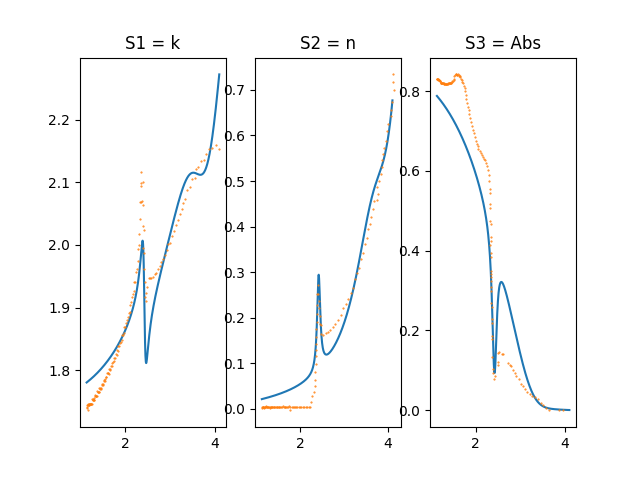

Text(0.5, 1.0, 'S3 = Abs')

In [36]:
#Plot the guess vs the fit and the data

energy_min = np.amax([np.amin(energy_S1),np.amin(energy_S2)])
energy_max = np.amin([np.amax(energy_S1),np.amax(energy_S2)])
energy_grid = np.linspace(energy_min,energy_max,1000)


fig2, ax =  plt.subplots(1,3)
ax[0].plot(energy_grid,f_S1(energy_grid, np.real(DF(energy_grid,xf[1] ,xf[2:],N_osc)), np.imag(DF(energy_grid,xf[1] ,xf[2:],N_osc))),label='fit')
ax[0].plot(energy_S1,S_1[:,1],'.',markersize = 1,label='fit')
ax[1].plot(energy_grid,f_S2(energy_grid, np.real(DF(energy_grid,xf[1] ,xf[2:],N_osc)), np.imag(DF(energy_grid,xf[1] ,xf[2:],N_osc))),label='fit')
ax[1].plot(energy_S2,S_2[:,1],'.',markersize = 1,label='fit')
ax[2].plot(energy_grid,f_S3(energy_grid, np.real(DF(energy_grid,xf[1] ,xf[2:],N_osc)), np.imag(DF(energy_grid,xf[1] ,xf[2:],N_osc)),xf[0]),label='fit')
ax[2].plot(energy_S3,S_3[:,1],'.',markersize = 1,label='fit')
ax[0].set_title('S1 = k')
ax[1].set_title('S2 = n')
ax[2].set_title('S3 = Abs')



In [37]:
#Define variational diabolical oscillator based on A. B. Kuzmenko et al. https://doi.org/10.1063/1.1979470


def g_1(a,b):
    return np.piecewise(a, [a!= -b,a==-b],
                        [lambda a: ((a+b)*np.log(np.abs(a+b))) ,0])

def g(a,b):
    return g_1(a,b) + g_1(a,-b)

def diabolical_osc_re(w,wc,delta):
    return np.piecewise(w, [w!= wc],
                        [lambda w: -((1/np.pi)*((g(w,wc-delta)/(delta)) - (((2*delta)*g(w,wc))/((delta)*(delta))) + (g(w,wc+delta)/delta)))])

def diabolical_osc_im(w,wc,delta):
    return np.piecewise(w,[np.logical_and((wc) <= w ,w <= (wc+ delta)),
                           np.logical_and((wc-delta) < w ,w < (wc)),
                           np.logical_and((wc-delta) > w ,w > (wc+delta))],
                           [lambda w:(wc+ delta - w)/(delta),
                            lambda w:(w-(wc-delta))/(delta),
                            lambda w:0])

def diabolical_osc(w,wc,delta):
    return 1+ diabolical_osc_re(w,wc,delta) + 1j*diabolical_osc_im(w,wc,delta)    

In [38]:
#Find size of the energy grid so that you have less than half the number of variational oscillators compared to data points

print('Size of the energy data grid is =',energy_S1.shape[0])

Size of the energy data grid is = 151


In [39]:
#Implement total variational dielectric function 

energy_min = np.amax([np.amin(energy_S1),np.amin(energy_S2)])
energy_max = np.amin([np.amax(energy_S1),np.amax(energy_S2)])
energy_grid = np.linspace(energy_min,energy_max,1000)

#Number of oscillators (usually a good bet is slightly less than half the number of experimental points)
N_var_osc = 40

#Spacing between oscillators (set so the oscillators span all data points) - this is fixed and not optimised in the fit

#NOTE:May need optimising

delta = (energy_max - energy_min)/(N_var_osc)

#Energy grid ocillators sit on

wc = np.linspace(min(energy_grid )+ delta/2,max(energy_grid )- delta/2,N_var_osc)

#Using residuals from coarse fit to inialise the grid

#Pick a single spectrum (or add spectra to be added later)

residuals = S_1[:,1] - f_S1(energy_S1, np.real(DF(energy_S1,xf[1] ,xf[2:],N_osc)), np.imag(DF(energy_S1,xf[1] ,xf[2:],N_osc)))

#Interpolate the residuals onto the energy grid used for the diabolical oscillators
A_0_interp = interp1d(energy_S1,residuals,kind='linear') #Creates interpolated function
A_0 = A_0_interp(wc) #Creates interpolated residual dataset

#Choose as you please based on where the residuals are pulled from
A_0 = A_0



def DiabolicalDF(w,A,wc,delta,N_var_osc):
    i=0
    x = np.zeros(np.shape(w)[0])
    while i<N_var_osc:
        x = x+ A[i]*diabolical_osc(w,wc[i],delta)
        i=i+1
    return x 


#Used to define the Jacobian analytically - much much faster with this


# def derivTotalVariational(A,data_k,delta,wc):
#     i=0
#     x = np.zeros(e_grid)
#     wc =wc
#     delta = delta
#     A = A
#     eps = DF(data_k[:,0],xf[0],xf[1:],N_osc) + DiabolicalDF(data_k[:,0],A,wc,delta,N_var_osc)
#     J=[]
#     IF_im =(np.imag(np.sqrt(eps)) - data_k[:,1])*np.imag(diabolical_osc(data_k[:,0],wc[i],delta)/np.sqrt(eps))
#     IF_re =(np.real(np.sqrt(eps)) - data_n[:,1])*np.real(diabolical_osc(data_k[:,0],wc[i],delta)/np.sqrt(eps))
#     while i<N_var_osc:
#         J_temp = IF_im + IF_re
#         J=np.append(J,J_temp)
#         i=i+1
#     J = np.asarray(J)
#     J = np.reshape(J,(N_var_osc,np.shape(w)[0]))
#     return np.transpose(J) 


#Set bounds for the variational oscillators as a fraction of total DF
eps_max = np.amax(np.imag(DF(energy_S1,xf[1] ,xf[2:],N_osc)))
f = np.inf #Can be adjusted
upper_bounds = np.tile(np.inf,N_var_osc)
lower_bounds = np.tile(-np.inf,N_var_osc)
bounds = np.asarray((lower_bounds,upper_bounds))



def residues_var(A,energy_S1,energy_S2,energy_S3,S_1,S_2,S_3,wc,delta,N_var_osc):
    #Define the Total DF on each energy grid
    eps_S1 = DF(energy_S1,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_S1,A,wc,delta,N_var_osc)
    eps_S2 = DF(energy_S2,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_S2,A,wc,delta,N_var_osc)
    eps_S3 = DF(energy_S3,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_S3,A,wc,delta,N_var_osc)
    f1 = f_S1(energy_S1, np.real(eps_S1), np.imag(eps_S1))
    f2 = f_S2(energy_S2, np.real(eps_S2), np.imag(eps_S2))
    f3 = f_S3(energy_S3, np.real(eps_S3), np.imag(eps_S3),xf[0])
    res = np.append((f1 - S_1),(f2 - S_2))
    res = np.append(res,(f3 - S_3)/10)
    #res = (f3 - S_3)
    #res = np.nan_to_num(res)
    return res
    

#To be used if Jac defined analytically
#Af = optimize.least_squares(residues_var,A_0,method = 'lm',jac = derivTotalVariationalnk, args=(k_static,n_static,delta,wc),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=2)


Af = optimize.least_squares(residues_var,A_0,args=(energy_S1,energy_S2,energy_S3,S_1[:,1],S_2[:,1],S_3[:,1],wc,delta,N_var_osc),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=2)




   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7025e-01                                    1.20e+00    
       1              2         1.2732e-01      1.43e-01       2.55e-01       1.22e-01    
       2              3         4.1668e-02      8.57e-02       5.03e-01       3.03e-02    
       3              4         3.4183e-02      7.48e-03       2.43e-01       4.49e-04    
       4              5         3.4182e-02      6.60e-07       2.09e-03       9.86e-06    
       5              6         3.4182e-02      1.75e-10       3.49e-05       2.05e-07    
       6              7         3.4182e-02      7.16e-14       6.95e-07       6.78e-09    
       7              9         3.4182e-02      1.53e-16       3.08e-08       7.95e-09    
       8             10         3.4182e-02      1.18e-16       3.09e-08       8.03e-09    
       9             24         3.4182e-02      0.00e+00       0.00e+00       8.03e-09    

In [15]:
#Print amplitudes (fitting params) of the final oscillators
Af.x

array([-0.03674431, -0.03131968, -0.03990972, -0.05154856, -0.06201391,
       -0.08870966, -0.10166681, -0.10523906, -0.09857047, -0.07523079,
       -0.06371414, -0.05576602, -0.05747226, -0.07893395, -0.08696927,
       -0.23146686,  0.05390524, -0.03533652,  0.03139901,  0.31336093,
        0.24330731,  0.34014898,  0.33539115,  0.3239767 ,  0.28430817,
        0.27239127,  0.23028303,  0.19870707,  0.1642424 ,  0.10854615,
        0.04893989,  0.00039437, -0.05361345, -0.15836311, -0.30547628,
       -0.33744964, -0.35857821, -0.32863939, -0.23416141,  0.12136697])

<IPython.core.display.Javascript object>


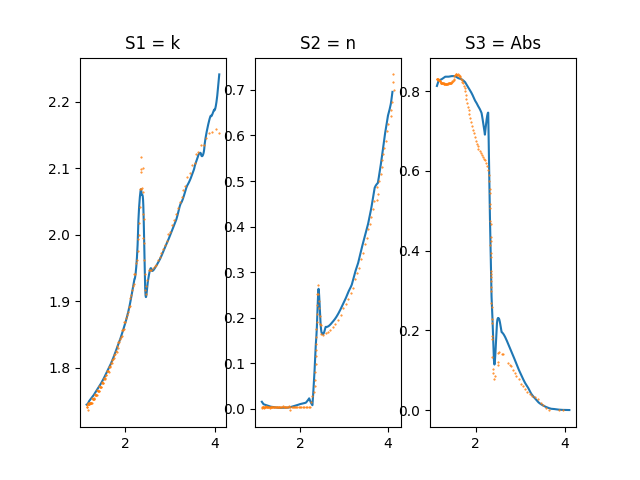

Text(0.5, 1.0, 'S3 = Abs')

In [41]:
#Plot the guess vs the fit and the data

eps_S1 = DF(energy_grid,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_grid,Af.x,wc,delta,N_var_osc)
eps_S2 = DF(energy_grid,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_grid,Af.x,wc,delta,N_var_osc)
eps_S3 = DF(energy_grid,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_grid,Af.x,wc,delta,N_var_osc)


fig2, ax =  plt.subplots(1,3)
ax[0].plot(energy_grid,f_S1(energy_grid, np.real(eps_S1), np.imag(eps_S1)),label='fit')
ax[0].plot(energy_S1,S_1[:,1],'.',markersize = 1,label='fit')
ax[1].plot(energy_grid,f_S2(energy_grid, np.real(eps_S2), np.imag(eps_S2)),label='fit')
ax[1].plot(energy_S2,S_2[:,1],'.',markersize = 1,label='fit')
ax[2].plot(energy_grid,f_S3(energy_grid, np.real(eps_S3), np.imag(eps_S3),xf[0]),label='fit')
ax[2].plot(energy_S3,S_3[:,1],'.',markersize = 1,label='fit')
ax[0].set_title('S1 = k')
ax[1].set_title('S2 = n')
ax[2].set_title('S3 = Abs')



<IPython.core.display.Javascript object>


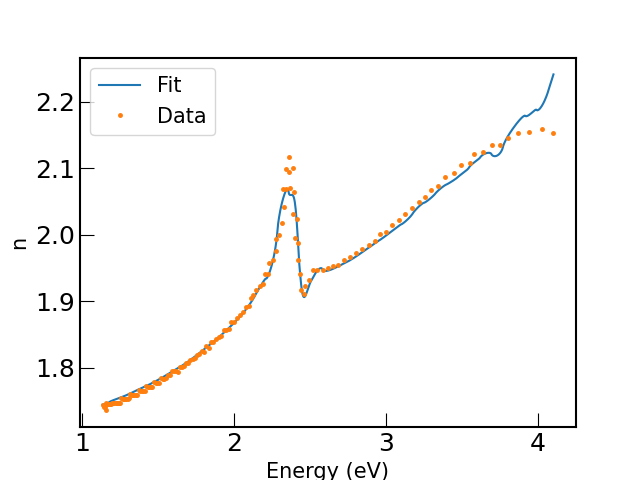

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


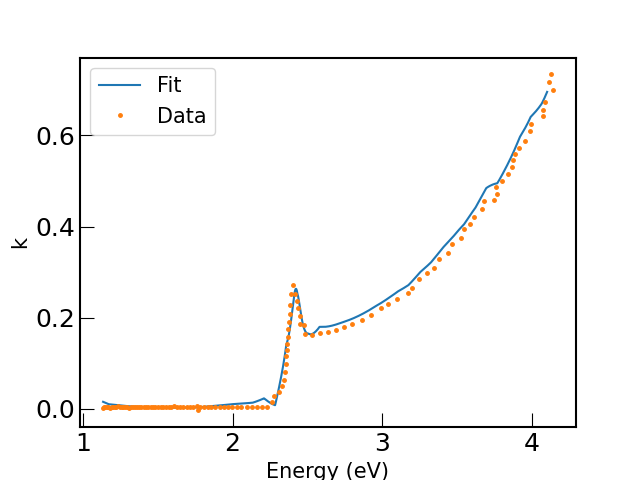

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


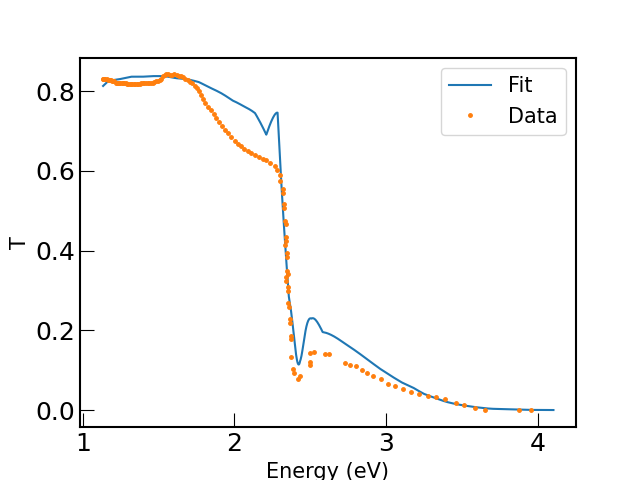

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [60]:
fig1=plt.figure()
ax = fig1.add_subplot(111)
ax.plot(energy_grid,f_S1(energy_grid, np.real(eps_S1), np.imag(eps_S1)),label='Fit')
ax.plot(energy_S1,S_1[:,1],'.',markersize = 5,label='Data')
ax.set_ylabel('n',fontsize = 15)
ax.set_xlabel('Energy (eV)',fontsize = 15)
ax.legend(fontsize = 15)
ax.tick_params(axis='both',labelsize=18,direction='in',length=10)
plt.setp(ax.spines.values(), linewidth=1.5)
plt.savefig('nfit.eps', format='eps', dpi=200,transparent=True)


fig1=plt.figure()
ax = fig1.add_subplot(111)
ax.plot(energy_grid,f_S2(energy_grid, np.real(eps_S2), np.imag(eps_S2)),label='Fit')
ax.plot(energy_S2,S_2[:,1],'.',markersize = 5,label='Data')
ax.set_ylabel('k',fontsize = 15)
ax.set_xlabel('Energy (eV)',fontsize = 15)
ax.legend(fontsize = 15)
ax.tick_params(axis='both',labelsize=18,direction='in',length=10)
plt.setp(ax.spines.values(), linewidth=1.5)
plt.savefig('kfit.eps', format='eps', dpi=200,transparent=True)

fig1=plt.figure()
ax = fig1.add_subplot(111)
ax.plot(energy_grid,f_S3(energy_grid, np.real(eps_S3), np.imag(eps_S3),xf[0]),label='Fit')
ax.plot(energy_S3,S_3[:,1],'.',markersize = 5,label='Data')
ax.set_ylabel('T',fontsize = 15)
ax.set_xlabel('Energy (eV)',fontsize = 15)
ax.legend(fontsize = 15)
ax.tick_params(axis='both',labelsize=18,direction='in',length=10)
plt.setp(ax.spines.values(), linewidth=1.5)
plt.savefig('absfit.eps', format='eps', dpi=200,transparent=True)


# Fit TA

In [78]:
#Load the TA data

h = 6.62e-34
c = 3e8
e = 1.6e-19

TA_timeslice = np.loadtxt('CsPbBr3/TA_data.txt')

#energy_TA = TA_timeslice[:,0]/8065.6 #converts to eV from cm^-1 

energy_TA = TA_timeslice[0,1:] #converts to eV from nm I think


#Choose time point to fit

t_supervised=30

TA_data = TA_timeslice[1+t_supervised,1:]


print('Time =', TA_timeslice[1+t_supervised,0], 'fs')

Time = 5e-13 fs


<IPython.core.display.Javascript object>


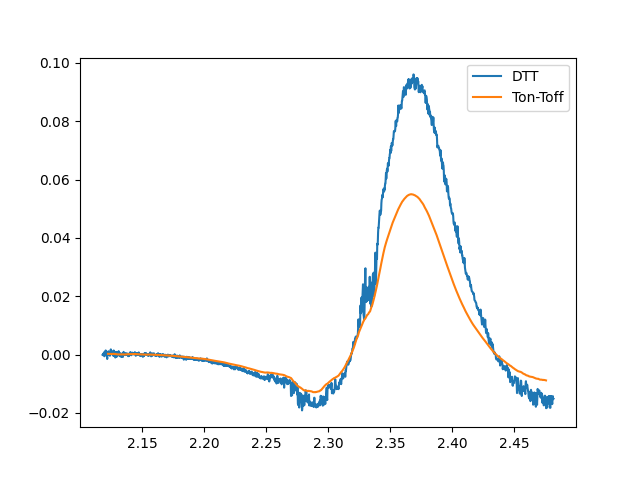

In [79]:
#Convert DTT to dT

#Calculate the T_static data


T_off = f_S3(energy_TA,np.real(DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)),np.imag(DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)),xf[0]/4)
TA_data_orig = TA_data
energy_TA_orig = energy_TA
TA_data =  TA_data*T_off

N=50

TA_data = np.convolve(TA_data, np.ones((N,))/N, mode='valid')
energy_TA = np.convolve(energy_TA, np.ones((N,))/N, mode='valid')

plt.figure()
plt.plot(energy_TA_orig,TA_data_orig,label = 'DTT')
plt.plot(energy_TA,TA_data,label = 'Ton-Toff')
plt.legend()
plt.show()



In [83]:
xf[0]

5670.000063903852

In [81]:
#initialise guess as 0s before we start fitting or load previous guess
N_osc_dtt = 2
c_guess_dtt = [0] * (N_osc_dtt*3 )
#c_guess_dtt = np.append(xf_dtt, np.asarray([0,0,0]))
c_guess_dtt = np.load('CsPbBr3_dtt_bestguess.npy')

#This is from reffit
# c_guess_dtt = np.asarray([-29691/8065.6,14683,517.97,(1001.5**2)/8065.6,17624,7834.4,8.5677e5/8065.6,17555,6152.6,(53**2)/8065.6,16194,387.78])
# c_guess_dtt = np.asarray([-29691/8065.6,14683,517.97,(1001.5**2)/8065.6,17624,7834.4,-8.5677e5/8065.6,17555,6152.6,(53**2)/8065.6,16194,387.78])
# c_guess_dtt = c_guess_dtt/8065.6

d = xf[0]/4
n = 1
c = 137.036





<IPython.core.display.Javascript object>


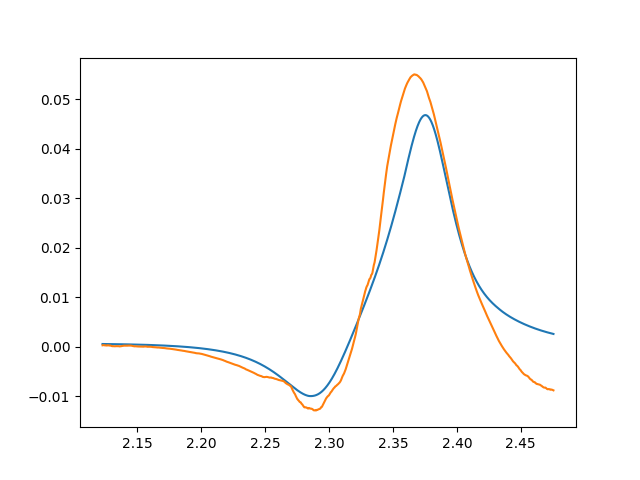

Controlling Oscillator number  2


interactive(children=(FloatSlider(value=-0.02556, description='wp', max=0.05, min=-0.05, step=1e-05), FloatSli…

<function __main__.update(wp=FloatSlider(value=-0.02556, description='wp', max=0.05, min=-0.05, step=1e-05), w0=FloatSlider(value=2.37771, description='w0', max=2.6, min=2.05, step=1e-05), g=FloatSlider(value=0.05623, description='g', max=0.4, step=1e-05))>

In [82]:
#Fit initial fit guess by hand

e_grid = energy_TA.shape[0]   #Set this to the number of data point you measured

e_min=np.amin(energy_TA)
e_max=np.amax(energy_TA)

#Set the base dielectric function array

w=np.linspace(e_min,e_max,e_grid)

#Define final fit dielectric function

eps_base = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)
eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)
eps_base_w = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)

#Set max and min for sliders #NOTE: Will be incorporated into bounds for fitting later
wp_min=-.05
wp_max=.05
w0_min =2.05
w0_max =2.6
g_min = 0
g_max = .4

#Initialise parameters

i=0
params_init=[]
while i<N_osc_dtt:
    params_init_temp = [wp_min,np.linspace(w0_min,w0_max,N_osc_dtt)[i],g_min]
    params_init = np.append(params_init,params_init_temp)
    i=i+1
    
prams_init = c_guess_dtt

#c_guess_dtt is a list of parameters of size 3*N_osc_dtt (three params per oscillator)
#c_guess_dtt is indexed such that [wp_0,w0_0,g_0,wp_1,w0_1,g_1 ... ,wp_n,w0_n,g_n] for n+1 oscillators
#Note that before fitting routine, eps_inf appended to this array so c_guess_dtt[0] is eps_inf and c_guess_dtt[1:] is the old list


#Initialise slider

i=0
wp_slide=[]

while i<N_osc_dtt:
    wp_slide_temp = [wg.FloatSlider(min=wp_min,max=wp_max,step= .00001,value =c_guess_dtt[0+3*(i)]),wg.FloatSlider(min=w0_min,max=w0_max,step= .00001,value =c_guess_dtt[1+3*(i)]),wg.FloatSlider(min=g_min,max=g_max,step= .00001,value =c_guess_dtt[2+3*(i)])]
    wp_slide = np.append(wp_slide,wp_slide_temp)
    i=i+1


#Define the Lorentz Oscillation and Dielectic function as sum of oscillations etc

#IMPORTANT PLEASE NOTE
#Set wp^2 to wp so that we are allowed to have negative oscillators
def LorentzOsc_diff(w,wp,w0,g):
    return wp/(w0**2 - w**2 - 1j*w*g)


#Diff Dielectric function is a sum of oscillators 
def dDF(w,params,N_osc_dtt):
    i=0
    x = np.zeros(e_grid)
    wp=params[0::3]
    w0=params[1::3]
    g=params[2::3]
    while i<N_osc_dtt:
        x = x+LorentzOsc_diff(w,wp[i],w0[i],g[i])
        i=i+1
    return x


#Definining thin film TA Formula

def t(w,eps_re,eps_im,d): #complex reflection amplitude
    w = w/27.211
    return np.exp(1j*w/c*d*np.sqrt(eps_re +1j*eps_im))

def r(eps_re,eps_im): #complex transmission amplitude
    return (1 - np.sqrt(eps_re +1j*eps_im) )/(1 + np.sqrt(eps_re +1j*eps_im) )

c = 137.036

#Form u/v for Abs(4*sqrt(eps)/(1+sqrt(eps)^2) * exp(iasqrt(eps)))

def u(w,eps_re,eps_im,d):
    a = w*d/c/27.2114
    return 16*np.sqrt(eps_re**2+eps_im**2)*np.exp(-2*a*((eps_re**2+eps_im**2)**(1/float(4)))*(np.sin(0.5*np.arctan(eps_im/eps_re))))

def v(w,eps_re,eps_im,d):
    a = w*d/c/27.2114
    t1 = np.sqrt(eps_re**2+eps_im**2)*((np.sin(0.5*np.arctan(eps_im/eps_re)))**2)
    t2 = (1+ ((eps_re**2+eps_im**2)**(1/float(4)))*np.cos(0.5*np.arctan(eps_im/eps_re)))**2
    return (t1 + t2)**2

#Derivative of u wrt eps1
def du_1(w,eps_re,eps_im,d):
    a = w*d/c/27.2114
    t1 = (1/((eps_re**2+eps_im**2)**(float(3/2)))) * np.exp(-2*a*((eps_re**2+eps_im**2)**(1/float(4)))*(np.sin(0.5*np.arctan(eps_im/eps_re))))
    t2 = 16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3) * (np.cos(0.5*np.arctan(eps_im/eps_re)))
    t3 = (-16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re) * (np.sin(0.5*np.arctan(eps_im/eps_re)))) + 16*eps_re**3 + 16*eps_re*eps_im**2
    return t1*(t2+t3)


#Derivative of u wrt eps2
def du_2(w,eps_re,eps_im,d):
    a = w*d/c/27.2114
    t1 = 1/((eps_re**2+eps_im**2)**(float(3/2))) * np.exp(-2*a*((eps_re**2+eps_im**2)**(1/float(4)))*(np.sin(0.5*np.arctan(eps_im/eps_re))))
    t2 = -16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3) * (np.sin(0.5*np.arctan(eps_im/eps_re)))
    t3 = (-16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re) * (np.cos(0.5*np.arctan(eps_im/eps_re)))) + 16*eps_im*eps_re**2 + 16*eps_im**3
    return t1*(t2+t3)

#Derivative of v wrt eps1
def dv_1(w,eps_re,eps_im,d):
    a = w*d/c/27.2114
    t1 = 2/((eps_re**2+eps_im**2)**(float(7/4)))
    t2 = np.sqrt(eps_re**2+eps_im**2)*(np.sin(0.5*np.arctan(eps_im/eps_re)))**2 + np.sqrt(eps_re**2+eps_im**2)*(np.cos(0.5*np.arctan(eps_im/eps_re)))**2 
    t3 = 2*((eps_re**2+eps_im**2)**(1/float(4)))*np.cos(0.5*np.arctan(eps_im/eps_re)) + 1
    t4 = (eps_re**3 + eps_im**2*eps_re)*np.cos(0.5*np.arctan(eps_im/eps_re))
    t5 = ((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re)*((np.cos(0.5*np.arctan(eps_im/eps_re)))**2)
    t6 = np.sin(0.5*np.arctan(eps_im/eps_re))
    t7 = (eps_re**2*eps_im) + (((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re)*np.sin(0.5*np.arctan(eps_im/eps_re))) + eps_im**3
    return t1*(t2+t3)*(t4 + t5 + (t6*t7))

#Derivative of v wrt eps2
def dv_2(w,eps_re,eps_im,d):
    a = w*d/c/27.2114
    t1 = 2/((eps_re**2+eps_im**2)**(float(7/4)))
    t2 = np.sqrt(eps_re**2+eps_im**2)*(np.sin(0.5*np.arctan(eps_im/eps_re)))**2 + np.sqrt(eps_re**2+eps_im**2)*(np.cos(0.5*np.arctan(eps_im/eps_re)))**2 
    t3 = 2*((eps_re**2+eps_im**2)**(1/float(4)))*np.cos(0.5*np.arctan(eps_im/eps_re)) + 1
    t4 = (eps_re**2*eps_im + eps_im**3)*np.cos(0.5*np.arctan(eps_im/eps_re))
    t5 = ((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3)*((np.cos(0.5*np.arctan(eps_im/eps_re)))**2)
    t6 = np.sin(0.5*np.arctan(eps_im/eps_re))
    t7 = -(eps_re**3) + (((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3)*np.sin(0.5*np.arctan(eps_im/eps_re))) - eps_im**2*eps_re
    return t1*(t2+t3)*(t4 + t5 + (t6*t7))


#Variational Derivative of T wrt eps1 and eps2 

def dT(w,c_guess_dtt, eps_re, eps_im, n, d,N_osc_dtt):
    u_t = u(w,eps_re,eps_im,d)
    v_t = v(w,eps_re,eps_im,d)
    du_1_t = du_1(w,eps_re,eps_im,d)
    du_2_t = du_2(w,eps_re,eps_im,d)
    dv_1_t = dv_1(w,eps_re,eps_im,d)
    dv_2_t = dv_2(w,eps_re,eps_im,d)
    a1 = (v_t*du_1_t - u_t*dv_1_t)/(v_t**2) #Quotient rule
    a2 = (v_t*du_2_t - u_t*dv_2_t)/(v_t**2) #Quotient rule
    return a1*np.real(dDF(w,c_guess_dtt,N_osc_dtt)) + a2*np.imag(dDF(w,c_guess_dtt,N_osc_dtt))


#Sets up plot for the sliders
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line_TA, = ax.plot(w,dT(w,c_guess_dtt,np.real(DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)), np.imag(DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)), n, d,N_osc_dtt))                                                                                                                                
line_TA_data = ax.plot(energy_TA,TA_data)
#ax.set_ylim(-.01,0.01)

#This is where you select the oscillator to control in the slider. Change this to a value <= N_osc_dtt and run this bit of code to select a differnt oscillator 
osc_num = 2


i_wp=int(0+3*(osc_num-1))
i_w0=int(1+3*(osc_num-1))
i_g=int(2+3*(osc_num-1))


#Updates plot when sliders moved
def update(wp=wp_slide[i_wp],w0=wp_slide[i_w0],g=wp_slide[i_g]):
    line_TA.set_ydata(dT(w,c_guess_dtt,np.real(DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)), np.imag(DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)), n, d,N_osc_dtt))
    c_guess_dtt[i_wp] = wp
    c_guess_dtt[i_w0] = w0
    c_guess_dtt[i_g] =  g
    fig.canvas.draw_idle()



print('Controlling Oscillator number ', osc_num)   
wg.interact(update)







In [84]:
#Print out and manually save the guess before closing!
print(c_guess_dtt)
np.save('CsPbBr3_dtt_bestguess.npy',c_guess_dtt)

[ 0.01     2.29656  0.07548 -0.02556  2.37771  0.05623]


In [86]:
#LM Fitting Scheme (Coarse Fit)

#Define residues to be square of diff between Data and Formula for DTT
def residues_dtt(c_guess_dtt,TA_data,energy_TA,n,d,N_osc_dtt):
    return dT(energy_TA,c_guess_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt) - TA_data
    
#Definifing bounds on variables to be optimised based on bounds of sliders. Change those to change this
upper_bounds = np.tile([wp_max,w0_max,g_max],N_osc_dtt)

lower_bounds = np.tile([wp_min,w0_min,g_min],N_osc_dtt)

bounds = np.asarray((lower_bounds,upper_bounds))

#Note that before fitting routine, eps_inf appended to this array so c_guess[0] is eps_inf and c_guess[1:] is the old list
x0_dtt = c_guess_dtt

#Actual fitting routine, can play with the tolerence parameters etc
xf_dtt  = optimize.least_squares(residues_dtt ,x0_dtt , bounds=bounds,args=(TA_data,energy_TA,n,d,N_osc_dtt),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',max_nfev=1000,verbose=2)#,Dfun = dsqrtDF,col_deriv=1)

xf_dtt =xf_dtt.x  
    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8086e-02                                    6.96e-01    
       1              2         1.0989e-02      1.71e-02       1.08e-02       1.26e-01    
       2              3         9.8833e-03      1.11e-03       1.47e-02       1.32e-02    
       3              4         9.6914e-03      1.92e-04       8.03e-03       2.41e-03    
       4              5         9.6263e-03      6.51e-05       6.28e-03       1.19e-03    
       5              6         9.5896e-03      3.67e-05       4.90e-03       7.46e-04    
       6              7         9.5566e-03      3.31e-05       4.83e-03       8.29e-04    
       7              8         9.5102e-03      4.64e-05       5.68e-03       1.75e-03    
       8              9         9.4130e-03      9.72e-05       8.13e-03       8.94e-03    
       9             10         9.1819e-03      2.31e-04       1.18e-02       3.41e-02    

<IPython.core.display.Javascript object>


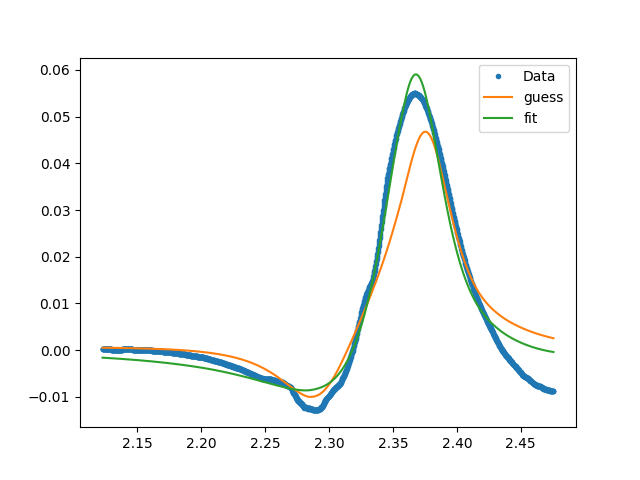

In [87]:
#Plot the guess vs the fit and the data


plt.figure()
plt.plot(energy_TA,TA_data,'.',label = 'Data')
plt.plot(energy_TA,dT(energy_TA,x0_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt),label='guess')
plt.plot(energy_TA,dT(energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt),label='fit')
plt.legend()
plt.show()



In [88]:
#Implement variational diabolical oscillator based on A. B. Kuzmenko et al. https://doi.org/10.1063/1.1979470

def g_1(a,b):
    return np.piecewise(a, [a!= -b,a==-b],
                        [lambda a: ((a+b)*np.log(np.abs(a+b))) ,0])

def g(a,b):
    return g_1(a,b) + g_1(a,-b)

def diabolical_osc_re(w,wc,delta):
    return np.piecewise(w, [w!= wc,w==wc],
                        [lambda w: -((1/np.pi)*((g(w,wc-delta)/(delta)) - (((2*delta)*g(w,wc))/((delta)*(delta))) + (g(w,wc+delta)/delta))),0])

def diabolical_osc_im(w,wc,delta):
    return np.piecewise(w,[np.logical_and((wc) <= w ,w <= (wc+ delta)),
                           np.logical_and((wc-delta) < w ,w < (wc)),
                           np.logical_and((wc-delta) > w ,w > (wc+delta))],
                           [lambda w:(wc+ delta - w)/(delta),
                            lambda w:(w-(wc-delta))/(delta),
                            lambda w:0])

def diabolical_osc(w,wc,delta):
    return 1+ diabolical_osc_re(w,wc,delta) + 1j*diabolical_osc_im(w,wc,delta)


def dT_var(A,energy_TA,xf_dtt,eps_re, eps_im,delta_dtt,n, d,N_osc_dtt,wc_dtt):
    deps = dDF(energy_TA,xf_dtt,N_osc_dtt) + dDiabolicalDF(energy_TA,A,wc_dtt,delta_dtt,N_var_osc_dtt) #Total dielectric function 
    u_t = u(energy_TA,eps_re,eps_im,d)
    v_t = v(energy_TA,eps_re,eps_im,d)
    du_1_t = du_1(energy_TA,eps_re,eps_im,d)
    du_2_t = du_2(energy_TA,eps_re,eps_im,d)
    dv_1_t = dv_1(energy_TA,eps_re,eps_im,d)
    dv_2_t = dv_2(energy_TA,eps_re,eps_im,d)
    a1 = (v_t*du_1_t - u_t*dv_1_t)/(v_t**2) #Quotient rule
    a2 = (v_t*du_2_t - u_t*dv_2_t)/(v_t**2) #Quotient rule
    return a1*np.real(deps) + a2*np.imag(deps)


In [89]:
#Find size of the energy grid so that you have less than half the number of variational oscillators compared to data points

print('Size of the energy data grid is =',energy_TA.shape[0])

Size of the energy data grid is = 1686


In [90]:
#Implement total variational dielectric function 

#Number of oscillators (usually a good bet is slightly less than half the number of experimental points,i.e, energy_TA.shape[0] )
N_var_osc_dtt = 100
#Spacing between oscillators (set so the oscillators span all data points) - this is fixed and not optimised in the fit
#NOTE:May need optimising
delta_dtt = (max(energy_TA) - min(energy_TA))/(N_var_osc_dtt)
#Energy grid ocillators sit on
wc_dtt = np.linspace(min(energy_TA)+ delta_dtt/2,max(energy_TA)- delta_dtt/2,N_var_osc_dtt)

#Using residuals from coarse fit to inialise the grid
residuals = TA_data - dT(energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt)
#Interpolate the residuals onto the energy grid used for the diabolical oscillators
A_0_interp = interp1d(energy_TA,residuals,kind='linear') #Creates interpolated function
A_0_dtt = A_0_interp(wc_dtt) #Creates interpolated residual dataset

#Choose as you please
A_0_dtt= (A_0_dtt)


def dDiabolicalDF(w,A,wc_dtt,delta_dtt,N_var_osc_dtt):
    i=0
    x = np.zeros(e_grid)
    while i<N_var_osc_dtt:
        x = x+ A[i]*diabolical_osc(w,wc_dtt[i],delta_dtt)
        i=i+1
    return x 


#Used to define the Jacobian analytically - much much faster with this


# def derivTotalVariational(A,data_k,delta_dtt,wc):
#     i=0
#     x = np.zeros(e_grid)
#     wc =wc
#     delta_dtt = delta_dtt
#     A = A
#     eps = DF(data_k[:,0],xf[0],xf[1:],N_osc) + DiabolicalDF(data_k[:,0],A,wc,delta_dtt,N_var_osc_dtt)
#     J=[]
#     IF_im =(np.imag(np.sqrt(eps)) - data_k[:,1])*np.imag(diabolical_osc(data_k[:,0],wc[i],delta_dtt)/np.sqrt(eps))
#     IF_re =(np.real(np.sqrt(eps)) - data_n[:,1])*np.real(diabolical_osc(data_k[:,0],wc[i],delta_dtt)/np.sqrt(eps))
#     while i<N_var_osc_dtt:
#         J_temp = IF_im + IF_re
#         J=np.append(J,J_temp)
#         i=i+1
#     J = np.asarray(J)
#     J = np.reshape(J,(N_var_osc_dtt,np.shape(w)[0]))
#     return np.transpose(J) 



def residues_var(A,energy_TA,xf_dtt,eps_re, eps_im,delta_dtt,n, d,N_osc_dtt,wc_dtt):
    dT = dT_var(A,energy_TA,xf_dtt,eps_re, eps_im,delta_dtt,n, d,N_osc_dtt,wc_dtt)
    return (dT - TA_data)

#Bounds
# deps_max = np.amax(np.imag(dDF(w,xf_dtt,N_osc)))
# f = 1 #Can be adjusted
# upper_bounds = np.tile(f*deps_max,N_var_osc_dtt)
# lower_bounds = np.tile(-f*deps_max,N_var_osc_dtt)
# bounds = np.asarray((lower_bounds,upper_bounds))
    

#To be used if Jac defined analytically
#Af = optimize.least_squares(residues_var,A_0,method = 'lm',jac = derivTotalVariationalnk, args=(k_static,n_static,delta_dtt,wc),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=2)


Af_dtt = optimize.least_squares(residues_var,A_0_dtt,args=(energy_TA,xf_dtt,np.real(eps_base_eTA),np.imag(eps_base_eTA),delta_dtt,n,d,N_osc_dtt,wc_dtt),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=2)



   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3673e-02                                    4.73e-02    
       1              2         8.2652e-03      5.41e-03       3.28e-02       3.45e-02    
       2              3         1.6514e-03      6.61e-03       6.62e-02       1.61e-02    
       3              4         2.7622e-05      1.62e-03       5.55e-02       8.07e-11    
       4              5         2.7622e-05      5.76e-20       3.11e-10       2.35e-12    
       5             15         2.7622e-05      0.00e+00       0.00e+00       2.35e-12    
`xtol` termination condition is satisfied.
Function evaluations 15, initial cost 1.3673e-02, final cost 2.7622e-05, first-order optimality 2.35e-12.


<IPython.core.display.Javascript object>


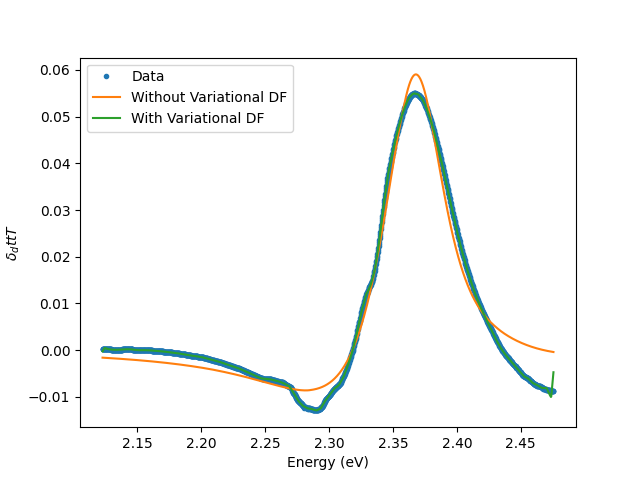

In [91]:
#Define final fit dielectric function

#output dT final (should be in a function)

plt.figure()
plt.plot(energy_TA,TA_data,'.',label ='Data')
plt.plot(energy_TA,dT(energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt),label='Without Variational DF')
plt.plot(energy_TA,dT_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt),label='With Variational DF')
plt.legend()
plt.ylabel('$\delta_dtt T$')
plt.xlabel('Energy (eV)')
plt.show()



<IPython.core.display.Javascript object>


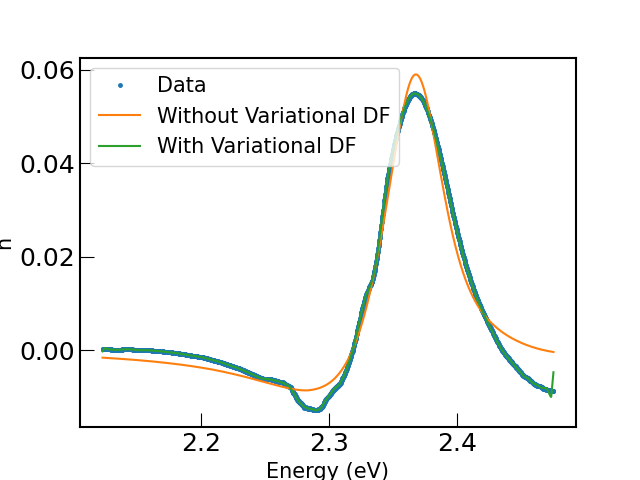

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [92]:
fig1=plt.figure()
ax = fig1.add_subplot(111)
ax.plot(energy_TA,TA_data,'.',markersize = 5,label='Data')
ax.plot(energy_TA,dT(energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt),label='Without Variational DF')
ax.plot(energy_TA,dT_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt),label='With Variational DF')
ax.set_ylabel('n',fontsize = 15)
ax.set_xlabel('Energy (eV)',fontsize = 15)
ax.legend(fontsize = 15)
ax.tick_params(axis='both',labelsize=18,direction='in',length=10)
plt.setp(ax.spines.values(), linewidth=1.5)
plt.savefig('dttfit.eps', format='eps', dpi=200,transparent=True)

In [93]:
#Define dn and deps of the final fit

def dn_var(A,energy_TA,xf_dtt,eps_re, eps_im,delta_dtt,n, d,N_osc_dtt,wc_dtt):
    deps = dDF(energy_TA,xf_dtt,N_osc_dtt) + dDiabolicalDF(energy_TA,A,wc_dtt,delta_dtt,N_var_osc_dtt) 
    dn = (1/(2*np.sqrt(eps_re + 1j*eps_im)))*deps
    return dn

def deps_var(A,energy_TA,xf_dtt,eps_re, eps_im,delta_dtt,n, d,N_osc_dtt,wc_dtt):
    deps = dDF(energy_TA,xf_dtt,N_osc_dtt) + dDiabolicalDF(energy_TA,A,wc_dtt,delta_dtt,N_var_osc_dtt) 
    return deps
    
    




<IPython.core.display.Javascript object>


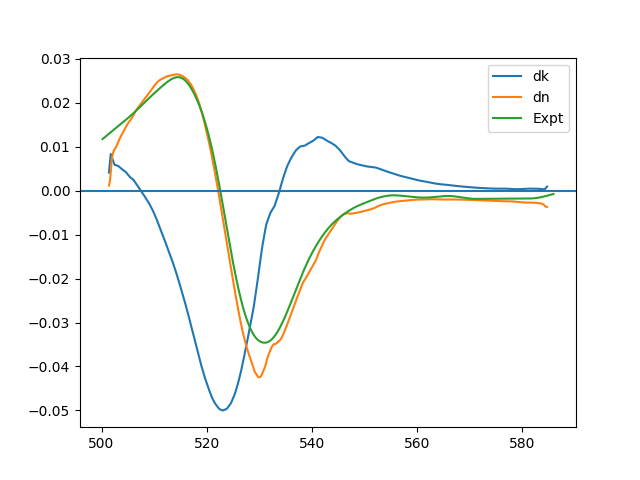

In [94]:
#Import Experimental Data
dn_expt = np.loadtxt('CsPbBr3/dn_data.txt')


#Plot and compare dn and dk
plt.figure()
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.imag(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='dk')
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.real(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='dn')
plt.plot((h*3e8)/(e*1e-9*dn_expt[0,1:]),dn_expt[1,1:],label ='Expt')
plt.axhline(y=0)
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


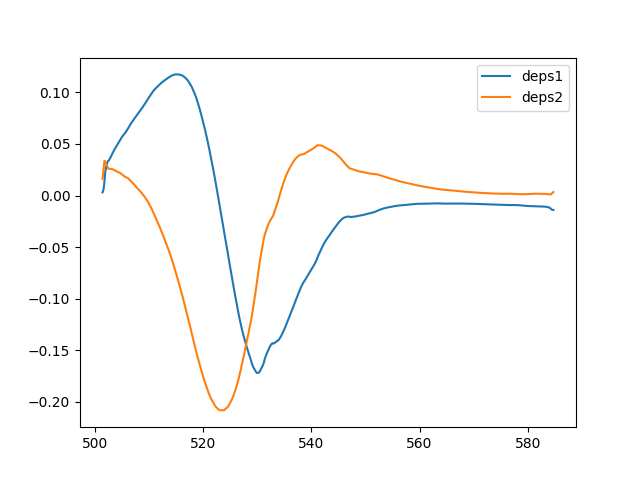

In [95]:
#Plot and compare deps1 and deps2

plt.figure()
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.real(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='deps1')
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.imag(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='deps2')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


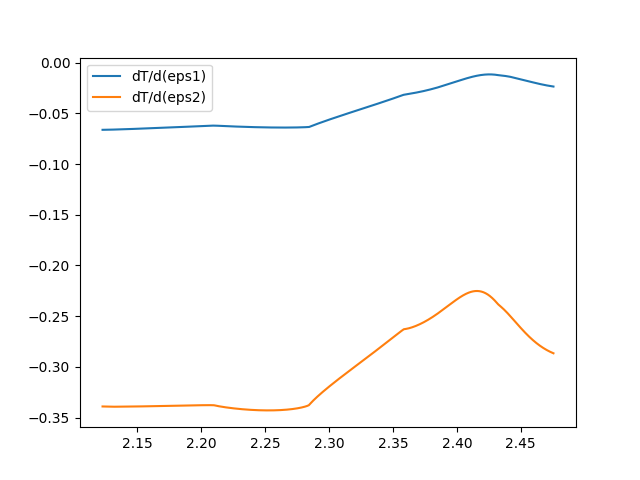

<IPython.core.display.Javascript object>


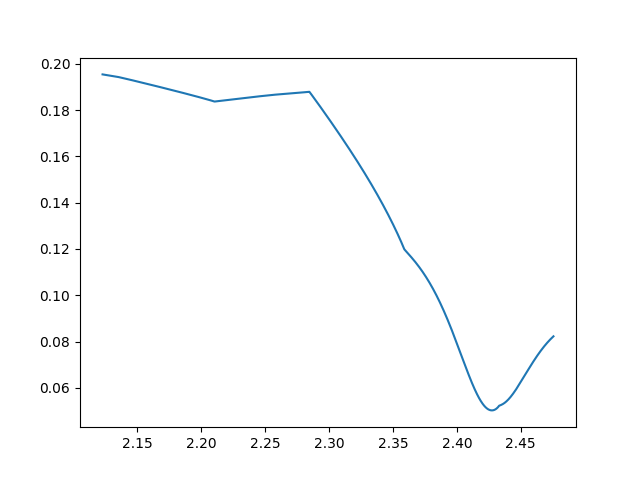

In [96]:
#Visualise sensitivities/derivatives of dT with respect to eps1 and eps2

eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)
eps_base_w = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)

u_t = u(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
v_t = v(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
du_1_t = du_1(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
du_2_t = du_2(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
dv_1_t = dv_1(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
dv_2_t = dv_2(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
a1 = (v_t*du_1_t - u_t*dv_1_t)/(v_t**2) #Quotient rule
a2 = (v_t*du_2_t - u_t*dv_2_t)/(v_t**2)


plt.figure()
plt.plot(energy_TA,a1,label = 'dT/d(eps1)')
plt.plot(energy_TA,a2,label = 'dT/d(eps2)')

plt.legend()


plt.figure()
plt.plot(energy_TA, a1/a2)
plt.show()

<IPython.core.display.Javascript object>


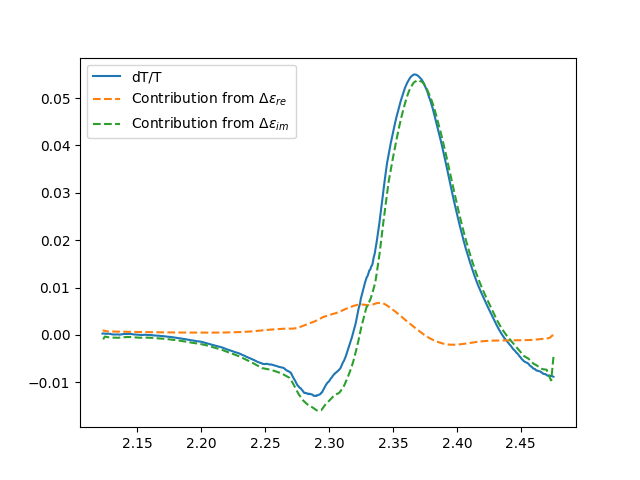

In [97]:
#Visualise contribution of deps1 and deps2 to dTT

plt.figure()
plt.plot(energy_TA, TA_data,label ='dT/T')
plt.plot(energy_TA, a1*np.real(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),linestyle ='--',label = 'Contribution from $\Delta \epsilon_{re}$')
plt.plot(energy_TA, a2*np.imag(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),linestyle ='--',label = 'Contribution from $\Delta \epsilon_{im}$ ')
plt.legend()
plt.show()





<IPython.core.display.Javascript object>


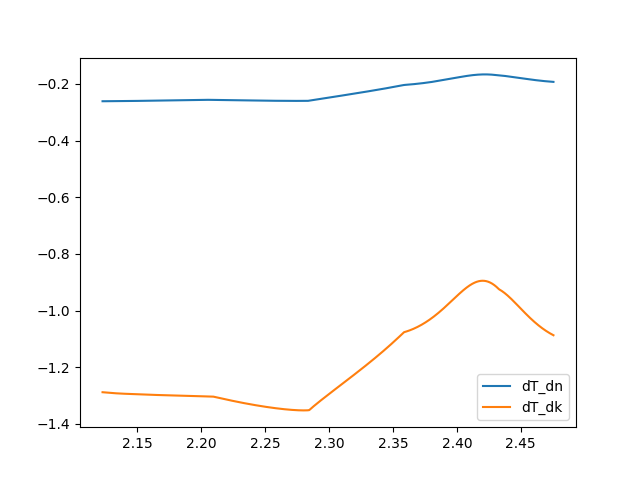

In [98]:
#Define dT/dn and dT/dk 

def dT_dn(w,eps_re,eps_im,d):
    a = w*d/c/27.2114
    n = np.real(np.sqrt(eps_re+1j*eps_im))
    k = np.imag(np.sqrt(eps_re+1j*eps_im))
    t1 = -32*np.exp(-2*a*k)
    t2 = n**3 + 2*k**2 + n*(-1 + k**2)
    t3 = (1+ 2*n + n**2 + k**2)**3
    return (t1*t2)/t3


def dT_dk(w,eps_re,eps_im,d):
    a = w*d/c/27.2114
    n = np.real(np.sqrt(eps_re+1j*eps_im))
    k = np.imag(np.sqrt(eps_re+1j*eps_im))
    t1 = -32*np.exp(-2*a*k)
    t2 = k*(-1-2*n + n**2 + k**2)
    t3 = a*(2*(n**3) + n**4 + k**2 + 2*n*(k**2) + k**4 + (n**2)*(1+2*(k**2)))
    t4 = (1+ 2*n + n**2 + k**2)**3
    return (t1*(t2 + t3))/t4

a1_dT_dn = dT_dn(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
a1_dT_dk = dT_dk(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)



plt.figure()
plt.plot(energy_TA,a1_dT_dn,label = 'dT_dn')
plt.plot(energy_TA,a1_dT_dk,label = 'dT_dk')
plt.legend()
plt.show()

In [99]:
#Define dR and R

def dR_dn(w,eps_re,eps_im,d):
    n = np.real(np.sqrt(eps_re+1j*eps_im))
    k = np.imag(np.sqrt(eps_re+1j*eps_im))
    t1 = 4*(-1 + n**2 - k**2)
    t2 = (1+2*n + n**2 + k**2)**2
    return t1/t2


def dR_dk(w,eps_re,eps_im,d):
    n = np.real(np.sqrt(eps_re+1j*eps_im))
    k = np.imag(np.sqrt(eps_re+1j*eps_im))
    t1 = 8*n*k
    t2 = (1+2*n + n**2 + k**2)**2
    return t1/t2



def R(w,eps_re,eps_im,d):
    r = (1 - np.sqrt(eps_re +1j*eps_im) )/(1 + np.sqrt(eps_re +1j*eps_im))
    return np.abs(r)**2


a1_dR_dn = dR_dn(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
a1_dR_dk = dR_dk(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)

dR1 = a1_dR_dn*np.real(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt))
dR2 = a1_dR_dk*np.imag(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt))
dR = dR1 + dR2

R_static = R(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)

<IPython.core.display.Javascript object>


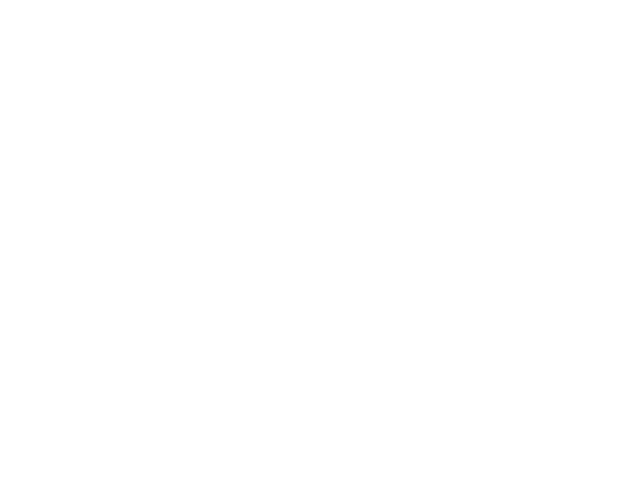

NameError: name 'T_off_plot' is not defined

In [100]:
plt.figure()
plt.plot(energy_TA,T_off_plot )
plt.plot(energy_TA,R_static )

<IPython.core.display.Javascript object>


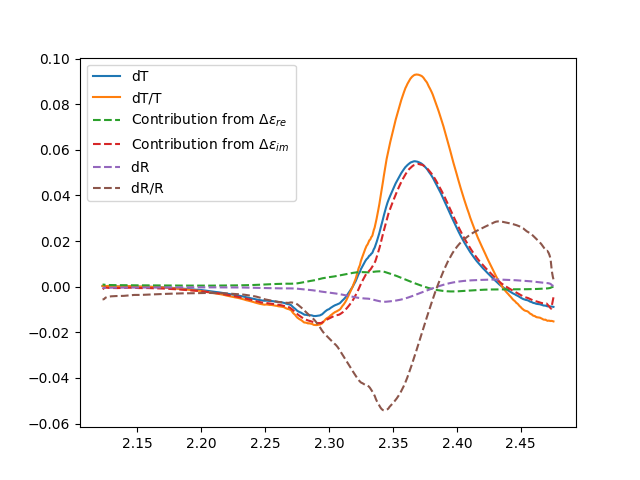

In [101]:
T_off_plot = np.convolve(T_off, np.ones((N,))/N, mode='valid')

plt.figure()
plt.plot(energy_TA,TA_data,label ='dT')
plt.plot(energy_TA,TA_data/T_off_plot,label ='dT/T')
#plt.plot(energy_TA, a1_dT_dn*np.real(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),linestyle ='--',label = 'Contribution from $\Delta n$')
#plt.plot(energy_TA, a1_dT_dk*np.imag(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),linestyle ='--',label = 'Contribution from $\Delta k$ ')
plt.plot(energy_TA, a1*np.real(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),linestyle ='--',label = 'Contribution from $\Delta \epsilon_{re}$')
plt.plot(energy_TA, a2*np.imag(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),linestyle ='--',label = 'Contribution from $\Delta \epsilon_{im}$ ')
plt.plot(energy_TA, dR,linestyle ='--',label = 'dR ')
plt.plot(energy_TA, dR/(R_static),linestyle ='--',label = 'dR/R ')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


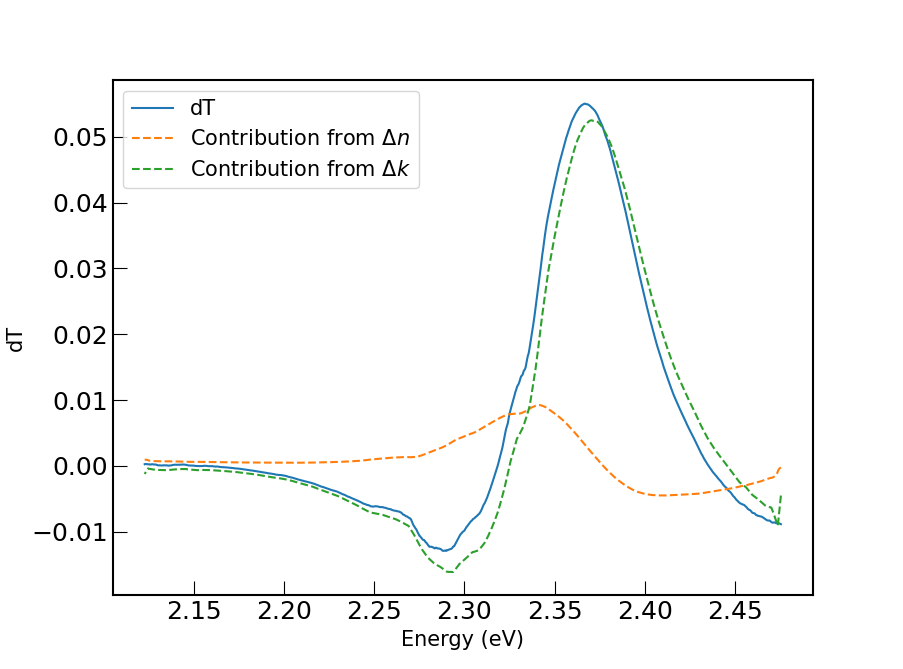

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [107]:
fig1=plt.figure()
ax = fig1.add_subplot(111)
ax.plot(energy_TA,TA_data,label ='dT')
ax.plot(energy_TA, a1_dT_dn*np.real(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),linestyle ='--',label = 'Contribution from $\Delta n$')
ax.plot(energy_TA, a1_dT_dk*np.imag(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),linestyle ='--',label = 'Contribution from $\Delta k$ ')
ax.set_ylabel('dT',fontsize = 15)
ax.set_xlabel('Energy (eV)',fontsize = 15)
ax.legend(fontsize = 15)
ax.tick_params(axis='both',labelsize=18,direction='in',length=10)
plt.setp(ax.spines.values(), linewidth=1.5)
plt.savefig('contributionfromdn.eps', format='eps', dpi=200,transparent=True)

<IPython.core.display.Javascript object>


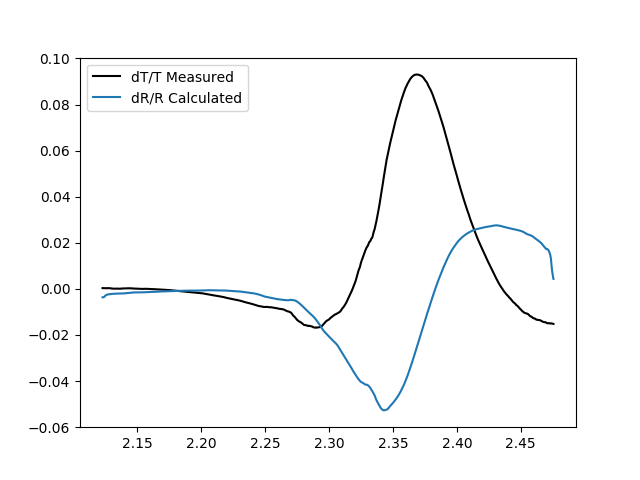

In [58]:
#dTT and dRR

plt.figure()
plt.plot(energy_TA,TA_data/T_off_plot,c = 'black',label ='dT/T Measured')
plt.plot(energy_TA, dR/(R_static),label = 'dR/R Calculated')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


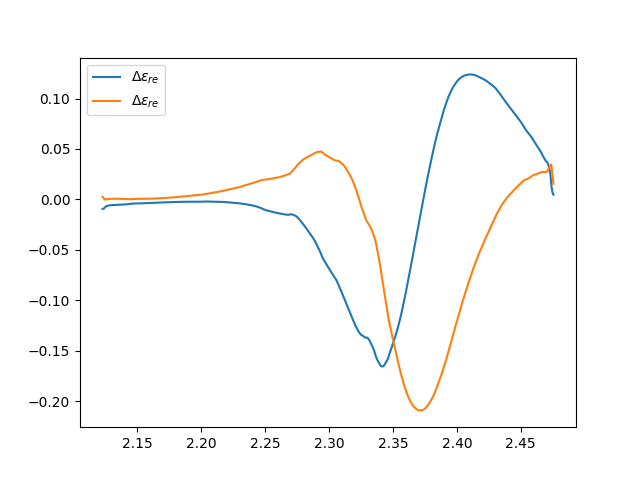

In [57]:
#deps1 and deps2

plt.figure()
plt.plot(energy_TA, np.real(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label = '$\Delta \epsilon_{re}$')
plt.plot(energy_TA, np.imag(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label = '$\Delta \epsilon_{re}$')
plt.legend()
plt.show()


In [59]:
#Save 

np.save('Fig2CsPbBr3_dTT_500fs',TA_data/T_off_plot)
np.save('Fig2CsPbBr3_dRR_500fs',dR/(R_static))
np.save('Fig2CsPbBr3_deps1_500fs',np.real(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))
np.save('Fig2CsPbBr3_deps2_500fs',np.imag(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))





<IPython.core.display.Javascript object>


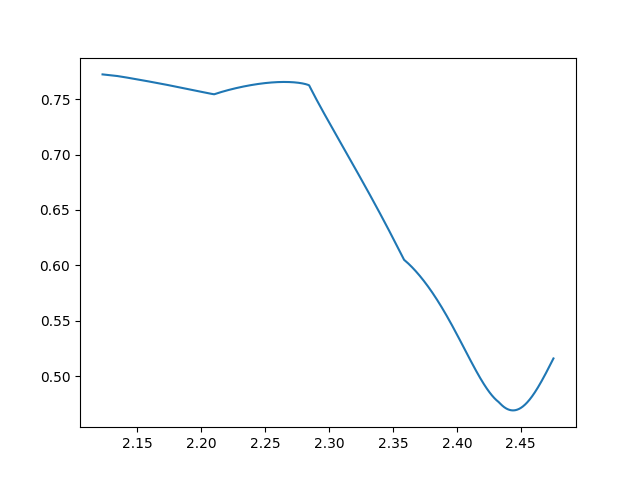

In [408]:
plt.figure()
plt.plot(energy_TA,f_S3(energy_TA,np.real(eps_base_eTA), np.imag(eps_base_eTA),d))
plt.show()

In [334]:
np.save('CsPbBr3_a1eps1_100nm_500fs',a1*np.real(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))

np.save('CsPbBr3_a2eps2_100nm_500fs',a2*np.imag(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))



In [336]:
np.save('Fig2CsPbBr3_dT_500fs',TA_data)
np.save('EnergyAxisFig2Pc_500fs',energy_TA)

# Loop over times

In [196]:
%matplotlib inline
import time
import pylab as pl
from IPython import display


#Setup the loop forwards in time 

h = 6.62e-34
c = 3e8
e = 1.6e-19

TA =np.loadtxt('CsPbBr3/TA_data.txt')

#energy_TA = TA_timeslice[:,0]/8065.6 #converts to eV from cm^-1 

energy_TA = TA[0,1:] #converts to eV from nm I think
time_TA = TA[1:,0]
TA_data_map = TA[1:,1:]

N_times = np.shape(time_TA)[0]

i=t_supervised #Set this to the timepoint fit above

#Coarse fit params
CF_params = []
VF_params = []

#OutputDF
deps_1_map = []
deps_2_map = []

#Output dn
dn_map = []
dk_map = []


#Load coarse supervised guess

x0_dtt = np.load('CsPbBr3_dtt_bestguess.npy')


#Go forward in time till the end 

while i<N_times:

    t=i
    
    TA_data = TA[1+t,1:]
    
    h = 6.62e-34
    c = 3e8
    e = 1.6e-19

    energy_TA = TA[0,1:]
    
    print('Doing time =',TA[(1+t),0], 'fs')
    
    d = xf[0]
    n = 1
    c = 137.036
    
    #Convert DTT to dT

    #Interpolate the T_static data
                 
    T_off = f_S3(energy_TA,np.real(DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)),np.imag(DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)),xf[0])
    TA_data_orig = TA_data
    energy_TA_orig = energy_TA
    TA_data =  TA_data*T_off

    N=50

    TA_data = np.convolve(TA_data, np.ones((N,))/N, mode='valid')
    energy_TA = np.convolve(energy_TA, np.ones((N,))/N, mode='valid')
    
    #Define DTT
    
    e_grid = energy_TA.shape[0]   #Set this to the number of data point you measured

    e_min=np.amin(energy_TA)
    e_max=np.amax(energy_TA)

    #Set the base dielectric function array

    w=np.linspace(e_min,e_max,e_grid)

    #Define final fit dielectric function

    eps_base = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)

    eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)

    eps_base_w = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)
                 
    #Set max and min for sliders #NOTE: Will be incorporated into bounds for fitting later
    wp_min=-.05
    wp_max=.05
    w0_min =2.05
    w0_max =2.6
    g_min = 0
    g_max = .4

    #Define the Lorentz Oscillation and Dielectic function as sum of oscillations etc

    #IMPORTANT PLEASE NOTE
    #Set wp^2 to wp so that we are allowed to have negative oscillators
    def LorentzOsc_diff(w,wp,w0,g):
        return wp/(w0**2 - w**2 - 1j*w*g)


    #Diff Dielectric function is a sum of oscillators 
    def dDF(w,params,N_osc_dtt):
        i=0
        x = np.zeros(e_grid)
        wp=params[0::3]
        w0=params[1::3]
        g=params[2::3]
        while i<N_osc_dtt:
            x = x+LorentzOsc_diff(w,wp[i],w0[i],g[i])
            i=i+1
        return x


    #Definining thin film TA Formula

    def t(w,eps_re,eps_im,d): #complex reflection amplitude
        w = w/27.211
        return np.exp(1j*w/c*d*np.sqrt(eps_re +1j*eps_im))

    def r(eps_re,eps_im): #complex transmission amplitude
        return (1 - np.sqrt(eps_re +1j*eps_im) )/(1 + np.sqrt(eps_re +1j*eps_im) )

    c = 137.036

    #Form u/v for Abs(4*sqrt(eps)/(1+sqrt(eps)^2) * exp(iasqrt(eps)))

    def u(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        return 16*np.sqrt(eps_re**2+eps_im**2)*np.exp(-2*a*((eps_re**2+eps_im**2)**(1/float(4)))*(np.sin(0.5*np.arctan(eps_im/eps_re))))

    def v(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        t1 = np.sqrt(eps_re**2+eps_im**2)*((np.sin(0.5*np.arctan(eps_im/eps_re)))**2)
        t2 = (1+ ((eps_re**2+eps_im**2)**(1/float(4)))*np.cos(0.5*np.arctan(eps_im/eps_re)))**2
        return (t1 + t2)**2

    #Derivative of u wrt eps1
    def du_1(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        t1 = (1/((eps_re**2+eps_im**2)**(float(3/2)))) * np.exp(-2*a*((eps_re**2+eps_im**2)**(1/float(4)))*(np.sin(0.5*np.arctan(eps_im/eps_re))))
        t2 = 16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3) * (np.cos(0.5*np.arctan(eps_im/eps_re)))
        t3 = (-16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re) * (np.sin(0.5*np.arctan(eps_im/eps_re)))) + 16*eps_re**3 + 16*eps_re*eps_im**2
        return t1*(t2+t3)


    #Derivative of u wrt eps2
    def du_2(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        t1 = 1/((eps_re**2+eps_im**2)**(float(3/2))) * np.exp(-2*a*((eps_re**2+eps_im**2)**(1/float(4)))*(np.sin(0.5*np.arctan(eps_im/eps_re))))
        t2 = -16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3) * (np.sin(0.5*np.arctan(eps_im/eps_re)))
        t3 = (-16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re) * (np.cos(0.5*np.arctan(eps_im/eps_re)))) + 16*eps_im*eps_re**2 + 16*eps_im**3
        return t1*(t2+t3)

    #Derivative of v wrt eps1
    def dv_1(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        t1 = 2/((eps_re**2+eps_im**2)**(float(7/4)))
        t2 = np.sqrt(eps_re**2+eps_im**2)*(np.sin(0.5*np.arctan(eps_im/eps_re)))**2 + np.sqrt(eps_re**2+eps_im**2)*(np.cos(0.5*np.arctan(eps_im/eps_re)))**2 
        t3 = 2*((eps_re**2+eps_im**2)**(1/float(4)))*np.cos(0.5*np.arctan(eps_im/eps_re)) + 1
        t4 = (eps_re**3 + eps_im**2*eps_re)*np.cos(0.5*np.arctan(eps_im/eps_re))
        t5 = ((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re)*((np.cos(0.5*np.arctan(eps_im/eps_re)))**2)
        t6 = np.sin(0.5*np.arctan(eps_im/eps_re))
        t7 = (eps_re**2*eps_im) + (((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re)*np.sin(0.5*np.arctan(eps_im/eps_re))) + eps_im**3
        return t1*(t2+t3)*(t4 + t5 + (t6*t7))

    #Derivative of v wrt eps2
    def dv_2(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        t1 = 2/((eps_re**2+eps_im**2)**(float(7/4)))
        t2 = np.sqrt(eps_re**2+eps_im**2)*(np.sin(0.5*np.arctan(eps_im/eps_re)))**2 + np.sqrt(eps_re**2+eps_im**2)*(np.cos(0.5*np.arctan(eps_im/eps_re)))**2 
        t3 = 2*((eps_re**2+eps_im**2)**(1/float(4)))*np.cos(0.5*np.arctan(eps_im/eps_re)) + 1
        t4 = (eps_re**2*eps_im + eps_im**3)*np.cos(0.5*np.arctan(eps_im/eps_re))
        t5 = ((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3)*((np.cos(0.5*np.arctan(eps_im/eps_re)))**2)
        t6 = np.sin(0.5*np.arctan(eps_im/eps_re))
        t7 = -(eps_re**3) + (((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3)*np.sin(0.5*np.arctan(eps_im/eps_re))) - eps_im**2*eps_re
        return t1*(t2+t3)*(t4 + t5 + (t6*t7))


    #Variational Derivative of T wrt eps1 and eps2 

    def dT(w,c_guess_dtt, eps_re, eps_im, n, d,N_osc_dtt):
        u_t = u(w,eps_re,eps_im,d)
        v_t = v(w,eps_re,eps_im,d)
        du_1_t = du_1(w,eps_re,eps_im,d)
        du_2_t = du_2(w,eps_re,eps_im,d)
        dv_1_t = dv_1(w,eps_re,eps_im,d)
        dv_2_t = dv_2(w,eps_re,eps_im,d)
        a1 = (v_t*du_1_t - u_t*dv_1_t)/(v_t**2) #Quotient rule
        a2 = (v_t*du_2_t - u_t*dv_2_t)/(v_t**2) #Quotient rule
        return a1*np.real(dDF(w,c_guess_dtt,N_osc_dtt)) + a2*np.imag(dDF(w,c_guess_dtt,N_osc_dtt))

    #Fit coarse
    
    def residues_dtt(c_guess_dtt,TA_data,energy_TA,n,d,N_osc_dtt):
        return dT(energy_TA,c_guess_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt) - TA_data
    
    #Definifing bounds on variables to be optimised based on bounds of sliders. Change those to change this
    upper_bounds = np.tile([wp_max,w0_max,g_max],N_osc_dtt)

    lower_bounds = np.tile([wp_min,w0_min,g_min],N_osc_dtt)

    bounds = np.asarray((lower_bounds,upper_bounds))

    #Actual fitting routine, can play with the tolerence parameters etc    
    xf_dtt_t  = optimize.least_squares(residues_dtt ,x0_dtt , bounds=bounds,args=(TA_data,energy_TA,n,d,N_osc_dtt),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',max_nfev=1000,verbose=0)#,Dfun = dsqrtDF,col_deriv=1)
    
    CF_params = np.append(CF_params,xf_dtt_t.x)
    
    #Set guess to the prev timepoints fit
    
    x0_dtt = xf_dtt_t.x
    
    #Setup guess for variational
    
    residuals = TA_data - dT(energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt)
    
    #Interpolate the residuals onto the energy grid used for the diabolical oscillators
    
    A_0_interp = interp1d(energy_TA,residuals,kind='linear') #Creates interpolated function
    
    A_0_dtt = A_0_interp(wc_dtt) #Creates interpolated residual dataset

    #Choose as you please
    
    A_0_dtt= (A_0_dtt)
    
    Af_dtt_t = optimize.least_squares(residues_var,A_0_dtt,args=(energy_TA,xf_dtt_t.x,np.real(eps_base_eTA),np.imag(eps_base_eTA),delta_dtt,n,d,N_osc_dtt,wc_dtt),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=0)

    VF_params = np.append(VF_params,Af_dtt_t.x)
    
    #Save deps1, deps2, dn and dk
    
    deps_1_map = np.append(deps_1_map,np.real(deps_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))
    
    deps_2_map = np.append(deps_2_map,np.imag(deps_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))

    dn_map = np.append(dn_map,np.real(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))

    dk_map = np.append(dk_map,np.imag(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))

    #Plot on the fly
    
#     plt.figure(figsize=(15,7))
#     pl.plot(energy_TA,dT_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt),label = 'Fit')
#     pl.plot(energy_TA, TA_data,'.',label = 'Data')
#     plt.legend()
#     plt.xlabel('Energy')
#     plt.ylabel('dT')
#     display.clear_output(wait=True)
#     display.display(pl.gcf())
    
    
#     plt.figure(figsize=(15,7))
#     pl.plot(energy_TA,np.real(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label = 'dn')
#     pl.plot(energy_TA,np.imag(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label = 'dk')
#     plt.legend()
#     plt.xlabel('Energy')
#     plt.ylabel('dn and dk')
#     #display.clear_output(wait=True)
#     display.display(pl.gcf())

    
    i=i+1
    

#Go backwards in time

i=t_supervised-1
    
    
while i>0:

    t=i
    
    TA_data = TA[1+t,1:]
    
    h = 6.62e-34
    c = 3e8
    e = 1.6e-19

    energy_TA = TA[0,1:]
    
    print('Doing time =',TA[(1+t),0], 'fs')
    
    d = xf[0]
    n = 1
    c = 137.036
    
    #Convert DTT to dT
                 
    #Interpolate the T_static data
                 
    T_off = f_S3(energy_TA,np.real(DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)),np.imag(DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)),xf[0])
    TA_data_orig = TA_data
    energy_TA_orig = energy_TA
    TA_data =  TA_data*T_off

    N=50

    TA_data = np.convolve(TA_data, np.ones((N,))/N, mode='valid')
    energy_TA = np.convolve(energy_TA, np.ones((N,))/N, mode='valid')
    
    #Define DTT
    
    e_grid = energy_TA.shape[0]   #Set this to the number of data point you measured

    e_min=np.amin(energy_TA)
    e_max=np.amax(energy_TA)

    #Set the base dielectric function array

    w=np.linspace(e_min,e_max,e_grid)

    #Define final fit dielectric function

    eps_base = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)

    eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)

    eps_base_w = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)

    #Set max and min for sliders #NOTE: Will be incorporated into bounds for fitting later
    wp_min= -.05
    wp_max=.05
    w0_min =2.05
    w0_max =2.6
    g_min = 0
    g_max = .4

    #Define the Lorentz Oscillation and Dielectic function as sum of oscillations etc

    #IMPORTANT PLEASE NOTE
    #Set wp^2 to wp so that we are allowed to have negative oscillators
    def LorentzOsc_diff(w,wp,w0,g):
        return wp/(w0**2 - w**2 - 1j*w*g)


    #Diff Dielectric function is a sum of oscillators 
    def dDF(w,params,N_osc_dtt):
        i=0
        x = np.zeros(e_grid)
        wp=params[0::3]
        w0=params[1::3]
        g=params[2::3]
        while i<N_osc_dtt:
            x = x+LorentzOsc_diff(w,wp[i],w0[i],g[i])
            i=i+1
        return x


    #Definining thin film TA Formula

    def t(w,eps_re,eps_im,d): #complex reflection amplitude
        w = w/27.211
        return np.exp(1j*w/c*d*np.sqrt(eps_re +1j*eps_im))

    def r(eps_re,eps_im): #complex transmission amplitude
        return (1 - np.sqrt(eps_re +1j*eps_im) )/(1 + np.sqrt(eps_re +1j*eps_im) )

    c = 137.036

    #Form u/v for Abs(4*sqrt(eps)/(1+sqrt(eps)^2) * exp(iasqrt(eps)))

    def u(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        return 16*np.sqrt(eps_re**2+eps_im**2)*np.exp(-2*a*((eps_re**2+eps_im**2)**(1/float(4)))*(np.sin(0.5*np.arctan(eps_im/eps_re))))

    def v(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        t1 = np.sqrt(eps_re**2+eps_im**2)*((np.sin(0.5*np.arctan(eps_im/eps_re)))**2)
        t2 = (1+ ((eps_re**2+eps_im**2)**(1/float(4)))*np.cos(0.5*np.arctan(eps_im/eps_re)))**2
        return (t1 + t2)**2

    #Derivative of u wrt eps1
    def du_1(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        t1 = (1/((eps_re**2+eps_im**2)**(float(3/2)))) * np.exp(-2*a*((eps_re**2+eps_im**2)**(1/float(4)))*(np.sin(0.5*np.arctan(eps_im/eps_re))))
        t2 = 16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3) * (np.cos(0.5*np.arctan(eps_im/eps_re)))
        t3 = (-16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re) * (np.sin(0.5*np.arctan(eps_im/eps_re)))) + 16*eps_re**3 + 16*eps_re*eps_im**2
        return t1*(t2+t3)


    #Derivative of u wrt eps2
    def du_2(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        t1 = 1/((eps_re**2+eps_im**2)**(float(3/2))) * np.exp(-2*a*((eps_re**2+eps_im**2)**(1/float(4)))*(np.sin(0.5*np.arctan(eps_im/eps_re))))
        t2 = -16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3) * (np.sin(0.5*np.arctan(eps_im/eps_re)))
        t3 = (-16*a*((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re) * (np.cos(0.5*np.arctan(eps_im/eps_re)))) + 16*eps_im*eps_re**2 + 16*eps_im**3
        return t1*(t2+t3)

    #Derivative of v wrt eps1
    def dv_1(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        t1 = 2/((eps_re**2+eps_im**2)**(float(7/4)))
        t2 = np.sqrt(eps_re**2+eps_im**2)*(np.sin(0.5*np.arctan(eps_im/eps_re)))**2 + np.sqrt(eps_re**2+eps_im**2)*(np.cos(0.5*np.arctan(eps_im/eps_re)))**2 
        t3 = 2*((eps_re**2+eps_im**2)**(1/float(4)))*np.cos(0.5*np.arctan(eps_im/eps_re)) + 1
        t4 = (eps_re**3 + eps_im**2*eps_re)*np.cos(0.5*np.arctan(eps_im/eps_re))
        t5 = ((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re)*((np.cos(0.5*np.arctan(eps_im/eps_re)))**2)
        t6 = np.sin(0.5*np.arctan(eps_im/eps_re))
        t7 = (eps_re**2*eps_im) + (((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**3 + eps_im**2*eps_re)*np.sin(0.5*np.arctan(eps_im/eps_re))) + eps_im**3
        return t1*(t2+t3)*(t4 + t5 + (t6*t7))

    #Derivative of v wrt eps2
    def dv_2(w,eps_re,eps_im,d):
        a = w*d/c/27.2114
        t1 = 2/((eps_re**2+eps_im**2)**(float(7/4)))
        t2 = np.sqrt(eps_re**2+eps_im**2)*(np.sin(0.5*np.arctan(eps_im/eps_re)))**2 + np.sqrt(eps_re**2+eps_im**2)*(np.cos(0.5*np.arctan(eps_im/eps_re)))**2 
        t3 = 2*((eps_re**2+eps_im**2)**(1/float(4)))*np.cos(0.5*np.arctan(eps_im/eps_re)) + 1
        t4 = (eps_re**2*eps_im + eps_im**3)*np.cos(0.5*np.arctan(eps_im/eps_re))
        t5 = ((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3)*((np.cos(0.5*np.arctan(eps_im/eps_re)))**2)
        t6 = np.sin(0.5*np.arctan(eps_im/eps_re))
        t7 = -(eps_re**3) + (((eps_re**2+eps_im**2)**(1/float(4)))*(eps_re**2*eps_im + eps_im**3)*np.sin(0.5*np.arctan(eps_im/eps_re))) - eps_im**2*eps_re
        return t1*(t2+t3)*(t4 + t5 + (t6*t7))


    #Variational Derivative of T wrt eps1 and eps2 

    def dT(w,c_guess_dtt, eps_re, eps_im, n, d,N_osc_dtt):
        u_t = u(w,eps_re,eps_im,d)
        v_t = v(w,eps_re,eps_im,d)
        du_1_t = du_1(w,eps_re,eps_im,d)
        du_2_t = du_2(w,eps_re,eps_im,d)
        dv_1_t = dv_1(w,eps_re,eps_im,d)
        dv_2_t = dv_2(w,eps_re,eps_im,d)
        a1 = (v_t*du_1_t - u_t*dv_1_t)/(v_t**2) #Quotient rule
        a2 = (v_t*du_2_t - u_t*dv_2_t)/(v_t**2) #Quotient rule
        return a1*np.real(dDF(w,c_guess_dtt,N_osc_dtt)) + a2*np.imag(dDF(w,c_guess_dtt,N_osc_dtt))

    #Fit coarse
    
    def residues_dtt(c_guess_dtt,TA_data,energy_TA,n,d,N_osc_dtt):
        return dT(energy_TA,c_guess_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt) - TA_data
    
    #Definifing bounds on variables to be optimised based on bounds of sliders. Change those to change this
    upper_bounds = np.tile([wp_max,w0_max,g_max],N_osc_dtt)

    lower_bounds = np.tile([wp_min,w0_min,g_min],N_osc_dtt)

    bounds = np.asarray((lower_bounds,upper_bounds))

    #Actual fitting routine, can play with the tolerence parameters etc    
    xf_dtt_t  = optimize.least_squares(residues_dtt ,x0_dtt , bounds=bounds,args=(TA_data,energy_TA,n,d,N_osc_dtt),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',max_nfev=1000,verbose=0)#,Dfun = dsqrtDF,col_deriv=1)
    
    CF_params = np.append(CF_params,xf_dtt_t.x)
    
    #Set guess to the prev timepoints fit
    
    x0_dtt = xf_dtt_t.x
    
    #Setup guess for variational
    
    residuals = TA_data - dT(energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt)
    
    #Interpolate the residuals onto the energy grid used for the diabolical oscillators
    
    A_0_interp = interp1d(energy_TA,residuals,kind='linear') #Creates interpolated function
    
    A_0_dtt = A_0_interp(wc_dtt) #Creates interpolated residual dataset

    #Choose as you please
    
    A_0_dtt= (A_0_dtt)
    
    Af_dtt_t = optimize.least_squares(residues_var,A_0_dtt,args=(energy_TA,xf_dtt_t.x,np.real(eps_base_eTA),np.imag(eps_base_eTA),delta_dtt,n,d,N_osc_dtt,wc_dtt),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=0)

    VF_params = np.append(VF_params,Af_dtt_t.x)
    
    #Save deps1, deps2, dn and dk
    deps_1_map = np.append(np.real(deps_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),deps_1_map)
    
    deps_2_map = np.append(np.imag(deps_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),deps_2_map)

    dn_map = np.append(np.real(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),dn_map)

    dk_map = np.append(np.imag(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),dk_map)
    

    #Plot on the fly
    
#     plt.figure(figsize=(15,7))
#     pl.plot(energy_TA,dT_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt),label = 'Fit')
#     pl.plot(energy_TA, TA_data,'.',label = 'Data')
#     plt.legend()
#     plt.xlabel('Energy')
#     plt.ylabel('dT')
#     display.clear_output(wait=True)
#     display.display(pl.gcf())
    
    
#     plt.figure(figsize=(15,7))
#     pl.plot(energy_TA,np.real(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label = 'dn')
#     pl.plot(energy_TA,np.imag(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label = 'dk')
#     plt.legend()
#     plt.xlabel('Energy')
#     plt.ylabel('dn and dk')
#     #display.clear_output(wait=True)
#     display.display(pl.gcf())
    
    i=i-1

    

Doing time = 5e-13 fs
Doing time = 6e-13 fs
Doing time = 7e-13 fs
Doing time = 8e-13 fs
Doing time = 9e-13 fs
Doing time = 1e-12 fs
Doing time = 1.1e-12 fs
Doing time = 1.2e-12 fs
Doing time = 1.3e-12 fs
Doing time = 1.4e-12 fs
Doing time = 1.5e-12 fs
Doing time = 1.6e-12 fs
Doing time = 1.7e-12 fs
Doing time = 1.8e-12 fs
Doing time = 1.9e-12 fs
Doing time = 2e-12 fs
Doing time = 2.1e-12 fs
Doing time = 2.2e-12 fs
Doing time = 2.3e-12 fs
Doing time = 2.4e-12 fs
Doing time = 2.5e-12 fs
Doing time = 2.6e-12 fs
Doing time = 2.7e-12 fs
Doing time = 2.8e-12 fs
Doing time = 2.9e-12 fs
Doing time = 3e-12 fs
Doing time = 3.1e-12 fs
Doing time = 3.2e-12 fs
Doing time = 3.3e-12 fs
Doing time = 3.4e-12 fs
Doing time = 3.5e-12 fs
Doing time = 3.6e-12 fs
Doing time = 3.7e-12 fs
Doing time = 3.8e-12 fs
Doing time = 3.9e-12 fs
Doing time = 4e-12 fs
Doing time = 4.1e-12 fs
Doing time = 4.2e-12 fs
Doing time = 4.3e-12 fs
Doing time = 4.4e-12 fs
Doing time = 4.5e-12 fs
Doing time = 4.6e-12 fs
Doing time

In [210]:
#Reshape into maps !!!RUN ONLY ONCE!!


deps_1_map = np.asarray(deps_1_map)
deps_1_map = np.reshape(deps_1_map,(N_times-1,np.shape(energy_TA)[0]))
deps_2_map = np.asarray(deps_2_map)
deps_2_map = np.reshape(deps_2_map,(N_times-1,np.shape(energy_TA)[0]))
deps_2_map = np.asarray(deps_2_map)
deps_2_map = np.reshape(deps_2_map,(N_times-1,np.shape(energy_TA)[0]))
dn_map = np.asarray(dn_map)
dn_map = np.reshape(dn_map,(N_times-1,np.shape(energy_TA)[0]))
dk_map = np.asarray(dk_map)
dk_map = np.reshape(dk_map,(N_times-1,np.shape(energy_TA)[0]))

time_map_axis = time_TA[1:]
energy_maps_axis = energy_TA


[None, None, None, None]

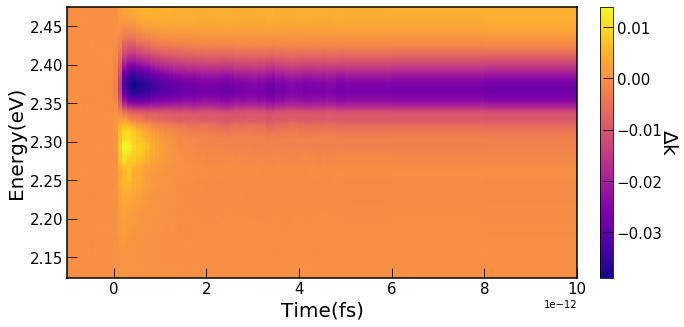

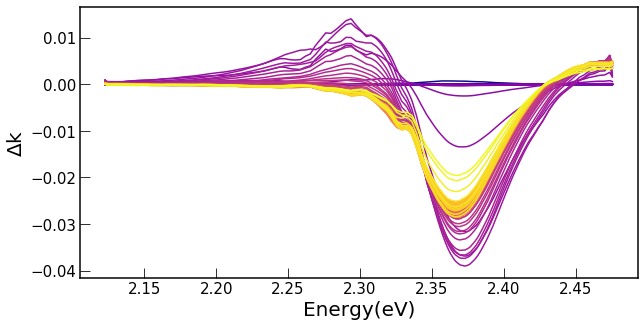

In [218]:
#Plot the dk map
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

x=time_map_axis
y= energy_maps_axis
X,Y=np.meshgrid(x,y)


fig1 = plt.figure(figsize=(10,5))
ax4 = fig1.add_subplot(111)
im = plt.pcolor(X,Y,np.transpose(dk_map),cmap=plt.cm.plasma)
im.set_edgecolor('face')
im.set_rasterized('False')
ax4.set_xlim(-10e-13,10e-12)
ax4.set_xlabel('Time(fs)',fontsize=20)
ax4.set_ylabel('Energy(eV)',fontsize=20)
cbar = colorbar(im,fraction=0.046, pad=0.04) 
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(axis='both',labelsize=15,direction='in',length=10)
ax4.tick_params(axis='both',labelsize=15,direction='in',length=10)
plt.setp(ax4.spines.values(), linewidth=1.5)
cbar.ax.set_ylabel('$\Delta$k',fontsize=20, rotation=270)
#plt.savefig('../../Desktop/KKR_MS/Fig3_DTT_CsPbBr3.eps', format='eps', dpi=200,transparent = True)


fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
number_of_plots= np.shape(time_map_axis)[0]
Y=number_of_plots
colormap = plt.cm.plasma #I suggest to use nipy_spectral, Set1,Paired
ax1.set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1,number_of_plots)])
j=0
while j<Y:
    plt.plot(energy_maps_axis,dk_map[j,:])
    j=j+1
ax1.set_xlabel('Energy(eV)',fontsize=20)
ax1.set_ylabel('$\Delta$k',fontsize=20)
ax1.tick_params(axis='both',labelsize=15,direction='in',length=10)
plt.setp(ax1.spines.values(), linewidth=1.5)


[None, None, None, None]

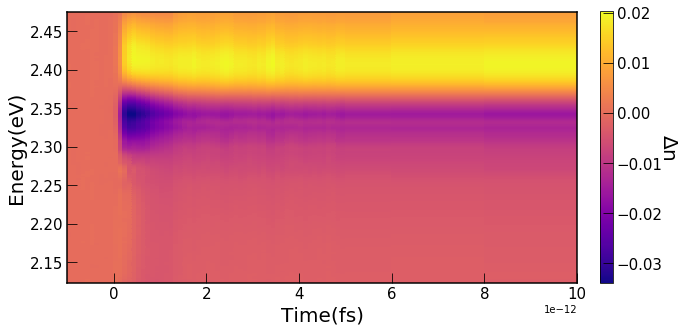

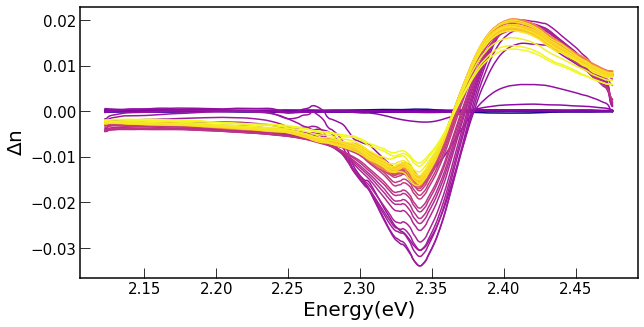

In [219]:
#Plot the dn map
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

x=time_map_axis
y= energy_maps_axis
X,Y=np.meshgrid(x,y)


fig1 = plt.figure(figsize=(10,5))
ax4 = fig1.add_subplot(111)
im = plt.pcolor(X,Y,np.transpose(dn_map),cmap=plt.cm.plasma)
im.set_edgecolor('face')
im.set_rasterized('False')
ax4.set_xlabel('Time(fs)',fontsize=20)
ax4.set_xlim(-10e-13,10e-12)
ax4.set_ylabel('Energy(eV)',fontsize=20)
cbar = colorbar(im,fraction=0.046, pad=0.04) 
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(axis='both',labelsize=15,direction='in',length=10)
ax4.tick_params(axis='both',labelsize=15,direction='in',length=10)
plt.setp(ax4.spines.values(), linewidth=1.5)
cbar.ax.set_ylabel('$\Delta$n',fontsize=20, rotation=270)
#plt.savefig('../../Desktop/KKR_MS/Fig3_DTT_CsPbBr3.eps', format='eps', dpi=200,transparent = True)


fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
number_of_plots= np.shape(time_map_axis)[0]
Y=number_of_plots
colormap = plt.cm.plasma #I suggest to use nipy_spectral, Set1,Paired
ax1.set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1,number_of_plots)])
j=0
while j<Y:
    plt.plot(energy_maps_axis,dn_map[j,:])
    j=j+1
ax1.set_xlabel('Energy(eV)',fontsize=20)
ax1.set_ylabel('$\Delta$n',fontsize=20)
ax1.tick_params(axis='both',labelsize=15,direction='in',length=10)
plt.setp(ax1.spines.values(), linewidth=1.5)



In [216]:
#Save dn and dk as TA ready files


h = 6.62e-34
c = 3e8
e = 1.6e-19


y= (h*c)/(e*1e-9*energy_maps_axis)

wavelength = np.insert(y,0,0)

x = np.transpose(dn_map)

x = np.vstack((time_map_axis,x))

print(wavelength.shape,x.shape)
wavelength = np.expand_dims(wavelength, axis=0)

x = np.hstack((wavelength.T,x))
print(x)
print(x.shape)
np.savetxt('CsPbBr3/CsPbBr3_dn.cor',x)



y= (h*c)/(e*1e-9*energy_maps_axis)

wavelength = np.insert(y,0,0)

x = np.transpose(dk_map)

x = np.vstack((time_map_axis,x))

print(wavelength.shape,x.shape)
wavelength = np.expand_dims(wavelength, axis=0)

x = np.hstack((wavelength.T,x))
print(x)
print(x.shape)
np.savetxt('CsPbBr3/CsPbBr3_dk.cor',x)

(1687,) (1687, 83)
[[ 0.00000000e+00 -1.00000000e-11 -7.00000000e-12 ...  1.00000000e-10
   1.50000000e-10  2.00000000e-10]
 [ 5.01403141e+02 -1.16931966e-04  1.65221519e-05 ...  6.74894104e-03
   5.90898547e-03  5.80562978e-03]
 [ 5.01452719e+02 -1.17843410e-04  1.79371974e-05 ...  6.76792292e-03
   5.92589630e-03  5.82273419e-03]
 ...
 [ 5.84645714e+02  8.54670793e-05 -9.26983651e-05 ... -2.39292389e-03
  -2.05305009e-03 -2.03184227e-03]
 [ 5.84695263e+02  8.47920790e-05 -9.21307946e-05 ... -2.39289483e-03
  -2.05425048e-03 -2.03231581e-03]
 [ 5.84744820e+02  8.42117233e-05 -9.14903764e-05 ... -2.39169130e-03
  -2.05445301e-03 -2.03171091e-03]]
(1687, 84)
(1687,) (1687, 83)
[[ 0.00000000e+00 -1.00000000e-11 -7.00000000e-12 ...  1.00000000e-10
   1.50000000e-10  2.00000000e-10]
 [ 5.01403141e+02 -3.16593609e-05 -7.52448078e-06 ...  3.99379120e-03
   3.49441379e-03  3.40853362e-03]
 [ 5.01452719e+02 -3.21222601e-05 -5.21036559e-06 ...  3.96125440e-03
   3.46679575e-03  3.38653910e-03]


In [266]:
#Save deps2
h = 6.62e-34
c = 3e8
e = 1.6e-19


y= (h*c)/(e*1e-9*energy_maps_axis)

wavelength = np.insert(y,0,0)

x = np.transpose(deps_2_map)

x = np.vstack((time_map_axis,x))

print(wavelength.shape,x.shape)
wavelength = np.expand_dims(wavelength, axis=0)

x = np.hstack((wavelength.T,x))
print(x)
print(x.shape)
np.savetxt('CsPbBr3/CsPbBr3_deps2.cor',x)

(1687,) (1687, 83)
[[ 0.00000000e+00 -1.00000000e-11 -7.00000000e-12 ...  1.00000000e-10
   1.50000000e-10  2.00000000e-10]
 [ 5.01403141e+02 -1.69294136e-04 -3.10338080e-05 ...  1.96945450e-02
   1.72327843e-02  1.68179583e-02]
 [ 5.01452719e+02 -1.71583603e-04 -2.01422155e-05 ...  1.95480333e-02
   1.71085494e-02  1.67195456e-02]
 ...
 [ 5.84645714e+02 -7.22953489e-05 -1.15899766e-04 ... -2.45260393e-04
  -7.95597419e-05 -1.68858465e-04]
 [ 5.84695263e+02 -6.74053276e-05 -1.06254412e-04 ... -1.65443403e-04
  -1.68497145e-05 -9.80255086e-05]
 [ 5.84744820e+02 -6.25152782e-05 -9.66090613e-05 ... -8.56289896e-05
   4.58581385e-05 -2.71946229e-05]]
(1687, 84)


## FINISH 

In [ ]:
#everything below here is workspace and fun random stuff

In [225]:
dn_data = np.loadtxt('CsPbBr3/dn_data.txt')

In [227]:
dn_data[1:,0]

array([ 400.,  500.,  600.,  700.,  800.,  900., 1000., 1100., 1200.,
       1300., 1400., 1500., 1600., 1700., 1800., 1900.])

Text(0, 0.5, '$\\Delta$n')

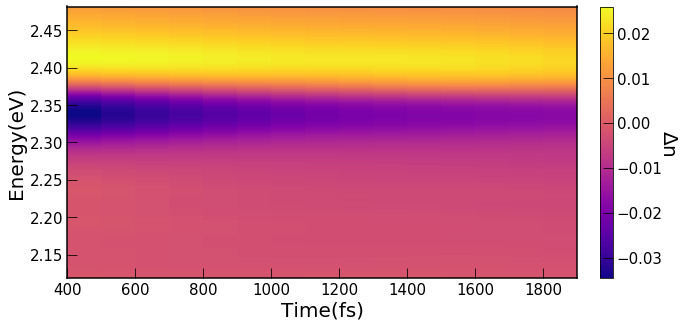

In [232]:
#Plot the dn DATA map
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

x=dn_data[1:,0]
y= dn_data[0,1:]
X,Y=np.meshgrid(x,y)


fig1 = plt.figure(figsize=(10,5))
ax4 = fig1.add_subplot(111)
im = plt.pcolor(X,Y,np.transpose(dn_data[1:,1:]),cmap=plt.cm.plasma)
im.set_edgecolor('face')
im.set_rasterized('False')
ax4.set_xlabel('Time(fs)',fontsize=20)
ax4.set_ylabel('Energy(eV)',fontsize=20)
cbar = colorbar(im,fraction=0.046, pad=0.04) 
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(axis='both',labelsize=15,direction='in',length=10)
ax4.tick_params(axis='both',labelsize=15,direction='in',length=10)
plt.setp(ax4.spines.values(), linewidth=1.5)
cbar.ax.set_ylabel('$\Delta$n',fontsize=20, rotation=270)



In [ ]:
dn_expt = np.loadtxt('Pentacene/RonnieData/Processed_WLCorrected.txt',delimiter =',')

dn_reffit = np.loadtxt('Pentacene/testagainstpython/dn_2925fs.txt',skiprows = 1)
dk_reffit = np.loadtxt('Pentacene/testagainstpython/dk_2925fs.txt',skiprows = 1)


plt.figure()
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.real(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='dn Homebuilt')
plt.plot((h*3e8)/(e*1e-9*(dn_reffit[:,0]/8065.6)),dn_reffit[:,1],label ='dn Reffit')
plt.plot(dn_expt[1:,0],scipy.ndimage.filters.gaussian_filter(np.mean(dn_expt[1:,125:130],axis =1)/14,sigma=0),label ='Expt')
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.imag(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='dk Homebuilt')
plt.plot((h*3e8)/(e*1e-9*(dk_reffit[:,0]/8065.6)),dk_reffit[:,1],label ='dk Reffit')
plt.ylim(-.0011,.001)
plt.legend()
plt.show()

In [ ]:

#Derivaties of SX each with respect to their special parameters and eps1, eps2 for chaining

def dS1beps1(w,c_guess):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    e1 = np.real(eps)
    e2 = np.imag(eps)
    return (-np.sqrt(np.sqrt(e1**2 + e2**2)-e1))/(2*np.sqrt(2)*(np.sqrt(e1**2 + e2**2)))

def dS1beps2(w,c_guess):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    e1 = np.real(eps)
    e2 = np.imag(eps)
    return (e2)/(2*np.sqrt(2)*(np.sqrt(e1**2 + e2**2)*np.sqrt(np.sqrt(e1**2 + e2**2)-e1)))

def dS2beps1(w,c_guess):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    e1 = np.real(eps)
    e2 = np.imag(eps)
    return (np.sqrt(np.sqrt(e1**2 + e2**2)-e1))/(2*np.sqrt(2)*(np.sqrt(e1**2 + e2**2)))


def dS2beps2(w,c_guess):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    e1 = np.real(eps)
    e2 = np.imag(eps)
    return (e2)/(2*np.sqrt(2)*(np.sqrt(e1**2 + e2**2)*np.sqrt(np.sqrt(e1**2 + e2**2)-e1)))


def dS3bd(c_guess,w,d,c):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    e1 = np.real(eps)
    e2 = np.imag(eps)
    r = (1 - np.sqrt(e1 +1j*e2) )/(1 + np.sqrt(e1 +1j*e2))
    t = np.exp(1j*w/c*d*np.sqrt(e1 +1j*e2))
    return np.abs((1-r**2)*t*1j*w/c)


def t(energy_TA,d,eps_re,eps_im):
    return np.exp(1j*energy_TA/c*d*np.sqrt(eps_re +1j*eps_im))

def r(eps_re,eps_im):
    return (1 - np.sqrt(eps_re +1j*eps_im) )/(1 + np.sqrt(eps_re +1j*eps_im) )

def Alpha_r_1(eps_re,eps_im):
    return -1/(((1+np.sqrt(eps_re +1j*eps_im))**2)*np.sqrt(eps_re +1j*eps_im))

def Alpha_r_2(eps_re,eps_im):
    return -1/(((1+np.sqrt(eps_re +1j*eps_im))**2)*np.sqrt(eps_re +1j*eps_im))

def Alpha_t_1(energy_TA,eps_re,eps_im,c,d):
    a = energy_TA*d*c
    return (1j*a*np.exp(1j*a* np.sqrt(eps_re +1j*eps_im)))/(2*np.sqrt(eps_re +1j*eps_im))

def Alpha_t_2(energy_TA,eps_re,eps_im,c,d):
    a = energy_TA*d*c
    return (-a*np.exp(1j*a* np.sqrt(eps_re +1j*eps_im)))/(2*np.sqrt(eps_re +1j*eps_im))

def dS3beps1(c_guess,w,d,c):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    eps_re = np.real(eps)
    eps_im = np.imag(eps)
    r1 = r(eps_re,eps_im)
    t1 = t(w,eps_re,eps_im,d)
    return (1-r1**2)*t1*(-2*np.conj(r1)*np.conj(t1)*Alpha_r_1(eps_re,-eps_im) + np.conj((1-r1**2))*Alpha_t_1(w,eps_re,-eps_im,c,d)) + np.conj((1-r1**2))*np.conj(t1)*(-2*r1*t1*Alpha_r_1(eps_re,eps_im) + (1-r1**2)*Alpha_t_1(w,eps_re,eps_im,c,d)) 

def dS3beps2(c_guess,w,d,c):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    eps_re = np.real(eps)
    eps_im = np.imag(eps)
    r1 = r(eps_re,eps_im)
    t1 = t(energy_TA,eps_re,eps_im,d)
    return (1-r1**2)*t1*(-2*np.conj(r1)*np.conj(t1)*Alpha_r_2(eps_re,-eps_im) + np.conj((1-r1**2))*Alpha_t_2(w,eps_re,-eps_im,c,d)) + np.conj((1-r1**2))*np.conj(t1)*(-2*r1*t1*Alpha_r_2(eps_re,eps_im) + (1-r1**2)*Alpha_t_2(w,eps_re,eps_im,c,d)) 

#Derivaties of dielectric function (eps1 and eps2) with respect to their params wp, w0, g

def de2bwp(w,wp,w0,g):
    return (2*g*w*wp)/((w0**2-w**2)+(g**2)*(w**2))

def de2bw0(w,wp,w0,g):
    return (-4*g*(wp**2)*w0*w*(w0**2-w**2))/(((g**2)*(w**2)) + ((w0**2 -w**2)**2)**2)

def de2bg(w,wp,w0,g):
    return (w*(wp**2)*(w**4 - (w**2)*(2*w0**2+g**2) +w0**4))/((((g**2)*(w**2)) + ((w0**2 -w**2)**2))**2)

def de1beinf(w):
    return w/w

def de1bwp(w,wp,w0,g):
    return (2*wp*(w0**2 -w**2))/((w0**2-w**2)+((g**2)*(w**2)))

def de1bw0(w,wp,w0,g):
    return (-2*(wp**2)*w0*((-(g**2)*(w**2))+w0**4 - (2*(w0**2)*(w**2)) + w**4))/((((g**2)*(w**2))+w0**4 - (2*(w0**2)*(w**2)) +w**4)**2)

def de1bg(w,wp,w0,g):
    return (-2*g*(w**2)*(wp**2)*(w0**2 - w**2))/((((g**2)*(w**2)) + (w**2 - w0**2)**2)**2)
    

#Chaining derivatives
    

def Jac(c_guess,energy_S1,energy_S2,energy_S3,S_1,S_2,S_3):
    i=0
    d = c_guess[0]
    eps_inf = c_guess[1] 
    params= c_guess[2:]                            
    wp=params[0::3]
    w0=params[1::3]
    g=params[2::3]
    w1 = energy_S1
    w2 = energy_S2
    w3 = energy_S3
    J = []
    #Evaluate del [S1,S2,S3] for a given parameter from the oscillators
    #Evaluate chaining term
    IF_S1_e1 = dS1beps1(w1,c_guess)
    IF_S1_e2 = dS1beps2(w1,c_guess)
    IF_S2_e1 = dS2beps1(w2,c_guess)
    IF_S2_e2 = dS2beps2(w2,c_guess)
    IF_S3_e1 = dS3beps1(c_guess,w3,d,c)
    IF_S3_e2 = dS3beps1(c_guess,w3,d,c)
    while i<(N_osc):
        J_temp_S1 = [IF_S1_e1*de1bwp(w1,wp[i],w0[i],g[i]) + IF_S1_e2*de2bwp(w1,wp[i],w0[i],g[i]),IF_S1_e1*de1bw0(w1,wp[i],w0[i],g[i])+IF_S1_e2*de2bw0(w1,wp[i],w0[i],g[i]),IF_S1_e1*de1bg(w1,wp[i],w0[i],g[i])+IF_S1_e2*de2bg(w1,wp[i],w0[i],g[i])]
        J_temp_S2 = [IF_S2_e1*de1bwp(w2,wp[i],w0[i],g[i]) + IF_S2_e2*de2bwp(w2,wp[i],w0[i],g[i]),IF_S2_e1*de1bw0(w2,wp[i],w0[i],g[i])+IF_S2_e2*de2bw0(w2,wp[i],w0[i],g[i]),IF_S2_e1*de1bg(w2,wp[i],w0[i],g[i])+IF_S2_e2*de2bg(w2,wp[i],w0[i],g[i])]
        J_temp_S3 = [IF_S3_e1*de1bwp(w3,wp[i],w0[i],g[i]) + IF_S3_e2*de2bwp(w3,wp[i],w0[i],g[i]),IF_S3_e1*de1bw0(w3,wp[i],w0[i],g[i])+IF_S3_e2*de2bw0(w3,wp[i],w0[i],g[i]),IF_S3_e1*de1bg(w3,wp[i],w0[i],g[i])+IF_S3_e2*de2bg(w3,wp[i],w0[i],g[i])]
        J_temp = np.append(J_temp_S1,J_temp_S2)
        J_temp = np.append(J_temp,J_temp_S3)
        J=np.append(J,J_temp)
        i=i+1    
    #Evaluate del [S1,S2,S3] for a given special parameter
    #for Eps_inf
    sp_J_temp = []
    sp_J_temp_S1 = IF_S1_e1*de1beinf(w1)
    sp_J_temp_S2 = IF_S2_e1*de1beinf(w2)
    sp_J_temp_S3 = IF_S3_e1*de1beinf(w3)
    sp_J_temp = np.append(sp_J_temp_S1,sp_J_temp_S2)
    sp_J_temp = np.append(sp_J_temp,sp_J_temp_S3)
    J = np.append(sp_J_temp,J) 
    #for d
    sp_J_temp = []
    sp_J_temp_S1 = np.zeros(np.shape(w1)[0])
    sp_J_temp_S2 = np.zeros(np.shape(w2)[0])
    sp_J_temp_S3 = dS3bd(c_guess,w3,d,c)
    sp_J_temp = np.append(sp_J_temp_S1,sp_J_temp_S2)
    sp_J_temp = np.append(sp_J_temp,sp_J_temp_S3)
    J = np.append(sp_J_temp,J) 
    J = np.asarray(J)
    J = np.reshape(J,(3*N_osc + 2,np.shape(w1)[0]+np.shape(w2)[0]+np.shape(w3)[0]))
    J = np.nan_to_num(J)
    return np.transpose(np.real(J))

In [ ]:
#Chaining approach to defining dT




#Set max and min for sliders #NOTE: Will be incorporated into bounds for fitting later
wp_min=-.001
wp_max=.001
w0_min =1.5
w0_max =2.3
g_min = 0
g_max = 8e-1

#Initialise parameters

i=0
params_init=[]
while i<N_osc:
    params_init_temp = [wp_min,np.linspace(w0_min,w0_max,N_osc)[i],g_min]
    params_init = np.append(params_init,params_init_temp)
    i=i+1
    
prams_init = c_guess_dtt

#c_guess_dtt is a list of parameters of size 3*N_osc (three params per oscillator)
#c_guess_dtt is indexed such that [wp_0,w0_0,g_0,wp_1,w0_1,g_1 ... ,wp_n,w0_n,g_n] for n+1 oscillators
#Note that before fitting routine, eps_inf appended to this array so c_guess_dtt[0] is eps_inf and c_guess_dtt[1:] is the old list


#Initialise slider

i=0
wp_slide=[]

while i<N_osc:
    wp_slide_temp = [wg.FloatSlider(min=wp_min,max=wp_max,step= .00001,value =c_guess_dtt[0+3*(i)]),wg.FloatSlider(min=w0_min,max=w0_max,step= .00001,value =c_guess_dtt[1+3*(i)]),wg.FloatSlider(min=g_min,max=g_max,step= .00001,value =c_guess_dtt[2+3*(i)])]
    wp_slide = np.append(wp_slide,wp_slide_temp)
    i=i+1


#Define the Lorentz Oscillation and Dielectic function as sum of oscillations etc

#IMPORTANT PLEASE NOTE
#Set wp^2 to wp so that we are allowed to have negative oscillators
def LorentzOsc(w,wp,w0,g):
    return wp/(w0**2 - w**2 - 1j*w*g)


#Diff Dielectric function is a sum of oscillators 
def dDF(w,params,N_osc):
    i=0
    x = np.zeros(e_grid)
    wp=params[0::3]
    w0=params[1::3]
    g=params[2::3]
    while i<N_osc:
        x = x+LorentzOsc(w,wp[i],w0[i],g[i])
        i=i+1
    return x


#Definining thin film TA Formula

def t(w,eps_re,eps_im,d): #complex reflection amplitude
    w = w/27.211
    return np.exp(1j*w/c*d*np.sqrt(eps_re +1j*eps_im))

def r(eps_re,eps_im): #complex transmission amplitude
    return (1 - np.sqrt(eps_re +1j*eps_im) )/(1 + np.sqrt(eps_re +1j*eps_im) )

def Alpha_r_1(eps_re,eps_im): #Derivative of r wrt eps1
    return -1/(((1+np.sqrt(eps_re +1j*eps_im))**2)*np.sqrt(eps_re +1j*eps_im))

def Alpha_r_2(eps_re,eps_im): #Derivative of r wrt eps2
    return -1j/(((1+np.sqrt(eps_re +1j*eps_im))**2)*np.sqrt(eps_re +1j*eps_im))

def Alpha_r_c_1(eps_re,eps_im): #Derivative of conj_r wrt eps1
    return -1/(((1+np.sqrt(eps_re -1j*eps_im))**2)*np.sqrt(eps_re -1j*eps_im))

def Alpha_r_c_2(eps_re,eps_im): #Derivative of conj_r wrt eps2
    return 1j/(((1+np.sqrt(eps_re -1j*eps_im))**2)*np.sqrt(eps_re -1j*eps_im))

def Alpha_t_1(w,eps_re,eps_im,c,d): #Derivative of t wrt eps1
    a = w*d/c/27.211
    return (1j*a*np.exp(1j*a*np.sqrt(eps_re +1j*eps_im)))/(2*np.sqrt(eps_re +1j*eps_im))

def Alpha_t_2(w,eps_re,eps_im,c,d): #Derivative of t wrt eps2
    a = w*d/c/27.211
    return (-a*np.exp(1j*a*np.sqrt(eps_re +1j*eps_im)))/(2*np.sqrt(eps_re +1j*eps_im))

def Alpha_t_c_1(w,eps_re,eps_im,c,d): #Derivative of conj_t wrt eps1
    a = w*d/c/27.211
    return (1j*a*np.exp(1j*a*np.sqrt(eps_re -1j*eps_im)))/(2*np.sqrt(eps_re -1j*eps_im))

def Alpha_t_c_2(w,eps_re,eps_im,c,d): #Derivative of conj_t wrt eps2
    a = w*d/c/27.211
    return (a*np.exp(1j*a*np.sqrt(eps_re -1j*eps_im)))/(2*np.sqrt(eps_re -1j*eps_im))

def Alpha_1(w, eps_re, eps_im, n, d): #Derivative of T wrt eps1
    r1 = r(eps_re,eps_im)
    t1 = t(w,eps_re,eps_im,d)
    return (1-r1**2)*t1*(-2*np.conj(r1)*np.conj(t1)*Alpha_r_c_1(eps_re,eps_im) + np.conj((1-r1**2))*Alpha_t_c_1(w,eps_re,eps_im,c,d)) + np.conj((1-r1**2))*np.conj(t1)*(-2*r1*t1*Alpha_r_1(eps_re,eps_im) + (1-r1**2)*Alpha_t_1(w,eps_re,eps_im,c,d)) 

def Alpha_2(w, eps_re, eps_im, n, d):#Derivative of T wrt eps2
    r1 = r(eps_re,eps_im)
    t1 = t(w,eps_re,eps_im,d)
    return (1-r1**2)*t1*(-2*np.conj(r1)*np.conj(t1)*Alpha_r_c_2(eps_re,eps_im) + np.conj((1-r1**2))*Alpha_t_c_2(w,eps_re,eps_im,c,d)) + np.conj((1-r1**2))*np.conj(t1)*(-2*r1*t1*Alpha_r_2(eps_re,eps_im) + (1-r1**2)*Alpha_t_2(w,eps_re,eps_im,c,d)) 


def dT(w,c_guess_dtt, eps_re, eps_im, n, d,N_osc): #Variational derivative of T wrt eps1 and eps2 
    a1 = np.abs(Alpha_1(w, eps_re, eps_im, n, d))
    a2 = np.abs(Alpha_2(w, eps_re, eps_im, n, d))
    return a1*np.real(dDF(w,c_guess_dtt,N_osc)) + a2*np.imag(dDF(w,c_guess_dtt,N_osc))


#Sets up plot for the sliders
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line_TA, = ax.plot(w,dT(w,c_guess_dtt,np.real(eps_base), np.imag(eps_base), n, d,N_osc))                                                                                                                                
line_TA_data = ax.plot(energy_TA,TA_data)
#ax.set_ylim(-.01,0.01)

#This is where you select the oscillator to control in the slider. Change this to a value <= N_osc and run this bit of code to select a differnt oscillator 
osc_num = 3


i_wp=int(0+3*(osc_num-1))
i_w0=int(1+3*(osc_num-1))
i_g=int(2+3*(osc_num-1))


#Updates plot when sliders moved
def update(wp=wp_slide[i_wp],w0=wp_slide[i_w0],g=wp_slide[i_g]):
    line_TA.set_ydata(dT(w,c_guess_dtt,np.real(eps_base), np.imag(eps_base), n, d,N_osc))
    c_guess_dtt[i_wp] = wp
    c_guess_dtt[i_w0] = w0
    c_guess_dtt[i_g] =  g
    fig.canvas.draw_idle()



print('Controlling Oscillator number ', osc_num)   
wg.interact(update)







In [ ]:



plt.figure()
plt.plot(energy_grid[:-1],scipy.ndimage.filters.gaussian_filter(np.divide(np.diff(f_S3(energy_grid, np.real(eps_S3), np.imag(eps_S3),xf[0])),np.diff( np.real(eps_S3))),40))
plt.plot(energy_grid[:-1],scipy.ndimage.filters.gaussian_filter(np.divide(np.diff(f_S3(energy_grid, np.real(eps_S3), np.imag(eps_S3),xf[0])),np.diff( np.imag(eps_S3))),40))




In [ ]:
1/2/2

In [ ]:
(3**2+3**2)**(1/float(4))

In [ ]:
eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)
eps_base_w = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)



u_t = u(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
v_t = v(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
du_1_t = du_1(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
du_2_t = du_2(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
dv_1_t = dv_1(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
dv_2_t = dv_2(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
a1 = (v_t*du_1_t - u_t*dv_1_t)/(v_t**2) #Quotient rule
a2 = (v_t*du_2_t - u_t*dv_2_t)/(v_t**2)
a1_t = f_a1_ref_t(energy_TA)
a2_t = f_a2_ref_t(energy_TA)


plt.figure()
plt.plot(energy_TA,a1,label = 'dT/d(eps1)')
plt.plot(energy_TA,a2,label = 'dT/d(eps2)')
plt.plot(energy_TA,a1_t,label = 'reff dT/d(eps1) ')
plt.plot(energy_TA,a2_t,label = 'reff dT/d(eps2)')
plt.legend()


plt.figure()
plt.plot(energy_TA, a1/a2)
#plt.ylim(-100,100)
plt.show()

In [ ]:
np.sqrt(np.sqrt(18))

In [ ]:
energy_TA

In [ ]:
#Check derivatives against reffit


dT_ref = np.loadtxt('Pentacene/testagainstpython/dTT_reffit.dat',skiprows =1)
epsbase_ref = np.loadtxt('Pentacene/testagainstpython/base_eps1eps2.dat',skiprows =1)
deps_ref = np.loadtxt('Pentacene/testagainstpython/deps1deps2.dat',skiprows =1)
dndk_ref = np.loadtxt('Pentacene/testagainstpython/dndk_1_reffit.dat',skiprows =1)


energy_ref = dT_ref[:,0]/8065.6
dT_ref = dT_ref[:,1]
f_base_eps_re_ref = interp1d(epsbase_ref[:,0]/8065.6,epsbase_ref[:,1],kind = 'linear')
base_eps_re_ref = f_base_eps_re_ref(energy_ref)
f_base_eps_im_ref = interp1d(epsbase_ref[:,0]/8065.6,epsbase_ref[:,2],kind = 'linear')
base_eps_im_ref = f_base_eps_im_ref(energy_ref)
f_deps_re = interp1d(deps_ref[:,0]/8065.6,deps_ref[:,1],kind = 'linear')
deps_re = f_deps_re(energy_ref)
f_deps_im = interp1d(deps_ref[:,0]/8065.6,deps_ref[:,2],kind = 'linear')
deps_im =  f_deps_im(energy_ref)
f_dk = interp1d(dndk_ref[:,0]/8065.6,dndk_ref[:,2],kind = 'linear')
dk =  f_dk(energy_ref)
f_dn = interp1d(dndk_ref[:,0]/8065.6,dndk_ref[:,1],kind = 'linear')
dn =  f_dn(energy_ref)

d = 1889.0429440855821

u_t_ref = u(energy_ref ,base_eps_re_ref ,base_eps_im_ref ,d)
v_t_ref = v(energy_ref ,base_eps_re_ref ,base_eps_im_ref,d)
du_1_t_ref = du_1(energy_ref ,base_eps_re_ref ,base_eps_im_ref,d)
du_2_t_ref = du_2(energy_ref ,base_eps_re_ref ,base_eps_im_ref,d)
dv_1_t_ref = dv_1(energy_ref ,base_eps_re_ref ,base_eps_im_ref,d)
dv_2_t_ref = dv_2(energy_ref ,base_eps_re_ref ,base_eps_im_ref,d)
a1_ref = (v_t_ref*du_1_t_ref - u_t_ref*dv_1_t_ref)/(v_t_ref**2) #Quotient rule
a2_ref = (v_t_ref*du_2_t_ref - u_t_ref*dv_2_t_ref)/(v_t_ref**2)
dT_ref_py = a1_ref*deps_re + a2_ref*deps_im

f_a1_ref_t = interp1d(energy_ref,a1_ref,kind ='linear')
a1_ref_t = f_a1_ref_t(w)
f_a2_ref_t = interp1d(energy_ref,a2_ref,kind ='linear')
a2_ref_t = f_a2_ref_t(w)

plt.figure()
plt.plot(energy_ref,dT_ref_py,label ='dT Py')
plt.plot(energy_ref,dT_ref,label ='dT Reffit')
plt.legend()
plt.show()



plt.figure()
plt.plot(energy_ref,a1_ref,label ='Reffit a1')
plt.plot(energy_ref,a2_ref,label ='Reffit a2')
plt.legend()
plt.show()




In [ ]:
dn_form_1 = np.real((1/(2*np.sqrt(base_eps_re_ref+1j*base_eps_im_ref)))*(deps_re +1j*deps_im))
dk_form_1 = np.imag((1/(2*np.sqrt(base_eps_re_ref+1j*base_eps_im_ref)))*(deps_re +1j*deps_im))

dn_form_2 = np.real(np.sqrt((deps_re +1j*deps_im)))
dk_form_2 = np.imag(np.sqrt((deps_re +1j*deps_im)))

dn_form_3 = np.real(base_eps_re_ref+1j*base_eps_re_ref) - np.real(base_eps_re_ref+1j*base_eps_re_ref -deps_re -1j*deps_im)
dk_form_3 = np.imag(base_eps_re_ref+1j*base_eps_re_ref) - np.imag(base_eps_re_ref+1j*base_eps_re_ref -deps_re -1j*deps_im)

dk_form_4 = dkbdeps1(energy_ref,base_eps_re_ref,base_eps_im_ref,c,d)*deps_re + dkbdeps2(energy_ref,base_eps_re_ref,base_eps_im_ref,c,d)*deps_im
dn_form_4 = dnbdeps1(energy_ref,base_eps_re_ref,base_eps_im_ref,c,d)*deps_re + dnbdeps2(energy_ref,base_eps_re_ref,base_eps_im_ref,c,d)*deps_im  


plt.figure()
plt.plot(energy_ref,dn,'.',label ='dn reffit')
plt.plot(energy_ref,dk,'.',label ='dk reffit')
plt.plot(energy_ref, dn_form_1 , label ='dn form 1')
plt.plot(energy_ref, dk_form_1 , label ='dk form 1')
# plt.plot(energy_ref, dn_form_2 , label ='dn form 2')
# plt.plot(energy_ref, dk_form_2 , label ='dk form 2')
# plt.plot(energy_ref, dn_form_4 , label ='dn form 4')
# plt.plot(energy_ref, dk_form_4 , label ='dk form 4')
plt.legend()
plt.show()

In [ ]:
def dnbdeps1(energy_TA,eps_re,eps_im,c,d):
    t1 =(-0.5*eps_re**2*eps_im - 0.5*eps_im**3)*np.cos(0.5*np.arctan(eps_im/eps_re))
    t2 = eps_re*(eps_re**2 +eps_im**2)*np.sin(0.5*np.arctan(eps_im/eps_re))
    t3= (eps_re**2 +eps_im**2)**(float(3/2))
    return (t1+t2)/t3

def dnbdeps2(energy_TA,eps_re,eps_im,c,d):
    t1 =(0.5*eps_re**3 + 0.5*eps_re*eps_im**2)*np.cos(0.5*np.arctan(eps_im/eps_re))
    t2 = eps_im*(eps_re**2 +eps_im**2)*np.sin(0.5*np.arctan(eps_im/eps_re))
    t3= (eps_re**2 +eps_im**2)**(float(3/2))
    return (t1+t2)/t3

def dkbdeps1(energy_TA,eps_re,eps_im,c,d):
    t1 =(eps_re**3 + eps_re*eps_im**2)*np.cos(0.5*np.arctan(eps_im/eps_re))
    t2 = eps_im*(0.5*eps_re**2 +0.5*eps_im**2)*np.sin(0.5*np.arctan(eps_im/eps_re))
    t3= (eps_re**2 +eps_im**2)**(float(3/2))
    return (t1+t2)/t3

def dkbdeps2(energy_TA,eps_re,eps_im,c,d):
    t1 =(eps_re**2*eps_im + eps_re**3)*np.cos(0.5*np.arctan(eps_im/eps_re))
    t2 = eps_re*(-0.5*eps_re**2 -0.5*eps_im**2)*np.sin(0.5*np.arctan(eps_im/eps_re))
    t3= (eps_re**2 +eps_im**2)**(float(3/2))
    return (t1+t2)/t3

 

In [ ]:
plt.figure()
plt.plot(energy_ref,np.real(np.sqrt(base_eps_re_ref +1j*base_eps_im_ref)) )
plt.plot(w,np.real(np.sqrt(eps_re +1j*eps_im)))

In [ ]:
plt.figure()
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.imag(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base), np.imag(eps_base),delta,n, d,N_osc_dtt,wcwc_dtt)))

In [ ]:
#Export for 

eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)
eps_base_w = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)



u_t = u(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
v_t = v(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
du_1_t = du_1(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
du_2_t = du_2(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
dv_1_t = dv_1(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
dv_2_t = dv_2(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
a1 = (v_t*du_1_t - u_t*dv_1_t)/(v_t**2) #Quotient rule
a2 = (v_t*du_2_t - u_t*dv_2_t)/(v_t**2)



np.save('../Desktop/KKR_MS/dTbydeps_energyaxis.npy',energy_TA)

In [ ]:
import math
def kkr(de, eps_imag, cshift=1e-6):
        eps_imag = np.array(eps_imag)
        nedos = eps_imag.shape[0]
        cshift = complex(0, cshift)
        w_i = np.arange(0, nedos*de, de, dtype=np.complex_)
        w_i = np.reshape(w_i, (nedos, 1, 1))

        def integration_element(w_r):
            factor = w_i / (w_i**2 - w_r**2 + cshift)
            total = np.sum(eps_imag * factor, axis=0)
            return total * (2/math.pi) * de + np.diag([1, 1, 1])

        return np.real([integration_element(w_r) for w_r in w_i[:,0,0]])

#:Making of a matrix
a = np.zeros(9009)
a = np.asarray(a)
a = np.reshape(a,(1001,3,3))

ax = np.zeros(9009)
ax = np.asarray(ax)
ax = np.reshape(ax,(1001,3,3))

ay = np.zeros(9009)
ay = np.asarray(ay)
ay = np.reshape(ay,(1001,3,3))

az = np.zeros(9009)
az = np.asarray(az)
az = np.reshape(az,(1001,3,3))


i=0
j=0
k=0
while i < 1001:
    ax[i] =np.diag([1,0,0])*diabolical_osc_im(x,5,.1)[i]
    i=i+1


while j < 1001:
    ay[j] = np.diag([0,1,0])*diabolical_osc_im(x,5,.1)[j]
    j=j+1


while k < 1001:
    az[k] = np.diag([0,0,1])*diabolical_osc_im(x,5,.1)[k]
    k=k+1

a=ax+ay+az

test_dia_re = kkr(5/1000,a,1e-10)
test_dia_re = test_dia_re[:,0,0] #Taking the xx component